**このコードでは、深層学習のCNNとLSTMのそれぞれのモデルを用いて1日と1週間単位の二つの値で予測するという作業を行う**

前提として、

*  Data_preprocessing_1とData_preprocessing_city&AQI_2、Data_feature&Missing_value_imputation_3を動かし、訓練・検証・テストデータとして用いるデータがcsvとして保存されていること

が条件となる。

**参考資料**

*   [Optunaを用いたProphetモデルのコード参考サイト](https://book.st-hakky.com/data-science/prophet-model-predicts/)

*  [Prophetの公式サイト](https://facebook.github.io/prophet/)


要変更

**注意事項**

※ 作成者はGoogle drive内で作業をしていると同時に、ゼミというフォルダーの中の公開ソースというフォルダーで作業していることからpathの変更は必要不可欠である

# 初期設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#必要なライブラリーをインストール
!pip install keras
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.5 MB/s eta 0:00:00


In [7]:
#必要なライブラリーをインポート
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# #lstm
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam

import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import optuna
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.callbacks import EarlyStopping

In [8]:
#csvファイルを読み込み
# working_dir = "/content/drive/MyDrive/ゼミ/公開ソース"
working_dir = "/content/drive/MyDrive/公開ソース"
path = f'{working_dir}/data/traninig_validation_test_data'
city_lists = ["Tokyo","Delhi"]

for city_name in city_lists:
  city_df = pd.read_csv(f'{path}/{city_name}_paper.csv',index_col=0,parse_dates=True)
  exec("{}=city_df".format(city_name))

In [9]:
#目的変数を抽出するためのリスト
elements = ["AQI_total","pm25","pm10","co","no2","so2","o3"]

In [10]:
#学習用データ作成
def make_sequences(sequences,n_steps_in,n_steps_out):
  X = []
  y = []
  for i in range(0, len(sequences), 1):
    end_num = i + n_steps_in + 1 # 学習用の最後
    out_end_num = end_num + n_steps_out -1

    if out_end_num > len(sequences):
      break

    x_seq = sequences[i:end_num-1, :]
    y_seq = sequences[end_num-1:out_end_num, -1]

    X.append(x_seq)
    y.append(y_seq)

  return np.array(X), np.array(y)

In [11]:
#MAPE値を算出するための関数
def mape(predict, observed):
  absolute_diff_percentage =  abs( (predict - observed) / observed)
  sum_abs_diff = sum(absolute_diff_percentage)
  mape = sum_abs_diff / len(predict)

  return mape

In [13]:
#MAPE値を保存するためのデータフレームを作成
df_results = pd.DataFrame(columns=["cnn_week_mape"])

In [12]:
#1週間単位の予測値を保存するデータフレーム作成
#データフレームの列の長さは
Tokyo_week = Tokyo.resample("W").mean()
df_pred_week =  pd.DataFrame(index=[Tokyo_week.index])[-48:]

In [14]:
#1週間単位の予測値を保存するデータフレームの確認
df_pred_week

""
Date
2022-12-11
2022-12-18
2022-12-25
2023-01-01
2023-01-08
2023-01-15
2023-01-22
2023-01-29
2023-02-05


# CNNとLSTMの1週間単位の予測

※ ローカル変数と引数、戻り値を使って悪影響を減らす、処理の単位が明確になって可読性も上がるという利点があるため、関数内に関数を入力している。

In [ ]:

#1週間単位の予測をcreate_week_model関数にて、cnn,lstmの両方を動かす
def create_week_model(df,city_name):
  #グラフを保存するpathを作成
  path_img = f"{working_dir}/result/graph/深層学習"
  #予測値の値を保存するデータフレームを作成
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    df_w = df.resample("W").mean()
    rh_min = df_w[element].min()
    rh_max = df_w[element].max()
    df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
    df_target = df_w[["target"]]
    df_train = df_target[:-104]
    df_val = df_target[-104:-52]
    df_test = df_target[-52:]

    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    #約一ヶ月(4つ)の値から1週間の値を出力
    n_steps_in = 4
    n_steps_out = 1
    X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
    X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
    X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]


    # #CNNの予測モデル
    def create_cnn_week_model(trial):
        model = Sequential()

        num_conv_layers = trial.suggest_int('num_conv_layers', 1, 2)
        conv_filters = trial.suggest_int('conv_filters', 16, 64)
        kernel_size = trial.suggest_int('kernel_size', 1, 2)
        num_dense_layers = trial.suggest_int('num_dense_layers', 1, 2)
        dense_units = trial.suggest_int('dense_units', 32, 100)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

        for i in range(num_conv_layers):
            model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps_in, n_features)))

        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())

        for i in range(num_dense_layers):
            model.add(Dense(units=dense_units, activation='relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(units=1, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model



    def objective_cnn(trial, X_train, y_train, X_val, y_val):
        # input_shape = X_train.shape[1:]
        model = create_cnn_week_model(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32,callbacks=[early_stopping], verbose=0)

        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)

        return val_mse

    # Optunaでハイパーパラメータの最適化（訓練データと検証データを使用）
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, X_val, y_val), n_trials=50)

    # 最適なハイパーパラメータの取得
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    optimal_model = create_cnn_week_model(study.best_trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    optimal_model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping],verbose=1)

    y_test_pred = optimal_model.predict(X_test)
    pred_cnn_ = y_test_pred.ravel().tolist()


    y_test_ = y_test.ravel().tolist()
    result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_cnn_)], axis=1))
    result_df.columns = [f"{element}_scaled_cnn", f"pred_scaled_{element}_cnn"]

    #計算するときは正規化した状態で予測値を算出しているため、元の値に戻した列を作成する
    result_df[f"{element}_original_cnn"] = result_df[f"{element}_scaled_cnn"] * (rh_max-rh_min) + rh_min
    result_df[f"{element}_pred_original_cnn"] = result_df[f"pred_scaled_{element}_cnn"] * (rh_max-rh_min) + rh_min
    mape_df = str(str(round(mape(result_df[f"{element}_pred_original_cnn"], result_df[f"{element}_original_cnn"])*100,2))+"%")
    #MAPE値を保存するデータフレームに追加
    df_results.at[f"{city_name}_{element}","cnn_week_mape"] = mape_df
    df_tests = df_w[-len(result_df):]
    df_tests = df_tests.reset_index()

    df_pred_week[f"{city_name}_{element}_cnn"] = result_df[f"{element}_pred_original_cnn"].values
    graph_df = pd.concat([df_tests, result_df[f"{element}_pred_original_cnn"]], axis=1)


    def create_lstm_week_model(trial):
        n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3)  # LSTM層の数
        units_per_layer = [trial.suggest_int(f'units_{i}', 20, 100) for i in range(n_lstm_layers)]  # 各LSTM層のユニット数
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

        model = Sequential()
        for i in range(n_lstm_layers):
            if i == 0:
                model.add(LSTM(units=units_per_layer[i], input_shape=(n_steps_in,n_features), dropout=dropout_rate, return_sequences=True))
            elif i == n_lstm_layers - 1:
                model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate))
            else:
                model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate, return_sequences=True))

        model.add(Dense(1))

        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        return model

    def objective_lstm(trial):
        model = create_lstm_week_model(trial)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=32,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping],
                  verbose=0)

        val_loss = model.evaluate(X_val, y_val, verbose=1)

        return val_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lstm, n_trials=50)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    # 最適なハイパーパラメータで最終的なモデルを構築
    best_model = create_lstm_week_model(study.best_trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # モデルの訓練（全データを使用）
    best_model.fit(X_train,
                   y_train,
                  epochs=50,
                  batch_size=32,
                  callbacks=[early_stopping],
                  verbose=1)


    pred_lstm = best_model.predict(X_test)
    pred_lstm_ = pred_lstm.ravel().tolist()
    y_test_ = y_test.ravel().tolist()
    result_df_lstm = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_lstm_)], axis=1))
    result_df_lstm.columns = [f"{element}_scaled", f"pred_scaled_{element}"]

    result_df_lstm[f"{element}_original"] = result_df_lstm[f"{element}_scaled"] * (rh_max-rh_min) + rh_min
    result_df_lstm[f"{element}_pred_original"] = result_df_lstm[f"pred_scaled_{element}"] * (rh_max-rh_min) + rh_min
    mape_df = str(str(round(mape(result_df_lstm[f"{element}_pred_original"], result_df_lstm[f"{element}_original"])*100,2))+"%")
    df_results.at[f"{city_name}_{element}","lstm_week_mape"] = mape_df


    df_pred_week[f"{city_name}_{element}_lstm"] = result_df_lstm[f"{element}_pred_original"].values




    graph_df_lstm = pd.concat([graph_df, result_df_lstm[f"{element}_pred_original"]], axis=1)
    graph_df_lstm["Date"]= pd.to_datetime(graph_df_lstm['Date'])
    graph_df_lstm.set_index('Date', inplace=True)




    #グラフ作成

    plt.plot(graph_df_lstm[f"{element}"], color="#FF4B00",label = element)
    plt.plot(graph_df_lstm[f"{element}_pred_original_cnn"], color="blue",label = "CNN_predicted_value")
    plt.plot(graph_df_lstm[f"{element}_pred_original"], color="#03AF7A",label = "LSTM_predicted_value")
    plt.title(f'{city_name}(2022/11/13~2023/11/5){element}_CNN_LSTM_week_pred')
    plt.xlabel("Date")
    plt.ylabel(element)
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f'{path_img}/{city_name}_{element}_cnn_lstm_week.png',bbox_inches='tight')
    plt.show()



  return graph_df_lstm



[I 2024-04-07 13:20:10,449] A new study created in memory with name: no-name-8839aee2-5b5b-4327-b3a0-4f12161ac824
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:20:16,780] Trial 0 finished with value: 0.01906572998991346 and parameters: {'num_conv_layers': 2, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.16411159850354023}. Best is trial 0 with value: 0.01906572998991346.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:20:20,412] Trial 1 finished with value: 0.019111014138433628 and parameters: {'num_conv_layers': 1, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 48, 'dropout_rate': 0.2587011402030821}. Best is trial 0 with value: 0.01906572998991346.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 13:20:24,155] Trial 2 finished with value: 0.018435475901927238 and parameters: {'num_conv_layers': 1, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 97, 'dropout_rate': 0.2403007663006137}. Best is trial 2 with value: 0.018435475901927238.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 13:20:26,862] Trial 3 finished with value: 0.019278717828775157 and parameters: {'num_conv_layers': 1, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.0031418730763865255}. Best is trial 2 with value: 0.018435475901927238.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 13:20:30,486] Trial 4 finished with value: 0.01908310672520255 and parameters: {'num_conv_layers': 1, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 73, 'dropout_rate': 0.4673759604081371}. Best is trial 2 with value: 0.018435475901927238.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 17ms/step


[I 2024-04-07 13:20:35,946] Trial 5 finished with value: 0.01880690557928861 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.1861285377281226}. Best is trial 2 with value: 0.018435475901927238.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:20:39,395] Trial 6 finished with value: 0.019022749353330152 and parameters: {'num_conv_layers': 1, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 52, 'dropout_rate': 0.2609350766711813}. Best is trial 2 with value: 0.018435475901927238.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 16ms/step


[I 2024-04-07 13:20:43,395] Trial 7 finished with value: 0.018182935248609634 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 48, 'dropout_rate': 0.2263722697236622}. Best is trial 7 with value: 0.018182935248609634.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:20:51,526] Trial 8 finished with value: 0.017151677785373222 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 82, 'dropout_rate': 0.18909811724185194}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:20:55,452] Trial 9 finished with value: 0.018102458922216375 and parameters: {'num_conv_layers': 1, 'conv_filters': 61, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 49, 'dropout_rate': 0.1578419762985312}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:20:57,572] Trial 10 finished with value: 0.01926483080417788 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 87, 'dropout_rate': 0.41379947801983297}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:21:04,040] Trial 11 finished with value: 0.017232574619579073 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 61, 'dropout_rate': 0.09541928432296601}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:21:06,279] Trial 12 finished with value: 0.018135498477780794 and parameters: {'num_conv_layers': 1, 'conv_filters': 31, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 79, 'dropout_rate': 0.05499924867465182}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:21:08,156] Trial 13 finished with value: 0.020680898572240213 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 66, 'dropout_rate': 0.0953372280745226}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:21:10,107] Trial 14 finished with value: 0.019748607557001207 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.32136592350637977}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:21:14,078] Trial 15 finished with value: 0.017866121622324427 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.09834978630192646}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:21:18,083] Trial 16 finished with value: 0.0177400946094016 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.09958648780851857}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:21:20,178] Trial 17 finished with value: 0.018321621054512943 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 32, 'dropout_rate': 0.36276519480499003}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:21:22,670] Trial 18 finished with value: 0.02341129892094966 and parameters: {'num_conv_layers': 1, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 60, 'dropout_rate': 0.02450547112550544}. Best is trial 8 with value: 0.017151677785373222.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:21:24,825] Trial 19 finished with value: 0.018215460128089417 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 80, 'dropout_rate': 0.32291902515822996}. Best is trial 8 with value: 0.017151677785373222.


Best Hyperparameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 82, 'dropout_rate': 0.18909811724185194}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 4s - loss: 0.3138 - mae: 0.5424

5/5 [==============================] - 1s 8ms/step - loss: 0.2283 - mae: 0.4475
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1088 - mae: 0.2882

5/5 [==============================] - 0s 9ms/step - loss: 0.0708 - mae: 0.2154
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0260 - mae: 0.1256

5/5 [==============================] - 0s 7ms/step - loss: 0.0523 - mae: 0.1763
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0434 - mae: 0.1614

5/5 [==============================] - 0s 8ms/step - loss: 0.0492 - mae: 0.1719
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0394 - mae: 0.1483

5/5 [==============================] - 0s 8ms/step - loss: 0.0366 - mae: 0.1466
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0449 - mae: 0.1568

5/5 [==============================] - 0s 7ms/step - loss: 0.0310 - mae: 0.1369
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0348 - mae: 0.1603

5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - mae: 0.1423
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0363 - mae: 0.1448

5/5 [==============================] - 0s 5ms/step - loss: 0.0318 - mae: 0.1329
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0316 - mae: 0.1497

5/5 [==============================] - 0s 7ms/step - loss: 0.0361 - mae: 0.1481
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0254 - mae: 0.1295

5/5 [==============================] - 0s 7ms/step - loss: 0.0311 - mae: 0.1394
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0424 - mae: 0.1673

5/5 [==============================] - 0s 8ms/step - loss: 0.0328 - mae: 0.1404
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0191 - mae: 0.1006

5/5 [==============================] - 0s 6ms/step - loss: 0.0343 - mae: 0.1415
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0260 - mae: 0.1295

5/5 [==============================] - 0s 6ms/step - loss: 0.0289 - mae: 0.1345
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0451 - mae: 0.1704

5/5 [==============================] - 0s 6ms/step - loss: 0.0303 - mae: 0.1364
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0350 - mae: 0.1511

5/5 [==============================] - 0s 7ms/step - loss: 0.0344 - mae: 0.1406
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0296 - mae: 0.1335

5/5 [==============================] - 0s 8ms/step - loss: 0.0280 - mae: 0.1316
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0238 - mae: 0.1133

5/5 [==============================] - 0s 6ms/step - loss: 0.0290 - mae: 0.1335
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0333 - mae: 0.1517

5/5 [==============================] - 0s 8ms/step - loss: 0.0305 - mae: 0.1378
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0286 - mae: 0.1440

5/5 [==============================] - 0s 8ms/step - loss: 0.0304 - mae: 0.1391
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1368

5/5 [==============================] - 0s 7ms/step - loss: 0.0279 - mae: 0.1331
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0256 - mae: 0.1297

5/5 [==============================] - 0s 7ms/step - loss: 0.0297 - mae: 0.1394
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0251 - mae: 0.1344

5/5 [==============================] - 0s 7ms/step - loss: 0.0260 - mae: 0.1285
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0513 - mae: 0.1838

5/5 [==============================] - 0s 8ms/step - loss: 0.0314 - mae: 0.1399
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0392 - mae: 0.1585

5/5 [==============================] - 0s 7ms/step - loss: 0.0295 - mae: 0.1401
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0442 - mae: 0.1611

5/5 [==============================] - 0s 9ms/step - loss: 0.0322 - mae: 0.1424
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0342 - mae: 0.1498

5/5 [==============================] - 0s 8ms/step - loss: 0.0269 - mae: 0.1295
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - mae: 0.1099

5/5 [==============================] - 0s 7ms/step - loss: 0.0258 - mae: 0.1285
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0314 - mae: 0.1274

5/5 [==============================] - 0s 8ms/step - loss: 0.0326 - mae: 0.1399
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1137

5/5 [==============================] - 0s 8ms/step - loss: 0.0275 - mae: 0.1309
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0344 - mae: 0.1539

5/5 [==============================] - 0s 8ms/step - loss: 0.0285 - mae: 0.1340
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0331 - mae: 0.1350

5/5 [==============================] - 0s 7ms/step - loss: 0.0299 - mae: 0.1364
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299 - mae: 0.1263

5/5 [==============================] - 0s 6ms/step - loss: 0.0280 - mae: 0.1340
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0305 - mae: 0.1460

5/5 [==============================] - 0s 8ms/step - loss: 0.0302 - mae: 0.1378
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0394 - mae: 0.1475

5/5 [==============================] - 0s 8ms/step - loss: 0.0308 - mae: 0.1332
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1265

5/5 [==============================] - 0s 7ms/step - loss: 0.0301 - mae: 0.1339
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0307 - mae: 0.1470

5/5 [==============================] - 0s 7ms/step - loss: 0.0294 - mae: 0.1343
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1255

5/5 [==============================] - 0s 7ms/step - loss: 0.0293 - mae: 0.1344
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0294 - mae: 0.1420

5/5 [==============================] - 0s 6ms/step - loss: 0.0277 - mae: 0.1325
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0213 - mae: 0.1178

5/5 [==============================] - 0s 5ms/step - loss: 0.0301 - mae: 0.1357
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0292 - mae: 0.1336

5/5 [==============================] - 0s 6ms/step - loss: 0.0280 - mae: 0.1281
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0373 - mae: 0.1487

5/5 [==============================] - 0s 6ms/step - loss: 0.0307 - mae: 0.1397
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0337 - mae: 0.1546

5/5 [==============================] - 0s 8ms/step - loss: 0.0274 - mae: 0.1302
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0328 - mae: 0.1366

5/5 [==============================] - 0s 7ms/step - loss: 0.0287 - mae: 0.1302
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0413 - mae: 0.1556

5/5 [==============================] - 0s 6ms/step - loss: 0.0257 - mae: 0.1242
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0198 - mae: 0.1163

5/5 [==============================] - 0s 6ms/step - loss: 0.0255 - mae: 0.1260
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0437 - mae: 0.1504

5/5 [==============================] - 0s 7ms/step - loss: 0.0275 - mae: 0.1285
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0245 - mae: 0.1119

5/5 [==============================] - 0s 6ms/step - loss: 0.0275 - mae: 0.1291
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0305 - mae: 0.1401

5/5 [==============================] - 0s 6ms/step - loss: 0.0274 - mae: 0.1311
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - mae: 0.0926

5/5 [==============================] - 0s 6ms/step - loss: 0.0273 - mae: 0.1296
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0221 - mae: 0.1107

2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:21:28,331] A new study created in memory with name: no-name-1065cba6-e5df-4fd7-8e95-511900c0132b
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 9ms/step - loss: 0.2148


[I 2024-04-07 13:21:42,445] Trial 0 finished with value: 0.21476908028125763 and parameters: {'n_lstm_layers': 3, 'units_0': 59, 'units_1': 29, 'units_2': 67, 'dropout_rate': 0.41895870101317484, 'learning_rate': 1.758644782733799e-05}. Best is trial 0 with value: 0.21476908028125763.


2/2 [==============================] - 0s 13ms/step - loss: 0.0159


[I 2024-04-07 13:21:54,508] Trial 1 finished with value: 0.0159451961517334 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 46, 'units_2': 39, 'dropout_rate': 0.14583928350278358, 'learning_rate': 0.0023812860377162366}. Best is trial 1 with value: 0.0159451961517334.


2/2 [==============================] - 0s 11ms/step - loss: 0.0154


[I 2024-04-07 13:22:06,355] Trial 2 finished with value: 0.015381325967609882 and parameters: {'n_lstm_layers': 3, 'units_0': 72, 'units_1': 61, 'units_2': 25, 'dropout_rate': 0.34564162712423, 'learning_rate': 0.009792132824075477}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 10ms/step - loss: 0.0156


[I 2024-04-07 13:22:14,600] Trial 3 finished with value: 0.01562232244759798 and parameters: {'n_lstm_layers': 2, 'units_0': 62, 'units_1': 57, 'dropout_rate': 0.4357077345089612, 'learning_rate': 0.0032017920961329486}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 12ms/step - loss: 0.1812


[I 2024-04-07 13:22:21,339] Trial 4 finished with value: 0.18115472793579102 and parameters: {'n_lstm_layers': 1, 'units_0': 77, 'dropout_rate': 0.4615226539489388, 'learning_rate': 4.0456462849262146e-05}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 12ms/step - loss: 0.0168


[I 2024-04-07 13:22:29,689] Trial 5 finished with value: 0.016842208802700043 and parameters: {'n_lstm_layers': 1, 'units_0': 81, 'dropout_rate': 0.37690727320150935, 'learning_rate': 0.00125521833589582}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 11ms/step - loss: 0.0164


[I 2024-04-07 13:22:37,343] Trial 6 finished with value: 0.016383299604058266 and parameters: {'n_lstm_layers': 1, 'units_0': 30, 'dropout_rate': 0.3698026701588873, 'learning_rate': 0.001955039449800422}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 13ms/step - loss: 0.0169


[I 2024-04-07 13:22:52,989] Trial 7 finished with value: 0.016921697184443474 and parameters: {'n_lstm_layers': 2, 'units_0': 28, 'units_1': 35, 'dropout_rate': 0.2655155008312116, 'learning_rate': 0.00011680098214571391}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 11ms/step - loss: 0.2218


[I 2024-04-07 13:23:04,441] Trial 8 finished with value: 0.22175277769565582 and parameters: {'n_lstm_layers': 2, 'units_0': 91, 'units_1': 58, 'dropout_rate': 0.3962322623047962, 'learning_rate': 1.7758965122855574e-05}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 13ms/step - loss: 0.0198


[I 2024-04-07 13:23:11,962] Trial 9 finished with value: 0.019844966009259224 and parameters: {'n_lstm_layers': 1, 'units_0': 66, 'dropout_rate': 0.24060073418488243, 'learning_rate': 0.0006594937115078793}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-07 13:23:24,922] Trial 10 finished with value: 0.015444082207977772 and parameters: {'n_lstm_layers': 3, 'units_0': 47, 'units_1': 84, 'units_2': 20, 'dropout_rate': 0.03801058711627703, 'learning_rate': 0.008682185146521125}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 11ms/step - loss: 0.0159


[I 2024-04-07 13:23:35,950] Trial 11 finished with value: 0.01586669124662876 and parameters: {'n_lstm_layers': 3, 'units_0': 48, 'units_1': 91, 'units_2': 20, 'dropout_rate': 0.05622933039904947, 'learning_rate': 0.009060922367267138}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 11ms/step - loss: 0.0159


[I 2024-04-07 13:23:48,809] Trial 12 finished with value: 0.015871241688728333 and parameters: {'n_lstm_layers': 3, 'units_0': 44, 'units_1': 85, 'units_2': 21, 'dropout_rate': 0.016421487867178286, 'learning_rate': 0.008594033151418488}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 12ms/step - loss: 0.0164


[I 2024-04-07 13:24:01,771] Trial 13 finished with value: 0.01639341562986374 and parameters: {'n_lstm_layers': 3, 'units_0': 45, 'units_1': 75, 'units_2': 44, 'dropout_rate': 0.28363572517025787, 'learning_rate': 0.0002901204520435298}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 14ms/step - loss: 0.0161


[I 2024-04-07 13:24:13,776] Trial 14 finished with value: 0.016065631061792374 and parameters: {'n_lstm_layers': 3, 'units_0': 73, 'units_1': 73, 'units_2': 86, 'dropout_rate': 0.15762732351231962, 'learning_rate': 0.005538400300656906}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 16ms/step - loss: 0.0166


[I 2024-04-07 13:24:22,527] Trial 15 finished with value: 0.016635030508041382 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 100, 'dropout_rate': 0.31745773419238266, 'learning_rate': 0.0006760860903436035}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 18ms/step - loss: 0.0196


[I 2024-04-07 13:24:31,705] Trial 16 finished with value: 0.019637545570731163 and parameters: {'n_lstm_layers': 3, 'units_0': 35, 'units_1': 69, 'units_2': 39, 'dropout_rate': 0.18589827719140425, 'learning_rate': 0.004521742671987728}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 9ms/step - loss: 0.0167


[I 2024-04-07 13:24:39,479] Trial 17 finished with value: 0.016656043007969856 and parameters: {'n_lstm_layers': 2, 'units_0': 20, 'units_1': 46, 'dropout_rate': 0.09064834588353275, 'learning_rate': 0.0010032405670269116}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 12ms/step - loss: 0.0170


[I 2024-04-07 13:24:57,078] Trial 18 finished with value: 0.01695001870393753 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 83, 'units_2': 21, 'dropout_rate': 0.3271307228442511, 'learning_rate': 0.0002535149658102651}. Best is trial 2 with value: 0.015381325967609882.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-07 13:25:07,002] Trial 19 finished with value: 0.015384498052299023 and parameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 67, 'dropout_rate': 0.4891325806658473, 'learning_rate': 0.009738024952239467}. Best is trial 2 with value: 0.015381325967609882.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 72, 'units_1': 61, 'units_2': 25, 'dropout_rate': 0.34564162712423, 'learning_rate': 0.009792132824075477}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.1715

5/5 [==============================] - 8s 30ms/step - loss: 0.1715
Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.0390

5/5 [==============================] - 0s 25ms/step - loss: 0.0437
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 23ms/step - loss: 0.0274
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 23ms/step - loss: 0.0256
Epoch 5/50
3/5 [=================>............] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 26ms/step - loss: 0.0292
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 29ms/step - loss: 0.0257
Epoch 7/50
3/5 [=================>............] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 27ms/step - loss: 0.0257
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0271

5/5 [==============================] - 0s 26ms/step - loss: 0.0267
Epoch 9/50
3/5 [=================>............] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 26ms/step - loss: 0.0251
Epoch 10/50
3/5 [=================>............] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 25ms/step - loss: 0.0252
Epoch 11/50
3/5 [=================>............] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 27ms/step - loss: 0.0258
Epoch 12/50
3/5 [=================>............] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 27ms/step - loss: 0.0258
Epoch 13/50
3/5 [=================>............] - ETA: 0s - loss: 0.0218

5/5 [==============================] - 0s 25ms/step - loss: 0.0257
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 20ms/step - loss: 0.0254
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 19ms/step - loss: 0.0254
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0258

5/5 [==============================] - 0s 17ms/step - loss: 0.0258
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 18ms/step - loss: 0.0255
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 20ms/step - loss: 0.0257
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 19ms/step - loss: 0.0251
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 17ms/step - loss: 0.0246
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 19ms/step - loss: 0.0250
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 19ms/step - loss: 0.0261
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 17ms/step - loss: 0.0249
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 18ms/step - loss: 0.0257
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 16ms/step - loss: 0.0253
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 17ms/step - loss: 0.0249
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 19ms/step - loss: 0.0249
Epoch 29/50
3/5 [=================>............] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 23ms/step - loss: 0.0255
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 20ms/step - loss: 0.0256
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0230

5/5 [==============================] - 0s 19ms/step - loss: 0.0259
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 17ms/step - loss: 0.0253
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0233

5/5 [==============================] - 0s 19ms/step - loss: 0.0253
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 17ms/step - loss: 0.0254
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 17ms/step - loss: 0.0251
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0269

5/5 [==============================] - 0s 19ms/step - loss: 0.0257
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0262

5/5 [==============================] - 0s 21ms/step - loss: 0.0258
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 19ms/step - loss: 0.0249
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0271

5/5 [==============================] - 0s 19ms/step - loss: 0.0256
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 20ms/step - loss: 0.0246
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 18ms/step - loss: 0.0249
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 20ms/step - loss: 0.0257
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 19ms/step - loss: 0.0252
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0233

5/5 [==============================] - 0s 20ms/step - loss: 0.0252
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 18ms/step - loss: 0.0270
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 20ms/step - loss: 0.0254
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 17ms/step - loss: 0.0253
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0258

2/2 [==============================] - 1s 13ms/step


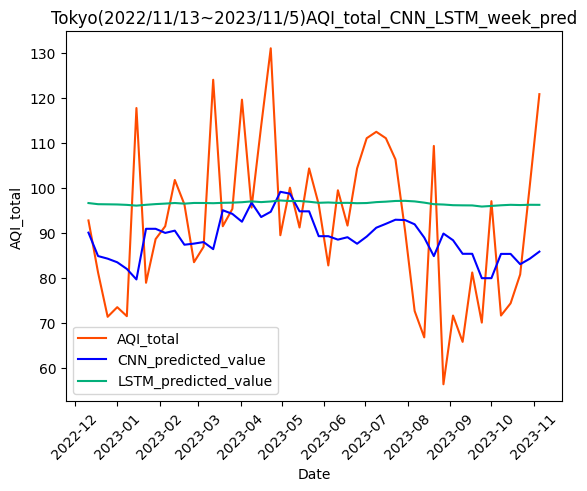

[I 2024-04-07 13:25:24,535] A new study created in memory with name: no-name-25b7cad7-a38e-4872-9106-31cc66c44871
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:25:31,468] Trial 0 finished with value: 0.0156562001643748 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.030331186272210098}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:25:33,666] Trial 1 finished with value: 0.016918637753318186 and parameters: {'num_conv_layers': 1, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.09844106076068032}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:25:36,308] Trial 2 finished with value: 0.016873205322728232 and parameters: {'num_conv_layers': 1, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 52, 'dropout_rate': 0.32041670763763863}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:25:38,301] Trial 3 finished with value: 0.017275326084414913 and parameters: {'num_conv_layers': 1, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 73, 'dropout_rate': 0.2861555714808274}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:25:40,380] Trial 4 finished with value: 0.018020578250591678 and parameters: {'num_conv_layers': 1, 'conv_filters': 17, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.4208341863674117}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 12ms/step


[I 2024-04-07 13:25:43,547] Trial 5 finished with value: 0.01646251984139514 and parameters: {'num_conv_layers': 2, 'conv_filters': 59, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 53, 'dropout_rate': 0.41168569625425455}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:25:46,537] Trial 6 finished with value: 0.01711024982067653 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.3634976552082608}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:25:48,890] Trial 7 finished with value: 0.016863593883433173 and parameters: {'num_conv_layers': 2, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 37, 'dropout_rate': 0.3733436930293085}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:25:50,999] Trial 8 finished with value: 0.016562376773291004 and parameters: {'num_conv_layers': 1, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 40, 'dropout_rate': 0.24393223248862383}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:25:53,433] Trial 9 finished with value: 0.016995018562422946 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.1681725338233464}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:25:56,644] Trial 10 finished with value: 0.019238819607593594 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 67, 'dropout_rate': 0.008202213148743864}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:25:59,414] Trial 11 finished with value: 0.01700095231249554 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 55, 'dropout_rate': 0.48354367212064303}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:26:01,516] Trial 12 finished with value: 0.016577948064042912 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 33, 'dropout_rate': 0.197490242786072}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:26:05,486] Trial 13 finished with value: 0.015770990647279663 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.0137439076548026}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:26:07,993] Trial 14 finished with value: 0.017230712096094808 and parameters: {'num_conv_layers': 1, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.036103750765163305}. Best is trial 0 with value: 0.0156562001643748.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:26:12,027] Trial 15 finished with value: 0.014651679385811111 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.09683432292005795}. Best is trial 15 with value: 0.014651679385811111.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:26:14,690] Trial 16 finished with value: 0.01735652797469667 and parameters: {'num_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 47, 'dropout_rate': 0.12569493522994482}. Best is trial 15 with value: 0.014651679385811111.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 13:26:17,877] Trial 17 finished with value: 0.0168487309266496 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 46, 'dropout_rate': 0.08139252448000014}. Best is trial 15 with value: 0.014651679385811111.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:26:20,283] Trial 18 finished with value: 0.01603835977252582 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 40, 'dropout_rate': 0.15938749225380316}. Best is trial 15 with value: 0.014651679385811111.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:26:23,920] Trial 19 finished with value: 0.016736605060811687 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 32, 'dropout_rate': 0.06087106117566925}. Best is trial 15 with value: 0.014651679385811111.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.09683432292005795}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 5s - loss: 0.2916 - mae: 0.5243

5/5 [==============================] - 1s 6ms/step - loss: 0.2670 - mae: 0.4920
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1709 - mae: 0.3913

5/5 [==============================] - 0s 7ms/step - loss: 0.1575 - mae: 0.3677
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0949 - mae: 0.2554

5/5 [==============================] - 0s 7ms/step - loss: 0.0648 - mae: 0.2054
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0291 - mae: 0.1279

5/5 [==============================] - 0s 7ms/step - loss: 0.0360 - mae: 0.1549
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0393 - mae: 0.1638

5/5 [==============================] - 0s 6ms/step - loss: 0.0503 - mae: 0.1892
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0259 - mae: 0.1279

5/5 [==============================] - 0s 7ms/step - loss: 0.0315 - mae: 0.1433
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0266 - mae: 0.1327

5/5 [==============================] - 0s 7ms/step - loss: 0.0311 - mae: 0.1355
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1363

5/5 [==============================] - 0s 7ms/step - loss: 0.0336 - mae: 0.1493
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0374 - mae: 0.1604

5/5 [==============================] - 0s 6ms/step - loss: 0.0301 - mae: 0.1365
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0330 - mae: 0.1450

5/5 [==============================] - 0s 8ms/step - loss: 0.0303 - mae: 0.1381
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1202

5/5 [==============================] - 0s 6ms/step - loss: 0.0282 - mae: 0.1327
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0265 - mae: 0.1315

5/5 [==============================] - 0s 8ms/step - loss: 0.0291 - mae: 0.1350
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0323 - mae: 0.1472

5/5 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1320
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0284 - mae: 0.1328

5/5 [==============================] - 0s 7ms/step - loss: 0.0262 - mae: 0.1270
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0332 - mae: 0.1353

5/5 [==============================] - 0s 8ms/step - loss: 0.0299 - mae: 0.1349
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1352

5/5 [==============================] - 0s 7ms/step - loss: 0.0285 - mae: 0.1375
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0410 - mae: 0.1616

5/5 [==============================] - 0s 8ms/step - loss: 0.0308 - mae: 0.1368
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0961

5/5 [==============================] - 0s 7ms/step - loss: 0.0268 - mae: 0.1277
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0352 - mae: 0.1638

5/5 [==============================] - 0s 7ms/step - loss: 0.0309 - mae: 0.1377
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0287 - mae: 0.1431

5/5 [==============================] - 0s 6ms/step - loss: 0.0295 - mae: 0.1374
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0280 - mae: 0.1266

5/5 [==============================] - 0s 6ms/step - loss: 0.0269 - mae: 0.1282
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0937

5/5 [==============================] - 0s 7ms/step - loss: 0.0249 - mae: 0.1228
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0328 - mae: 0.1418

5/5 [==============================] - 0s 7ms/step - loss: 0.0262 - mae: 0.1290
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0321 - mae: 0.1488

5/5 [==============================] - 0s 7ms/step - loss: 0.0252 - mae: 0.1236
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0318 - mae: 0.1453

5/5 [==============================] - 0s 8ms/step - loss: 0.0288 - mae: 0.1297
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0311 - mae: 0.1307

5/5 [==============================] - 0s 10ms/step - loss: 0.0252 - mae: 0.1232
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0366 - mae: 0.1468

5/5 [==============================] - 0s 7ms/step - loss: 0.0265 - mae: 0.1303
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1264

5/5 [==============================] - 0s 8ms/step - loss: 0.0246 - mae: 0.1230
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0315 - mae: 0.1294

5/5 [==============================] - 0s 8ms/step - loss: 0.0268 - mae: 0.1278
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0455 - mae: 0.1616

5/5 [==============================] - 0s 7ms/step - loss: 0.0302 - mae: 0.1369
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1259

5/5 [==============================] - 0s 7ms/step - loss: 0.0243 - mae: 0.1230
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0381 - mae: 0.1437

5/5 [==============================] - 0s 7ms/step - loss: 0.0278 - mae: 0.1308
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0257 - mae: 0.1273

5/5 [==============================] - 0s 7ms/step - loss: 0.0245 - mae: 0.1243
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0169 - mae: 0.1058

5/5 [==============================] - 0s 9ms/step - loss: 0.0264 - mae: 0.1261
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1280

5/5 [==============================] - 0s 8ms/step - loss: 0.0269 - mae: 0.1266
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0259 - mae: 0.1221

5/5 [==============================] - 0s 7ms/step - loss: 0.0245 - mae: 0.1211
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0344 - mae: 0.1481

5/5 [==============================] - 0s 7ms/step - loss: 0.0248 - mae: 0.1269
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0293 - mae: 0.1291

5/5 [==============================] - 0s 7ms/step - loss: 0.0272 - mae: 0.1293
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0261 - mae: 0.1305

5/5 [==============================] - 0s 6ms/step - loss: 0.0259 - mae: 0.1246
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0162 - mae: 0.1001

5/5 [==============================] - 0s 7ms/step - loss: 0.0269 - mae: 0.1284
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0217 - mae: 0.1150

5/5 [==============================] - 0s 7ms/step - loss: 0.0228 - mae: 0.1211
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0323 - mae: 0.1418

5/5 [==============================] - 0s 6ms/step - loss: 0.0221 - mae: 0.1162
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0355 - mae: 0.1420

5/5 [==============================] - 0s 7ms/step - loss: 0.0280 - mae: 0.1303
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0347 - mae: 0.1590

5/5 [==============================] - 0s 7ms/step - loss: 0.0261 - mae: 0.1293
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0375 - mae: 0.1518

5/5 [==============================] - 0s 7ms/step - loss: 0.0256 - mae: 0.1215
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0230 - mae: 0.1216

5/5 [==============================] - 0s 7ms/step - loss: 0.0226 - mae: 0.1192
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0290 - mae: 0.1446

5/5 [==============================] - 0s 8ms/step - loss: 0.0241 - mae: 0.1251
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0333 - mae: 0.1552

5/5 [==============================] - 0s 9ms/step - loss: 0.0263 - mae: 0.1303
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0313 - mae: 0.1469

5/5 [==============================] - 0s 8ms/step - loss: 0.0242 - mae: 0.1227
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0229 - mae: 0.1263

2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:26:27,750] A new study created in memory with name: no-name-896b9a09-977c-4468-b5c0-64338e99c534
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.0149


[I 2024-04-07 13:26:37,163] Trial 0 finished with value: 0.014883384108543396 and parameters: {'n_lstm_layers': 2, 'units_0': 88, 'units_1': 36, 'dropout_rate': 0.05644251976789699, 'learning_rate': 0.0013736352058610914}. Best is trial 0 with value: 0.014883384108543396.


2/2 [==============================] - 0s 10ms/step - loss: 0.1886


[I 2024-04-07 13:26:44,801] Trial 1 finished with value: 0.18861420452594757 and parameters: {'n_lstm_layers': 1, 'units_0': 92, 'dropout_rate': 0.000153761676138231, 'learning_rate': 1.9267536536493813e-05}. Best is trial 0 with value: 0.014883384108543396.


2/2 [==============================] - 0s 10ms/step - loss: 0.0147


[I 2024-04-07 13:26:52,830] Trial 2 finished with value: 0.014655794017016888 and parameters: {'n_lstm_layers': 1, 'units_0': 65, 'dropout_rate': 0.1746292762574716, 'learning_rate': 0.005006781513987835}. Best is trial 2 with value: 0.014655794017016888.


2/2 [==============================] - 0s 13ms/step - loss: 0.0394


[I 2024-04-07 13:27:08,102] Trial 3 finished with value: 0.03936761990189552 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 65, 'units_2': 77, 'dropout_rate': 0.03755185360663332, 'learning_rate': 3.170873489469374e-05}. Best is trial 2 with value: 0.014655794017016888.


2/2 [==============================] - 0s 13ms/step - loss: 0.0141


[I 2024-04-07 13:27:20,080] Trial 4 finished with value: 0.014112879522144794 and parameters: {'n_lstm_layers': 3, 'units_0': 49, 'units_1': 52, 'units_2': 41, 'dropout_rate': 0.04428341797262264, 'learning_rate': 0.003090294779944614}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 12ms/step - loss: 0.0156


[I 2024-04-07 13:27:30,819] Trial 5 finished with value: 0.015584592707455158 and parameters: {'n_lstm_layers': 2, 'units_0': 62, 'units_1': 59, 'dropout_rate': 0.33797801231709307, 'learning_rate': 9.75019515148535e-05}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 10ms/step - loss: 0.0151


[I 2024-04-07 13:27:37,327] Trial 6 finished with value: 0.015091832727193832 and parameters: {'n_lstm_layers': 2, 'units_0': 66, 'units_1': 75, 'dropout_rate': 0.33969395712140205, 'learning_rate': 0.0006371028740528874}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 11ms/step - loss: 0.0151


[I 2024-04-07 13:27:56,425] Trial 7 finished with value: 0.015054218471050262 and parameters: {'n_lstm_layers': 3, 'units_0': 73, 'units_1': 99, 'units_2': 91, 'dropout_rate': 0.360559780505821, 'learning_rate': 4.983555913216339e-05}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 15ms/step - loss: 0.1580


[I 2024-04-07 13:28:07,052] Trial 8 finished with value: 0.15801174938678741 and parameters: {'n_lstm_layers': 2, 'units_0': 43, 'units_1': 100, 'dropout_rate': 0.0922666817117041, 'learning_rate': 2.0861594034784855e-05}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 12ms/step - loss: 0.0144


[I 2024-04-07 13:28:18,941] Trial 9 finished with value: 0.014350969344377518 and parameters: {'n_lstm_layers': 3, 'units_0': 53, 'units_1': 22, 'units_2': 59, 'dropout_rate': 0.45938924024408456, 'learning_rate': 0.00044664379464793294}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 10ms/step - loss: 0.0143


[I 2024-04-07 13:28:29,975] Trial 10 finished with value: 0.014303188771009445 and parameters: {'n_lstm_layers': 3, 'units_0': 22, 'units_1': 46, 'units_2': 20, 'dropout_rate': 0.1850486665726728, 'learning_rate': 0.0058931036229178824}. Best is trial 4 with value: 0.014112879522144794.


2/2 [==============================] - 0s 10ms/step - loss: 0.0140


[I 2024-04-07 13:28:39,852] Trial 11 finished with value: 0.013967852108180523 and parameters: {'n_lstm_layers': 3, 'units_0': 22, 'units_1': 46, 'units_2': 21, 'dropout_rate': 0.1865309879971096, 'learning_rate': 0.009305810094630914}. Best is trial 11 with value: 0.013967852108180523.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-07 13:28:52,730] Trial 12 finished with value: 0.01393474917858839 and parameters: {'n_lstm_layers': 3, 'units_0': 21, 'units_1': 40, 'units_2': 24, 'dropout_rate': 0.15498800907195295, 'learning_rate': 0.009813449408457764}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-07 13:29:03,155] Trial 13 finished with value: 0.013937879353761673 and parameters: {'n_lstm_layers': 3, 'units_0': 21, 'units_1': 34, 'units_2': 22, 'dropout_rate': 0.2162206033217847, 'learning_rate': 0.008503042897646858}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 12ms/step - loss: 0.0141


[I 2024-04-07 13:29:15,844] Trial 14 finished with value: 0.014142134226858616 and parameters: {'n_lstm_layers': 3, 'units_0': 35, 'units_1': 23, 'units_2': 41, 'dropout_rate': 0.248254142525987, 'learning_rate': 0.002005286471461504}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 8ms/step - loss: 0.0163


[I 2024-04-07 13:29:22,144] Trial 15 finished with value: 0.016259856522083282 and parameters: {'n_lstm_layers': 2, 'units_0': 30, 'units_1': 36, 'dropout_rate': 0.12661880111249263, 'learning_rate': 0.0010042862460313785}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 26ms/step - loss: 0.0147


[I 2024-04-07 13:29:40,781] Trial 16 finished with value: 0.014744625426828861 and parameters: {'n_lstm_layers': 3, 'units_0': 35, 'units_1': 36, 'units_2': 36, 'dropout_rate': 0.25569216970813347, 'learning_rate': 0.00014933573351038774}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 7ms/step - loss: 0.0147


[I 2024-04-07 13:29:45,980] Trial 17 finished with value: 0.01474617887288332 and parameters: {'n_lstm_layers': 1, 'units_0': 21, 'dropout_rate': 0.2521617608358594, 'learning_rate': 0.009283733812014628}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 12ms/step - loss: 0.0147


[I 2024-04-07 13:29:57,130] Trial 18 finished with value: 0.014749392867088318 and parameters: {'n_lstm_layers': 3, 'units_0': 42, 'units_1': 30, 'units_2': 58, 'dropout_rate': 0.13971600966200207, 'learning_rate': 0.00023451798730154188}. Best is trial 12 with value: 0.01393474917858839.


2/2 [==============================] - 0s 13ms/step - loss: 0.0143


[I 2024-04-07 13:30:07,999] Trial 19 finished with value: 0.014290803112089634 and parameters: {'n_lstm_layers': 2, 'units_0': 30, 'units_1': 77, 'dropout_rate': 0.28307125379182607, 'learning_rate': 0.0032159072675524833}. Best is trial 12 with value: 0.01393474917858839.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 21, 'units_1': 40, 'units_2': 24, 'dropout_rate': 0.15498800907195295, 'learning_rate': 0.009813449408457764}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.1705 

5/5 [==============================] - 6s 15ms/step - loss: 0.1705
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0342

5/5 [==============================] - 0s 17ms/step - loss: 0.0342
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0360

5/5 [==============================] - 0s 20ms/step - loss: 0.0343
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 16ms/step - loss: 0.0260
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0209

5/5 [==============================] - 0s 13ms/step - loss: 0.0240
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 16ms/step - loss: 0.0247
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 16ms/step - loss: 0.0241
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 19ms/step - loss: 0.0243
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 15ms/step - loss: 0.0238
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 16ms/step - loss: 0.0241
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 19ms/step - loss: 0.0243
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 14ms/step - loss: 0.0246
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 15ms/step - loss: 0.0243
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 16ms/step - loss: 0.0249
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 21ms/step - loss: 0.0239
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 15ms/step - loss: 0.0247
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 16ms/step - loss: 0.0244
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 19ms/step - loss: 0.0247
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 18ms/step - loss: 0.0250
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 16ms/step - loss: 0.0245
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 15ms/step - loss: 0.0241
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 17ms/step - loss: 0.0246
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 16ms/step - loss: 0.0241
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 16ms/step - loss: 0.0238
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 18ms/step - loss: 0.0240
Epoch 26/50
3/5 [=================>............] - ETA: 0s - loss: 0.0286

5/5 [==============================] - 0s 26ms/step - loss: 0.0249
Epoch 27/50
3/5 [=================>............] - ETA: 0s - loss: 0.0252

5/5 [==============================] - 0s 25ms/step - loss: 0.0253
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 23ms/step - loss: 0.0262
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 23ms/step - loss: 0.0234
Epoch 30/50
3/5 [=================>............] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 24ms/step - loss: 0.0258
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 22ms/step - loss: 0.0247
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 21ms/step - loss: 0.0242
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 23ms/step - loss: 0.0245
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 26ms/step - loss: 0.0242
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0223

5/5 [==============================] - 0s 21ms/step - loss: 0.0258
Epoch 36/50
3/5 [=================>............] - ETA: 0s - loss: 0.0288

5/5 [==============================] - 0s 27ms/step - loss: 0.0276
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0269

5/5 [==============================] - 0s 24ms/step - loss: 0.0260
Epoch 38/50
3/5 [=================>............] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 28ms/step - loss: 0.0260
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 23ms/step - loss: 0.0252
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 23ms/step - loss: 0.0240
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 25ms/step - loss: 0.0246
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 26ms/step - loss: 0.0247
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 22ms/step - loss: 0.0240
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 21ms/step - loss: 0.0243
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0204

5/5 [==============================] - 0s 20ms/step - loss: 0.0247
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0233

5/5 [==============================] - 0s 26ms/step - loss: 0.0238
Epoch 47/50
3/5 [=================>............] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 24ms/step - loss: 0.0253
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 22ms/step - loss: 0.0250
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 23ms/step - loss: 0.0250
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0253

2/2 [==============================] - 2s 10ms/step


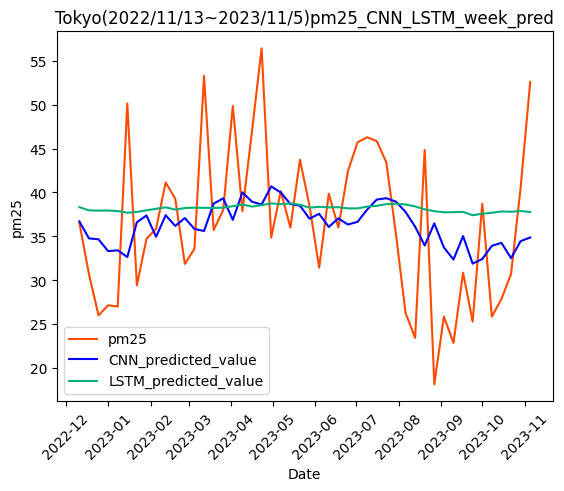

[I 2024-04-07 13:30:23,062] A new study created in memory with name: no-name-0486cc94-d65e-4f1d-bc8b-73b331d52f33
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:30:25,295] Trial 0 finished with value: 0.014685283568983418 and parameters: {'num_conv_layers': 1, 'conv_filters': 32, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.10551529659807524}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:27,339] Trial 1 finished with value: 0.014893286662919038 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 92, 'dropout_rate': 0.21425563556246247}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:30:29,717] Trial 2 finished with value: 0.014843201821063972 and parameters: {'num_conv_layers': 2, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.4182145748086316}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:34,355] Trial 3 finished with value: 0.014697125863348648 and parameters: {'num_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 88, 'dropout_rate': 0.22943964976253772}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 13:30:37,042] Trial 4 finished with value: 0.015238010318149193 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.4934326567106943}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:30:38,917] Trial 5 finished with value: 0.015128892266767146 and parameters: {'num_conv_layers': 1, 'conv_filters': 38, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 58, 'dropout_rate': 0.29592054824073566}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:41,305] Trial 6 finished with value: 0.01637056386004029 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.2206477426907716}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:43,440] Trial 7 finished with value: 0.015334212421640061 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 35, 'dropout_rate': 0.4592722734456107}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:30:45,109] Trial 8 finished with value: 0.015598989867463393 and parameters: {'num_conv_layers': 1, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 78, 'dropout_rate': 0.47777653000208514}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:30:48,533] Trial 9 finished with value: 0.014882259511149283 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 52, 'dropout_rate': 0.2289491837316669}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:30:50,655] Trial 10 finished with value: 0.01566654229609507 and parameters: {'num_conv_layers': 1, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 73, 'dropout_rate': 0.010357600324332805}. Best is trial 0 with value: 0.014685283568983418.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:30:53,430] Trial 11 finished with value: 0.014626956873222186 and parameters: {'num_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 81, 'dropout_rate': 0.08076610559485409}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:55,488] Trial 12 finished with value: 0.014963546410195731 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.052443459519937896}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:30:58,157] Trial 13 finished with value: 0.014752106869490508 and parameters: {'num_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 66, 'dropout_rate': 0.09220915695328924}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:31:01,304] Trial 14 finished with value: 0.01466863877976124 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.13393920356175895}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:31:03,715] Trial 15 finished with value: 0.015475291222025867 and parameters: {'num_conv_layers': 1, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.1359439559373057}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:31:07,975] Trial 16 finished with value: 0.015073329644787236 and parameters: {'num_conv_layers': 1, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.17715698410049485}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:31:10,849] Trial 17 finished with value: 0.015412526987694866 and parameters: {'num_conv_layers': 1, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 83, 'dropout_rate': 0.323006504111808}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:31:14,033] Trial 18 finished with value: 0.015205697589715529 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.0005201131227706435}. Best is trial 11 with value: 0.014626956873222186.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:31:16,708] Trial 19 finished with value: 0.015234989476483435 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 66, 'dropout_rate': 0.15365416590490555}. Best is trial 11 with value: 0.014626956873222186.


Best Hyperparameters: {'num_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 81, 'dropout_rate': 0.08076610559485409}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 4s - loss: 0.1277 - mae: 0.3236

5/5 [==============================] - 1s 6ms/step - loss: 0.1041 - mae: 0.2750
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0678 - mae: 0.2087

5/5 [==============================] - 0s 7ms/step - loss: 0.0506 - mae: 0.1643
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0265 - mae: 0.1112

5/5 [==============================] - 0s 6ms/step - loss: 0.0277 - mae: 0.1162
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - mae: 0.1333

5/5 [==============================] - 0s 7ms/step - loss: 0.0321 - mae: 0.1436
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0435 - mae: 0.1700

5/5 [==============================] - 0s 7ms/step - loss: 0.0302 - mae: 0.1396
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1329

5/5 [==============================] - 0s 8ms/step - loss: 0.0287 - mae: 0.1275
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.1000

5/5 [==============================] - 0s 7ms/step - loss: 0.0279 - mae: 0.1163
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183 - mae: 0.1064

5/5 [==============================] - 0s 7ms/step - loss: 0.0269 - mae: 0.1162
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0127 - mae: 0.0839

5/5 [==============================] - 0s 10ms/step - loss: 0.0264 - mae: 0.1167
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0194 - mae: 0.1020

5/5 [==============================] - 0s 7ms/step - loss: 0.0280 - mae: 0.1231
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216 - mae: 0.1128

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1217
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1076

5/5 [==============================] - 0s 9ms/step - loss: 0.0276 - mae: 0.1228
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - mae: 0.1160

5/5 [==============================] - 0s 8ms/step - loss: 0.0269 - mae: 0.1186
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0391 - mae: 0.1358

5/5 [==============================] - 0s 7ms/step - loss: 0.0262 - mae: 0.1186
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0186 - mae: 0.1099

5/5 [==============================] - 0s 7ms/step - loss: 0.0264 - mae: 0.1164
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0249 - mae: 0.1056

5/5 [==============================] - 0s 7ms/step - loss: 0.0260 - mae: 0.1159
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0276 - mae: 0.1371

5/5 [==============================] - 0s 7ms/step - loss: 0.0257 - mae: 0.1180
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0444 - mae: 0.1434

5/5 [==============================] - 0s 8ms/step - loss: 0.0265 - mae: 0.1202
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1105

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1206
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0222 - mae: 0.1203

5/5 [==============================] - 0s 5ms/step - loss: 0.0259 - mae: 0.1215
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0363 - mae: 0.1449

5/5 [==============================] - 0s 6ms/step - loss: 0.0262 - mae: 0.1200
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299 - mae: 0.1330

5/5 [==============================] - 0s 6ms/step - loss: 0.0262 - mae: 0.1195
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0371 - mae: 0.1385

5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.1198
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183 - mae: 0.1121

5/5 [==============================] - 0s 5ms/step - loss: 0.0252 - mae: 0.1178
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0369 - mae: 0.1393

5/5 [==============================] - 0s 6ms/step - loss: 0.0257 - mae: 0.1200
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1133

5/5 [==============================] - 0s 8ms/step - loss: 0.0255 - mae: 0.1173
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0143 - mae: 0.1015

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1195
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0383 - mae: 0.1356

5/5 [==============================] - 0s 6ms/step - loss: 0.0260 - mae: 0.1223
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0409 - mae: 0.1445

5/5 [==============================] - 0s 6ms/step - loss: 0.0246 - mae: 0.1176
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0349 - mae: 0.1369

5/5 [==============================] - 0s 6ms/step - loss: 0.0268 - mae: 0.1232
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1176

5/5 [==============================] - 0s 6ms/step - loss: 0.0254 - mae: 0.1179
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0471 - mae: 0.1610

5/5 [==============================] - 0s 6ms/step - loss: 0.0269 - mae: 0.1219
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0310 - mae: 0.1307

5/5 [==============================] - 0s 8ms/step - loss: 0.0264 - mae: 0.1203
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.1124

5/5 [==============================] - 0s 6ms/step - loss: 0.0254 - mae: 0.1190
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0319 - mae: 0.1241

5/5 [==============================] - 0s 7ms/step - loss: 0.0261 - mae: 0.1217
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0125 - mae: 0.0886

5/5 [==============================] - 0s 8ms/step - loss: 0.0238 - mae: 0.1128
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244 - mae: 0.1075

5/5 [==============================] - 0s 7ms/step - loss: 0.0256 - mae: 0.1177
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1149

5/5 [==============================] - 0s 8ms/step - loss: 0.0260 - mae: 0.1200
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1332

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1212
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0229 - mae: 0.1212

5/5 [==============================] - 0s 6ms/step - loss: 0.0249 - mae: 0.1171
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0211 - mae: 0.1027

5/5 [==============================] - 0s 6ms/step - loss: 0.0259 - mae: 0.1189
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0362 - mae: 0.1272

5/5 [==============================] - 0s 8ms/step - loss: 0.0262 - mae: 0.1224
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0223 - mae: 0.1178

5/5 [==============================] - 0s 8ms/step - loss: 0.0250 - mae: 0.1186
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0351 - mae: 0.1293

5/5 [==============================] - 0s 6ms/step - loss: 0.0257 - mae: 0.1184
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0265 - mae: 0.1303

5/5 [==============================] - 0s 6ms/step - loss: 0.0251 - mae: 0.1236
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0286 - mae: 0.1197

5/5 [==============================] - 0s 7ms/step - loss: 0.0253 - mae: 0.1188
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - mae: 0.0916

5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.1153
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0368 - mae: 0.1356

5/5 [==============================] - 0s 6ms/step - loss: 0.0262 - mae: 0.1200
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1226

5/5 [==============================] - 0s 7ms/step - loss: 0.0243 - mae: 0.1161
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0340 - mae: 0.1304

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:31:20,743] A new study created in memory with name: no-name-c67bf2a8-774a-4960-9c9a-aa36caa39d7d
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 13ms/step - loss: 0.0151


[I 2024-04-07 13:31:33,025] Trial 0 finished with value: 0.015108908526599407 and parameters: {'n_lstm_layers': 3, 'units_0': 87, 'units_1': 56, 'units_2': 33, 'dropout_rate': 0.361819483995254, 'learning_rate': 0.0004755604645041343}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 11ms/step - loss: 0.0717


[I 2024-04-07 13:31:47,278] Trial 1 finished with value: 0.07169661670923233 and parameters: {'n_lstm_layers': 1, 'units_0': 38, 'dropout_rate': 0.19400398148582576, 'learning_rate': 2.5615314938911787e-05}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 9ms/step - loss: 0.0177


[I 2024-04-07 13:31:55,412] Trial 2 finished with value: 0.01766943745315075 and parameters: {'n_lstm_layers': 1, 'units_0': 91, 'dropout_rate': 0.3311567133007388, 'learning_rate': 0.00036065225147303965}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 8ms/step - loss: 0.0186


[I 2024-04-07 13:32:03,043] Trial 3 finished with value: 0.018552424386143684 and parameters: {'n_lstm_layers': 1, 'units_0': 27, 'dropout_rate': 0.38442739963035455, 'learning_rate': 0.0005557796833036377}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 12ms/step - loss: 0.0153


[I 2024-04-07 13:32:10,089] Trial 4 finished with value: 0.015257477760314941 and parameters: {'n_lstm_layers': 2, 'units_0': 82, 'units_1': 79, 'dropout_rate': 0.3288212505531389, 'learning_rate': 0.0064113714739923115}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 10ms/step - loss: 0.0153


[I 2024-04-07 13:32:27,980] Trial 5 finished with value: 0.01526033878326416 and parameters: {'n_lstm_layers': 3, 'units_0': 47, 'units_1': 82, 'units_2': 41, 'dropout_rate': 0.3026028211815577, 'learning_rate': 0.00018548679906115132}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 9ms/step - loss: 0.0164


[I 2024-04-07 13:32:35,592] Trial 6 finished with value: 0.016386885195970535 and parameters: {'n_lstm_layers': 1, 'units_0': 76, 'dropout_rate': 0.13840787028595802, 'learning_rate': 0.0014777960329649027}. Best is trial 0 with value: 0.015108908526599407.


2/2 [==============================] - 0s 10ms/step - loss: 0.0148


[I 2024-04-07 13:32:45,013] Trial 7 finished with value: 0.014824416488409042 and parameters: {'n_lstm_layers': 2, 'units_0': 55, 'units_1': 28, 'dropout_rate': 0.2860988692803168, 'learning_rate': 0.000300249944645241}. Best is trial 7 with value: 0.014824416488409042.


2/2 [==============================] - 0s 12ms/step - loss: 0.0170


[I 2024-04-07 13:33:01,810] Trial 8 finished with value: 0.016972951591014862 and parameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 94, 'dropout_rate': 0.18855515997623779, 'learning_rate': 3.0296046149956052e-05}. Best is trial 7 with value: 0.014824416488409042.


2/2 [==============================] - 0s 8ms/step - loss: 0.0180


[I 2024-04-07 13:33:09,566] Trial 9 finished with value: 0.017981184646487236 and parameters: {'n_lstm_layers': 1, 'units_0': 98, 'dropout_rate': 0.49599519083515287, 'learning_rate': 0.00042564916179870156}. Best is trial 7 with value: 0.014824416488409042.


2/2 [==============================] - 0s 14ms/step - loss: 0.0151


[I 2024-04-07 13:33:20,451] Trial 10 finished with value: 0.015100013464689255 and parameters: {'n_lstm_layers': 2, 'units_0': 63, 'units_1': 22, 'dropout_rate': 0.02636166949326446, 'learning_rate': 7.54208556166788e-05}. Best is trial 7 with value: 0.014824416488409042.


2/2 [==============================] - 0s 12ms/step - loss: 0.0150


[I 2024-04-07 13:33:35,522] Trial 11 finished with value: 0.01500875037163496 and parameters: {'n_lstm_layers': 2, 'units_0': 62, 'units_1': 20, 'dropout_rate': 0.0036516752287508066, 'learning_rate': 7.935378759508413e-05}. Best is trial 7 with value: 0.014824416488409042.


2/2 [==============================] - 0s 12ms/step - loss: 0.0148


[I 2024-04-07 13:33:46,212] Trial 12 finished with value: 0.014783239923417568 and parameters: {'n_lstm_layers': 2, 'units_0': 60, 'units_1': 25, 'dropout_rate': 0.02714745431040827, 'learning_rate': 9.357900639658447e-05}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 12ms/step - loss: 0.0556


[I 2024-04-07 13:34:00,949] Trial 13 finished with value: 0.05561870336532593 and parameters: {'n_lstm_layers': 3, 'units_0': 50, 'units_1': 42, 'units_2': 98, 'dropout_rate': 0.09727140693336887, 'learning_rate': 1.205500501772735e-05}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 12ms/step - loss: 0.0150


[I 2024-04-07 13:34:10,396] Trial 14 finished with value: 0.014957725070416927 and parameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 38, 'dropout_rate': 0.23996675616678487, 'learning_rate': 0.002178958134003338}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 10ms/step - loss: 0.0150


[I 2024-04-07 13:34:19,935] Trial 15 finished with value: 0.014972721226513386 and parameters: {'n_lstm_layers': 2, 'units_0': 51, 'units_1': 34, 'dropout_rate': 0.43006758252061045, 'learning_rate': 0.0001405294352718704}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 11ms/step - loss: 0.0158


[I 2024-04-07 13:34:28,397] Trial 16 finished with value: 0.01579100452363491 and parameters: {'n_lstm_layers': 3, 'units_0': 20, 'units_1': 56, 'units_2': 84, 'dropout_rate': 0.26831016541929403, 'learning_rate': 0.0013127957745770022}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-07 13:34:41,217] Trial 17 finished with value: 0.015525584109127522 and parameters: {'n_lstm_layers': 2, 'units_0': 40, 'units_1': 31, 'dropout_rate': 0.1252266377114596, 'learning_rate': 6.206260607494365e-05}. Best is trial 12 with value: 0.014783239923417568.


2/2 [==============================] - 0s 12ms/step - loss: 0.0148


[I 2024-04-07 13:34:51,797] Trial 18 finished with value: 0.014760364778339863 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 45, 'dropout_rate': 0.23333589847154618, 'learning_rate': 0.00015456448485792987}. Best is trial 18 with value: 0.014760364778339863.


2/2 [==============================] - 0s 14ms/step - loss: 0.0211


[I 2024-04-07 13:35:08,731] Trial 19 finished with value: 0.02106308937072754 and parameters: {'n_lstm_layers': 3, 'units_0': 71, 'units_1': 46, 'units_2': 66, 'dropout_rate': 0.06432002199915393, 'learning_rate': 3.314300707792241e-05}. Best is trial 18 with value: 0.014760364778339863.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 45, 'dropout_rate': 0.23333589847154618, 'learning_rate': 0.00015456448485792987}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.1069 

5/5 [==============================] - 5s 15ms/step - loss: 0.1069
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.1007

5/5 [==============================] - 0s 15ms/step - loss: 0.1007
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0937

5/5 [==============================] - 0s 18ms/step - loss: 0.0937
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0866

5/5 [==============================] - 0s 15ms/step - loss: 0.0866
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0802

5/5 [==============================] - 0s 16ms/step - loss: 0.0802
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0731

5/5 [==============================] - 0s 15ms/step - loss: 0.0731
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0683

5/5 [==============================] - 0s 16ms/step - loss: 0.0683
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0622

5/5 [==============================] - 0s 15ms/step - loss: 0.0622
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0584

5/5 [==============================] - 0s 21ms/step - loss: 0.0560
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0509

5/5 [==============================] - 0s 17ms/step - loss: 0.0509
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0451

5/5 [==============================] - 0s 16ms/step - loss: 0.0451
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0417

5/5 [==============================] - 0s 15ms/step - loss: 0.0417
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0355

5/5 [==============================] - 0s 17ms/step - loss: 0.0355
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0338

5/5 [==============================] - 0s 16ms/step - loss: 0.0338
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.0313

5/5 [==============================] - 0s 17ms/step - loss: 0.0313
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0301

5/5 [==============================] - 0s 16ms/step - loss: 0.0301
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 16ms/step - loss: 0.0281
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0516

5/5 [==============================] - 0s 13ms/step - loss: 0.0278
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 15ms/step - loss: 0.0261
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0301

5/5 [==============================] - 0s 18ms/step - loss: 0.0300
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0224

5/5 [==============================] - 0s 20ms/step - loss: 0.0260
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0171

5/5 [==============================] - 0s 13ms/step - loss: 0.0283
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137

5/5 [==============================] - 0s 13ms/step - loss: 0.0268
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0272

5/5 [==============================] - 0s 16ms/step - loss: 0.0272
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 16ms/step - loss: 0.0281
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0407

5/5 [==============================] - 0s 13ms/step - loss: 0.0292
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 15ms/step - loss: 0.0280
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 17ms/step - loss: 0.0280
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0175

5/5 [==============================] - 0s 13ms/step - loss: 0.0264
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 13ms/step - loss: 0.0292
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0276

5/5 [==============================] - 0s 15ms/step - loss: 0.0276
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 14ms/step - loss: 0.0281
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0299

5/5 [==============================] - 0s 17ms/step - loss: 0.0299
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 18ms/step - loss: 0.0266
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 17ms/step - loss: 0.0263
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0276

5/5 [==============================] - 0s 18ms/step - loss: 0.0276
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0274

5/5 [==============================] - 0s 15ms/step - loss: 0.0274
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 17ms/step - loss: 0.0267
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 17ms/step - loss: 0.0267
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 15ms/step - loss: 0.0260
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 17ms/step - loss: 0.0256
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0284

5/5 [==============================] - 0s 15ms/step - loss: 0.0284
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 15ms/step - loss: 0.0266
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0273

5/5 [==============================] - 0s 15ms/step - loss: 0.0273
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0271

5/5 [==============================] - 0s 18ms/step - loss: 0.0271
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 16ms/step - loss: 0.0280
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 16ms/step - loss: 0.0280
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 19ms/step - loss: 0.0261
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0286

5/5 [==============================] - 0s 15ms/step - loss: 0.0286
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0268

2/2 [==============================] - 1s 7ms/step


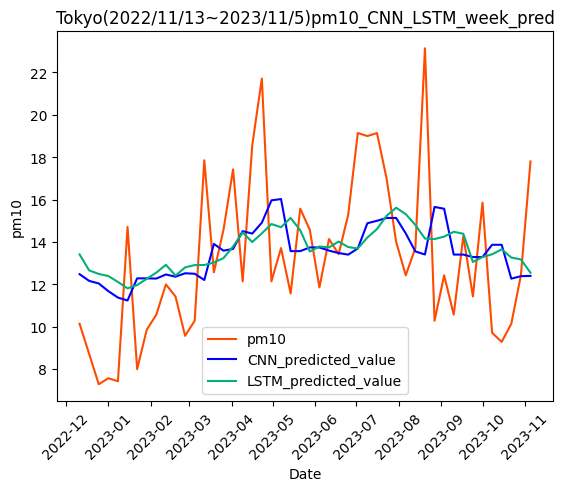

[I 2024-04-07 13:35:20,879] A new study created in memory with name: no-name-77152b2f-b5ef-4298-a4d2-a36b37a767ac
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:35:23,298] Trial 0 finished with value: 0.02149407475323822 and parameters: {'num_conv_layers': 1, 'conv_filters': 39, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.32783820687402276}. Best is trial 0 with value: 0.02149407475323822.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:35:26,195] Trial 1 finished with value: 0.021757740914124458 and parameters: {'num_conv_layers': 1, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 66, 'dropout_rate': 0.4607820641125306}. Best is trial 0 with value: 0.02149407475323822.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 13:35:32,801] Trial 2 finished with value: 0.017890891748789706 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.004671984872797241}. Best is trial 2 with value: 0.017890891748789706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:35:35,450] Trial 3 finished with value: 0.01845130551392361 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 96, 'dropout_rate': 0.09726121872975946}. Best is trial 2 with value: 0.017890891748789706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:35:37,381] Trial 4 finished with value: 0.01914235882809786 and parameters: {'num_conv_layers': 1, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 34, 'dropout_rate': 0.05016255519803753}. Best is trial 2 with value: 0.017890891748789706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:35:40,526] Trial 5 finished with value: 0.021062185404400986 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.26169810005000455}. Best is trial 2 with value: 0.017890891748789706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:35:43,666] Trial 6 finished with value: 0.01788181289795945 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 32, 'dropout_rate': 0.11831308605949353}. Best is trial 6 with value: 0.01788181289795945.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:35:47,859] Trial 7 finished with value: 0.025344224313687866 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 34, 'dropout_rate': 0.4837792010554468}. Best is trial 6 with value: 0.01788181289795945.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:35:54,917] Trial 8 finished with value: 0.018100387154828174 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.11619890855486609}. Best is trial 6 with value: 0.01788181289795945.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:35:56,901] Trial 9 finished with value: 0.021700069821893552 and parameters: {'num_conv_layers': 1, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 79, 'dropout_rate': 0.19492278457892792}. Best is trial 6 with value: 0.01788181289795945.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:35:59,903] Trial 10 finished with value: 0.020557862156514593 and parameters: {'num_conv_layers': 2, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 51, 'dropout_rate': 0.17926600234875498}. Best is trial 6 with value: 0.01788181289795945.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:36:03,142] Trial 11 finished with value: 0.017786755605489715 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 60, 'dropout_rate': 0.004717733372119258}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:36:07,427] Trial 12 finished with value: 0.018277682334072592 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 52, 'dropout_rate': 0.0016695505005963618}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:36:10,508] Trial 13 finished with value: 0.01785568203153297 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 50, 'dropout_rate': 0.1140763240278238}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:36:13,775] Trial 14 finished with value: 0.018564968189989355 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.068550528096672}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:36:17,809] Trial 15 finished with value: 0.017977802942602667 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 62, 'dropout_rate': 0.15739560434531116}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:36:20,337] Trial 16 finished with value: 0.01969198820498726 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 47, 'dropout_rate': 0.2645039032128809}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:36:22,643] Trial 17 finished with value: 0.020463645773637948 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 59, 'dropout_rate': 0.3487478939490948}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:36:26,606] Trial 18 finished with value: 0.017882050455296786 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 43, 'dropout_rate': 0.06115457629543697}. Best is trial 11 with value: 0.017786755605489715.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:36:29,344] Trial 19 finished with value: 0.018160973477567087 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 68, 'dropout_rate': 0.028237723324143704}. Best is trial 11 with value: 0.017786755605489715.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 60, 'dropout_rate': 0.004717733372119258}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 13s - loss: 0.1299 - mae: 0.3352

5/5 [==============================] - 4s 7ms/step - loss: 0.1152 - mae: 0.2951
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0544 - mae: 0.1908

5/5 [==============================] - 0s 7ms/step - loss: 0.0365 - mae: 0.1455
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0275 - mae: 0.1232

5/5 [==============================] - 0s 9ms/step - loss: 0.0310 - mae: 0.1386
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0373 - mae: 0.1468

5/5 [==============================] - 0s 7ms/step - loss: 0.0332 - mae: 0.1465
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0907

5/5 [==============================] - 0s 7ms/step - loss: 0.0232 - mae: 0.1120
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0231 - mae: 0.1197

5/5 [==============================] - 0s 8ms/step - loss: 0.0249 - mae: 0.1168
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0394 - mae: 0.1426

5/5 [==============================] - 0s 7ms/step - loss: 0.0240 - mae: 0.1148
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0346 - mae: 0.1419

5/5 [==============================] - 0s 7ms/step - loss: 0.0218 - mae: 0.1094
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0291 - mae: 0.1291

5/5 [==============================] - 0s 7ms/step - loss: 0.0225 - mae: 0.1127
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0147 - mae: 0.0962

5/5 [==============================] - 0s 7ms/step - loss: 0.0220 - mae: 0.1099
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1226

5/5 [==============================] - 0s 9ms/step - loss: 0.0215 - mae: 0.1085
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0173 - mae: 0.0964

5/5 [==============================] - 0s 8ms/step - loss: 0.0216 - mae: 0.1090
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0205 - mae: 0.1109

5/5 [==============================] - 0s 8ms/step - loss: 0.0215 - mae: 0.1084
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0259 - mae: 0.1295

5/5 [==============================] - 0s 7ms/step - loss: 0.0211 - mae: 0.1078
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0279 - mae: 0.1286

5/5 [==============================] - 0s 7ms/step - loss: 0.0212 - mae: 0.1084
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1110

5/5 [==============================] - 0s 8ms/step - loss: 0.0209 - mae: 0.1062
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0135 - mae: 0.0918

5/5 [==============================] - 0s 6ms/step - loss: 0.0203 - mae: 0.1052
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0286 - mae: 0.1263

5/5 [==============================] - 0s 7ms/step - loss: 0.0216 - mae: 0.1095
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0206 - mae: 0.1047

5/5 [==============================] - 0s 7ms/step - loss: 0.0205 - mae: 0.1069
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1212

5/5 [==============================] - 0s 6ms/step - loss: 0.0210 - mae: 0.1078
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1061

5/5 [==============================] - 0s 6ms/step - loss: 0.0206 - mae: 0.1064
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0283 - mae: 0.1351

5/5 [==============================] - 0s 6ms/step - loss: 0.0206 - mae: 0.1070
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0161 - mae: 0.0943

5/5 [==============================] - 0s 7ms/step - loss: 0.0209 - mae: 0.1085
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - mae: 0.0934

5/5 [==============================] - 0s 8ms/step - loss: 0.0208 - mae: 0.1078
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0300 - mae: 0.1249

5/5 [==============================] - 0s 8ms/step - loss: 0.0207 - mae: 0.1064
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0219 - mae: 0.1122

5/5 [==============================] - 0s 8ms/step - loss: 0.0208 - mae: 0.1074
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.1136

5/5 [==============================] - 0s 8ms/step - loss: 0.0207 - mae: 0.1073
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0249 - mae: 0.1194

5/5 [==============================] - 0s 7ms/step - loss: 0.0207 - mae: 0.1082
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0155 - mae: 0.0916

5/5 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.1057
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.1012

5/5 [==============================] - 0s 7ms/step - loss: 0.0208 - mae: 0.1073
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0963

5/5 [==============================] - 0s 8ms/step - loss: 0.0208 - mae: 0.1078
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0168 - mae: 0.0991

5/5 [==============================] - 0s 9ms/step - loss: 0.0204 - mae: 0.1069
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0213 - mae: 0.1206

5/5 [==============================] - 0s 9ms/step - loss: 0.0207 - mae: 0.1068
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - mae: 0.0916

5/5 [==============================] - 0s 8ms/step - loss: 0.0208 - mae: 0.1073
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0187 - mae: 0.1053

5/5 [==============================] - 0s 7ms/step - loss: 0.0201 - mae: 0.1060
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.1048

5/5 [==============================] - 0s 8ms/step - loss: 0.0211 - mae: 0.1093
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0180 - mae: 0.0990

5/5 [==============================] - 0s 7ms/step - loss: 0.0201 - mae: 0.1056
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0799

5/5 [==============================] - 0s 6ms/step - loss: 0.0208 - mae: 0.1067
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0836

5/5 [==============================] - 0s 7ms/step - loss: 0.0211 - mae: 0.1090
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1157

5/5 [==============================] - 0s 8ms/step - loss: 0.0204 - mae: 0.1065
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0219 - mae: 0.1110

5/5 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.1063
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0233 - mae: 0.1158

5/5 [==============================] - 0s 8ms/step - loss: 0.0201 - mae: 0.1060
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244 - mae: 0.1216

5/5 [==============================] - 0s 7ms/step - loss: 0.0203 - mae: 0.1062
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1100

5/5 [==============================] - 0s 8ms/step - loss: 0.0204 - mae: 0.1066
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1169

5/5 [==============================] - 0s 7ms/step - loss: 0.0198 - mae: 0.1050
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.0961

5/5 [==============================] - 0s 7ms/step - loss: 0.0203 - mae: 0.1067
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0160 - mae: 0.0976

5/5 [==============================] - 0s 6ms/step - loss: 0.0198 - mae: 0.1058
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - mae: 0.1040

5/5 [==============================] - 0s 7ms/step - loss: 0.0198 - mae: 0.1053
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0215 - mae: 0.1035

5/5 [==============================] - 0s 8ms/step - loss: 0.0197 - mae: 0.1057
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0168 - mae: 0.0929

2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:36:35,527] A new study created in memory with name: no-name-43c7c978-7f91-4baa-9f32-031d0e7c86fb
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 13ms/step - loss: 0.0828


[I 2024-04-07 13:36:51,569] Trial 0 finished with value: 0.08275312930345535 and parameters: {'n_lstm_layers': 3, 'units_0': 25, 'units_1': 66, 'units_2': 35, 'dropout_rate': 0.4910045632376431, 'learning_rate': 3.935702905232368e-05}. Best is trial 0 with value: 0.08275312930345535.


2/2 [==============================] - 0s 11ms/step - loss: 0.0797


[I 2024-04-07 13:37:04,266] Trial 1 finished with value: 0.07971080392599106 and parameters: {'n_lstm_layers': 1, 'units_0': 57, 'dropout_rate': 0.3082697508794733, 'learning_rate': 6.478633997268972e-05}. Best is trial 1 with value: 0.07971080392599106.


2/2 [==============================] - 0s 13ms/step - loss: 0.0182


[I 2024-04-07 13:37:18,272] Trial 2 finished with value: 0.018204279243946075 and parameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 42, 'dropout_rate': 0.0051120116604751464, 'learning_rate': 0.0001790772724441934}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 9ms/step - loss: 0.0563


[I 2024-04-07 13:37:26,147] Trial 3 finished with value: 0.05628575012087822 and parameters: {'n_lstm_layers': 1, 'units_0': 53, 'dropout_rate': 0.16725392628403196, 'learning_rate': 0.00010823473205435973}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 12ms/step - loss: 0.0196


[I 2024-04-07 13:37:36,690] Trial 4 finished with value: 0.019649283960461617 and parameters: {'n_lstm_layers': 3, 'units_0': 92, 'units_1': 74, 'units_2': 85, 'dropout_rate': 0.223576693258089, 'learning_rate': 0.00443490719675365}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 13ms/step - loss: 0.1866


[I 2024-04-07 13:37:55,391] Trial 5 finished with value: 0.18662309646606445 and parameters: {'n_lstm_layers': 3, 'units_0': 51, 'units_1': 28, 'units_2': 91, 'dropout_rate': 0.04539907540114452, 'learning_rate': 1.157391875109007e-05}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 17ms/step - loss: 0.0201


[I 2024-04-07 13:38:02,319] Trial 6 finished with value: 0.02010270394384861 and parameters: {'n_lstm_layers': 2, 'units_0': 83, 'units_1': 22, 'dropout_rate': 0.27846765389296535, 'learning_rate': 0.0006468478304882329}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 9ms/step - loss: 0.0287


[I 2024-04-07 13:38:09,738] Trial 7 finished with value: 0.028714537620544434 and parameters: {'n_lstm_layers': 1, 'units_0': 84, 'dropout_rate': 0.3696986662242928, 'learning_rate': 0.0005159127455570938}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 14ms/step - loss: 0.0239


[I 2024-04-07 13:38:23,628] Trial 8 finished with value: 0.023921966552734375 and parameters: {'n_lstm_layers': 3, 'units_0': 99, 'units_1': 23, 'units_2': 83, 'dropout_rate': 0.03569329205448818, 'learning_rate': 0.001029872133928742}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 10ms/step - loss: 0.1777


[I 2024-04-07 13:38:34,724] Trial 9 finished with value: 0.17768080532550812 and parameters: {'n_lstm_layers': 2, 'units_0': 28, 'units_1': 86, 'dropout_rate': 0.23905699797386493, 'learning_rate': 1.1465027069481323e-05}. Best is trial 2 with value: 0.018204279243946075.


2/2 [==============================] - 0s 10ms/step - loss: 0.0177


[I 2024-04-07 13:38:41,532] Trial 10 finished with value: 0.01768314279615879 and parameters: {'n_lstm_layers': 2, 'units_0': 39, 'units_1': 47, 'dropout_rate': 0.11398675531194918, 'learning_rate': 0.007174561427429733}. Best is trial 10 with value: 0.01768314279615879.


2/2 [==============================] - 0s 12ms/step - loss: 0.0175


[I 2024-04-07 13:38:50,649] Trial 11 finished with value: 0.017500508576631546 and parameters: {'n_lstm_layers': 2, 'units_0': 38, 'units_1': 47, 'dropout_rate': 0.10919690363233467, 'learning_rate': 0.008199479643427494}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 9ms/step - loss: 0.0179


[I 2024-04-07 13:39:00,059] Trial 12 finished with value: 0.017948878929018974 and parameters: {'n_lstm_layers': 2, 'units_0': 37, 'units_1': 52, 'dropout_rate': 0.12027081827986191, 'learning_rate': 0.007810009728818648}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 8ms/step - loss: 0.0195


[I 2024-04-07 13:39:07,325] Trial 13 finished with value: 0.019528571516275406 and parameters: {'n_lstm_layers': 2, 'units_0': 41, 'units_1': 47, 'dropout_rate': 0.12265599067024958, 'learning_rate': 0.0026521184372159425}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 8ms/step - loss: 0.0180


[I 2024-04-07 13:39:18,002] Trial 14 finished with value: 0.01795944571495056 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 40, 'dropout_rate': 0.10790074430617252, 'learning_rate': 0.0019929976845333296}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 7ms/step - loss: 0.0212


[I 2024-04-07 13:39:22,999] Trial 15 finished with value: 0.0212037805467844 and parameters: {'n_lstm_layers': 1, 'units_0': 40, 'dropout_rate': 0.16311065049672205, 'learning_rate': 0.009997771262515732}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 9ms/step - loss: 0.0177


[I 2024-04-07 13:39:32,879] Trial 16 finished with value: 0.017673911526799202 and parameters: {'n_lstm_layers': 2, 'units_0': 21, 'units_1': 60, 'dropout_rate': 0.06263505884848358, 'learning_rate': 0.001740953869261462}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 8ms/step - loss: 0.0208


[I 2024-04-07 13:39:42,981] Trial 17 finished with value: 0.020786676555871964 and parameters: {'n_lstm_layers': 1, 'units_0': 21, 'dropout_rate': 0.06545674189169706, 'learning_rate': 0.0024601348313307305}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 14ms/step - loss: 0.0223


[I 2024-04-07 13:39:53,888] Trial 18 finished with value: 0.022328270599246025 and parameters: {'n_lstm_layers': 3, 'units_0': 31, 'units_1': 63, 'units_2': 26, 'dropout_rate': 0.1792924464734841, 'learning_rate': 0.0012147194558792859}. Best is trial 11 with value: 0.017500508576631546.


2/2 [==============================] - 0s 9ms/step - loss: 0.0192


[I 2024-04-07 13:40:00,426] Trial 19 finished with value: 0.01921970583498478 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 98, 'dropout_rate': 0.4398449294628432, 'learning_rate': 0.0003171604308152121}. Best is trial 11 with value: 0.017500508576631546.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 38, 'units_1': 47, 'dropout_rate': 0.10919690363233467, 'learning_rate': 0.008199479643427494}
Epoch 1/50
1/5 [=====>........................] - ETA: 27s - loss: 0.2070

5/5 [==============================] - 7s 13ms/step - loss: 0.1018
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0347

5/5 [==============================] - 0s 15ms/step - loss: 0.0347
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0407

5/5 [==============================] - 0s 18ms/step - loss: 0.0407
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0329

5/5 [==============================] - 0s 20ms/step - loss: 0.0326
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0290

5/5 [==============================] - 0s 16ms/step - loss: 0.0290
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0290

5/5 [==============================] - 0s 18ms/step - loss: 0.0290
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0287

5/5 [==============================] - 0s 19ms/step - loss: 0.0287
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 17ms/step - loss: 0.0253
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 17ms/step - loss: 0.0270
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 17ms/step - loss: 0.0245
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0297

5/5 [==============================] - 0s 16ms/step - loss: 0.0297
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 20ms/step - loss: 0.0231
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 18ms/step - loss: 0.0264
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 18ms/step - loss: 0.0231
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 19ms/step - loss: 0.0269
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 15ms/step - loss: 0.0248
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201

5/5 [==============================] - 0s 13ms/step - loss: 0.0262
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0223

5/5 [==============================] - 0s 18ms/step - loss: 0.0228
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 15ms/step - loss: 0.0238
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 15ms/step - loss: 0.0254
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 15ms/step - loss: 0.0235
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 15ms/step - loss: 0.0250
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0259

5/5 [==============================] - 0s 14ms/step - loss: 0.0259
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 15ms/step - loss: 0.0247
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0272

5/5 [==============================] - 0s 15ms/step - loss: 0.0272
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0212

5/5 [==============================] - 0s 15ms/step - loss: 0.0212
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0223

5/5 [==============================] - 0s 15ms/step - loss: 0.0223
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 20ms/step - loss: 0.0221
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 15ms/step - loss: 0.0226
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0218

5/5 [==============================] - 0s 15ms/step - loss: 0.0218
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0274

5/5 [==============================] - 0s 14ms/step - loss: 0.0274
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 16ms/step - loss: 0.0255
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 16ms/step - loss: 0.0256
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 16ms/step - loss: 0.0244
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 15ms/step - loss: 0.0239
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 15ms/step - loss: 0.0236
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0214

5/5 [==============================] - 0s 16ms/step - loss: 0.0214
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 17ms/step - loss: 0.0232
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 15ms/step - loss: 0.0257
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0223

5/5 [==============================] - 0s 18ms/step - loss: 0.0223
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 18ms/step - loss: 0.0246
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 16ms/step - loss: 0.0231
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0209

5/5 [==============================] - 0s 16ms/step - loss: 0.0209
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 16ms/step - loss: 0.0237
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 17ms/step - loss: 0.0239
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 16ms/step - loss: 0.0202
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 16ms/step - loss: 0.0244
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 17ms/step - loss: 0.0221
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 17ms/step - loss: 0.0221
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0242

2/2 [==============================] - 1s 7ms/step


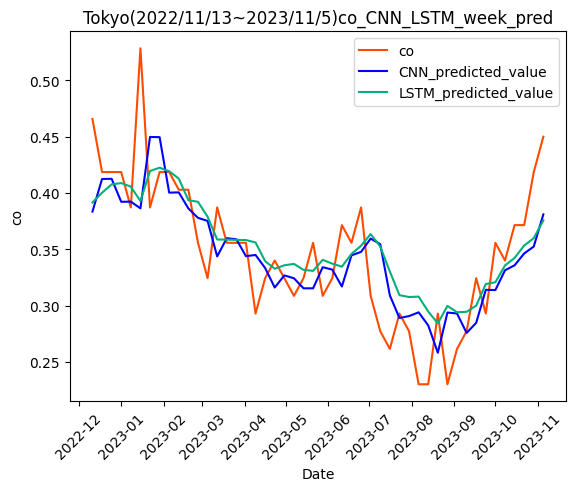

[I 2024-04-07 13:40:14,725] A new study created in memory with name: no-name-bc7eaac3-f80b-432a-943c-dd2876a1c2dd
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:18,013] Trial 0 finished with value: 0.012863297099972698 and parameters: {'num_conv_layers': 1, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.48371595214907925}. Best is trial 0 with value: 0.012863297099972698.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:22,284] Trial 1 finished with value: 0.01254170005457813 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 62, 'dropout_rate': 0.11268895941507079}. Best is trial 1 with value: 0.01254170005457813.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:26,238] Trial 2 finished with value: 0.012706981231443355 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.19784008940796333}. Best is trial 1 with value: 0.01254170005457813.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:40:32,984] Trial 3 finished with value: 0.011966559515662339 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.21930802209615424}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:34,824] Trial 4 finished with value: 0.013330264061512104 and parameters: {'num_conv_layers': 1, 'conv_filters': 31, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 48, 'dropout_rate': 0.15484001729152158}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:36,869] Trial 5 finished with value: 0.017227028144732467 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.2558475298704584}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:40:38,994] Trial 6 finished with value: 0.01221990114808672 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 89, 'dropout_rate': 0.1728407504280396}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:40:41,875] Trial 7 finished with value: 0.013375401663761334 and parameters: {'num_conv_layers': 1, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.1906778636623045}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:45,892] Trial 8 finished with value: 0.013790960146073316 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 62, 'dropout_rate': 0.0035404530669850276}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:47,725] Trial 9 finished with value: 0.014335772372638974 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.0600704727068998}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:40:50,734] Trial 10 finished with value: 0.014554359067834652 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 33, 'dropout_rate': 0.32076069785628725}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:40:55,201] Trial 11 finished with value: 0.012212138750265597 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 95, 'dropout_rate': 0.2995557488866648}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:40:59,058] Trial 12 finished with value: 0.012241310194825468 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.3481635011778903}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:41:02,052] Trial 13 finished with value: 0.012509674276577792 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.3858578894481568}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:41:05,575] Trial 14 finished with value: 0.012070096483375406 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 78, 'dropout_rate': 0.27658117350025574}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:41:08,628] Trial 15 finished with value: 0.012574693001018447 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 74, 'dropout_rate': 0.41091596338095887}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:41:13,337] Trial 16 finished with value: 0.012170416217858346 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 84, 'dropout_rate': 0.26234983158766806}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:41:15,994] Trial 17 finished with value: 0.012296695211352418 and parameters: {'num_conv_layers': 2, 'conv_filters': 52, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.23744316818420813}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:41:20,212] Trial 18 finished with value: 0.012028819895772083 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 84, 'dropout_rate': 0.11397095613238847}. Best is trial 3 with value: 0.011966559515662339.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:41:23,709] Trial 19 finished with value: 0.01816654664520808 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 87, 'dropout_rate': 0.09499926747727047}. Best is trial 3 with value: 0.011966559515662339.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.21930802209615424}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.1408 - mae: 0.3314

5/5 [==============================] - 1s 7ms/step - loss: 0.0997 - mae: 0.2687
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0805 - mae: 0.2338

5/5 [==============================] - 0s 7ms/step - loss: 0.0516 - mae: 0.1700
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0360 - mae: 0.1481

5/5 [==============================] - 0s 7ms/step - loss: 0.0269 - mae: 0.1258
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0403 - mae: 0.1484

5/5 [==============================] - 0s 8ms/step - loss: 0.0321 - mae: 0.1417
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0271 - mae: 0.1318

5/5 [==============================] - 0s 7ms/step - loss: 0.0295 - mae: 0.1347
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0289 - mae: 0.1344

5/5 [==============================] - 0s 7ms/step - loss: 0.0231 - mae: 0.1143
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0322 - mae: 0.1393

5/5 [==============================] - 0s 7ms/step - loss: 0.0262 - mae: 0.1182
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0392 - mae: 0.1314

5/5 [==============================] - 0s 6ms/step - loss: 0.0233 - mae: 0.1082
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.0976

5/5 [==============================] - 0s 7ms/step - loss: 0.0188 - mae: 0.1015
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0220 - mae: 0.1076

5/5 [==============================] - 0s 7ms/step - loss: 0.0223 - mae: 0.1085
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0232 - mae: 0.1091

5/5 [==============================] - 0s 7ms/step - loss: 0.0210 - mae: 0.1097
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0084 - mae: 0.0728

5/5 [==============================] - 0s 9ms/step - loss: 0.0237 - mae: 0.1126
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0108 - mae: 0.0831

5/5 [==============================] - 0s 7ms/step - loss: 0.0200 - mae: 0.1021
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0252 - mae: 0.1109

5/5 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.1061
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0350 - mae: 0.1348

5/5 [==============================] - 0s 6ms/step - loss: 0.0213 - mae: 0.1029
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0994

5/5 [==============================] - 0s 7ms/step - loss: 0.0206 - mae: 0.1042
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1111

5/5 [==============================] - 0s 10ms/step - loss: 0.0199 - mae: 0.1006
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - mae: 0.0757

5/5 [==============================] - 0s 6ms/step - loss: 0.0159 - mae: 0.0935
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0105 - mae: 0.0826

5/5 [==============================] - 0s 7ms/step - loss: 0.0184 - mae: 0.1019
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1009

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.0987
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - mae: 0.0961

5/5 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.0937
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - mae: 0.0835

5/5 [==============================] - 0s 7ms/step - loss: 0.0189 - mae: 0.1030
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0229 - mae: 0.1182

5/5 [==============================] - 0s 7ms/step - loss: 0.0189 - mae: 0.1071
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0151 - mae: 0.0857

5/5 [==============================] - 0s 8ms/step - loss: 0.0183 - mae: 0.0953
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - mae: 0.0663

5/5 [==============================] - 0s 8ms/step - loss: 0.0192 - mae: 0.0977
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0094 - mae: 0.0741

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0971
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0302 - mae: 0.1293

5/5 [==============================] - 0s 7ms/step - loss: 0.0206 - mae: 0.1022
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0125 - mae: 0.0882

5/5 [==============================] - 0s 7ms/step - loss: 0.0167 - mae: 0.0966
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0169 - mae: 0.1013

5/5 [==============================] - 0s 7ms/step - loss: 0.0160 - mae: 0.0936
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0131 - mae: 0.0880

5/5 [==============================] - 0s 8ms/step - loss: 0.0186 - mae: 0.1007
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0171 - mae: 0.0991

5/5 [==============================] - 0s 8ms/step - loss: 0.0167 - mae: 0.0970
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0161 - mae: 0.1027

5/5 [==============================] - 0s 8ms/step - loss: 0.0160 - mae: 0.0911
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0158 - mae: 0.0906

5/5 [==============================] - 0s 8ms/step - loss: 0.0153 - mae: 0.0914
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0165 - mae: 0.1003

5/5 [==============================] - 0s 7ms/step - loss: 0.0173 - mae: 0.0958
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0117 - mae: 0.0826

5/5 [==============================] - 0s 7ms/step - loss: 0.0182 - mae: 0.0985
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - mae: 0.0800

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0939
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1130

5/5 [==============================] - 0s 7ms/step - loss: 0.0167 - mae: 0.0947
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0118 - mae: 0.0788

5/5 [==============================] - 0s 8ms/step - loss: 0.0167 - mae: 0.0919
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0076 - mae: 0.0718

5/5 [==============================] - 0s 7ms/step - loss: 0.0157 - mae: 0.0929
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0186 - mae: 0.0992

5/5 [==============================] - 0s 7ms/step - loss: 0.0157 - mae: 0.0910
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263 - mae: 0.1116

5/5 [==============================] - 0s 7ms/step - loss: 0.0191 - mae: 0.1005
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - mae: 0.0793

5/5 [==============================] - 0s 6ms/step - loss: 0.0165 - mae: 0.0962
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0843

5/5 [==============================] - 0s 6ms/step - loss: 0.0181 - mae: 0.0964
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0069 - mae: 0.0589

5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - mae: 0.0954
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0087 - mae: 0.0725

5/5 [==============================] - 0s 6ms/step - loss: 0.0138 - mae: 0.0851
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0175 - mae: 0.0758

5/5 [==============================] - 0s 6ms/step - loss: 0.0149 - mae: 0.0891
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0188 - mae: 0.1004

5/5 [==============================] - 0s 6ms/step - loss: 0.0194 - mae: 0.1023
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0138 - mae: 0.0873

5/5 [==============================] - 0s 6ms/step - loss: 0.0180 - mae: 0.0982
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0106 - mae: 0.0776

5/5 [==============================] - 0s 7ms/step - loss: 0.0153 - mae: 0.0923
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0211 - mae: 0.1000

2/2 [==============================] - 0s 4ms/step


[I 2024-04-07 13:41:27,643] A new study created in memory with name: no-name-b1c4157a-d954-4876-9b9b-79bf038a4338
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 12ms/step - loss: 0.0890


[I 2024-04-07 13:41:40,274] Trial 0 finished with value: 0.0889577567577362 and parameters: {'n_lstm_layers': 2, 'units_0': 91, 'units_1': 30, 'dropout_rate': 0.47067871022158486, 'learning_rate': 1.034363344190413e-05}. Best is trial 0 with value: 0.0889577567577362.


2/2 [==============================] - 0s 8ms/step - loss: 0.0149


[I 2024-04-07 13:41:54,765] Trial 1 finished with value: 0.014893236570060253 and parameters: {'n_lstm_layers': 2, 'units_0': 75, 'units_1': 75, 'dropout_rate': 0.4852492755154484, 'learning_rate': 6.975025393454935e-05}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 13ms/step - loss: 0.0190


[I 2024-04-07 13:42:08,200] Trial 2 finished with value: 0.01902846433222294 and parameters: {'n_lstm_layers': 3, 'units_0': 46, 'units_1': 41, 'units_2': 74, 'dropout_rate': 0.21897396976622885, 'learning_rate': 0.002439029085148403}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 15ms/step - loss: 0.0150


[I 2024-04-07 13:42:15,856] Trial 3 finished with value: 0.015008904971182346 and parameters: {'n_lstm_layers': 2, 'units_0': 52, 'units_1': 29, 'dropout_rate': 0.010175708674719175, 'learning_rate': 0.0003836867491699685}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 8ms/step - loss: 0.0159


[I 2024-04-07 13:42:23,741] Trial 4 finished with value: 0.01592833362519741 and parameters: {'n_lstm_layers': 1, 'units_0': 44, 'dropout_rate': 0.06860703663074608, 'learning_rate': 0.0007044353379387258}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 11ms/step - loss: 0.0179


[I 2024-04-07 13:42:32,629] Trial 5 finished with value: 0.01794198900461197 and parameters: {'n_lstm_layers': 1, 'units_0': 24, 'dropout_rate': 0.2622861985149175, 'learning_rate': 0.0012745391788898043}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 8ms/step - loss: 0.0155


[I 2024-04-07 13:42:42,099] Trial 6 finished with value: 0.01547977700829506 and parameters: {'n_lstm_layers': 2, 'units_0': 29, 'units_1': 54, 'dropout_rate': 0.28289365638149144, 'learning_rate': 0.00011261711382431821}. Best is trial 1 with value: 0.014893236570060253.


2/2 [==============================] - 0s 11ms/step - loss: 0.0120


[I 2024-04-07 13:42:49,684] Trial 7 finished with value: 0.011973686516284943 and parameters: {'n_lstm_layers': 2, 'units_0': 23, 'units_1': 36, 'dropout_rate': 0.035774962813044764, 'learning_rate': 0.0030450290893608623}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 13ms/step - loss: 0.0182


[I 2024-04-07 13:43:02,571] Trial 8 finished with value: 0.018157457932829857 and parameters: {'n_lstm_layers': 3, 'units_0': 83, 'units_1': 29, 'units_2': 100, 'dropout_rate': 0.40373574552700003, 'learning_rate': 0.00039611760057712826}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-07 13:43:10,139] Trial 9 finished with value: 0.01550468523055315 and parameters: {'n_lstm_layers': 1, 'units_0': 35, 'dropout_rate': 0.016817698642500545, 'learning_rate': 0.0008974051584516977}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 19ms/step - loss: 0.0135


[I 2024-04-07 13:43:21,113] Trial 10 finished with value: 0.013529215008020401 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 86, 'units_2': 21, 'dropout_rate': 0.13382403347604796, 'learning_rate': 0.008994169747703569}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 11ms/step - loss: 0.0126


[I 2024-04-07 13:43:33,311] Trial 11 finished with value: 0.012639489956200123 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 100, 'units_2': 24, 'dropout_rate': 0.1314735775235401, 'learning_rate': 0.009128849270959565}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 11ms/step - loss: 0.0124


[I 2024-04-07 13:43:43,408] Trial 12 finished with value: 0.012417142279446125 and parameters: {'n_lstm_layers': 3, 'units_0': 60, 'units_1': 99, 'units_2': 21, 'dropout_rate': 0.13038488960270425, 'learning_rate': 0.009663707241083664}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 15ms/step - loss: 0.0122


[I 2024-04-07 13:43:55,740] Trial 13 finished with value: 0.012213359586894512 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 60, 'dropout_rate': 0.13946975360378733, 'learning_rate': 0.004062282704652524}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-07 13:44:05,199] Trial 14 finished with value: 0.013918532989919186 and parameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 60, 'dropout_rate': 0.1931384408303175, 'learning_rate': 0.003817027589172086}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 11ms/step - loss: 0.0154


[I 2024-04-07 13:44:11,073] Trial 15 finished with value: 0.015401501208543777 and parameters: {'n_lstm_layers': 2, 'units_0': 77, 'units_1': 48, 'dropout_rate': 0.06385498494496283, 'learning_rate': 0.0028502858149089816}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 8ms/step - loss: 0.0403


[I 2024-04-07 13:44:20,915] Trial 16 finished with value: 0.04032956063747406 and parameters: {'n_lstm_layers': 1, 'units_0': 21, 'dropout_rate': 0.3265002087133112, 'learning_rate': 0.00014173199706633605}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 10ms/step - loss: 0.0133


[I 2024-04-07 13:44:30,435] Trial 17 finished with value: 0.013301786966621876 and parameters: {'n_lstm_layers': 2, 'units_0': 91, 'units_1': 73, 'dropout_rate': 0.08535358435143392, 'learning_rate': 0.0019034874012427614}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 9ms/step - loss: 0.0151


[I 2024-04-07 13:44:35,445] Trial 18 finished with value: 0.01514244731515646 and parameters: {'n_lstm_layers': 1, 'units_0': 100, 'dropout_rate': 0.18695457781154118, 'learning_rate': 0.005290217178762817}. Best is trial 7 with value: 0.011973686516284943.


2/2 [==============================] - 0s 9ms/step - loss: 0.0896


[I 2024-04-07 13:44:46,194] Trial 19 finished with value: 0.08960622549057007 and parameters: {'n_lstm_layers': 2, 'units_0': 36, 'units_1': 42, 'dropout_rate': 0.15556885408474697, 'learning_rate': 1.9776172608488346e-05}. Best is trial 7 with value: 0.011973686516284943.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 23, 'units_1': 36, 'dropout_rate': 0.035774962813044764, 'learning_rate': 0.0030450290893608623}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.1207 

5/5 [==============================] - 5s 17ms/step - loss: 0.1207
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0385

5/5 [==============================] - 0s 20ms/step - loss: 0.0354
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 19ms/step - loss: 0.0298
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 20ms/step - loss: 0.0209
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 19ms/step - loss: 0.0213
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 0s 20ms/step - loss: 0.0211
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0177

5/5 [==============================] - 0s 15ms/step - loss: 0.0177
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 16ms/step - loss: 0.0192
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0167

5/5 [==============================] - 0s 15ms/step - loss: 0.0167
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0158

5/5 [==============================] - 0s 15ms/step - loss: 0.0158
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0165

5/5 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0166

5/5 [==============================] - 0s 15ms/step - loss: 0.0166
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0158

5/5 [==============================] - 0s 18ms/step - loss: 0.0150
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 21ms/step - loss: 0.0153
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0157

5/5 [==============================] - 0s 19ms/step - loss: 0.0163
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0097

5/5 [==============================] - 0s 13ms/step - loss: 0.0151
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0163

5/5 [==============================] - 0s 14ms/step - loss: 0.0163
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0170

5/5 [==============================] - 0s 17ms/step - loss: 0.0170
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0158

5/5 [==============================] - 0s 15ms/step - loss: 0.0158
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0165

5/5 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0151

5/5 [==============================] - 0s 17ms/step - loss: 0.0151
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0153

5/5 [==============================] - 0s 21ms/step - loss: 0.0151
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0180

5/5 [==============================] - 0s 22ms/step - loss: 0.0171
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0159

5/5 [==============================] - 0s 21ms/step - loss: 0.0156
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0157

5/5 [==============================] - 0s 20ms/step - loss: 0.0164
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0142

5/5 [==============================] - 0s 20ms/step - loss: 0.0153
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0145

5/5 [==============================] - 0s 19ms/step - loss: 0.0139
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0147

5/5 [==============================] - 0s 20ms/step - loss: 0.0147
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 22ms/step - loss: 0.0162
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 20ms/step - loss: 0.0151
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0148

5/5 [==============================] - 0s 17ms/step - loss: 0.0148
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0146

5/5 [==============================] - 0s 21ms/step - loss: 0.0141
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0167

5/5 [==============================] - 0s 16ms/step - loss: 0.0167
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0131

5/5 [==============================] - 0s 18ms/step - loss: 0.0146
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 17ms/step - loss: 0.0149
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0145

5/5 [==============================] - 0s 14ms/step - loss: 0.0145
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0156

5/5 [==============================] - 0s 15ms/step - loss: 0.0156
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0154

5/5 [==============================] - 0s 17ms/step - loss: 0.0154
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0150

5/5 [==============================] - 0s 18ms/step - loss: 0.0147
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0119

5/5 [==============================] - 0s 18ms/step - loss: 0.0136
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0132

5/5 [==============================] - 0s 25ms/step - loss: 0.0140
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0151

5/5 [==============================] - 0s 22ms/step - loss: 0.0148
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0158

5/5 [==============================] - 0s 21ms/step - loss: 0.0151
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0163

5/5 [==============================] - 0s 20ms/step - loss: 0.0162
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0147

5/5 [==============================] - 0s 21ms/step - loss: 0.0148
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 18ms/step - loss: 0.0149
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0158

5/5 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0147

5/5 [==============================] - 0s 18ms/step - loss: 0.0150
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 16ms/step - loss: 0.0149
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0148

2/2 [==============================] - 2s 9ms/step


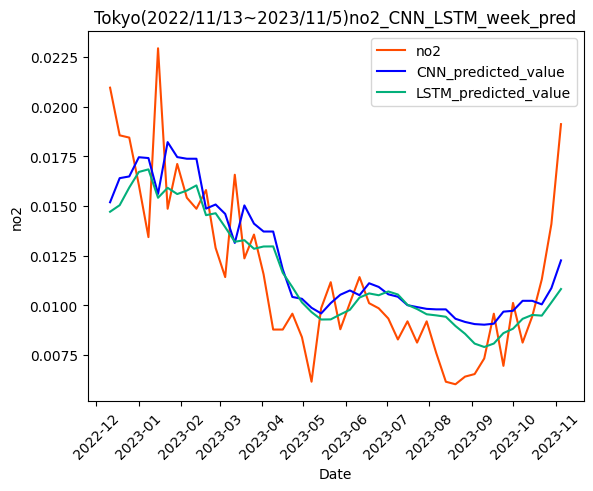

[I 2024-04-07 13:45:00,485] A new study created in memory with name: no-name-8c3673bb-ff1e-49d9-a912-9ce6da58a09a
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:02,758] Trial 0 finished with value: 0.03707588558323359 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 89, 'dropout_rate': 0.07572055285865792}. Best is trial 0 with value: 0.03707588558323359.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:45:04,558] Trial 1 finished with value: 0.03682684066130778 and parameters: {'num_conv_layers': 1, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 37, 'dropout_rate': 0.472637894780418}. Best is trial 1 with value: 0.03682684066130778.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:45:06,445] Trial 2 finished with value: 0.0365325228477393 and parameters: {'num_conv_layers': 1, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 33, 'dropout_rate': 0.469651090306263}. Best is trial 2 with value: 0.0365325228477393.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:08,280] Trial 3 finished with value: 0.03469740766696701 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 34, 'dropout_rate': 0.1970342574782058}. Best is trial 3 with value: 0.03469740766696701.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:45:11,315] Trial 4 finished with value: 0.03405001307411835 and parameters: {'num_conv_layers': 1, 'conv_filters': 24, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 41, 'dropout_rate': 0.05063785075578142}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:13,561] Trial 5 finished with value: 0.03497445251452982 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 99, 'dropout_rate': 0.11510822177947022}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:15,725] Trial 6 finished with value: 0.036928085245940816 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 63, 'dropout_rate': 0.3928395076861006}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 1s 7ms/step


[I 2024-04-07 13:45:19,308] Trial 7 finished with value: 0.034667618681342806 and parameters: {'num_conv_layers': 2, 'conv_filters': 20, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 55, 'dropout_rate': 0.042538046135473795}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:22,046] Trial 8 finished with value: 0.03414705675906964 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.06475846956239295}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:25,094] Trial 9 finished with value: 0.03661733386921594 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 37, 'dropout_rate': 0.12623447364683887}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:27,250] Trial 10 finished with value: 0.03540367534557063 and parameters: {'num_conv_layers': 1, 'conv_filters': 50, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 51, 'dropout_rate': 0.3011401575916916}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:29,449] Trial 11 finished with value: 0.03676526115994035 and parameters: {'num_conv_layers': 1, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 80, 'dropout_rate': 0.021881248486421846}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:31,887] Trial 12 finished with value: 0.0340775320410814 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 74, 'dropout_rate': 0.22721616792147648}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:33,904] Trial 13 finished with value: 0.035061012165478474 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 73, 'dropout_rate': 0.23636050639784753}. Best is trial 4 with value: 0.03405001307411835.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:45:36,380] Trial 14 finished with value: 0.03376148242409027 and parameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.3197018086103877}. Best is trial 14 with value: 0.03376148242409027.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:45:39,659] Trial 15 finished with value: 0.034224054493973276 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 49, 'dropout_rate': 0.32944354256040925}. Best is trial 14 with value: 0.03376148242409027.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:41,502] Trial 16 finished with value: 0.035003800872090596 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 46, 'dropout_rate': 0.3827393876043581}. Best is trial 14 with value: 0.03376148242409027.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:45:43,662] Trial 17 finished with value: 0.03397101671825437 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.1683673770334699}. Best is trial 14 with value: 0.03376148242409027.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:45,927] Trial 18 finished with value: 0.0343516447671949 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 63, 'dropout_rate': 0.1721266637395727}. Best is trial 14 with value: 0.03376148242409027.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:45:50,940] Trial 19 finished with value: 0.03443605439531675 and parameters: {'num_conv_layers': 2, 'conv_filters': 32, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 57, 'dropout_rate': 0.29188821357183165}. Best is trial 14 with value: 0.03376148242409027.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.3197018086103877}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 7s - loss: 0.1874 - mae: 0.3373

5/5 [==============================] - 2s 7ms/step - loss: 0.1453 - mae: 0.2896
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1364 - mae: 0.2741

5/5 [==============================] - 0s 9ms/step - loss: 0.0989 - mae: 0.2341
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0832 - mae: 0.2197

5/5 [==============================] - 0s 7ms/step - loss: 0.0644 - mae: 0.1977
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0506 - mae: 0.1617

5/5 [==============================] - 0s 9ms/step - loss: 0.0556 - mae: 0.1825
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0469 - mae: 0.1702

5/5 [==============================] - 0s 6ms/step - loss: 0.0536 - mae: 0.1824
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0635 - mae: 0.2112

5/5 [==============================] - 0s 8ms/step - loss: 0.0607 - mae: 0.2001
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0637 - mae: 0.2086

5/5 [==============================] - 0s 7ms/step - loss: 0.0510 - mae: 0.1845
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0696 - mae: 0.2070

5/5 [==============================] - 0s 6ms/step - loss: 0.0507 - mae: 0.1797
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0773 - mae: 0.2239

5/5 [==============================] - 0s 9ms/step - loss: 0.0557 - mae: 0.1874
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0501 - mae: 0.1832

5/5 [==============================] - 0s 7ms/step - loss: 0.0447 - mae: 0.1695
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0344 - mae: 0.1574

5/5 [==============================] - 0s 8ms/step - loss: 0.0540 - mae: 0.1830
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0446 - mae: 0.1553

5/5 [==============================] - 0s 7ms/step - loss: 0.0490 - mae: 0.1771
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0632 - mae: 0.2032

5/5 [==============================] - 0s 7ms/step - loss: 0.0454 - mae: 0.1708
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0505 - mae: 0.1848

5/5 [==============================] - 0s 7ms/step - loss: 0.0419 - mae: 0.1617
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0595 - mae: 0.1934

5/5 [==============================] - 0s 7ms/step - loss: 0.0452 - mae: 0.1693
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0453 - mae: 0.1699

5/5 [==============================] - 0s 7ms/step - loss: 0.0445 - mae: 0.1713
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0474 - mae: 0.1749

5/5 [==============================] - 0s 6ms/step - loss: 0.0436 - mae: 0.1691
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0640 - mae: 0.1933

5/5 [==============================] - 0s 6ms/step - loss: 0.0435 - mae: 0.1654
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0394 - mae: 0.1642

5/5 [==============================] - 0s 7ms/step - loss: 0.0378 - mae: 0.1542
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0309 - mae: 0.1448

5/5 [==============================] - 0s 7ms/step - loss: 0.0434 - mae: 0.1669
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0385 - mae: 0.1611

5/5 [==============================] - 0s 6ms/step - loss: 0.0420 - mae: 0.1629
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0373 - mae: 0.1483

5/5 [==============================] - 0s 7ms/step - loss: 0.0399 - mae: 0.1556
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0307 - mae: 0.1512

5/5 [==============================] - 0s 7ms/step - loss: 0.0445 - mae: 0.1638
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299 - mae: 0.1435

5/5 [==============================] - 0s 7ms/step - loss: 0.0380 - mae: 0.1537
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0303 - mae: 0.1394

5/5 [==============================] - 0s 7ms/step - loss: 0.0425 - mae: 0.1644
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0378 - mae: 0.1488

5/5 [==============================] - 0s 7ms/step - loss: 0.0373 - mae: 0.1542
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0320 - mae: 0.1387

5/5 [==============================] - 0s 7ms/step - loss: 0.0430 - mae: 0.1664
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0480 - mae: 0.1601

5/5 [==============================] - 0s 6ms/step - loss: 0.0446 - mae: 0.1675
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0601 - mae: 0.1848

5/5 [==============================] - 0s 7ms/step - loss: 0.0429 - mae: 0.1613
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0480 - mae: 0.1875

5/5 [==============================] - 0s 7ms/step - loss: 0.0413 - mae: 0.1629
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0378 - mae: 0.1673

5/5 [==============================] - 0s 6ms/step - loss: 0.0422 - mae: 0.1650
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0453 - mae: 0.1740

5/5 [==============================] - 0s 6ms/step - loss: 0.0405 - mae: 0.1590
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0468 - mae: 0.1775

5/5 [==============================] - 0s 8ms/step - loss: 0.0382 - mae: 0.1560
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210 - mae: 0.1249

5/5 [==============================] - 0s 7ms/step - loss: 0.0412 - mae: 0.1561
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0427 - mae: 0.1685

5/5 [==============================] - 0s 8ms/step - loss: 0.0443 - mae: 0.1710
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0426 - mae: 0.1728

5/5 [==============================] - 0s 9ms/step - loss: 0.0391 - mae: 0.1564
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0502 - mae: 0.1710

5/5 [==============================] - 0s 6ms/step - loss: 0.0415 - mae: 0.1604
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0342 - mae: 0.1419

5/5 [==============================] - 0s 6ms/step - loss: 0.0401 - mae: 0.1532
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0474 - mae: 0.1687

5/5 [==============================] - 0s 6ms/step - loss: 0.0368 - mae: 0.1521
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0241 - mae: 0.1181

5/5 [==============================] - 0s 6ms/step - loss: 0.0392 - mae: 0.1594
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1372

5/5 [==============================] - 0s 6ms/step - loss: 0.0366 - mae: 0.1508
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0455 - mae: 0.1453

5/5 [==============================] - 0s 7ms/step - loss: 0.0406 - mae: 0.1577
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0373 - mae: 0.1635

5/5 [==============================] - 0s 7ms/step - loss: 0.0373 - mae: 0.1564
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0403 - mae: 0.1745

5/5 [==============================] - 0s 6ms/step - loss: 0.0425 - mae: 0.1616
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0409 - mae: 0.1623

5/5 [==============================] - 0s 7ms/step - loss: 0.0392 - mae: 0.1628
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0564 - mae: 0.1601

5/5 [==============================] - 0s 6ms/step - loss: 0.0401 - mae: 0.1566
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0285 - mae: 0.1312

5/5 [==============================] - 0s 6ms/step - loss: 0.0409 - mae: 0.1591
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0694 - mae: 0.1904

5/5 [==============================] - 0s 7ms/step - loss: 0.0396 - mae: 0.1529
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0277 - mae: 0.1367

5/5 [==============================] - 0s 7ms/step - loss: 0.0410 - mae: 0.1573
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0302 - mae: 0.1454

2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:45:55,367] A new study created in memory with name: no-name-aa68dfc9-d068-42d1-9912-d04a9d6922fa
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 8ms/step - loss: 0.0371


[I 2024-04-07 13:46:00,060] Trial 0 finished with value: 0.03714444115757942 and parameters: {'n_lstm_layers': 1, 'units_0': 34, 'dropout_rate': 0.16381737246805983, 'learning_rate': 0.0026621614719259767}. Best is trial 0 with value: 0.03714444115757942.


2/2 [==============================] - 0s 9ms/step - loss: 0.0518


[I 2024-04-07 13:46:08,220] Trial 1 finished with value: 0.0517912320792675 and parameters: {'n_lstm_layers': 1, 'units_0': 50, 'dropout_rate': 0.1555400443583942, 'learning_rate': 1.7665925337395823e-05}. Best is trial 0 with value: 0.03714444115757942.


2/2 [==============================] - 0s 10ms/step - loss: 0.0337


[I 2024-04-07 13:46:15,063] Trial 2 finished with value: 0.03367459401488304 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 74, 'dropout_rate': 0.4931738709715577, 'learning_rate': 0.005064211379134392}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 10ms/step - loss: 0.0385


[I 2024-04-07 13:46:22,787] Trial 3 finished with value: 0.038545895367860794 and parameters: {'n_lstm_layers': 1, 'units_0': 84, 'dropout_rate': 0.25736736275591404, 'learning_rate': 0.0005321838866685773}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 14ms/step - loss: 0.0341


[I 2024-04-07 13:46:34,409] Trial 4 finished with value: 0.03405642509460449 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 80, 'units_2': 79, 'dropout_rate': 0.0722162595052323, 'learning_rate': 0.0001545094637950663}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 9ms/step - loss: 0.0358


[I 2024-04-07 13:46:39,457] Trial 5 finished with value: 0.035752393305301666 and parameters: {'n_lstm_layers': 1, 'units_0': 91, 'dropout_rate': 0.3037013081668302, 'learning_rate': 0.0028334742875217598}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 15ms/step - loss: 0.0345


[I 2024-04-07 13:46:51,830] Trial 6 finished with value: 0.03448958322405815 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 24, 'units_2': 33, 'dropout_rate': 0.16147431322637573, 'learning_rate': 0.0035663547399677285}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 9ms/step - loss: 0.0380


[I 2024-04-07 13:47:06,896] Trial 7 finished with value: 0.03796739876270294 and parameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 30, 'dropout_rate': 0.28313920025735423, 'learning_rate': 3.101821189735377e-05}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 13ms/step - loss: 0.0341


[I 2024-04-07 13:47:14,513] Trial 8 finished with value: 0.03410033881664276 and parameters: {'n_lstm_layers': 2, 'units_0': 52, 'units_1': 98, 'dropout_rate': 0.23859856498844678, 'learning_rate': 0.0002312655954324345}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 14ms/step - loss: 0.0341


[I 2024-04-07 13:47:30,230] Trial 9 finished with value: 0.03409959003329277 and parameters: {'n_lstm_layers': 3, 'units_0': 52, 'units_1': 80, 'units_2': 65, 'dropout_rate': 0.13164746292401325, 'learning_rate': 5.4600396014832186e-05}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 8ms/step - loss: 0.0342


[I 2024-04-07 13:47:39,685] Trial 10 finished with value: 0.034193094819784164 and parameters: {'n_lstm_layers': 2, 'units_0': 74, 'units_1': 53, 'dropout_rate': 0.4794969243821028, 'learning_rate': 0.007879183422640282}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 13ms/step - loss: 0.0344


[I 2024-04-07 13:47:53,228] Trial 11 finished with value: 0.03437851741909981 and parameters: {'n_lstm_layers': 3, 'units_0': 33, 'units_1': 72, 'units_2': 98, 'dropout_rate': 0.0021407708079598242, 'learning_rate': 0.00025341999212356967}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 13ms/step - loss: 0.0346


[I 2024-04-07 13:48:03,022] Trial 12 finished with value: 0.03455500677227974 and parameters: {'n_lstm_layers': 3, 'units_0': 20, 'units_1': 85, 'units_2': 83, 'dropout_rate': 0.498468371557439, 'learning_rate': 0.000700389542922148}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 9ms/step - loss: 0.0341


[I 2024-04-07 13:48:13,855] Trial 13 finished with value: 0.034136828035116196 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 58, 'dropout_rate': 0.38627850491418936, 'learning_rate': 8.545539084808212e-05}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 12ms/step - loss: 0.0346


[I 2024-04-07 13:48:22,067] Trial 14 finished with value: 0.03463452309370041 and parameters: {'n_lstm_layers': 2, 'units_0': 43, 'units_1': 71, 'dropout_rate': 0.0435423673482922, 'learning_rate': 0.0008673244446922884}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 12ms/step - loss: 0.0340


[I 2024-04-07 13:48:34,541] Trial 15 finished with value: 0.034009236842393875 and parameters: {'n_lstm_layers': 3, 'units_0': 20, 'units_1': 100, 'units_2': 55, 'dropout_rate': 0.43488464161613855, 'learning_rate': 8.308127543300449e-05}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 13ms/step - loss: 0.0520


[I 2024-04-07 13:48:49,387] Trial 16 finished with value: 0.051952559500932693 and parameters: {'n_lstm_layers': 2, 'units_0': 22, 'units_1': 99, 'dropout_rate': 0.4186360215802345, 'learning_rate': 1.2376631982682883e-05}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 8ms/step - loss: 0.0345


[I 2024-04-07 13:48:59,695] Trial 17 finished with value: 0.034507401287555695 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 42, 'units_2': 36, 'dropout_rate': 0.36590812610813966, 'learning_rate': 0.0012241222097221312}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 11ms/step - loss: 0.0341


[I 2024-04-07 13:49:06,803] Trial 18 finished with value: 0.03413890674710274 and parameters: {'n_lstm_layers': 2, 'units_0': 79, 'units_1': 93, 'dropout_rate': 0.45472478097389957, 'learning_rate': 0.00010848219183717144}. Best is trial 2 with value: 0.03367459401488304.


2/2 [==============================] - 0s 10ms/step - loss: 0.0341


[I 2024-04-07 13:49:24,100] Trial 19 finished with value: 0.03414697200059891 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 66, 'dropout_rate': 0.3311177790796606, 'learning_rate': 4.053707006073195e-05}. Best is trial 2 with value: 0.03367459401488304.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 74, 'dropout_rate': 0.4931738709715577, 'learning_rate': 0.005064211379134392}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.0902 

5/5 [==============================] - 4s 15ms/step - loss: 0.0902
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0510

5/5 [==============================] - 0s 21ms/step - loss: 0.0541
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0547

5/5 [==============================] - 0s 20ms/step - loss: 0.0542
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0572

5/5 [==============================] - 0s 19ms/step - loss: 0.0597
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0517

5/5 [==============================] - 0s 20ms/step - loss: 0.0511
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0534

5/5 [==============================] - 0s 18ms/step - loss: 0.0581
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0587

5/5 [==============================] - 0s 18ms/step - loss: 0.0587
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0453

5/5 [==============================] - 0s 19ms/step - loss: 0.0474
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0548

5/5 [==============================] - 0s 21ms/step - loss: 0.0535
Epoch 10/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0514

5/5 [==============================] - 0s 20ms/step - loss: 0.0510
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0545

5/5 [==============================] - 0s 19ms/step - loss: 0.0532
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0561

5/5 [==============================] - 0s 19ms/step - loss: 0.0545
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0552

5/5 [==============================] - 0s 16ms/step - loss: 0.0552
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0507

5/5 [==============================] - 0s 18ms/step - loss: 0.0507
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0473

5/5 [==============================] - 0s 20ms/step - loss: 0.0495
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0554

5/5 [==============================] - 0s 19ms/step - loss: 0.0543
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0508

5/5 [==============================] - 0s 21ms/step - loss: 0.0504
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0511

5/5 [==============================] - 0s 18ms/step - loss: 0.0511
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0544

5/5 [==============================] - 0s 20ms/step - loss: 0.0517
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0585

5/5 [==============================] - 0s 21ms/step - loss: 0.0563
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0475

5/5 [==============================] - 0s 17ms/step - loss: 0.0475
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0506

5/5 [==============================] - 0s 18ms/step - loss: 0.0506
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0503

5/5 [==============================] - 0s 18ms/step - loss: 0.0491
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0525

5/5 [==============================] - 0s 18ms/step - loss: 0.0529
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0504

5/5 [==============================] - 0s 17ms/step - loss: 0.0504
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0467

5/5 [==============================] - 0s 21ms/step - loss: 0.0491
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0476

5/5 [==============================] - 0s 19ms/step - loss: 0.0502
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0539

5/5 [==============================] - 0s 19ms/step - loss: 0.0521
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0475

5/5 [==============================] - 0s 18ms/step - loss: 0.0478
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0530

5/5 [==============================] - 0s 20ms/step - loss: 0.0526
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0510

5/5 [==============================] - 0s 17ms/step - loss: 0.0510
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0532

5/5 [==============================] - 0s 18ms/step - loss: 0.0532
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0510

5/5 [==============================] - 0s 19ms/step - loss: 0.0511
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0524

5/5 [==============================] - 0s 19ms/step - loss: 0.0494
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0501

5/5 [==============================] - 0s 16ms/step - loss: 0.0501
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0561

5/5 [==============================] - 0s 19ms/step - loss: 0.0575
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0578

5/5 [==============================] - 0s 17ms/step - loss: 0.0578
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0505

5/5 [==============================] - 0s 17ms/step - loss: 0.0505
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0510

5/5 [==============================] - 0s 19ms/step - loss: 0.0510
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0462

5/5 [==============================] - 0s 17ms/step - loss: 0.0462
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0490

5/5 [==============================] - 0s 18ms/step - loss: 0.0481
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0520

5/5 [==============================] - 0s 18ms/step - loss: 0.0531
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0480

5/5 [==============================] - 0s 17ms/step - loss: 0.0480
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0492

5/5 [==============================] - 0s 18ms/step - loss: 0.0492
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0504

5/5 [==============================] - 0s 17ms/step - loss: 0.0504
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0526

5/5 [==============================] - 0s 18ms/step - loss: 0.0526
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0472

5/5 [==============================] - 0s 19ms/step - loss: 0.0485
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0481

5/5 [==============================] - 0s 19ms/step - loss: 0.0469
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0514

5/5 [==============================] - 0s 21ms/step - loss: 0.0499
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0482

2/2 [==============================] - 2s 12ms/step


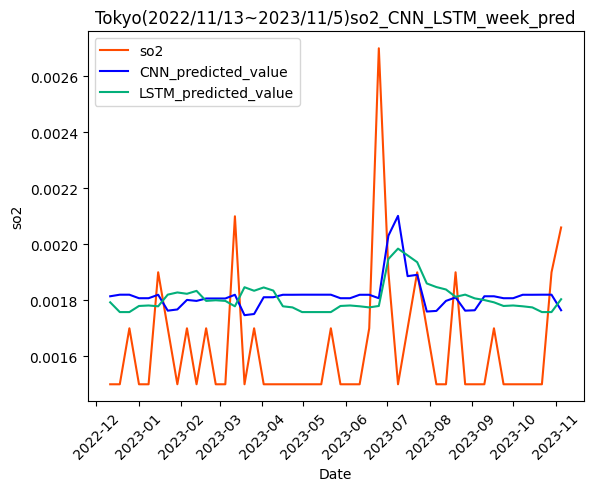

[I 2024-04-07 13:49:36,805] A new study created in memory with name: no-name-32f166b2-a133-4aec-9fd8-2afcfd64baec
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:49:40,096] Trial 0 finished with value: 0.024911332036150813 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.3491626810577742}. Best is trial 0 with value: 0.024911332036150813.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:49:42,133] Trial 1 finished with value: 0.023491082972876633 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 83, 'dropout_rate': 0.052676566445669204}. Best is trial 1 with value: 0.023491082972876633.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:49:44,122] Trial 2 finished with value: 0.023606354836065113 and parameters: {'num_conv_layers': 1, 'conv_filters': 59, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.21096131605145668}. Best is trial 1 with value: 0.023491082972876633.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:49:45,875] Trial 3 finished with value: 0.023423429741830853 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 54, 'dropout_rate': 0.23719224390158689}. Best is trial 3 with value: 0.023423429741830853.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:49:48,321] Trial 4 finished with value: 0.02357049496725992 and parameters: {'num_conv_layers': 1, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 37, 'dropout_rate': 0.1723420698265663}. Best is trial 3 with value: 0.023423429741830853.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:49:54,775] Trial 5 finished with value: 0.021668454024159175 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 71, 'dropout_rate': 0.12495119769716428}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:49:56,774] Trial 6 finished with value: 0.0242188941279607 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.3396197740342942}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:49:59,078] Trial 7 finished with value: 0.023440501742009578 and parameters: {'num_conv_layers': 1, 'conv_filters': 28, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 95, 'dropout_rate': 0.2854997912856058}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 13:50:01,925] Trial 8 finished with value: 0.022431392265775563 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 95, 'dropout_rate': 0.4377308045320458}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:50:05,277] Trial 9 finished with value: 0.023188431035821702 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.41497269165019485}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:50:09,338] Trial 10 finished with value: 0.022071877745324108 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 79, 'dropout_rate': 0.004730482814342574}. Best is trial 5 with value: 0.021668454024159175.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:50:12,380] Trial 11 finished with value: 0.021287295354102103 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.012965345970162367}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:50:14,725] Trial 12 finished with value: 0.022495496695298142 and parameters: {'num_conv_layers': 2, 'conv_filters': 50, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.10959426448162472}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:50:17,880] Trial 13 finished with value: 0.022116332107093 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 85, 'dropout_rate': 0.1154220362657085}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:50:22,179] Trial 14 finished with value: 0.022031736038064843 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 72, 'dropout_rate': 0.003778515716409525}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:50:24,427] Trial 15 finished with value: 0.023683044364634958 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 54, 'dropout_rate': 0.10130039574283511}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:50:27,077] Trial 16 finished with value: 0.02193201393365467 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 89, 'dropout_rate': 0.15067370369953875}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:50:30,027] Trial 17 finished with value: 0.023269238261951347 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.08600992695977609}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:50:35,191] Trial 18 finished with value: 0.02185269578597976 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.044976665678293434}. Best is trial 11 with value: 0.021287295354102103.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:50:38,230] Trial 19 finished with value: 0.0228069447866856 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 46, 'dropout_rate': 0.16845202922519004}. Best is trial 11 with value: 0.021287295354102103.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.012965345970162367}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.2912 - mae: 0.4992

5/5 [==============================] - 1s 7ms/step - loss: 0.2117 - mae: 0.4110
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1321 - mae: 0.3045

5/5 [==============================] - 0s 7ms/step - loss: 0.0997 - mae: 0.2673
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0452 - mae: 0.1670

5/5 [==============================] - 0s 7ms/step - loss: 0.0368 - mae: 0.1558
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0190 - mae: 0.1140

5/5 [==============================] - 0s 7ms/step - loss: 0.0272 - mae: 0.1308
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0245 - mae: 0.1267

5/5 [==============================] - 0s 7ms/step - loss: 0.0326 - mae: 0.1411
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0287 - mae: 0.1303

5/5 [==============================] - 0s 7ms/step - loss: 0.0242 - mae: 0.1203
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184 - mae: 0.1134

5/5 [==============================] - 0s 7ms/step - loss: 0.0221 - mae: 0.1203
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0211 - mae: 0.1141

5/5 [==============================] - 0s 7ms/step - loss: 0.0241 - mae: 0.1263
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0175 - mae: 0.1142

5/5 [==============================] - 0s 7ms/step - loss: 0.0216 - mae: 0.1196
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0253 - mae: 0.1354

5/5 [==============================] - 0s 7ms/step - loss: 0.0225 - mae: 0.1202
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0231 - mae: 0.1304

5/5 [==============================] - 0s 6ms/step - loss: 0.0217 - mae: 0.1158
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0254 - mae: 0.1326

5/5 [==============================] - 0s 6ms/step - loss: 0.0213 - mae: 0.1150
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1244

5/5 [==============================] - 0s 6ms/step - loss: 0.0207 - mae: 0.1161
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0254 - mae: 0.1288

5/5 [==============================] - 0s 6ms/step - loss: 0.0210 - mae: 0.1168
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0190 - mae: 0.1111

5/5 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.1130
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0242 - mae: 0.1337

5/5 [==============================] - 0s 8ms/step - loss: 0.0201 - mae: 0.1119
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0290 - mae: 0.1360

5/5 [==============================] - 0s 7ms/step - loss: 0.0205 - mae: 0.1131
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0235 - mae: 0.1280

5/5 [==============================] - 0s 9ms/step - loss: 0.0201 - mae: 0.1138
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183 - mae: 0.1134

5/5 [==============================] - 0s 7ms/step - loss: 0.0195 - mae: 0.1113
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0206 - mae: 0.1047

5/5 [==============================] - 0s 6ms/step - loss: 0.0199 - mae: 0.1109
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0212 - mae: 0.1102

5/5 [==============================] - 0s 6ms/step - loss: 0.0192 - mae: 0.1102
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0217 - mae: 0.1218

5/5 [==============================] - 0s 7ms/step - loss: 0.0198 - mae: 0.1123
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1263

5/5 [==============================] - 0s 8ms/step - loss: 0.0199 - mae: 0.1128
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - mae: 0.0807

5/5 [==============================] - 0s 6ms/step - loss: 0.0192 - mae: 0.1083
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0232 - mae: 0.1253

5/5 [==============================] - 0s 8ms/step - loss: 0.0195 - mae: 0.1111
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0187 - mae: 0.1124

5/5 [==============================] - 0s 6ms/step - loss: 0.0184 - mae: 0.1079
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0163 - mae: 0.1073

5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - mae: 0.1071
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0114 - mae: 0.0825

5/5 [==============================] - 0s 8ms/step - loss: 0.0185 - mae: 0.1058
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0181 - mae: 0.1084

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.1068
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0177 - mae: 0.1046

5/5 [==============================] - 0s 6ms/step - loss: 0.0179 - mae: 0.1051
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - mae: 0.1081

5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - mae: 0.1056
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0169 - mae: 0.0969

5/5 [==============================] - 0s 6ms/step - loss: 0.0184 - mae: 0.1082
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0182 - mae: 0.1022

5/5 [==============================] - 0s 6ms/step - loss: 0.0162 - mae: 0.1003
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0139 - mae: 0.0963

5/5 [==============================] - 0s 6ms/step - loss: 0.0182 - mae: 0.1056
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.1021

5/5 [==============================] - 0s 6ms/step - loss: 0.0172 - mae: 0.1029
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.0951

5/5 [==============================] - 0s 6ms/step - loss: 0.0178 - mae: 0.1052
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0136 - mae: 0.0988

5/5 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.1039
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137 - mae: 0.0953

5/5 [==============================] - 0s 7ms/step - loss: 0.0175 - mae: 0.1033
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0169 - mae: 0.0974

5/5 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.1028
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0133 - mae: 0.0953

5/5 [==============================] - 0s 7ms/step - loss: 0.0171 - mae: 0.1043
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183 - mae: 0.1071

5/5 [==============================] - 0s 6ms/step - loss: 0.0169 - mae: 0.1028
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0142 - mae: 0.0945

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.1009
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0240 - mae: 0.1221

5/5 [==============================] - 0s 7ms/step - loss: 0.0165 - mae: 0.1009
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0178 - mae: 0.1018

5/5 [==============================] - 0s 8ms/step - loss: 0.0163 - mae: 0.1007
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0965

5/5 [==============================] - 0s 9ms/step - loss: 0.0169 - mae: 0.0993
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0940

5/5 [==============================] - 0s 7ms/step - loss: 0.0170 - mae: 0.1021
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0172 - mae: 0.1063

5/5 [==============================] - 0s 6ms/step - loss: 0.0173 - mae: 0.1057
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0087 - mae: 0.0757

5/5 [==============================] - 0s 7ms/step - loss: 0.0158 - mae: 0.0984
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0132 - mae: 0.0875

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.1018
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - mae: 0.0990

2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:50:42,017] A new study created in memory with name: no-name-b6faa9fa-add8-475c-a568-c9759164e81e
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 17ms/step - loss: 0.0216


[I 2024-04-07 13:50:54,196] Trial 0 finished with value: 0.02158576250076294 and parameters: {'n_lstm_layers': 2, 'units_0': 87, 'units_1': 81, 'dropout_rate': 0.019417087459540627, 'learning_rate': 0.0001876425402370314}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 14ms/step - loss: 0.0218


[I 2024-04-07 13:51:08,430] Trial 1 finished with value: 0.021756043657660484 and parameters: {'n_lstm_layers': 3, 'units_0': 24, 'units_1': 34, 'units_2': 56, 'dropout_rate': 0.09177593341635987, 'learning_rate': 0.0015370173337503324}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 13ms/step - loss: 0.2296


[I 2024-04-07 13:51:24,174] Trial 2 finished with value: 0.22960805892944336 and parameters: {'n_lstm_layers': 3, 'units_0': 31, 'units_1': 79, 'units_2': 21, 'dropout_rate': 0.1925819246872545, 'learning_rate': 1.5281104251888438e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 9ms/step - loss: 0.0269


[I 2024-04-07 13:51:38,265] Trial 3 finished with value: 0.026851877570152283 and parameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 67, 'units_2': 26, 'dropout_rate': 0.28181085408984086, 'learning_rate': 4.764772455719403e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 9ms/step - loss: 0.0236


[I 2024-04-07 13:51:57,535] Trial 4 finished with value: 0.023552648723125458 and parameters: {'n_lstm_layers': 3, 'units_0': 40, 'units_1': 71, 'units_2': 20, 'dropout_rate': 0.2774361103418584, 'learning_rate': 6.660978789410541e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 9ms/step - loss: 0.0537


[I 2024-04-07 13:52:05,176] Trial 5 finished with value: 0.05365729331970215 and parameters: {'n_lstm_layers': 1, 'units_0': 69, 'dropout_rate': 0.2611587376298521, 'learning_rate': 0.00022696229832639542}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 15ms/step - loss: 0.0252


[I 2024-04-07 13:52:25,797] Trial 6 finished with value: 0.02517184056341648 and parameters: {'n_lstm_layers': 3, 'units_0': 32, 'units_1': 77, 'units_2': 99, 'dropout_rate': 0.41198387997538943, 'learning_rate': 0.0036400980163147183}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 19ms/step - loss: 0.2511


[I 2024-04-07 13:52:41,357] Trial 7 finished with value: 0.2511182129383087 and parameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 25, 'units_2': 67, 'dropout_rate': 0.44625485666923875, 'learning_rate': 1.0252744804528503e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 8ms/step - loss: 0.0822


[I 2024-04-07 13:52:52,087] Trial 8 finished with value: 0.08218875527381897 and parameters: {'n_lstm_layers': 2, 'units_0': 48, 'units_1': 64, 'dropout_rate': 0.34060194781885644, 'learning_rate': 4.649797762993783e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 12ms/step - loss: 0.0282


[I 2024-04-07 13:53:10,398] Trial 9 finished with value: 0.028200382366776466 and parameters: {'n_lstm_layers': 3, 'units_0': 30, 'units_1': 88, 'units_2': 90, 'dropout_rate': 0.0628334620978161, 'learning_rate': 4.066360014542619e-05}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 10ms/step - loss: 0.0275


[I 2024-04-07 13:53:18,658] Trial 10 finished with value: 0.027471793815493584 and parameters: {'n_lstm_layers': 1, 'units_0': 95, 'dropout_rate': 0.011965032759750638, 'learning_rate': 0.0006212969157445981}. Best is trial 0 with value: 0.02158576250076294.


2/2 [==============================] - 0s 9ms/step - loss: 0.0215


[I 2024-04-07 13:53:28,050] Trial 11 finished with value: 0.021450335159897804 and parameters: {'n_lstm_layers': 2, 'units_0': 91, 'units_1': 37, 'dropout_rate': 0.11279461929760956, 'learning_rate': 0.001337046386042539}. Best is trial 11 with value: 0.021450335159897804.


2/2 [==============================] - 0s 11ms/step - loss: 0.0215


[I 2024-04-07 13:53:37,850] Trial 12 finished with value: 0.021498801186680794 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 45, 'dropout_rate': 0.15364619168769728, 'learning_rate': 0.0003214457508657432}. Best is trial 11 with value: 0.021450335159897804.


2/2 [==============================] - 0s 11ms/step - loss: 0.0234


[I 2024-04-07 13:53:45,827] Trial 13 finished with value: 0.023410791531205177 and parameters: {'n_lstm_layers': 2, 'units_0': 84, 'units_1': 46, 'dropout_rate': 0.15646927487758963, 'learning_rate': 0.007076350792857003}. Best is trial 11 with value: 0.021450335159897804.


2/2 [==============================] - 0s 11ms/step - loss: 0.0214


[I 2024-04-07 13:53:52,717] Trial 14 finished with value: 0.021417545154690742 and parameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 51, 'dropout_rate': 0.1551466171964238, 'learning_rate': 0.0009154398793914923}. Best is trial 14 with value: 0.021417545154690742.


2/2 [==============================] - 0s 10ms/step - loss: 0.0240


[I 2024-04-07 13:54:03,650] Trial 15 finished with value: 0.023986058309674263 and parameters: {'n_lstm_layers': 1, 'units_0': 78, 'dropout_rate': 0.11798122052235123, 'learning_rate': 0.0011795441344690804}. Best is trial 14 with value: 0.021417545154690742.


2/2 [==============================] - 0s 12ms/step - loss: 0.0219


[I 2024-04-07 13:54:11,948] Trial 16 finished with value: 0.021872082725167274 and parameters: {'n_lstm_layers': 2, 'units_0': 98, 'units_1': 51, 'dropout_rate': 0.20563154414465978, 'learning_rate': 0.0023039581929170366}. Best is trial 14 with value: 0.021417545154690742.


2/2 [==============================] - 0s 11ms/step - loss: 0.0220


[I 2024-04-07 13:54:19,291] Trial 17 finished with value: 0.022035792469978333 and parameters: {'n_lstm_layers': 2, 'units_0': 54, 'units_1': 99, 'dropout_rate': 0.20852006935729167, 'learning_rate': 0.0006483700046771805}. Best is trial 14 with value: 0.021417545154690742.


2/2 [==============================] - 0s 8ms/step - loss: 0.0266


[I 2024-04-07 13:54:24,822] Trial 18 finished with value: 0.026628850027918816 and parameters: {'n_lstm_layers': 1, 'units_0': 77, 'dropout_rate': 0.35079714494990644, 'learning_rate': 0.00950087421730887}. Best is trial 14 with value: 0.021417545154690742.


2/2 [==============================] - 0s 12ms/step - loss: 0.0216


[I 2024-04-07 13:54:34,861] Trial 19 finished with value: 0.021595634520053864 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 34, 'dropout_rate': 0.0817539833321532, 'learning_rate': 0.0037019567077898655}. Best is trial 14 with value: 0.021417545154690742.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 51, 'dropout_rate': 0.1551466171964238, 'learning_rate': 0.0009154398793914923}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.2290 

5/5 [==============================] - 4s 17ms/step - loss: 0.2290
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1374

5/5 [==============================] - 0s 21ms/step - loss: 0.1305
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0521

5/5 [==============================] - 0s 21ms/step - loss: 0.0524
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0325

5/5 [==============================] - 0s 19ms/step - loss: 0.0356
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0442

5/5 [==============================] - 0s 19ms/step - loss: 0.0403
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 20ms/step - loss: 0.0284
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0334

5/5 [==============================] - 0s 19ms/step - loss: 0.0327
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0352

5/5 [==============================] - 0s 20ms/step - loss: 0.0331
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0325

5/5 [==============================] - 0s 22ms/step - loss: 0.0312
Epoch 10/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0312

5/5 [==============================] - 0s 22ms/step - loss: 0.0319
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0325

5/5 [==============================] - 0s 20ms/step - loss: 0.0331
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0333

5/5 [==============================] - 0s 21ms/step - loss: 0.0320
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0333

5/5 [==============================] - 0s 19ms/step - loss: 0.0325
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0282

5/5 [==============================] - 0s 19ms/step - loss: 0.0285
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0295

5/5 [==============================] - 0s 21ms/step - loss: 0.0295
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0300

5/5 [==============================] - 0s 19ms/step - loss: 0.0312
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0259

5/5 [==============================] - 0s 20ms/step - loss: 0.0299
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0305

5/5 [==============================] - 0s 23ms/step - loss: 0.0291
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0276

5/5 [==============================] - 0s 20ms/step - loss: 0.0283
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 19ms/step - loss: 0.0246
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0286

5/5 [==============================] - 0s 19ms/step - loss: 0.0272
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 19ms/step - loss: 0.0287
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0341

5/5 [==============================] - 0s 22ms/step - loss: 0.0330
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0289

5/5 [==============================] - 0s 20ms/step - loss: 0.0283
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 20ms/step - loss: 0.0274
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0289

5/5 [==============================] - 0s 19ms/step - loss: 0.0286
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0289

5/5 [==============================] - 0s 20ms/step - loss: 0.0269
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0269

5/5 [==============================] - 0s 21ms/step - loss: 0.0270
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0304

5/5 [==============================] - 0s 19ms/step - loss: 0.0301
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0302

5/5 [==============================] - 0s 18ms/step - loss: 0.0331
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0290

5/5 [==============================] - 0s 19ms/step - loss: 0.0289
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0277

5/5 [==============================] - 0s 19ms/step - loss: 0.0273
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0273

5/5 [==============================] - 0s 18ms/step - loss: 0.0263
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 19ms/step - loss: 0.0250
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 19ms/step - loss: 0.0265
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0307

5/5 [==============================] - 0s 19ms/step - loss: 0.0306
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0350

5/5 [==============================] - 0s 20ms/step - loss: 0.0334
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0272

5/5 [==============================] - 0s 19ms/step - loss: 0.0282
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0271

5/5 [==============================] - 0s 22ms/step - loss: 0.0259
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0269

5/5 [==============================] - 0s 21ms/step - loss: 0.0281
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 20ms/step - loss: 0.0255
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0294

5/5 [==============================] - 0s 21ms/step - loss: 0.0291
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0284

5/5 [==============================] - 0s 23ms/step - loss: 0.0271
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 22ms/step - loss: 0.0256
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0309

5/5 [==============================] - 0s 22ms/step - loss: 0.0311
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 25ms/step - loss: 0.0261
Epoch 47/50
3/5 [=================>............] - ETA: 0s - loss: 0.0381

5/5 [==============================] - 0s 24ms/step - loss: 0.0317
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0313

5/5 [==============================] - 0s 23ms/step - loss: 0.0302
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0262

5/5 [==============================] - 0s 23ms/step - loss: 0.0275
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0300

2/2 [==============================] - 1s 7ms/step


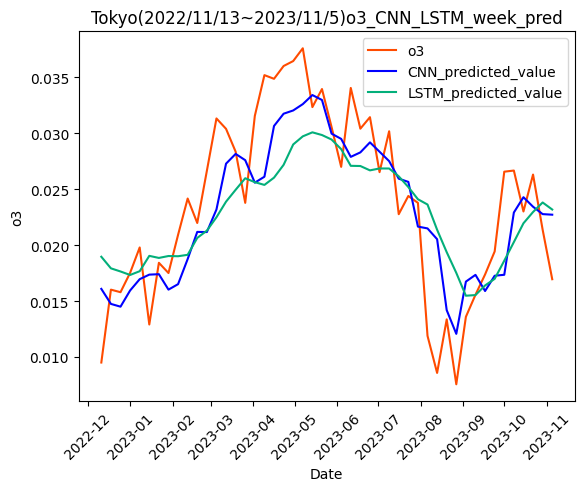

CPU times: user 32min 29s, sys: 27.7 s, total: 32min 56s
Wall time: 34min 37s


,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,AQI_total,target,o3_pred_original_cnn,o3_pred_original
Date,,,,,,,,,,,,,,,
2022-12-11,4.142857,8.671429,1.871429,1013.957143,72.571429,0.465714,0.00150,36.571429,10.142857,0.009514,0.020957,92.714286,0.106864,0.016097,0.018969
2022-12-18,1.357143,7.571429,2.185714,1010.571429,59.571429,0.418571,0.00150,30.714286,8.714286,0.016029,0.018557,81.142857,0.284711,0.014754,0.017933
2022-12-25,2.500000,6.071429,2.757143,1003.842857,50.285714,0.418571,0.00170,26.000000,7.285714,0.015800,0.018443,71.285714,0.278471,0.014506,0.017652
2023-01-01,0.000000,6.657143,2.128571,1016.671429,54.142857,0.418571,0.00150,27.142857,7.571429,0.017529,0.016057,73.428571,0.325663,0.015952,0.017340
2023-01-08,0.000000,5.971429,2.185714,1015.428571,48.571429,0.387143,0.00150,27.000000,7.428571,0.019800,0.013429,71.428571,0.387676,0.016964,0.017677
2023-01-15,0.642857,7.757143,2.257143,1014.371429,61.714286,0.528571,0.00190,50.142857,14.714286,0.012914,0.022943,117.714286,0.199688,0.017371,0.019048
2023-01-22,1.428571,6.100000,2.300000,1015.700000,61.571429,0.387143,0.00170,29.428571,8.000000,0.018429,0.014857,78.857143,0.350234,0.017409,0.018863
2023-01-29,0.142857,3.257143,2.857143,1008.385714,51.142857,0.418571,0.00150,34.714286,9.857143,0.017514,0.017114,88.571429,0.325273,0.016031,0.019034
2023-02-05,0.000000,5.728571,2.714286,1013.614286,47.714286,0.418571,0.00170,35.857143,10.571429,0.020929,0.015414,91.428571,0.418487,0.016519,0.019015


In [ ]:
#CNNの1週間単位の関数を回す(試験回数20,エポック50)
%%time
create_week_model(Tokyo,"Tokyo")
# create_week_model(Delhi,"Delhi")

[I 2024-04-07 13:57:09,922] A new study created in memory with name: no-name-935194c5-24a8-4f27-b9d9-5911a5d5a623
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 12ms/step


[I 2024-04-07 13:57:17,121] Trial 0 finished with value: 0.013206424693198724 and parameters: {'num_conv_layers': 2, 'conv_filters': 36, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.4329916981477041}. Best is trial 0 with value: 0.013206424693198724.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:57:23,188] Trial 1 finished with value: 0.012496651558838006 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 68, 'dropout_rate': 0.23888402495308558}. Best is trial 1 with value: 0.012496651558838006.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:57:32,137] Trial 2 finished with value: 0.012245795415988617 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 47, 'dropout_rate': 0.037675647559844816}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:57:35,723] Trial 3 finished with value: 0.01522004881328426 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.4961745556130051}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 13:57:47,803] Trial 4 finished with value: 0.01272336877500377 and parameters: {'num_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 41, 'dropout_rate': 0.20237721003088072}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 13:57:54,730] Trial 5 finished with value: 0.014258845038763512 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 38, 'dropout_rate': 0.29247671070152637}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:57:58,215] Trial 6 finished with value: 0.014787544859186147 and parameters: {'num_conv_layers': 1, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.12275208187745634}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:58:00,977] Trial 7 finished with value: 0.013850236357556429 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 44, 'dropout_rate': 0.41490872174261145}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:58:03,183] Trial 8 finished with value: 0.014930571933730452 and parameters: {'num_conv_layers': 1, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 67, 'dropout_rate': 0.44411118186438225}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:58:06,804] Trial 9 finished with value: 0.015024038713819424 and parameters: {'num_conv_layers': 1, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 32, 'dropout_rate': 0.27566175452715286}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:58:11,034] Trial 10 finished with value: 0.01246557630020049 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.0070625168203939034}. Best is trial 2 with value: 0.012245795415988617.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 13:58:16,229] Trial 11 finished with value: 0.010845939811266797 and parameters: {'num_conv_layers': 2, 'conv_filters': 59, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.0005040875098829781}. Best is trial 11 with value: 0.010845939811266797.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:58:23,421] Trial 12 finished with value: 0.012032655155473639 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 54, 'dropout_rate': 0.004275168689587765}. Best is trial 11 with value: 0.010845939811266797.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:58:30,261] Trial 13 finished with value: 0.011306511698460997 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.0913357743742351}. Best is trial 11 with value: 0.010845939811266797.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:58:37,725] Trial 14 finished with value: 0.010574742100986254 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.0958346337820096}. Best is trial 14 with value: 0.010574742100986254.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:58:45,571] Trial 15 finished with value: 0.01106665419446598 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.11931273198888714}. Best is trial 14 with value: 0.010574742100986254.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 13:58:49,734] Trial 16 finished with value: 0.012964373060487125 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 83, 'dropout_rate': 0.16285716630909433}. Best is trial 14 with value: 0.010574742100986254.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:58:53,937] Trial 17 finished with value: 0.012820738467270216 and parameters: {'num_conv_layers': 2, 'conv_filters': 56, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 88, 'dropout_rate': 0.0670577401588654}. Best is trial 14 with value: 0.010574742100986254.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 13:58:58,007] Trial 18 finished with value: 0.013067754873927582 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.16304523684253883}. Best is trial 14 with value: 0.010574742100986254.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 13:59:04,007] Trial 19 finished with value: 0.010836161513094363 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.06431378933767395}. Best is trial 14 with value: 0.010574742100986254.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.0958346337820096}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 5s - loss: 0.1208 - mae: 0.3061

5/5 [==============================] - 1s 5ms/step - loss: 0.0932 - mae: 0.2450
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0309 - mae: 0.1312

5/5 [==============================] - 0s 5ms/step - loss: 0.0325 - mae: 0.1199
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0304 - mae: 0.1147

5/5 [==============================] - 0s 5ms/step - loss: 0.0249 - mae: 0.1269
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263 - mae: 0.1471

5/5 [==============================] - 0s 5ms/step - loss: 0.0230 - mae: 0.1259
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0319 - mae: 0.1216

5/5 [==============================] - 0s 8ms/step - loss: 0.0174 - mae: 0.0890
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0135 - mae: 0.0764

5/5 [==============================] - 0s 6ms/step - loss: 0.0197 - mae: 0.0880
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0298 - mae: 0.0994

5/5 [==============================] - 0s 5ms/step - loss: 0.0186 - mae: 0.0865
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0275 - mae: 0.0956

5/5 [==============================] - 0s 5ms/step - loss: 0.0164 - mae: 0.0883
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0148 - mae: 0.0865

5/5 [==============================] - 0s 6ms/step - loss: 0.0170 - mae: 0.0900
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0114 - mae: 0.0731

5/5 [==============================] - 0s 5ms/step - loss: 0.0172 - mae: 0.0868
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0177 - mae: 0.0925

5/5 [==============================] - 0s 8ms/step - loss: 0.0163 - mae: 0.0841
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0073 - mae: 0.0650

5/5 [==============================] - 0s 6ms/step - loss: 0.0143 - mae: 0.0793
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0071 - mae: 0.0685

5/5 [==============================] - 0s 5ms/step - loss: 0.0170 - mae: 0.0868
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - mae: 0.0671

5/5 [==============================] - 0s 6ms/step - loss: 0.0165 - mae: 0.0847
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0312 - mae: 0.1110

5/5 [==============================] - 0s 5ms/step - loss: 0.0175 - mae: 0.0864
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.0892

5/5 [==============================] - 0s 6ms/step - loss: 0.0172 - mae: 0.0866
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244 - mae: 0.1016

5/5 [==============================] - 0s 5ms/step - loss: 0.0164 - mae: 0.0809
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137 - mae: 0.0836

5/5 [==============================] - 0s 5ms/step - loss: 0.0149 - mae: 0.0814
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0170 - mae: 0.0859

5/5 [==============================] - 0s 7ms/step - loss: 0.0158 - mae: 0.0860
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0187 - mae: 0.0996

5/5 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.0854
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0130 - mae: 0.0826

5/5 [==============================] - 0s 6ms/step - loss: 0.0159 - mae: 0.0838
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0166 - mae: 0.0902

5/5 [==============================] - 0s 6ms/step - loss: 0.0177 - mae: 0.0908
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0704

5/5 [==============================] - 0s 6ms/step - loss: 0.0147 - mae: 0.0834
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0067 - mae: 0.0639

5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - mae: 0.0806
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0110 - mae: 0.0759

5/5 [==============================] - 0s 6ms/step - loss: 0.0170 - mae: 0.0857
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0108 - mae: 0.0765

5/5 [==============================] - 0s 8ms/step - loss: 0.0157 - mae: 0.0852
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281 - mae: 0.0989

5/5 [==============================] - 0s 6ms/step - loss: 0.0166 - mae: 0.0842
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0171 - mae: 0.0781

5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - mae: 0.0825
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0059 - mae: 0.0599

5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0812
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0131 - mae: 0.0895

5/5 [==============================] - 0s 6ms/step - loss: 0.0159 - mae: 0.0847
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0252 - mae: 0.0962

5/5 [==============================] - 0s 6ms/step - loss: 0.0145 - mae: 0.0820
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - mae: 0.0950

5/5 [==============================] - 0s 6ms/step - loss: 0.0166 - mae: 0.0854
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0082 - mae: 0.0677

5/5 [==============================] - 0s 7ms/step - loss: 0.0151 - mae: 0.0798
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - mae: 0.0535

5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0806
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0078 - mae: 0.0640

5/5 [==============================] - 0s 6ms/step - loss: 0.0155 - mae: 0.0842
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121 - mae: 0.0828

5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0856
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0076 - mae: 0.0661

5/5 [==============================] - 0s 7ms/step - loss: 0.0154 - mae: 0.0826
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - mae: 0.0596

5/5 [==============================] - 0s 9ms/step - loss: 0.0157 - mae: 0.0809
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0222 - mae: 0.0925

5/5 [==============================] - 0s 7ms/step - loss: 0.0161 - mae: 0.0855
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0838

5/5 [==============================] - 0s 7ms/step - loss: 0.0147 - mae: 0.0804
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0085 - mae: 0.0630

5/5 [==============================] - 0s 6ms/step - loss: 0.0160 - mae: 0.0793
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0126 - mae: 0.0819

5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0807
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0077 - mae: 0.0611

5/5 [==============================] - 0s 6ms/step - loss: 0.0152 - mae: 0.0809
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0178 - mae: 0.0844

5/5 [==============================] - 0s 5ms/step - loss: 0.0148 - mae: 0.0816
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0110 - mae: 0.0742

5/5 [==============================] - 0s 6ms/step - loss: 0.0151 - mae: 0.0803
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0177 - mae: 0.0702

5/5 [==============================] - 0s 7ms/step - loss: 0.0156 - mae: 0.0832
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0077 - mae: 0.0664

5/5 [==============================] - 0s 5ms/step - loss: 0.0150 - mae: 0.0836
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0275 - mae: 0.1092

5/5 [==============================] - 0s 6ms/step - loss: 0.0153 - mae: 0.0815
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0270 - mae: 0.1051

5/5 [==============================] - 0s 6ms/step - loss: 0.0153 - mae: 0.0806
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0310 - mae: 0.1169

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 13:59:07,773] A new study created in memory with name: no-name-9ce7ea82-7508-49a3-a48c-88d57656ac97
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 9ms/step - loss: 0.0260


[I 2024-04-07 13:59:20,731] Trial 0 finished with value: 0.025970280170440674 and parameters: {'n_lstm_layers': 1, 'units_0': 45, 'dropout_rate': 0.10357286572485108, 'learning_rate': 0.00027328601685528645}. Best is trial 0 with value: 0.025970280170440674.


2/2 [==============================] - 0s 11ms/step - loss: 0.0162


[I 2024-04-07 13:59:33,017] Trial 1 finished with value: 0.01624835841357708 and parameters: {'n_lstm_layers': 2, 'units_0': 97, 'units_1': 82, 'dropout_rate': 0.39391230555605045, 'learning_rate': 0.00036357920010842055}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 11ms/step - loss: 0.0239


[I 2024-04-07 13:59:45,539] Trial 2 finished with value: 0.023874908685684204 and parameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 37, 'dropout_rate': 0.22640909166163053, 'learning_rate': 4.688209287659877e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 8ms/step - loss: 0.0173


[I 2024-04-07 13:59:53,459] Trial 3 finished with value: 0.01732219196856022 and parameters: {'n_lstm_layers': 1, 'units_0': 79, 'dropout_rate': 0.2241321933276456, 'learning_rate': 0.0009806197325359773}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 9ms/step - loss: 0.0583


[I 2024-04-07 14:00:00,146] Trial 4 finished with value: 0.05834796652197838 and parameters: {'n_lstm_layers': 1, 'units_0': 77, 'dropout_rate': 0.008518557310743302, 'learning_rate': 3.6894641279944365e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 13ms/step - loss: 0.0605


[I 2024-04-07 14:00:19,760] Trial 5 finished with value: 0.060539186000823975 and parameters: {'n_lstm_layers': 3, 'units_0': 45, 'units_1': 67, 'units_2': 34, 'dropout_rate': 0.4740690054168231, 'learning_rate': 2.4347949545838004e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 7ms/step - loss: 0.0655


[I 2024-04-07 14:00:34,435] Trial 6 finished with value: 0.06548965722322464 and parameters: {'n_lstm_layers': 2, 'units_0': 70, 'units_1': 53, 'dropout_rate': 0.45813206313014454, 'learning_rate': 1.152514268597745e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 9ms/step - loss: 0.0725


[I 2024-04-07 14:00:42,110] Trial 7 finished with value: 0.07251615822315216 and parameters: {'n_lstm_layers': 1, 'units_0': 91, 'dropout_rate': 0.1799405538248346, 'learning_rate': 2.4690366616025972e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 8ms/step - loss: 0.0463


[I 2024-04-07 14:00:57,855] Trial 8 finished with value: 0.04625086486339569 and parameters: {'n_lstm_layers': 1, 'units_0': 58, 'dropout_rate': 0.42153173986681947, 'learning_rate': 5.5945691526652185e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 11ms/step - loss: 0.0718


[I 2024-04-07 14:01:15,006] Trial 9 finished with value: 0.07184545695781708 and parameters: {'n_lstm_layers': 3, 'units_0': 30, 'units_1': 95, 'units_2': 67, 'dropout_rate': 0.1386866760777763, 'learning_rate': 1.4919436399326827e-05}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 16ms/step - loss: 0.0165


[I 2024-04-07 14:01:24,094] Trial 10 finished with value: 0.01652374677360058 and parameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 94, 'dropout_rate': 0.32789507561553516, 'learning_rate': 0.005542319892788931}. Best is trial 1 with value: 0.01624835841357708.


2/2 [==============================] - 0s 10ms/step - loss: 0.0160


[I 2024-04-07 14:01:31,610] Trial 11 finished with value: 0.01600305736064911 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 97, 'dropout_rate': 0.34911772539402897, 'learning_rate': 0.006262561604389671}. Best is trial 11 with value: 0.01600305736064911.


2/2 [==============================] - 0s 11ms/step - loss: 0.0147


[I 2024-04-07 14:01:40,165] Trial 12 finished with value: 0.014689852483570576 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 82, 'dropout_rate': 0.35745937557491647, 'learning_rate': 0.009690710658890858}. Best is trial 12 with value: 0.014689852483570576.


2/2 [==============================] - 0s 13ms/step - loss: 0.0139


[I 2024-04-07 14:01:54,686] Trial 13 finished with value: 0.013855889439582825 and parameters: {'n_lstm_layers': 3, 'units_0': 85, 'units_1': 79, 'units_2': 96, 'dropout_rate': 0.3210818165847047, 'learning_rate': 0.00922166378166347}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 12ms/step - loss: 0.0174


[I 2024-04-07 14:02:05,950] Trial 14 finished with value: 0.01743968389928341 and parameters: {'n_lstm_layers': 3, 'units_0': 87, 'units_1': 73, 'units_2': 100, 'dropout_rate': 0.30675170892130604, 'learning_rate': 0.0022272263616262963}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 12ms/step - loss: 0.0168


[I 2024-04-07 14:02:20,198] Trial 15 finished with value: 0.016835128888487816 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 54, 'units_2': 100, 'dropout_rate': 0.28962982888504923, 'learning_rate': 0.0019242428907732573}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 11ms/step - loss: 0.0159


[I 2024-04-07 14:02:31,620] Trial 16 finished with value: 0.01587091200053692 and parameters: {'n_lstm_layers': 3, 'units_0': 59, 'units_1': 78, 'units_2': 69, 'dropout_rate': 0.3775153760527676, 'learning_rate': 0.009476548184686613}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 12ms/step - loss: 0.0147


[I 2024-04-07 14:02:42,036] Trial 17 finished with value: 0.014659401960670948 and parameters: {'n_lstm_layers': 2, 'units_0': 84, 'units_1': 23, 'dropout_rate': 0.2687413077425646, 'learning_rate': 0.0027177307777203857}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 12ms/step - loss: 0.0163


[I 2024-04-07 14:02:53,277] Trial 18 finished with value: 0.016327718272805214 and parameters: {'n_lstm_layers': 3, 'units_0': 71, 'units_1': 26, 'units_2': 39, 'dropout_rate': 0.2649564435353211, 'learning_rate': 0.002288592330725069}. Best is trial 13 with value: 0.013855889439582825.


2/2 [==============================] - 0s 11ms/step - loss: 0.0164


[I 2024-04-07 14:03:06,958] Trial 19 finished with value: 0.016431385651230812 and parameters: {'n_lstm_layers': 2, 'units_0': 82, 'units_1': 41, 'dropout_rate': 0.06547528206067399, 'learning_rate': 0.00038189970395958463}. Best is trial 13 with value: 0.013855889439582825.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 85, 'units_1': 79, 'units_2': 96, 'dropout_rate': 0.3210818165847047, 'learning_rate': 0.00922166378166347}
Epoch 1/50
3/5 [=================>............] - ETA: 0s - loss: 0.0877 

5/5 [==============================] - 7s 24ms/step - loss: 0.0690
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0363

5/5 [==============================] - 0s 20ms/step - loss: 0.0372
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0328

5/5 [==============================] - 0s 21ms/step - loss: 0.0301
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0315

5/5 [==============================] - 0s 21ms/step - loss: 0.0327
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 23ms/step - loss: 0.0274
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 21ms/step - loss: 0.0262
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 22ms/step - loss: 0.0219
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0229

5/5 [==============================] - 0s 20ms/step - loss: 0.0244
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 21ms/step - loss: 0.0257
Epoch 10/50
3/5 [=================>............] - ETA: 0s - loss: 0.0279

5/5 [==============================] - 0s 23ms/step - loss: 0.0261
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0276

5/5 [==============================] - 0s 19ms/step - loss: 0.0281
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 20ms/step - loss: 0.0237
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0218

5/5 [==============================] - 0s 21ms/step - loss: 0.0230
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 20ms/step - loss: 0.0256
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 19ms/step - loss: 0.0222
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 21ms/step - loss: 0.0216
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 19ms/step - loss: 0.0191
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0206

5/5 [==============================] - 0s 20ms/step - loss: 0.0199
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0191

5/5 [==============================] - 0s 22ms/step - loss: 0.0204
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 21ms/step - loss: 0.0211
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 20ms/step - loss: 0.0253
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0168

5/5 [==============================] - 0s 20ms/step - loss: 0.0189
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 20ms/step - loss: 0.0191
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0149

5/5 [==============================] - 0s 21ms/step - loss: 0.0204
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0204

5/5 [==============================] - 0s 22ms/step - loss: 0.0223
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 20ms/step - loss: 0.0246
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0188

5/5 [==============================] - 0s 21ms/step - loss: 0.0187
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 23ms/step - loss: 0.0234
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 20ms/step - loss: 0.0180
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0214

5/5 [==============================] - 0s 22ms/step - loss: 0.0202
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0179

5/5 [==============================] - 0s 21ms/step - loss: 0.0172
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0173

5/5 [==============================] - 0s 20ms/step - loss: 0.0177
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0177

5/5 [==============================] - 0s 21ms/step - loss: 0.0188
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0176

5/5 [==============================] - 0s 22ms/step - loss: 0.0163
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0194

5/5 [==============================] - 0s 20ms/step - loss: 0.0185
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0179

5/5 [==============================] - 0s 20ms/step - loss: 0.0174
Epoch 37/50
3/5 [=================>............] - ETA: 0s - loss: 0.0130

5/5 [==============================] - 0s 25ms/step - loss: 0.0174
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 20ms/step - loss: 0.0185
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0162

5/5 [==============================] - 0s 22ms/step - loss: 0.0166
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 19ms/step - loss: 0.0207
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0199

5/5 [==============================] - 0s 21ms/step - loss: 0.0180
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0155

5/5 [==============================] - 0s 20ms/step - loss: 0.0179
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0215

5/5 [==============================] - 0s 19ms/step - loss: 0.0205
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0185

5/5 [==============================] - 0s 21ms/step - loss: 0.0195
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 20ms/step - loss: 0.0212
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 23ms/step - loss: 0.0226
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0184

5/5 [==============================] - 0s 21ms/step - loss: 0.0191
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0188

5/5 [==============================] - 0s 23ms/step - loss: 0.0175
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0190

5/5 [==============================] - 0s 20ms/step - loss: 0.0180
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0214

2/2 [==============================] - 1s 12ms/step


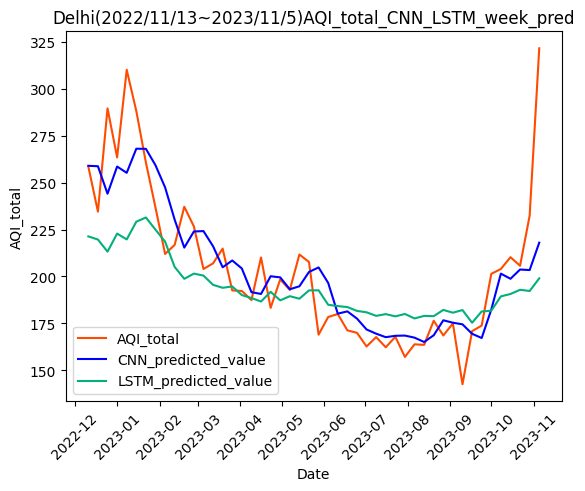

[I 2024-04-07 14:03:27,257] A new study created in memory with name: no-name-9ace329e-cfe2-445a-8e88-31cbbfce7272
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:03:31,158] Trial 0 finished with value: 0.011997104415105419 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.49125382213122226}. Best is trial 0 with value: 0.011997104415105419.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:03:33,639] Trial 1 finished with value: 0.013850498278648158 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.05188347135033372}. Best is trial 0 with value: 0.011997104415105419.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:03:37,791] Trial 2 finished with value: 0.011974952646995754 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.3646740765100299}. Best is trial 2 with value: 0.011974952646995754.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:03:40,161] Trial 3 finished with value: 0.01551847338898131 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.45181415672548403}. Best is trial 2 with value: 0.011974952646995754.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:03:46,710] Trial 4 finished with value: 0.011287972384044337 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 93, 'dropout_rate': 0.15307855824250982}. Best is trial 4 with value: 0.011287972384044337.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:03:51,303] Trial 5 finished with value: 0.011997638434264435 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 85, 'dropout_rate': 0.311565848199202}. Best is trial 4 with value: 0.011287972384044337.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:03:55,476] Trial 6 finished with value: 0.011535599273053287 and parameters: {'num_conv_layers': 2, 'conv_filters': 18, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 75, 'dropout_rate': 0.06539053479584817}. Best is trial 4 with value: 0.011287972384044337.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:04:02,160] Trial 7 finished with value: 0.010535104711447071 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 100, 'dropout_rate': 0.22229748712446756}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:04:08,627] Trial 8 finished with value: 0.011127614506381783 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 87, 'dropout_rate': 0.03753723924088698}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:04:10,396] Trial 9 finished with value: 0.013758954846054548 and parameters: {'num_conv_layers': 1, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 54, 'dropout_rate': 0.23955528623624983}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:04:13,129] Trial 10 finished with value: 0.014487092243152038 and parameters: {'num_conv_layers': 1, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 33, 'dropout_rate': 0.19459084773296426}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:04:15,700] Trial 11 finished with value: 0.012189271406651311 and parameters: {'num_conv_layers': 1, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.006849164216694195}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:04:17,574] Trial 12 finished with value: 0.01404731730294017 and parameters: {'num_conv_layers': 1, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 99, 'dropout_rate': 0.1522703024333002}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:04:19,384] Trial 13 finished with value: 0.01241951848890271 and parameters: {'num_conv_layers': 1, 'conv_filters': 59, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.3353947717091992}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:04:21,299] Trial 14 finished with value: 0.015434174530030431 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 71, 'dropout_rate': 0.09703071375133387}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:04:23,697] Trial 15 finished with value: 0.011891825851541908 and parameters: {'num_conv_layers': 1, 'conv_filters': 44, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 91, 'dropout_rate': 0.24344606937108193}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:04:27,645] Trial 16 finished with value: 0.01161940272357597 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.12096447541465563}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:04:36,273] Trial 17 finished with value: 0.011267300651588943 and parameters: {'num_conv_layers': 1, 'conv_filters': 57, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.0071218762072280985}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:04:39,156] Trial 18 finished with value: 0.01270515094739495 and parameters: {'num_conv_layers': 2, 'conv_filters': 24, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.40486602682517414}. Best is trial 7 with value: 0.010535104711447071.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:04:42,029] Trial 19 finished with value: 0.013692901045527311 and parameters: {'num_conv_layers': 1, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.197100019037804}. Best is trial 7 with value: 0.010535104711447071.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 100, 'dropout_rate': 0.22229748712446756}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.1258 - mae: 0.3202

5/5 [==============================] - 1s 6ms/step - loss: 0.1233 - mae: 0.2906
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0717 - mae: 0.2097

5/5 [==============================] - 0s 6ms/step - loss: 0.0513 - mae: 0.1680
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0375 - mae: 0.1323

5/5 [==============================] - 0s 6ms/step - loss: 0.0194 - mae: 0.0979
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121 - mae: 0.0940

5/5 [==============================] - 0s 6ms/step - loss: 0.0239 - mae: 0.1270
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0206 - mae: 0.1171

5/5 [==============================] - 0s 8ms/step - loss: 0.0209 - mae: 0.1155
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0205 - mae: 0.0920

5/5 [==============================] - 0s 10ms/step - loss: 0.0182 - mae: 0.0978
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0766

5/5 [==============================] - 0s 7ms/step - loss: 0.0176 - mae: 0.0928
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0172 - mae: 0.0976

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0909
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137 - mae: 0.0851

5/5 [==============================] - 0s 6ms/step - loss: 0.0178 - mae: 0.0974
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0091 - mae: 0.0748

5/5 [==============================] - 0s 7ms/step - loss: 0.0171 - mae: 0.0914
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0306 - mae: 0.1075

5/5 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.0903
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0234 - mae: 0.0862

5/5 [==============================] - 0s 7ms/step - loss: 0.0171 - mae: 0.0886
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0163 - mae: 0.0920

5/5 [==============================] - 0s 8ms/step - loss: 0.0161 - mae: 0.0882
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0133 - mae: 0.0930

5/5 [==============================] - 0s 7ms/step - loss: 0.0148 - mae: 0.0841
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0117 - mae: 0.0822

5/5 [==============================] - 0s 7ms/step - loss: 0.0170 - mae: 0.0920
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0215 - mae: 0.1030

5/5 [==============================] - 0s 7ms/step - loss: 0.0187 - mae: 0.0947
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1023

5/5 [==============================] - 0s 9ms/step - loss: 0.0159 - mae: 0.0870
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0324 - mae: 0.1145

5/5 [==============================] - 0s 11ms/step - loss: 0.0165 - mae: 0.0910
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0877

5/5 [==============================] - 0s 9ms/step - loss: 0.0150 - mae: 0.0888
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.0865

5/5 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.0873
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0271 - mae: 0.1050

5/5 [==============================] - 0s 7ms/step - loss: 0.0158 - mae: 0.0887
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0091 - mae: 0.0756

5/5 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.0868
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263 - mae: 0.0966

5/5 [==============================] - 0s 7ms/step - loss: 0.0134 - mae: 0.0786
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0152 - mae: 0.0878

5/5 [==============================] - 0s 7ms/step - loss: 0.0165 - mae: 0.0924
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.0957

5/5 [==============================] - 0s 7ms/step - loss: 0.0147 - mae: 0.0874
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0845

5/5 [==============================] - 0s 7ms/step - loss: 0.0152 - mae: 0.0882
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0127 - mae: 0.0896

5/5 [==============================] - 0s 8ms/step - loss: 0.0148 - mae: 0.0873
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0095 - mae: 0.0729

5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.0895
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0792

5/5 [==============================] - 0s 7ms/step - loss: 0.0136 - mae: 0.0849
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1141

5/5 [==============================] - 0s 8ms/step - loss: 0.0162 - mae: 0.0859
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.0962

5/5 [==============================] - 0s 7ms/step - loss: 0.0150 - mae: 0.0879
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0190 - mae: 0.0959

5/5 [==============================] - 0s 6ms/step - loss: 0.0158 - mae: 0.0893
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0156 - mae: 0.0907

5/5 [==============================] - 0s 6ms/step - loss: 0.0167 - mae: 0.0898
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0138 - mae: 0.0878

5/5 [==============================] - 0s 6ms/step - loss: 0.0154 - mae: 0.0868
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0101 - mae: 0.0795

5/5 [==============================] - 0s 6ms/step - loss: 0.0160 - mae: 0.0906
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0164 - mae: 0.0990

5/5 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.0909
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0148 - mae: 0.0872

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.0898
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.0790

5/5 [==============================] - 0s 7ms/step - loss: 0.0156 - mae: 0.0894
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0147 - mae: 0.0986

5/5 [==============================] - 0s 7ms/step - loss: 0.0157 - mae: 0.0892
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0175 - mae: 0.0717

5/5 [==============================] - 0s 6ms/step - loss: 0.0155 - mae: 0.0851
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - mae: 0.0743

5/5 [==============================] - 0s 7ms/step - loss: 0.0146 - mae: 0.0850
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281 - mae: 0.1222

5/5 [==============================] - 0s 7ms/step - loss: 0.0170 - mae: 0.0942
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0250 - mae: 0.1092

5/5 [==============================] - 0s 8ms/step - loss: 0.0158 - mae: 0.0900
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0123 - mae: 0.0809

5/5 [==============================] - 0s 7ms/step - loss: 0.0149 - mae: 0.0858
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0223 - mae: 0.0921

5/5 [==============================] - 0s 6ms/step - loss: 0.0164 - mae: 0.0930
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0927

5/5 [==============================] - 0s 7ms/step - loss: 0.0142 - mae: 0.0876
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0102 - mae: 0.0844

5/5 [==============================] - 0s 8ms/step - loss: 0.0143 - mae: 0.0856
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0194 - mae: 0.0864

5/5 [==============================] - 0s 7ms/step - loss: 0.0142 - mae: 0.0858
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184 - mae: 0.0865

5/5 [==============================] - 0s 7ms/step - loss: 0.0155 - mae: 0.0860
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0103 - mae: 0.0731

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:04:46,281] A new study created in memory with name: no-name-6e2ab29a-d54a-4f50-98a8-46ef0a7ac047
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 9ms/step - loss: 0.0171


[I 2024-04-07 14:04:59,000] Trial 0 finished with value: 0.017071889713406563 and parameters: {'n_lstm_layers': 3, 'units_0': 30, 'units_1': 59, 'units_2': 42, 'dropout_rate': 0.3332609139784919, 'learning_rate': 0.0004932164297095491}. Best is trial 0 with value: 0.017071889713406563.


2/2 [==============================] - 0s 12ms/step - loss: 0.0332


[I 2024-04-07 14:05:06,561] Trial 1 finished with value: 0.033248454332351685 and parameters: {'n_lstm_layers': 1, 'units_0': 57, 'dropout_rate': 0.12724241489863442, 'learning_rate': 0.00014255292438932987}. Best is trial 0 with value: 0.017071889713406563.


2/2 [==============================] - 0s 15ms/step - loss: 0.0165


[I 2024-04-07 14:05:20,855] Trial 2 finished with value: 0.01645343378186226 and parameters: {'n_lstm_layers': 2, 'units_0': 35, 'units_1': 81, 'dropout_rate': 0.18497371593351092, 'learning_rate': 5.61700384920558e-05}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 14ms/step - loss: 0.0362


[I 2024-04-07 14:05:35,219] Trial 3 finished with value: 0.03620999678969383 and parameters: {'n_lstm_layers': 3, 'units_0': 24, 'units_1': 56, 'units_2': 43, 'dropout_rate': 0.3883897284462222, 'learning_rate': 4.0190854628672586e-05}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 20ms/step - loss: 0.0181


[I 2024-04-07 14:06:04,923] Trial 4 finished with value: 0.018078209832310677 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 59, 'units_2': 54, 'dropout_rate': 0.47647974839019375, 'learning_rate': 0.0009688298756650487}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 16ms/step - loss: 0.0756


[I 2024-04-07 14:06:17,416] Trial 5 finished with value: 0.07562457770109177 and parameters: {'n_lstm_layers': 1, 'units_0': 39, 'dropout_rate': 0.4599419393485141, 'learning_rate': 1.799783241577527e-05}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 20ms/step - loss: 0.0165


[I 2024-04-07 14:06:26,634] Trial 6 finished with value: 0.016513586044311523 and parameters: {'n_lstm_layers': 1, 'units_0': 74, 'dropout_rate': 0.23991269043336438, 'learning_rate': 0.0023282757403604894}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 9ms/step - loss: 0.0207


[I 2024-04-07 14:06:38,982] Trial 7 finished with value: 0.02072921209037304 and parameters: {'n_lstm_layers': 1, 'units_0': 55, 'dropout_rate': 0.09424936220567592, 'learning_rate': 0.0003360305345926108}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 11ms/step - loss: 0.0678


[I 2024-04-07 14:06:51,343] Trial 8 finished with value: 0.06784072518348694 and parameters: {'n_lstm_layers': 1, 'units_0': 63, 'dropout_rate': 0.144170971454752, 'learning_rate': 3.90676499779387e-05}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 23ms/step - loss: 0.0168


[I 2024-04-07 14:07:07,759] Trial 9 finished with value: 0.016801072284579277 and parameters: {'n_lstm_layers': 2, 'units_0': 67, 'units_1': 64, 'dropout_rate': 0.33827051705438593, 'learning_rate': 0.0004675620746588948}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 10ms/step - loss: 0.0166


[I 2024-04-07 14:07:28,668] Trial 10 finished with value: 0.016587072983384132 and parameters: {'n_lstm_layers': 2, 'units_0': 41, 'units_1': 96, 'dropout_rate': 0.004932435257345491, 'learning_rate': 0.00011385319094886812}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 11ms/step - loss: 0.0167


[I 2024-04-07 14:07:40,462] Trial 11 finished with value: 0.016737138852477074 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 20, 'dropout_rate': 0.22894256713955352, 'learning_rate': 0.0096551234560054}. Best is trial 2 with value: 0.01645343378186226.


2/2 [==============================] - 0s 22ms/step - loss: 0.0134


[I 2024-04-07 14:08:05,242] Trial 12 finished with value: 0.013364075683057308 and parameters: {'n_lstm_layers': 2, 'units_0': 78, 'units_1': 94, 'dropout_rate': 0.2148679995179264, 'learning_rate': 0.00361871292485262}. Best is trial 12 with value: 0.013364075683057308.


2/2 [==============================] - 0s 13ms/step - loss: 0.0131


[I 2024-04-07 14:08:17,184] Trial 13 finished with value: 0.013085617683827877 and parameters: {'n_lstm_layers': 2, 'units_0': 81, 'units_1': 94, 'dropout_rate': 0.1925158879309451, 'learning_rate': 0.0096733237175718}. Best is trial 13 with value: 0.013085617683827877.


2/2 [==============================] - 0s 10ms/step - loss: 0.0138


[I 2024-04-07 14:08:26,997] Trial 14 finished with value: 0.01384748239070177 and parameters: {'n_lstm_layers': 2, 'units_0': 79, 'units_1': 97, 'dropout_rate': 0.29136646748754014, 'learning_rate': 0.009864092451475988}. Best is trial 13 with value: 0.013085617683827877.


2/2 [==============================] - 0s 14ms/step - loss: 0.0135


[I 2024-04-07 14:08:38,932] Trial 15 finished with value: 0.013468186371028423 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 78, 'dropout_rate': 0.0705578344442212, 'learning_rate': 0.0032586754397311425}. Best is trial 13 with value: 0.013085617683827877.


2/2 [==============================] - 0s 13ms/step - loss: 0.0145


[I 2024-04-07 14:08:50,360] Trial 16 finished with value: 0.014456254430115223 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 83, 'units_2': 98, 'dropout_rate': 0.19813205520469293, 'learning_rate': 0.003424195500719835}. Best is trial 13 with value: 0.013085617683827877.


2/2 [==============================] - 0s 11ms/step - loss: 0.0150


[I 2024-04-07 14:08:57,971] Trial 17 finished with value: 0.015001699328422546 and parameters: {'n_lstm_layers': 2, 'units_0': 84, 'units_1': 37, 'dropout_rate': 0.26947699529431646, 'learning_rate': 0.0013020901797461805}. Best is trial 13 with value: 0.013085617683827877.


2/2 [==============================] - 0s 11ms/step - loss: 0.0126


[I 2024-04-07 14:09:10,325] Trial 18 finished with value: 0.012633501552045345 and parameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 100, 'dropout_rate': 0.1693856800835329, 'learning_rate': 0.004870674735125112}. Best is trial 18 with value: 0.012633501552045345.


2/2 [==============================] - 0s 12ms/step - loss: 0.0132


[I 2024-04-07 14:09:22,207] Trial 19 finished with value: 0.013203523121774197 and parameters: {'n_lstm_layers': 3, 'units_0': 51, 'units_1': 100, 'units_2': 96, 'dropout_rate': 0.0389398163675142, 'learning_rate': 0.0057427250286682385}. Best is trial 18 with value: 0.012633501552045345.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 100, 'dropout_rate': 0.1693856800835329, 'learning_rate': 0.004870674735125112}
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0576 

5/5 [==============================] - 4s 22ms/step - loss: 0.0611
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 21ms/step - loss: 0.0290
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0411

5/5 [==============================] - 0s 21ms/step - loss: 0.0370
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 24ms/step - loss: 0.0249
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 22ms/step - loss: 0.0255
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 22ms/step - loss: 0.0246
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 23ms/step - loss: 0.0229
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0222

5/5 [==============================] - 0s 24ms/step - loss: 0.0205
Epoch 9/50
3/5 [=================>............] - ETA: 0s - loss: 0.0204

5/5 [==============================] - 0s 25ms/step - loss: 0.0190
Epoch 10/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0177

5/5 [==============================] - 0s 22ms/step - loss: 0.0200
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 25ms/step - loss: 0.0220
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0200

5/5 [==============================] - 0s 21ms/step - loss: 0.0202
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 21ms/step - loss: 0.0198
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0205

5/5 [==============================] - 0s 20ms/step - loss: 0.0193
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 18ms/step - loss: 0.0186
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 18ms/step - loss: 0.0195
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 18ms/step - loss: 0.0214
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0177

5/5 [==============================] - 0s 18ms/step - loss: 0.0194
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0208

5/5 [==============================] - 0s 18ms/step - loss: 0.0197
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 19ms/step - loss: 0.0209
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 19ms/step - loss: 0.0188
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0181

5/5 [==============================] - 0s 23ms/step - loss: 0.0176
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0222

5/5 [==============================] - 0s 20ms/step - loss: 0.0225
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0170

5/5 [==============================] - 0s 21ms/step - loss: 0.0201
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 20ms/step - loss: 0.0199
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0206

5/5 [==============================] - 0s 20ms/step - loss: 0.0228
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0172

5/5 [==============================] - 0s 19ms/step - loss: 0.0201
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0198

5/5 [==============================] - 0s 21ms/step - loss: 0.0204
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0205

5/5 [==============================] - 0s 18ms/step - loss: 0.0193
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0176

5/5 [==============================] - 0s 17ms/step - loss: 0.0176
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 18ms/step - loss: 0.0199
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 22ms/step - loss: 0.0217
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0181

5/5 [==============================] - 0s 19ms/step - loss: 0.0172
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0193

5/5 [==============================] - 0s 20ms/step - loss: 0.0190
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 21ms/step - loss: 0.0190
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0174

5/5 [==============================] - 0s 20ms/step - loss: 0.0180
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0171

5/5 [==============================] - 0s 22ms/step - loss: 0.0166
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 21ms/step - loss: 0.0223
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0165

5/5 [==============================] - 0s 23ms/step - loss: 0.0203
Epoch 40/50
3/5 [=================>............] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 0s 26ms/step - loss: 0.0184
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0188

5/5 [==============================] - 0s 24ms/step - loss: 0.0180
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 25ms/step - loss: 0.0188
Epoch 43/50
3/5 [=================>............] - ETA: 0s - loss: 0.0163

5/5 [==============================] - 0s 27ms/step - loss: 0.0180
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0212

5/5 [==============================] - 0s 24ms/step - loss: 0.0196
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0210

5/5 [==============================] - 0s 23ms/step - loss: 0.0199
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 24ms/step - loss: 0.0230
Epoch 47/50
3/5 [=================>............] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 25ms/step - loss: 0.0217
Epoch 48/50
3/5 [=================>............] - ETA: 0s - loss: 0.0206

5/5 [==============================] - 0s 24ms/step - loss: 0.0205
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 17ms/step - loss: 0.0219
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0214

2/2 [==============================] - 3s 10ms/step


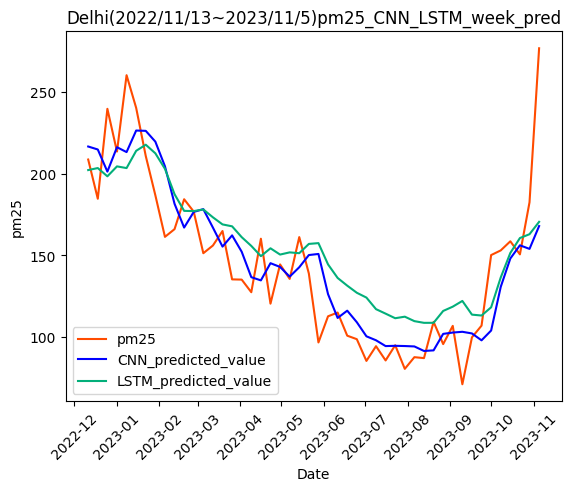

[I 2024-04-07 14:09:40,491] A new study created in memory with name: no-name-61d85cf6-d1f8-4109-a7bc-c10414e8350c
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:09:45,069] Trial 0 finished with value: 0.015290269880699653 and parameters: {'num_conv_layers': 1, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 54, 'dropout_rate': 0.19827137508157883}. Best is trial 0 with value: 0.015290269880699653.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:09:47,178] Trial 1 finished with value: 0.015069732353581533 and parameters: {'num_conv_layers': 1, 'conv_filters': 20, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 66, 'dropout_rate': 0.37737915653263604}. Best is trial 1 with value: 0.015069732353581533.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:09:51,296] Trial 2 finished with value: 0.012512503952587517 and parameters: {'num_conv_layers': 2, 'conv_filters': 52, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.3039303169526499}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:09:54,728] Trial 3 finished with value: 0.014030306017384383 and parameters: {'num_conv_layers': 1, 'conv_filters': 18, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.055662675916539006}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:09:59,029] Trial 4 finished with value: 0.012999607452384645 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 82, 'dropout_rate': 0.15597263040355436}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:10:02,831] Trial 5 finished with value: 0.014496044449404694 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 98, 'dropout_rate': 0.13752825195998797}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:10:05,067] Trial 6 finished with value: 0.014768656124297584 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.49431883649006236}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:10:07,162] Trial 7 finished with value: 0.015933256825127213 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 62, 'dropout_rate': 0.14421209698408083}. Best is trial 2 with value: 0.012512503952587517.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:10:12,198] Trial 8 finished with value: 0.012241864399382593 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.29004832896982663}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:10:14,662] Trial 9 finished with value: 0.01525419336771506 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.30650638454161583}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:10:17,044] Trial 10 finished with value: 0.015601400674593134 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 40, 'dropout_rate': 0.42617398000162376}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:10:19,228] Trial 11 finished with value: 0.01434042343280044 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 49, 'dropout_rate': 0.27379548186052904}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:10:25,567] Trial 12 finished with value: 0.013100964836927511 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 34, 'dropout_rate': 0.33670984738117427}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:10:29,910] Trial 13 finished with value: 0.012333194951206536 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 95, 'dropout_rate': 0.2411055226766634}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:10:32,834] Trial 14 finished with value: 0.014132831593341303 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 99, 'dropout_rate': 0.21889461664043022}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-07 14:10:35,772] Trial 15 finished with value: 0.01411953511298601 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.07310845519013337}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:10:39,186] Trial 16 finished with value: 0.014376618302078781 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.2281092418433549}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:10:43,486] Trial 17 finished with value: 0.012683311529068363 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 74, 'dropout_rate': 0.3855451176000981}. Best is trial 8 with value: 0.012241864399382593.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:10:48,314] Trial 18 finished with value: 0.012050108443171795 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 92, 'dropout_rate': 0.26885798025451996}. Best is trial 18 with value: 0.012050108443171795.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:10:51,821] Trial 19 finished with value: 0.014209807614055764 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 86, 'dropout_rate': 0.45502216800507767}. Best is trial 18 with value: 0.012050108443171795.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 92, 'dropout_rate': 0.26885798025451996}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 4s - loss: 0.0665 - mae: 0.1971

5/5 [==============================] - 1s 6ms/step - loss: 0.0461 - mae: 0.1491
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0354 - mae: 0.1125

5/5 [==============================] - 0s 8ms/step - loss: 0.0254 - mae: 0.1070
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0192 - mae: 0.1049

5/5 [==============================] - 0s 7ms/step - loss: 0.0227 - mae: 0.1117
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1071

5/5 [==============================] - 0s 7ms/step - loss: 0.0230 - mae: 0.1055
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0326 - mae: 0.1134

5/5 [==============================] - 0s 9ms/step - loss: 0.0208 - mae: 0.0949
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0891

5/5 [==============================] - 0s 9ms/step - loss: 0.0173 - mae: 0.0875
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0271 - mae: 0.1110

5/5 [==============================] - 0s 8ms/step - loss: 0.0202 - mae: 0.0936
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - mae: 0.0777

5/5 [==============================] - 0s 8ms/step - loss: 0.0202 - mae: 0.0946
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0356 - mae: 0.1120

5/5 [==============================] - 0s 7ms/step - loss: 0.0203 - mae: 0.0960
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0169 - mae: 0.0973

5/5 [==============================] - 0s 7ms/step - loss: 0.0200 - mae: 0.0958
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0786

5/5 [==============================] - 0s 7ms/step - loss: 0.0197 - mae: 0.0941
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216 - mae: 0.1093

5/5 [==============================] - 0s 9ms/step - loss: 0.0192 - mae: 0.0930
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0102 - mae: 0.0769

5/5 [==============================] - 0s 6ms/step - loss: 0.0180 - mae: 0.0913
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.0885

5/5 [==============================] - 0s 7ms/step - loss: 0.0195 - mae: 0.0934
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0291 - mae: 0.1055

5/5 [==============================] - 0s 7ms/step - loss: 0.0187 - mae: 0.0916
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184 - mae: 0.0931

5/5 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.0951
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0207 - mae: 0.0994

5/5 [==============================] - 0s 7ms/step - loss: 0.0190 - mae: 0.0919
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0111 - mae: 0.0788

5/5 [==============================] - 0s 7ms/step - loss: 0.0189 - mae: 0.0917
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0225 - mae: 0.1133

5/5 [==============================] - 0s 8ms/step - loss: 0.0192 - mae: 0.0917
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0364 - mae: 0.1329

5/5 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.1020
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0061 - mae: 0.0588

5/5 [==============================] - 0s 6ms/step - loss: 0.0178 - mae: 0.0875
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0067 - mae: 0.0617

5/5 [==============================] - 0s 6ms/step - loss: 0.0179 - mae: 0.0899
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0198 - mae: 0.1027

5/5 [==============================] - 0s 7ms/step - loss: 0.0190 - mae: 0.0914
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1111

5/5 [==============================] - 0s 7ms/step - loss: 0.0183 - mae: 0.0867
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - mae: 0.0963

5/5 [==============================] - 0s 7ms/step - loss: 0.0193 - mae: 0.0909
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0334 - mae: 0.1238

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0910
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0071 - mae: 0.0616

5/5 [==============================] - 0s 7ms/step - loss: 0.0185 - mae: 0.0892
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0824

5/5 [==============================] - 0s 7ms/step - loss: 0.0181 - mae: 0.0893
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0113 - mae: 0.0821

5/5 [==============================] - 0s 7ms/step - loss: 0.0173 - mae: 0.0901
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0208 - mae: 0.1121

5/5 [==============================] - 0s 10ms/step - loss: 0.0167 - mae: 0.0915
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0319 - mae: 0.1137

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0902
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0143 - mae: 0.0766

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0839
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0127 - mae: 0.0879

5/5 [==============================] - 0s 8ms/step - loss: 0.0163 - mae: 0.0842
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0107 - mae: 0.0776

5/5 [==============================] - 0s 8ms/step - loss: 0.0167 - mae: 0.0898
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0091 - mae: 0.0759

5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - mae: 0.0877
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0352 - mae: 0.1229

5/5 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.0912
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0125 - mae: 0.0752

5/5 [==============================] - 0s 8ms/step - loss: 0.0174 - mae: 0.0880
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - mae: 0.0906

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0847
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0118 - mae: 0.0851

5/5 [==============================] - 0s 8ms/step - loss: 0.0175 - mae: 0.0848
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0079 - mae: 0.0603

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0905
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0088 - mae: 0.0617

5/5 [==============================] - 0s 7ms/step - loss: 0.0190 - mae: 0.0944
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0232 - mae: 0.0971

5/5 [==============================] - 0s 8ms/step - loss: 0.0185 - mae: 0.0898
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0091 - mae: 0.0740

5/5 [==============================] - 0s 7ms/step - loss: 0.0182 - mae: 0.0905
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0161 - mae: 0.0793

5/5 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.0838
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0122 - mae: 0.0836

5/5 [==============================] - 0s 8ms/step - loss: 0.0171 - mae: 0.0833
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0310 - mae: 0.1089

5/5 [==============================] - 0s 7ms/step - loss: 0.0165 - mae: 0.0872
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0139 - mae: 0.0901

5/5 [==============================] - 0s 6ms/step - loss: 0.0182 - mae: 0.0926
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0061 - mae: 0.0533

5/5 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.0844
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0419 - mae: 0.1349

5/5 [==============================] - 0s 7ms/step - loss: 0.0182 - mae: 0.0907
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0286 - mae: 0.1095

2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:10:55,538] A new study created in memory with name: no-name-10c6076e-b8b0-4aa5-b17b-f70c1c230794
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-07 14:11:02,262] Trial 0 finished with value: 0.015509548597037792 and parameters: {'n_lstm_layers': 1, 'units_0': 72, 'dropout_rate': 0.1872277669162271, 'learning_rate': 0.0016597811736670004}. Best is trial 0 with value: 0.015509548597037792.


2/2 [==============================] - 0s 12ms/step - loss: 0.0168


[I 2024-04-07 14:11:22,211] Trial 1 finished with value: 0.016797266900539398 and parameters: {'n_lstm_layers': 3, 'units_0': 31, 'units_1': 86, 'units_2': 68, 'dropout_rate': 0.38523586467138615, 'learning_rate': 0.00010701842648905849}. Best is trial 0 with value: 0.015509548597037792.


2/2 [==============================] - 0s 11ms/step - loss: 0.0193


[I 2024-04-07 14:11:35,211] Trial 2 finished with value: 0.019260181114077568 and parameters: {'n_lstm_layers': 1, 'units_0': 61, 'dropout_rate': 0.41951081137627044, 'learning_rate': 0.0003301144106150173}. Best is trial 0 with value: 0.015509548597037792.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-07 14:11:43,124] Trial 3 finished with value: 0.015426435507833958 and parameters: {'n_lstm_layers': 2, 'units_0': 97, 'units_1': 36, 'dropout_rate': 0.1300998721028932, 'learning_rate': 0.0002558336517223684}. Best is trial 3 with value: 0.015426435507833958.


2/2 [==============================] - 0s 10ms/step - loss: 0.0152


[I 2024-04-07 14:11:57,021] Trial 4 finished with value: 0.015218432061374187 and parameters: {'n_lstm_layers': 3, 'units_0': 80, 'units_1': 57, 'units_2': 64, 'dropout_rate': 0.2787451249835316, 'learning_rate': 0.004620676382443217}. Best is trial 4 with value: 0.015218432061374187.


2/2 [==============================] - 0s 11ms/step - loss: 0.0167


[I 2024-04-07 14:12:05,889] Trial 5 finished with value: 0.016663821414113045 and parameters: {'n_lstm_layers': 3, 'units_0': 79, 'units_1': 27, 'units_2': 21, 'dropout_rate': 0.00927364289507887, 'learning_rate': 0.003154921267281137}. Best is trial 4 with value: 0.015218432061374187.


2/2 [==============================] - 0s 9ms/step - loss: 0.0175


[I 2024-04-07 14:12:20,550] Trial 6 finished with value: 0.017506809905171394 and parameters: {'n_lstm_layers': 3, 'units_0': 76, 'units_1': 65, 'units_2': 38, 'dropout_rate': 0.27562786724604843, 'learning_rate': 0.008440872591419296}. Best is trial 4 with value: 0.015218432061374187.


2/2 [==============================] - 0s 10ms/step - loss: 0.0422


[I 2024-04-07 14:12:28,150] Trial 7 finished with value: 0.042202532291412354 and parameters: {'n_lstm_layers': 1, 'units_0': 32, 'dropout_rate': 0.40582053204617485, 'learning_rate': 5.492508568827488e-05}. Best is trial 4 with value: 0.015218432061374187.


2/2 [==============================] - 0s 9ms/step - loss: 0.0155


[I 2024-04-07 14:12:46,043] Trial 8 finished with value: 0.015535354614257812 and parameters: {'n_lstm_layers': 3, 'units_0': 63, 'units_1': 33, 'units_2': 91, 'dropout_rate': 0.11995161965970164, 'learning_rate': 0.0001684388515776366}. Best is trial 4 with value: 0.015218432061374187.


2/2 [==============================] - 0s 25ms/step - loss: 0.0149


[I 2024-04-07 14:13:03,218] Trial 9 finished with value: 0.014858387410640717 and parameters: {'n_lstm_layers': 3, 'units_0': 24, 'units_1': 86, 'units_2': 69, 'dropout_rate': 0.13022178857345212, 'learning_rate': 0.0009302951296316634}. Best is trial 9 with value: 0.014858387410640717.


2/2 [==============================] - 0s 11ms/step - loss: 0.0523


[I 2024-04-07 14:13:18,200] Trial 10 finished with value: 0.05228789523243904 and parameters: {'n_lstm_layers': 2, 'units_0': 22, 'units_1': 98, 'dropout_rate': 0.010995813104190677, 'learning_rate': 1.1660218940236887e-05}. Best is trial 9 with value: 0.014858387410640717.


2/2 [==============================] - 0s 12ms/step - loss: 0.0147


[I 2024-04-07 14:13:30,889] Trial 11 finished with value: 0.014702875167131424 and parameters: {'n_lstm_layers': 2, 'units_0': 46, 'units_1': 62, 'dropout_rate': 0.2880930871965856, 'learning_rate': 0.0010320836811007672}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 9ms/step - loss: 0.0148


[I 2024-04-07 14:13:40,736] Trial 12 finished with value: 0.014764835126698017 and parameters: {'n_lstm_layers': 2, 'units_0': 43, 'units_1': 71, 'dropout_rate': 0.32383795734506926, 'learning_rate': 0.0009948462993870544}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 10ms/step - loss: 0.0157


[I 2024-04-07 14:13:47,712] Trial 13 finished with value: 0.01569833792746067 and parameters: {'n_lstm_layers': 2, 'units_0': 44, 'units_1': 62, 'dropout_rate': 0.3405284063715413, 'learning_rate': 0.0008542629423100625}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 8ms/step - loss: 0.0158


[I 2024-04-07 14:14:00,688] Trial 14 finished with value: 0.01575181633234024 and parameters: {'n_lstm_layers': 2, 'units_0': 47, 'units_1': 52, 'dropout_rate': 0.4863985203966302, 'learning_rate': 0.0006985083722055031}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 12ms/step - loss: 0.0158


[I 2024-04-07 14:14:08,667] Trial 15 finished with value: 0.0157712884247303 and parameters: {'n_lstm_layers': 2, 'units_0': 46, 'units_1': 75, 'dropout_rate': 0.31737674958192186, 'learning_rate': 0.002451472331088797}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 12ms/step - loss: 0.0157


[I 2024-04-07 14:14:15,729] Trial 16 finished with value: 0.015656042844057083 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 44, 'dropout_rate': 0.22189671176658876, 'learning_rate': 0.0004832942927651212}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 11ms/step - loss: 0.0169


[I 2024-04-07 14:14:22,300] Trial 17 finished with value: 0.01687793992459774 and parameters: {'n_lstm_layers': 1, 'units_0': 36, 'dropout_rate': 0.49125753183565773, 'learning_rate': 0.0013905744901325009}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 11ms/step - loss: 0.0164


[I 2024-04-07 14:14:39,558] Trial 18 finished with value: 0.016445916146039963 and parameters: {'n_lstm_layers': 2, 'units_0': 39, 'units_1': 72, 'dropout_rate': 0.3552257695933068, 'learning_rate': 6.764947543539022e-05}. Best is trial 11 with value: 0.014702875167131424.


2/2 [==============================] - 0s 9ms/step - loss: 0.0126


[I 2024-04-07 14:14:49,072] Trial 19 finished with value: 0.012629497796297073 and parameters: {'n_lstm_layers': 2, 'units_0': 57, 'units_1': 78, 'dropout_rate': 0.21163518574114676, 'learning_rate': 0.007894163561442107}. Best is trial 19 with value: 0.012629497796297073.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 57, 'units_1': 78, 'dropout_rate': 0.21163518574114676, 'learning_rate': 0.007894163561442107}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.0372 

5/5 [==============================] - 4s 16ms/step - loss: 0.0372
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 17ms/step - loss: 0.0231
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 23ms/step - loss: 0.0207
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 17ms/step - loss: 0.0238
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 16ms/step - loss: 0.0256
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 17ms/step - loss: 0.0232
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0208

5/5 [==============================] - 0s 17ms/step - loss: 0.0208
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 18ms/step - loss: 0.0211
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0143

5/5 [==============================] - 0s 19ms/step - loss: 0.0207
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 16ms/step - loss: 0.0186
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 19ms/step - loss: 0.0183
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 19ms/step - loss: 0.0218
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 15ms/step - loss: 0.0195
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0180

5/5 [==============================] - 0s 22ms/step - loss: 0.0209
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 15ms/step - loss: 0.0192
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 16ms/step - loss: 0.0197
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 0s 19ms/step - loss: 0.0229
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0200

5/5 [==============================] - 0s 16ms/step - loss: 0.0200
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0233

5/5 [==============================] - 0s 19ms/step - loss: 0.0247
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 17ms/step - loss: 0.0195
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 17ms/step - loss: 0.0207
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0209

5/5 [==============================] - 0s 17ms/step - loss: 0.0209
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 20ms/step - loss: 0.0212
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 17ms/step - loss: 0.0196
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0217

5/5 [==============================] - 0s 22ms/step - loss: 0.0213
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0140

5/5 [==============================] - 0s 18ms/step - loss: 0.0197
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0185

5/5 [==============================] - 0s 15ms/step - loss: 0.0185
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 16ms/step - loss: 0.0203
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0189

5/5 [==============================] - 0s 18ms/step - loss: 0.0200
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 15ms/step - loss: 0.0202
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0183

5/5 [==============================] - 0s 17ms/step - loss: 0.0183
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 15ms/step - loss: 0.0192
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0214

5/5 [==============================] - 0s 18ms/step - loss: 0.0197
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.0177

5/5 [==============================] - 0s 16ms/step - loss: 0.0177
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 18ms/step - loss: 0.0225
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0201

5/5 [==============================] - 0s 20ms/step - loss: 0.0189
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0176

5/5 [==============================] - 0s 17ms/step - loss: 0.0176
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 16ms/step - loss: 0.0195
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0187

5/5 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0192

5/5 [==============================] - 0s 19ms/step - loss: 0.0192
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0181

5/5 [==============================] - 0s 21ms/step - loss: 0.0191
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 22ms/step - loss: 0.0200
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0155

5/5 [==============================] - 0s 22ms/step - loss: 0.0193
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 22ms/step - loss: 0.0225
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0206

5/5 [==============================] - 0s 25ms/step - loss: 0.0196
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 22ms/step - loss: 0.0206
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 19ms/step - loss: 0.0191
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 18ms/step - loss: 0.0193
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 19ms/step - loss: 0.0183
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0204

2/2 [==============================] - 1s 11ms/step


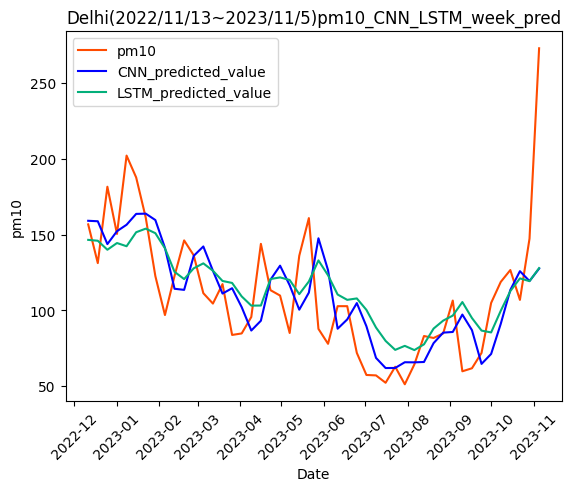

[I 2024-04-07 14:15:05,587] A new study created in memory with name: no-name-bd121366-9d83-40bb-840a-66221ca8621a
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:15:07,998] Trial 0 finished with value: 0.009836043036951138 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 72, 'dropout_rate': 0.20843003298389556}. Best is trial 0 with value: 0.009836043036951138.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:15:12,615] Trial 1 finished with value: 0.009686168253326922 and parameters: {'num_conv_layers': 2, 'conv_filters': 50, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.46126016105534173}. Best is trial 1 with value: 0.009686168253326922.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 14:15:16,102] Trial 2 finished with value: 0.010879596839199595 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 44, 'dropout_rate': 0.21971748656287454}. Best is trial 1 with value: 0.009686168253326922.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:15:18,483] Trial 3 finished with value: 0.010514544938620765 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.38112813735166295}. Best is trial 1 with value: 0.009686168253326922.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:15:20,673] Trial 4 finished with value: 0.009545834169166373 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 78, 'dropout_rate': 0.45470823755184825}. Best is trial 4 with value: 0.009545834169166373.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:15:24,394] Trial 5 finished with value: 0.009911445843871776 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 87, 'dropout_rate': 0.48547923919367975}. Best is trial 4 with value: 0.009545834169166373.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-07 14:15:28,141] Trial 6 finished with value: 0.009533629620019303 and parameters: {'num_conv_layers': 2, 'conv_filters': 18, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.034341071978389315}. Best is trial 6 with value: 0.009533629620019303.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:15:30,631] Trial 7 finished with value: 0.009422737207206716 and parameters: {'num_conv_layers': 1, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 62, 'dropout_rate': 0.18503941330283386}. Best is trial 7 with value: 0.009422737207206716.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 15ms/step


[I 2024-04-07 14:15:34,010] Trial 8 finished with value: 0.009249516908484504 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.015613071283850033}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 14:15:35,845] Trial 9 finished with value: 0.010404102862430898 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.1325862391362737}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:15:39,338] Trial 10 finished with value: 0.009325988062976014 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.016903337710477584}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:15:42,299] Trial 11 finished with value: 0.009733477325717431 and parameters: {'num_conv_layers': 2, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 61, 'dropout_rate': 0.0009489618831058956}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:15:45,178] Trial 12 finished with value: 0.009327925269081772 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.09446542495247384}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:15:50,274] Trial 13 finished with value: 0.009591096022386397 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 78, 'dropout_rate': 0.06401981457385426}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 12ms/step


[I 2024-04-07 14:15:54,452] Trial 14 finished with value: 0.00940433232337269 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.291232827192759}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:15:57,378] Trial 15 finished with value: 0.009418100447892033 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 33, 'dropout_rate': 0.13911534590654467}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:16:00,363] Trial 16 finished with value: 0.009373662126869919 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.2924945194962788}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:16:03,185] Trial 17 finished with value: 0.009564147100650367 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 57, 'dropout_rate': 0.014293160460180546}. Best is trial 8 with value: 0.009249516908484504.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:16:07,481] Trial 18 finished with value: 0.009160343680054006 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.09205653394973334}. Best is trial 18 with value: 0.009160343680054006.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:16:10,534] Trial 19 finished with value: 0.009301411603246526 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 78, 'dropout_rate': 0.10503282648724234}. Best is trial 18 with value: 0.009160343680054006.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.09205653394973334}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 5s - loss: 0.1386 - mae: 0.3091

5/5 [==============================] - 1s 6ms/step - loss: 0.1007 - mae: 0.2439
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0476 - mae: 0.1729

5/5 [==============================] - 0s 8ms/step - loss: 0.0486 - mae: 0.1490
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0314 - mae: 0.1105

5/5 [==============================] - 0s 6ms/step - loss: 0.0218 - mae: 0.0992
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0133 - mae: 0.0898

5/5 [==============================] - 0s 7ms/step - loss: 0.0219 - mae: 0.1234
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0254 - mae: 0.1212

5/5 [==============================] - 0s 8ms/step - loss: 0.0228 - mae: 0.1199
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0267 - mae: 0.1283

5/5 [==============================] - 0s 8ms/step - loss: 0.0176 - mae: 0.0930
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.0987

5/5 [==============================] - 0s 8ms/step - loss: 0.0207 - mae: 0.0927
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0283 - mae: 0.0936

5/5 [==============================] - 0s 7ms/step - loss: 0.0185 - mae: 0.0861
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0112 - mae: 0.0741

5/5 [==============================] - 0s 9ms/step - loss: 0.0201 - mae: 0.1005
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0224 - mae: 0.1006

5/5 [==============================] - 0s 8ms/step - loss: 0.0192 - mae: 0.1001
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0290 - mae: 0.1162

5/5 [==============================] - 0s 9ms/step - loss: 0.0172 - mae: 0.0883
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0256 - mae: 0.1061

5/5 [==============================] - 0s 7ms/step - loss: 0.0185 - mae: 0.0878
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0111 - mae: 0.0739

5/5 [==============================] - 0s 7ms/step - loss: 0.0178 - mae: 0.0847
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0140 - mae: 0.0885

5/5 [==============================] - 0s 8ms/step - loss: 0.0152 - mae: 0.0850
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0108 - mae: 0.0804

5/5 [==============================] - 0s 8ms/step - loss: 0.0172 - mae: 0.0910
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0197 - mae: 0.1094

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.0870
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0158 - mae: 0.0811

5/5 [==============================] - 0s 7ms/step - loss: 0.0179 - mae: 0.0850
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0168 - mae: 0.0952

5/5 [==============================] - 0s 11ms/step - loss: 0.0179 - mae: 0.0883
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0135 - mae: 0.0765

5/5 [==============================] - 0s 8ms/step - loss: 0.0169 - mae: 0.0900
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - mae: 0.0766

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0849
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0131 - mae: 0.0880

5/5 [==============================] - 0s 6ms/step - loss: 0.0162 - mae: 0.0868
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0128 - mae: 0.0745

5/5 [==============================] - 0s 7ms/step - loss: 0.0173 - mae: 0.0895
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - mae: 0.0895

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0827
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.0902

5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.0885
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0072 - mae: 0.0714

5/5 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.0872
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0224 - mae: 0.0930

5/5 [==============================] - 0s 7ms/step - loss: 0.0147 - mae: 0.0843
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0727

5/5 [==============================] - 0s 6ms/step - loss: 0.0157 - mae: 0.0867
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0089 - mae: 0.0691

5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.0834
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0236 - mae: 0.0953

5/5 [==============================] - 0s 9ms/step - loss: 0.0165 - mae: 0.0885
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0103 - mae: 0.0689

5/5 [==============================] - 0s 7ms/step - loss: 0.0170 - mae: 0.0890
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0202 - mae: 0.0985

5/5 [==============================] - 0s 7ms/step - loss: 0.0172 - mae: 0.0864
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0168 - mae: 0.0877

5/5 [==============================] - 0s 8ms/step - loss: 0.0158 - mae: 0.0811
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0179 - mae: 0.0971

5/5 [==============================] - 0s 6ms/step - loss: 0.0160 - mae: 0.0867
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0219 - mae: 0.1009

5/5 [==============================] - 0s 6ms/step - loss: 0.0167 - mae: 0.0888
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0178 - mae: 0.0932

5/5 [==============================] - 0s 6ms/step - loss: 0.0166 - mae: 0.0893
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0200 - mae: 0.0942

5/5 [==============================] - 0s 6ms/step - loss: 0.0154 - mae: 0.0824
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0230 - mae: 0.1093

5/5 [==============================] - 0s 6ms/step - loss: 0.0155 - mae: 0.0856
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0212 - mae: 0.1024

5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - mae: 0.0900
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0158 - mae: 0.0885

5/5 [==============================] - 0s 7ms/step - loss: 0.0177 - mae: 0.0860
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121 - mae: 0.0720

5/5 [==============================] - 0s 7ms/step - loss: 0.0142 - mae: 0.0812
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0128 - mae: 0.0720

5/5 [==============================] - 0s 7ms/step - loss: 0.0156 - mae: 0.0865
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0297 - mae: 0.1170

5/5 [==============================] - 0s 8ms/step - loss: 0.0169 - mae: 0.0887
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0233 - mae: 0.1027

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0850
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0927

5/5 [==============================] - 0s 7ms/step - loss: 0.0169 - mae: 0.0914
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0132 - mae: 0.0756

5/5 [==============================] - 0s 9ms/step - loss: 0.0167 - mae: 0.0843
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0082 - mae: 0.0653

5/5 [==============================] - 0s 7ms/step - loss: 0.0156 - mae: 0.0841
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0279 - mae: 0.1053

5/5 [==============================] - 0s 7ms/step - loss: 0.0155 - mae: 0.0828
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0276 - mae: 0.1126

5/5 [==============================] - 0s 7ms/step - loss: 0.0154 - mae: 0.0846
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0144 - mae: 0.0768

5/5 [==============================] - 0s 7ms/step - loss: 0.0144 - mae: 0.0798
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0188 - mae: 0.0886

2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:16:14,505] A new study created in memory with name: no-name-1cb55066-4b4b-4fa5-a51a-26b7ce7b2a0f
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 11ms/step - loss: 0.0132


[I 2024-04-07 14:16:22,768] Trial 0 finished with value: 0.013176792301237583 and parameters: {'n_lstm_layers': 1, 'units_0': 47, 'dropout_rate': 0.3943241664362422, 'learning_rate': 0.000667165342423157}. Best is trial 0 with value: 0.013176792301237583.


2/2 [==============================] - 0s 9ms/step - loss: 0.0113


[I 2024-04-07 14:16:33,882] Trial 1 finished with value: 0.011298630386590958 and parameters: {'n_lstm_layers': 2, 'units_0': 94, 'units_1': 48, 'dropout_rate': 0.45660147356493147, 'learning_rate': 0.0002585686043653886}. Best is trial 1 with value: 0.011298630386590958.


2/2 [==============================] - 0s 14ms/step - loss: 0.0108


[I 2024-04-07 14:16:50,922] Trial 2 finished with value: 0.010758531279861927 and parameters: {'n_lstm_layers': 3, 'units_0': 79, 'units_1': 66, 'units_2': 80, 'dropout_rate': 0.3783742350625734, 'learning_rate': 0.0006515237025626766}. Best is trial 2 with value: 0.010758531279861927.


2/2 [==============================] - 0s 10ms/step - loss: 0.0102


[I 2024-04-07 14:16:59,500] Trial 3 finished with value: 0.010178753174841404 and parameters: {'n_lstm_layers': 2, 'units_0': 39, 'units_1': 25, 'dropout_rate': 0.33436697976180174, 'learning_rate': 0.007057589638337758}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 11ms/step - loss: 0.0119


[I 2024-04-07 14:17:05,313] Trial 4 finished with value: 0.011913895606994629 and parameters: {'n_lstm_layers': 1, 'units_0': 96, 'dropout_rate': 0.4513962947790837, 'learning_rate': 0.0063980667483897035}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 9ms/step - loss: 0.0116


[I 2024-04-07 14:17:13,241] Trial 5 finished with value: 0.011617045849561691 and parameters: {'n_lstm_layers': 1, 'units_0': 24, 'dropout_rate': 0.22213406097685845, 'learning_rate': 0.0010775217645007107}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 8ms/step - loss: 0.0125


[I 2024-04-07 14:17:20,878] Trial 6 finished with value: 0.012460787780582905 and parameters: {'n_lstm_layers': 1, 'units_0': 40, 'dropout_rate': 0.06049894545114026, 'learning_rate': 0.0010308345377265287}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 10ms/step - loss: 0.0134


[I 2024-04-07 14:17:34,811] Trial 7 finished with value: 0.013377879746258259 and parameters: {'n_lstm_layers': 3, 'units_0': 85, 'units_1': 40, 'units_2': 85, 'dropout_rate': 0.3824330456187387, 'learning_rate': 0.00012713165515695562}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 14ms/step - loss: 0.0103


[I 2024-04-07 14:17:48,028] Trial 8 finished with value: 0.010285980068147182 and parameters: {'n_lstm_layers': 3, 'units_0': 49, 'units_1': 41, 'units_2': 56, 'dropout_rate': 0.2216458152005979, 'learning_rate': 0.0015414224205694768}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 9ms/step - loss: 0.0110


[I 2024-04-07 14:17:56,045] Trial 9 finished with value: 0.01101704966276884 and parameters: {'n_lstm_layers': 1, 'units_0': 92, 'dropout_rate': 0.12601608306457968, 'learning_rate': 0.0011006403158720672}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 14ms/step - loss: 0.0396


[I 2024-04-07 14:18:07,096] Trial 10 finished with value: 0.0396256260573864 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 100, 'dropout_rate': 0.29896812736297135, 'learning_rate': 1.94272199793746e-05}. Best is trial 3 with value: 0.010178753174841404.


2/2 [==============================] - 0s 12ms/step - loss: 0.0097


[I 2024-04-07 14:18:21,532] Trial 11 finished with value: 0.009669765830039978 and parameters: {'n_lstm_layers': 3, 'units_0': 50, 'units_1': 20, 'units_2': 31, 'dropout_rate': 0.22379104693298038, 'learning_rate': 0.009423143902379806}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 9ms/step - loss: 0.0103


[I 2024-04-07 14:18:28,338] Trial 12 finished with value: 0.010313399136066437 and parameters: {'n_lstm_layers': 2, 'units_0': 24, 'units_1': 22, 'dropout_rate': 0.2889553158591909, 'learning_rate': 0.005928539720787249}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 11ms/step - loss: 0.0104


[I 2024-04-07 14:18:43,192] Trial 13 finished with value: 0.010382544249296188 and parameters: {'n_lstm_layers': 3, 'units_0': 64, 'units_1': 21, 'units_2': 21, 'dropout_rate': 0.14119675824944314, 'learning_rate': 0.0038144526781960543}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 10ms/step - loss: 0.0100


[I 2024-04-07 14:18:51,504] Trial 14 finished with value: 0.009983166120946407 and parameters: {'n_lstm_layers': 2, 'units_0': 37, 'units_1': 21, 'dropout_rate': 0.2814337659811812, 'learning_rate': 0.009267228104860388}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 8ms/step - loss: 0.0116


[I 2024-04-07 14:18:58,515] Trial 15 finished with value: 0.011570333503186703 and parameters: {'n_lstm_layers': 2, 'units_0': 52, 'units_1': 67, 'dropout_rate': 0.1839037089592219, 'learning_rate': 0.0027680598602508547}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 12ms/step - loss: 0.0101


[I 2024-04-07 14:19:13,443] Trial 16 finished with value: 0.01006703544408083 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 86, 'units_2': 23, 'dropout_rate': 0.013428303947780051, 'learning_rate': 0.009919977540817308}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 9ms/step - loss: 0.0278


[I 2024-04-07 14:19:24,596] Trial 17 finished with value: 0.027768569067120552 and parameters: {'n_lstm_layers': 2, 'units_0': 57, 'units_1': 34, 'dropout_rate': 0.27347746877389195, 'learning_rate': 4.390264979011462e-05}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 9ms/step - loss: 0.0099


[I 2024-04-07 14:19:31,879] Trial 18 finished with value: 0.009928576648235321 and parameters: {'n_lstm_layers': 2, 'units_0': 31, 'units_1': 54, 'dropout_rate': 0.1588020267374684, 'learning_rate': 0.002658345307338728}. Best is trial 11 with value: 0.009669765830039978.


2/2 [==============================] - 0s 10ms/step - loss: 0.0105


[I 2024-04-07 14:19:45,390] Trial 19 finished with value: 0.010508023202419281 and parameters: {'n_lstm_layers': 3, 'units_0': 73, 'units_1': 55, 'units_2': 47, 'dropout_rate': 0.10926160499865545, 'learning_rate': 0.002572171131250036}. Best is trial 11 with value: 0.009669765830039978.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 50, 'units_1': 20, 'units_2': 31, 'dropout_rate': 0.22379104693298038, 'learning_rate': 0.009423143902379806}
Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.0677 

5/5 [==============================] - 7s 16ms/step - loss: 0.0677
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0332

5/5 [==============================] - 0s 20ms/step - loss: 0.0356
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0364

5/5 [==============================] - 0s 21ms/step - loss: 0.0335
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 20ms/step - loss: 0.0308
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 19ms/step - loss: 0.0266
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0215

5/5 [==============================] - 0s 20ms/step - loss: 0.0208
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 20ms/step - loss: 0.0225
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0228

5/5 [==============================] - 0s 21ms/step - loss: 0.0244
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 20ms/step - loss: 0.0253
Epoch 10/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 22ms/step - loss: 0.0237
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0193

5/5 [==============================] - 0s 20ms/step - loss: 0.0210
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 22ms/step - loss: 0.0232
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 21ms/step - loss: 0.0252
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 19ms/step - loss: 0.0232
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 20ms/step - loss: 0.0208
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0181

5/5 [==============================] - 0s 20ms/step - loss: 0.0198
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 18ms/step - loss: 0.0252
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 20ms/step - loss: 0.0253
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 20ms/step - loss: 0.0203
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0229

5/5 [==============================] - 0s 24ms/step - loss: 0.0223
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0224

5/5 [==============================] - 0s 20ms/step - loss: 0.0216
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 20ms/step - loss: 0.0219
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0207

5/5 [==============================] - 0s 20ms/step - loss: 0.0203
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 18ms/step - loss: 0.0229
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0209

5/5 [==============================] - 0s 20ms/step - loss: 0.0213
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0178

5/5 [==============================] - 0s 21ms/step - loss: 0.0175
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 20ms/step - loss: 0.0221
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 19ms/step - loss: 0.0211
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 19ms/step - loss: 0.0211
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 22ms/step - loss: 0.0185
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0223

5/5 [==============================] - 0s 20ms/step - loss: 0.0210
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 17ms/step - loss: 0.0196
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0164

5/5 [==============================] - 0s 21ms/step - loss: 0.0190
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0194

5/5 [==============================] - 0s 20ms/step - loss: 0.0183
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0174

5/5 [==============================] - 0s 17ms/step - loss: 0.0174
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 19ms/step - loss: 0.0167
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 20ms/step - loss: 0.0185
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0166

5/5 [==============================] - 0s 19ms/step - loss: 0.0178
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0196

5/5 [==============================] - 0s 19ms/step - loss: 0.0189
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0179

5/5 [==============================] - 0s 23ms/step - loss: 0.0187
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0215

5/5 [==============================] - 0s 21ms/step - loss: 0.0198
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0183

5/5 [==============================] - 0s 19ms/step - loss: 0.0179
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0194

5/5 [==============================] - 0s 18ms/step - loss: 0.0180
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0175

5/5 [==============================] - 0s 19ms/step - loss: 0.0176
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0198

5/5 [==============================] - 0s 19ms/step - loss: 0.0194
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0168

5/5 [==============================] - 0s 19ms/step - loss: 0.0172
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0182

5/5 [==============================] - 0s 21ms/step - loss: 0.0171
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0170

5/5 [==============================] - 0s 20ms/step - loss: 0.0174
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0181

5/5 [==============================] - 0s 21ms/step - loss: 0.0178
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0201

2/2 [==============================] - 1s 10ms/step


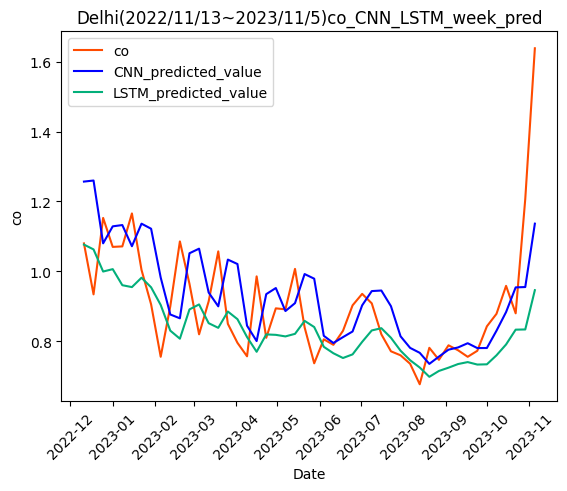

[I 2024-04-07 14:20:01,304] A new study created in memory with name: no-name-25a065bc-7e43-42e6-a9f4-0eae08ba57f0
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:20:03,485] Trial 0 finished with value: 0.022651685850331355 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.38193554030989363}. Best is trial 0 with value: 0.022651685850331355.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:20:08,824] Trial 1 finished with value: 0.017996772668225806 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.03589824260014246}. Best is trial 1 with value: 0.017996772668225806.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:11,226] Trial 2 finished with value: 0.022966070022014323 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.3124071874093496}. Best is trial 1 with value: 0.017996772668225806.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:20:14,219] Trial 3 finished with value: 0.02227434019639567 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.20284774805181383}. Best is trial 1 with value: 0.017996772668225806.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:18,773] Trial 4 finished with value: 0.01830875207429936 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 84, 'dropout_rate': 0.4280443085008056}. Best is trial 1 with value: 0.017996772668225806.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:20:21,818] Trial 5 finished with value: 0.01697520323335706 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.23440018973647575}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:20:24,206] Trial 6 finished with value: 0.02232856865142328 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 80, 'dropout_rate': 0.2353656943782002}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 14:20:26,554] Trial 7 finished with value: 0.0231474117426974 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 37, 'dropout_rate': 0.04096283971107334}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:28,607] Trial 8 finished with value: 0.02146761512175052 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 55, 'dropout_rate': 0.2876469975009567}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:31,581] Trial 9 finished with value: 0.025008682322109007 and parameters: {'num_conv_layers': 1, 'conv_filters': 59, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 59, 'dropout_rate': 0.35008316774776055}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:20:34,373] Trial 10 finished with value: 0.02032670517401138 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 34, 'dropout_rate': 0.13931608968838563}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:20:37,069] Trial 11 finished with value: 0.017801984152098483 and parameters: {'num_conv_layers': 1, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.004685042071966156}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:20:39,170] Trial 12 finished with value: 0.018625648220816183 and parameters: {'num_conv_layers': 1, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.1434922080337681}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:44,562] Trial 13 finished with value: 0.01745144411992586 and parameters: {'num_conv_layers': 1, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 70, 'dropout_rate': 0.11255010925681386}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:20:47,916] Trial 14 finished with value: 0.019725702029176322 and parameters: {'num_conv_layers': 1, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 71, 'dropout_rate': 0.13546214683035057}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:20:50,697] Trial 15 finished with value: 0.020864066144446847 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.4827649969946568}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:20:53,060] Trial 16 finished with value: 0.023057426760804623 and parameters: {'num_conv_layers': 1, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 65, 'dropout_rate': 0.08660908570696613}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 14:20:55,056] Trial 17 finished with value: 0.019472958498120013 and parameters: {'num_conv_layers': 1, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 50, 'dropout_rate': 0.19436661485520967}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:20:57,820] Trial 18 finished with value: 0.022170332264635217 and parameters: {'num_conv_layers': 1, 'conv_filters': 38, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 66, 'dropout_rate': 0.257242584819663}. Best is trial 5 with value: 0.01697520323335706.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:21:00,375] Trial 19 finished with value: 0.021673395107307213 and parameters: {'num_conv_layers': 1, 'conv_filters': 24, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.0861884461801456}. Best is trial 5 with value: 0.01697520323335706.


Best Hyperparameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.23440018973647575}
Epoch 1/50


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 4s - loss: 0.1949 - mae: 0.3469

5/5 [==============================] - 1s 7ms/step - loss: 0.1351 - mae: 0.2943
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0831 - mae: 0.2156

5/5 [==============================] - 0s 7ms/step - loss: 0.0738 - mae: 0.2019
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0462 - mae: 0.1460

5/5 [==============================] - 0s 6ms/step - loss: 0.0387 - mae: 0.1490
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0366 - mae: 0.1560

5/5 [==============================] - 0s 6ms/step - loss: 0.0330 - mae: 0.1466
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0520 - mae: 0.1752

5/5 [==============================] - 0s 6ms/step - loss: 0.0338 - mae: 0.1459
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0275 - mae: 0.1412

5/5 [==============================] - 0s 6ms/step - loss: 0.0309 - mae: 0.1434
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - mae: 0.1168

5/5 [==============================] - 0s 9ms/step - loss: 0.0336 - mae: 0.1324
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0430 - mae: 0.1473

5/5 [==============================] - 0s 8ms/step - loss: 0.0318 - mae: 0.1336
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0437 - mae: 0.1580

5/5 [==============================] - 0s 7ms/step - loss: 0.0308 - mae: 0.1321
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210 - mae: 0.1208

5/5 [==============================] - 0s 7ms/step - loss: 0.0268 - mae: 0.1246
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0161 - mae: 0.1009

5/5 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1287
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0221 - mae: 0.1044

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1185
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0177 - mae: 0.0971

5/5 [==============================] - 0s 9ms/step - loss: 0.0276 - mae: 0.1199
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0207 - mae: 0.1144

5/5 [==============================] - 0s 8ms/step - loss: 0.0258 - mae: 0.1186
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0333 - mae: 0.1455

5/5 [==============================] - 0s 7ms/step - loss: 0.0237 - mae: 0.1143
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - mae: 0.1133

5/5 [==============================] - 0s 7ms/step - loss: 0.0310 - mae: 0.1300
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1085

5/5 [==============================] - 0s 8ms/step - loss: 0.0268 - mae: 0.1218
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0294 - mae: 0.1377

5/5 [==============================] - 0s 7ms/step - loss: 0.0229 - mae: 0.1143
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281 - mae: 0.1311

5/5 [==============================] - 0s 8ms/step - loss: 0.0224 - mae: 0.1136
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0264 - mae: 0.1297

5/5 [==============================] - 0s 7ms/step - loss: 0.0251 - mae: 0.1185
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0242 - mae: 0.1194

5/5 [==============================] - 0s 8ms/step - loss: 0.0285 - mae: 0.1224
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0200 - mae: 0.1030

5/5 [==============================] - 0s 8ms/step - loss: 0.0236 - mae: 0.1141
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0323 - mae: 0.1330

5/5 [==============================] - 0s 6ms/step - loss: 0.0221 - mae: 0.1131
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - mae: 0.0873

5/5 [==============================] - 0s 8ms/step - loss: 0.0235 - mae: 0.1110
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0208 - mae: 0.1045

5/5 [==============================] - 0s 7ms/step - loss: 0.0241 - mae: 0.1131
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0339 - mae: 0.1422

5/5 [==============================] - 0s 7ms/step - loss: 0.0241 - mae: 0.1169
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0164 - mae: 0.1006

5/5 [==============================] - 0s 6ms/step - loss: 0.0238 - mae: 0.1121
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0257 - mae: 0.1130

5/5 [==============================] - 0s 6ms/step - loss: 0.0249 - mae: 0.1150
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0279 - mae: 0.1169

5/5 [==============================] - 0s 6ms/step - loss: 0.0246 - mae: 0.1128
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0273 - mae: 0.1157

5/5 [==============================] - 0s 6ms/step - loss: 0.0212 - mae: 0.1083
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0151 - mae: 0.0830

5/5 [==============================] - 0s 6ms/step - loss: 0.0202 - mae: 0.1067
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0241 - mae: 0.1096

5/5 [==============================] - 0s 7ms/step - loss: 0.0205 - mae: 0.1045
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0378 - mae: 0.1428

5/5 [==============================] - 0s 6ms/step - loss: 0.0227 - mae: 0.1122
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0300 - mae: 0.1330

5/5 [==============================] - 0s 6ms/step - loss: 0.0219 - mae: 0.1131
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0203 - mae: 0.1035

5/5 [==============================] - 0s 7ms/step - loss: 0.0254 - mae: 0.1175
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0939

5/5 [==============================] - 0s 6ms/step - loss: 0.0239 - mae: 0.1150
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1181

5/5 [==============================] - 0s 8ms/step - loss: 0.0211 - mae: 0.1058
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0224 - mae: 0.1034

5/5 [==============================] - 0s 6ms/step - loss: 0.0211 - mae: 0.1079
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0214 - mae: 0.1150

5/5 [==============================] - 0s 6ms/step - loss: 0.0216 - mae: 0.1039
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0242 - mae: 0.1079

5/5 [==============================] - 0s 6ms/step - loss: 0.0200 - mae: 0.1039
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201 - mae: 0.1108

5/5 [==============================] - 0s 7ms/step - loss: 0.0215 - mae: 0.1077
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1056

5/5 [==============================] - 0s 6ms/step - loss: 0.0315 - mae: 0.1265
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0177 - mae: 0.0946

5/5 [==============================] - 0s 7ms/step - loss: 0.0207 - mae: 0.1038
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0328 - mae: 0.1345

5/5 [==============================] - 0s 8ms/step - loss: 0.0249 - mae: 0.1140
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0147 - mae: 0.0916

5/5 [==============================] - 0s 7ms/step - loss: 0.0179 - mae: 0.0977
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184 - mae: 0.1089

5/5 [==============================] - 0s 6ms/step - loss: 0.0203 - mae: 0.1062
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137 - mae: 0.0882

5/5 [==============================] - 0s 6ms/step - loss: 0.0215 - mae: 0.1081
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0212 - mae: 0.0946

5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - mae: 0.0998
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1131

5/5 [==============================] - 0s 6ms/step - loss: 0.0203 - mae: 0.1063
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0205 - mae: 0.1120

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:21:04,578] A new study created in memory with name: no-name-8ca405a2-b31b-439c-b4a3-840aa990fae1
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.0285


[I 2024-04-07 14:21:19,964] Trial 0 finished with value: 0.02847202867269516 and parameters: {'n_lstm_layers': 3, 'units_0': 23, 'units_1': 41, 'units_2': 58, 'dropout_rate': 0.27460556725265944, 'learning_rate': 5.555693302729345e-05}. Best is trial 0 with value: 0.02847202867269516.


2/2 [==============================] - 0s 8ms/step - loss: 0.0249


[I 2024-04-07 14:21:27,981] Trial 1 finished with value: 0.02489738166332245 and parameters: {'n_lstm_layers': 1, 'units_0': 42, 'dropout_rate': 0.0016543517350729453, 'learning_rate': 0.0075911625009199585}. Best is trial 1 with value: 0.02489738166332245.


2/2 [==============================] - 0s 12ms/step - loss: 0.0245


[I 2024-04-07 14:21:38,032] Trial 2 finished with value: 0.02449416182935238 and parameters: {'n_lstm_layers': 2, 'units_0': 61, 'units_1': 67, 'dropout_rate': 0.021284923646657683, 'learning_rate': 0.0004370413002440541}. Best is trial 2 with value: 0.02449416182935238.


2/2 [==============================] - 0s 13ms/step - loss: 0.0435


[I 2024-04-07 14:21:43,126] Trial 3 finished with value: 0.04349304363131523 and parameters: {'n_lstm_layers': 1, 'units_0': 74, 'dropout_rate': 0.02296794284417819, 'learning_rate': 0.0003557224154694831}. Best is trial 2 with value: 0.02449416182935238.


2/2 [==============================] - 0s 11ms/step - loss: 0.0895


[I 2024-04-07 14:22:03,509] Trial 4 finished with value: 0.08952271193265915 and parameters: {'n_lstm_layers': 3, 'units_0': 27, 'units_1': 21, 'units_2': 30, 'dropout_rate': 0.08627075153903946, 'learning_rate': 3.023154232006199e-05}. Best is trial 2 with value: 0.02449416182935238.


2/2 [==============================] - 0s 14ms/step - loss: 0.0236


[I 2024-04-07 14:22:18,627] Trial 5 finished with value: 0.02357216738164425 and parameters: {'n_lstm_layers': 2, 'units_0': 92, 'units_1': 92, 'dropout_rate': 0.3579102712067722, 'learning_rate': 3.678436806428062e-05}. Best is trial 5 with value: 0.02357216738164425.


2/2 [==============================] - 0s 9ms/step - loss: 0.0233


[I 2024-04-07 14:22:25,442] Trial 6 finished with value: 0.02327629178762436 and parameters: {'n_lstm_layers': 2, 'units_0': 41, 'units_1': 93, 'dropout_rate': 0.3637804137317094, 'learning_rate': 0.0011768721391885004}. Best is trial 6 with value: 0.02327629178762436.


2/2 [==============================] - 0s 13ms/step - loss: 0.0241


[I 2024-04-07 14:22:31,769] Trial 7 finished with value: 0.024110471829771996 and parameters: {'n_lstm_layers': 1, 'units_0': 51, 'dropout_rate': 0.18524423198169088, 'learning_rate': 0.002012687185206679}. Best is trial 6 with value: 0.02327629178762436.


2/2 [==============================] - 0s 14ms/step - loss: 0.0261


[I 2024-04-07 14:22:46,747] Trial 8 finished with value: 0.026098767295479774 and parameters: {'n_lstm_layers': 3, 'units_0': 88, 'units_1': 29, 'units_2': 22, 'dropout_rate': 0.2560852282119861, 'learning_rate': 0.0014458982825073065}. Best is trial 6 with value: 0.02327629178762436.


2/2 [==============================] - 0s 15ms/step - loss: 0.0244


[I 2024-04-07 14:22:53,831] Trial 9 finished with value: 0.02443557046353817 and parameters: {'n_lstm_layers': 2, 'units_0': 31, 'units_1': 53, 'dropout_rate': 0.1906892743699084, 'learning_rate': 0.0010579506357225777}. Best is trial 6 with value: 0.02327629178762436.


2/2 [==============================] - 0s 14ms/step - loss: 0.0215


[I 2024-04-07 14:23:01,419] Trial 10 finished with value: 0.021492982283234596 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 97, 'dropout_rate': 0.4721789628043674, 'learning_rate': 0.00538642779052981}. Best is trial 10 with value: 0.021492982283234596.


2/2 [==============================] - 0s 14ms/step - loss: 0.0225


[I 2024-04-07 14:23:11,816] Trial 11 finished with value: 0.022546201944351196 and parameters: {'n_lstm_layers': 2, 'units_0': 67, 'units_1': 98, 'dropout_rate': 0.48400235968195854, 'learning_rate': 0.007494960336321813}. Best is trial 10 with value: 0.021492982283234596.


2/2 [==============================] - 0s 13ms/step - loss: 0.0199


[I 2024-04-07 14:23:21,448] Trial 12 finished with value: 0.019938195124268532 and parameters: {'n_lstm_layers': 2, 'units_0': 70, 'units_1': 76, 'dropout_rate': 0.49649380131703996, 'learning_rate': 0.009858152612498786}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 10ms/step - loss: 0.0200


[I 2024-04-07 14:23:28,482] Trial 13 finished with value: 0.019979042932391167 and parameters: {'n_lstm_layers': 2, 'units_0': 77, 'units_1': 74, 'dropout_rate': 0.47337858252193277, 'learning_rate': 0.009831804803154275}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 11ms/step - loss: 0.1171


[I 2024-04-07 14:23:40,046] Trial 14 finished with value: 0.11705845594406128 and parameters: {'n_lstm_layers': 1, 'units_0': 78, 'dropout_rate': 0.3980861195626517, 'learning_rate': 1.1131708281006491e-05}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 12ms/step - loss: 0.0251


[I 2024-04-07 14:23:51,553] Trial 15 finished with value: 0.02509348653256893 and parameters: {'n_lstm_layers': 3, 'units_0': 99, 'units_1': 72, 'units_2': 99, 'dropout_rate': 0.4455380203987245, 'learning_rate': 0.0032045724279769236}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 8ms/step - loss: 0.0235


[I 2024-04-07 14:24:00,992] Trial 16 finished with value: 0.02347780205309391 and parameters: {'n_lstm_layers': 2, 'units_0': 82, 'units_1': 78, 'dropout_rate': 0.4144649715381844, 'learning_rate': 9.744988727605126e-05}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 9ms/step - loss: 0.0246


[I 2024-04-07 14:24:08,976] Trial 17 finished with value: 0.024624228477478027 and parameters: {'n_lstm_layers': 1, 'units_0': 56, 'dropout_rate': 0.3188681927742827, 'learning_rate': 0.00933913303983326}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 11ms/step - loss: 0.0241


[I 2024-04-07 14:24:22,065] Trial 18 finished with value: 0.024123994633555412 and parameters: {'n_lstm_layers': 3, 'units_0': 71, 'units_1': 81, 'units_2': 97, 'dropout_rate': 0.494580649857927, 'learning_rate': 0.003452803150462066}. Best is trial 12 with value: 0.019938195124268532.


2/2 [==============================] - 0s 13ms/step - loss: 0.0233


[I 2024-04-07 14:24:31,967] Trial 19 finished with value: 0.023254448547959328 and parameters: {'n_lstm_layers': 2, 'units_0': 84, 'units_1': 56, 'dropout_rate': 0.4289787300468607, 'learning_rate': 0.0007403462687749692}. Best is trial 12 with value: 0.019938195124268532.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 70, 'units_1': 76, 'dropout_rate': 0.49649380131703996, 'learning_rate': 0.009858152612498786}
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1188 

5/5 [==============================] - 8s 19ms/step - loss: 0.1079
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0507

5/5 [==============================] - 0s 18ms/step - loss: 0.0507
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0522

5/5 [==============================] - 0s 18ms/step - loss: 0.0545
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0528

5/5 [==============================] - 0s 18ms/step - loss: 0.0497
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0383

5/5 [==============================] - 0s 19ms/step - loss: 0.0385
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0388

5/5 [==============================] - 0s 21ms/step - loss: 0.0429
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0415

5/5 [==============================] - 0s 25ms/step - loss: 0.0412
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0362

5/5 [==============================] - 0s 27ms/step - loss: 0.0421
Epoch 9/50
3/5 [=================>............] - ETA: 0s - loss: 0.0390

5/5 [==============================] - 0s 25ms/step - loss: 0.0390
Epoch 10/50
3/5 [=================>............] - ETA: 0s - loss: 0.0333

5/5 [==============================] - 0s 26ms/step - loss: 0.0377
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0426

5/5 [==============================] - 0s 27ms/step - loss: 0.0397
Epoch 12/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0325

5/5 [==============================] - 0s 24ms/step - loss: 0.0317
Epoch 13/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0426

5/5 [==============================] - 0s 22ms/step - loss: 0.0389
Epoch 14/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0374

5/5 [==============================] - 0s 22ms/step - loss: 0.0373
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0289

5/5 [==============================] - 0s 19ms/step - loss: 0.0314
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 21ms/step - loss: 0.0294
Epoch 17/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0340

5/5 [==============================] - 0s 24ms/step - loss: 0.0360
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0294

5/5 [==============================] - 0s 19ms/step - loss: 0.0285
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 20ms/step - loss: 0.0255
Epoch 20/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0360

5/5 [==============================] - 0s 19ms/step - loss: 0.0344
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 21ms/step - loss: 0.0272
Epoch 22/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0429

5/5 [==============================] - 0s 19ms/step - loss: 0.0404
Epoch 23/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0422

5/5 [==============================] - 0s 19ms/step - loss: 0.0410
Epoch 24/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0332

5/5 [==============================] - 0s 20ms/step - loss: 0.0334
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 18ms/step - loss: 0.0305
Epoch 26/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0335

5/5 [==============================] - 0s 20ms/step - loss: 0.0364
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0341

5/5 [==============================] - 0s 20ms/step - loss: 0.0319
Epoch 28/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0361

5/5 [==============================] - 0s 19ms/step - loss: 0.0352
Epoch 29/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0356

5/5 [==============================] - 0s 18ms/step - loss: 0.0372
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 18ms/step - loss: 0.0298
Epoch 31/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0355

5/5 [==============================] - 0s 18ms/step - loss: 0.0335
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0271

5/5 [==============================] - 0s 18ms/step - loss: 0.0267
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0328

5/5 [==============================] - 0s 18ms/step - loss: 0.0328
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0351

5/5 [==============================] - 0s 20ms/step - loss: 0.0346
Epoch 35/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 18ms/step - loss: 0.0297
Epoch 36/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0328

5/5 [==============================] - 0s 18ms/step - loss: 0.0317
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0235

5/5 [==============================] - 0s 19ms/step - loss: 0.0248
Epoch 38/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0374

5/5 [==============================] - 0s 24ms/step - loss: 0.0360
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 20ms/step - loss: 0.0240
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 20ms/step - loss: 0.0253
Epoch 41/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0265

5/5 [==============================] - 0s 21ms/step - loss: 0.0259
Epoch 42/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0322

5/5 [==============================] - 0s 20ms/step - loss: 0.0300
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0308

5/5 [==============================] - 0s 22ms/step - loss: 0.0299
Epoch 44/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 23ms/step - loss: 0.0241
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0285

5/5 [==============================] - 0s 19ms/step - loss: 0.0267
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0224

5/5 [==============================] - 0s 20ms/step - loss: 0.0243
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0333

5/5 [==============================] - 0s 19ms/step - loss: 0.0307
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0349

5/5 [==============================] - 0s 20ms/step - loss: 0.0345
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0299

5/5 [==============================] - 0s 19ms/step - loss: 0.0277
Epoch 50/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0296

2/2 [==============================] - 1s 9ms/step


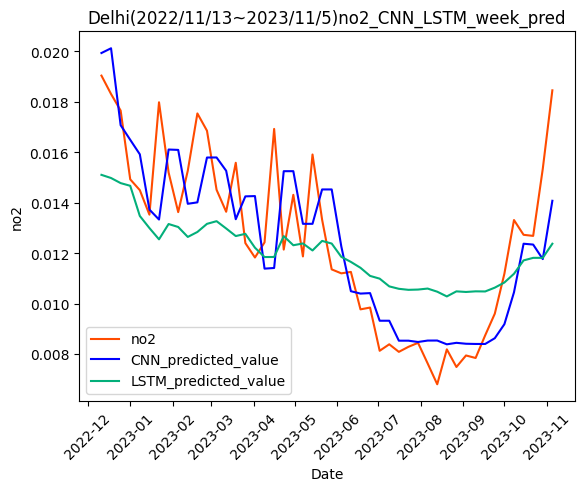

[I 2024-04-07 14:24:51,573] A new study created in memory with name: no-name-4b227e1c-fe85-469b-95f7-87deade0d611
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-07 14:24:56,200] Trial 0 finished with value: 0.00987069385222652 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.2698209793327399}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:24:59,680] Trial 1 finished with value: 0.014546900233108057 and parameters: {'num_conv_layers': 1, 'conv_filters': 40, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.41266358161167066}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:25:02,454] Trial 2 finished with value: 0.0239883772541189 and parameters: {'num_conv_layers': 1, 'conv_filters': 28, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 40, 'dropout_rate': 0.31031165117687126}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 14:25:05,537] Trial 3 finished with value: 0.020033186494746995 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 36, 'dropout_rate': 0.40518587715224397}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:25:08,773] Trial 4 finished with value: 0.023007192239009867 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.17371329539373587}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:25:11,238] Trial 5 finished with value: 0.027831444723607556 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 43, 'dropout_rate': 0.07076777002426826}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:25:14,163] Trial 6 finished with value: 0.024940976551359847 and parameters: {'num_conv_layers': 2, 'conv_filters': 56, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 33, 'dropout_rate': 0.27050447547584516}. Best is trial 0 with value: 0.00987069385222652.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:25:18,461] Trial 7 finished with value: 0.009832327118081956 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 83, 'dropout_rate': 0.1096476731984154}. Best is trial 7 with value: 0.009832327118081956.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:25:21,467] Trial 8 finished with value: 0.022926826425066344 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 83, 'dropout_rate': 0.017314754363640716}. Best is trial 7 with value: 0.009832327118081956.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:25:27,717] Trial 9 finished with value: 0.014428851335562638 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 91, 'dropout_rate': 0.30168471386578477}. Best is trial 7 with value: 0.009832327118081956.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:25:29,631] Trial 10 finished with value: 0.019095394878942153 and parameters: {'num_conv_layers': 1, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 66, 'dropout_rate': 0.13737075862681242}. Best is trial 7 with value: 0.009832327118081956.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:25:34,082] Trial 11 finished with value: 0.008574100593440936 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.18608869501959177}. Best is trial 11 with value: 0.008574100593440936.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:25:38,627] Trial 12 finished with value: 0.008416084902888758 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.15996862587864596}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 14:25:45,563] Trial 13 finished with value: 0.009182937929502016 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.19750204071621397}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:25:49,117] Trial 14 finished with value: 0.021948394579267155 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.2121628890783255}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:25:54,148] Trial 15 finished with value: 0.009987865578619427 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.48426462395892217}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:25:56,529] Trial 16 finished with value: 0.02859209876112025 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 74, 'dropout_rate': 0.05099271097550678}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-07 14:25:58,435] Trial 17 finished with value: 0.024780296735154767 and parameters: {'num_conv_layers': 1, 'conv_filters': 50, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 89, 'dropout_rate': 0.11384296663647311}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:26:01,360] Trial 18 finished with value: 0.031650331065887494 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 89, 'dropout_rate': 0.220652700302713}. Best is trial 12 with value: 0.008416084902888758.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:26:04,328] Trial 19 finished with value: 0.0178340269059817 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 51, 'dropout_rate': 0.1575660559069586}. Best is trial 12 with value: 0.008416084902888758.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.15996862587864596}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.2596 - mae: 0.4575

5/5 [==============================] - 1s 7ms/step - loss: 0.1469 - mae: 0.3238
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0556 - mae: 0.1843

5/5 [==============================] - 0s 8ms/step - loss: 0.0407 - mae: 0.1515
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0202 - mae: 0.1157

5/5 [==============================] - 0s 8ms/step - loss: 0.0272 - mae: 0.1379
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0247 - mae: 0.1319

5/5 [==============================] - 0s 8ms/step - loss: 0.0262 - mae: 0.1363
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0194 - mae: 0.1174

5/5 [==============================] - 0s 7ms/step - loss: 0.0201 - mae: 0.1087
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0189 - mae: 0.0980

5/5 [==============================] - 0s 8ms/step - loss: 0.0202 - mae: 0.1050
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0209 - mae: 0.1050

5/5 [==============================] - 0s 7ms/step - loss: 0.0191 - mae: 0.1094
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0138 - mae: 0.1029

5/5 [==============================] - 0s 7ms/step - loss: 0.0171 - mae: 0.1076
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0156 - mae: 0.0985

5/5 [==============================] - 0s 8ms/step - loss: 0.0170 - mae: 0.1072
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0112 - mae: 0.0841

5/5 [==============================] - 0s 8ms/step - loss: 0.0182 - mae: 0.1070
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0190 - mae: 0.1121

5/5 [==============================] - 0s 10ms/step - loss: 0.0164 - mae: 0.1015
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0092 - mae: 0.0762

5/5 [==============================] - 0s 10ms/step - loss: 0.0172 - mae: 0.1008
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - mae: 0.0799

5/5 [==============================] - 0s 11ms/step - loss: 0.0147 - mae: 0.0972
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0179 - mae: 0.1167

5/5 [==============================] - 0s 9ms/step - loss: 0.0148 - mae: 0.0955
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121 - mae: 0.0813

5/5 [==============================] - 0s 8ms/step - loss: 0.0139 - mae: 0.0870
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0152 - mae: 0.0924

5/5 [==============================] - 0s 7ms/step - loss: 0.0165 - mae: 0.0984
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0963

5/5 [==============================] - 0s 9ms/step - loss: 0.0160 - mae: 0.1001
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0146 - mae: 0.1025

5/5 [==============================] - 0s 8ms/step - loss: 0.0162 - mae: 0.1008
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0084 - mae: 0.0648

5/5 [==============================] - 0s 8ms/step - loss: 0.0152 - mae: 0.0955
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0155 - mae: 0.0873

5/5 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.1021
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0173 - mae: 0.1032

5/5 [==============================] - 0s 7ms/step - loss: 0.0153 - mae: 0.0974
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0185 - mae: 0.0938

5/5 [==============================] - 0s 9ms/step - loss: 0.0161 - mae: 0.0931
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0203 - mae: 0.1052

5/5 [==============================] - 0s 8ms/step - loss: 0.0162 - mae: 0.0976
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0189 - mae: 0.1024

5/5 [==============================] - 0s 8ms/step - loss: 0.0146 - mae: 0.0934
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0164 - mae: 0.0929

5/5 [==============================] - 0s 8ms/step - loss: 0.0155 - mae: 0.0965
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0062 - mae: 0.0636

5/5 [==============================] - 0s 8ms/step - loss: 0.0130 - mae: 0.0890
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0143 - mae: 0.0912

5/5 [==============================] - 0s 8ms/step - loss: 0.0139 - mae: 0.0907
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0198 - mae: 0.1054

5/5 [==============================] - 0s 8ms/step - loss: 0.0154 - mae: 0.0946
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0817

5/5 [==============================] - 0s 7ms/step - loss: 0.0146 - mae: 0.0931
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0133 - mae: 0.0865

5/5 [==============================] - 0s 8ms/step - loss: 0.0129 - mae: 0.0855
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0102 - mae: 0.0786

5/5 [==============================] - 0s 7ms/step - loss: 0.0122 - mae: 0.0868
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0092 - mae: 0.0715

5/5 [==============================] - 0s 7ms/step - loss: 0.0131 - mae: 0.0892
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0094 - mae: 0.0720

5/5 [==============================] - 0s 8ms/step - loss: 0.0155 - mae: 0.0969
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0163 - mae: 0.0868

5/5 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.0950
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0170 - mae: 0.0997

5/5 [==============================] - 0s 9ms/step - loss: 0.0138 - mae: 0.0911
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0162 - mae: 0.0948

5/5 [==============================] - 0s 11ms/step - loss: 0.0144 - mae: 0.0910
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1136

5/5 [==============================] - 0s 7ms/step - loss: 0.0135 - mae: 0.0876
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - mae: 0.0712

5/5 [==============================] - 0s 7ms/step - loss: 0.0144 - mae: 0.0923
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0140 - mae: 0.0954

5/5 [==============================] - 0s 8ms/step - loss: 0.0141 - mae: 0.0933
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0123 - mae: 0.0844

5/5 [==============================] - 0s 7ms/step - loss: 0.0122 - mae: 0.0849
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0214 - mae: 0.1066

5/5 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0900
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0116 - mae: 0.0850

5/5 [==============================] - 0s 7ms/step - loss: 0.0129 - mae: 0.0857
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0094 - mae: 0.0763

5/5 [==============================] - 0s 8ms/step - loss: 0.0129 - mae: 0.0868
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0953

5/5 [==============================] - 0s 8ms/step - loss: 0.0124 - mae: 0.0847
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0878

5/5 [==============================] - 0s 9ms/step - loss: 0.0149 - mae: 0.0933
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0161 - mae: 0.0945

5/5 [==============================] - 0s 8ms/step - loss: 0.0136 - mae: 0.0854
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0160 - mae: 0.0976

5/5 [==============================] - 0s 9ms/step - loss: 0.0148 - mae: 0.0906
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0075 - mae: 0.0688

5/5 [==============================] - 0s 8ms/step - loss: 0.0141 - mae: 0.0884
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0096 - mae: 0.0735

5/5 [==============================] - 0s 8ms/step - loss: 0.0115 - mae: 0.0805
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0079 - mae: 0.0724

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:26:08,723] A new study created in memory with name: no-name-cdd0b805-53b6-4b2a-9704-fb328dd85d23
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.0853


[I 2024-04-07 14:26:23,625] Trial 0 finished with value: 0.08525020629167557 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 85, 'dropout_rate': 0.3948253131650246, 'learning_rate': 1.0208722367447158e-05}. Best is trial 0 with value: 0.08525020629167557.


2/2 [==============================] - 0s 8ms/step - loss: 0.0268


[I 2024-04-07 14:26:30,835] Trial 1 finished with value: 0.026762159541249275 and parameters: {'n_lstm_layers': 1, 'units_0': 100, 'dropout_rate': 0.09652927247743709, 'learning_rate': 0.0008451901033412567}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 8ms/step - loss: 0.0404


[I 2024-04-07 14:26:35,966] Trial 2 finished with value: 0.04041638597846031 and parameters: {'n_lstm_layers': 1, 'units_0': 24, 'dropout_rate': 0.46812199969144164, 'learning_rate': 0.0009825841844853785}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 8ms/step - loss: 0.0460


[I 2024-04-07 14:26:48,752] Trial 3 finished with value: 0.04598674178123474 and parameters: {'n_lstm_layers': 1, 'units_0': 68, 'dropout_rate': 0.41368287562006784, 'learning_rate': 0.00014554302466971935}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 16ms/step - loss: 0.0303


[I 2024-04-07 14:27:02,097] Trial 4 finished with value: 0.030314868316054344 and parameters: {'n_lstm_layers': 3, 'units_0': 70, 'units_1': 99, 'units_2': 84, 'dropout_rate': 0.23942463868811975, 'learning_rate': 0.0002269955427737444}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 11ms/step - loss: 0.1052


[I 2024-04-07 14:27:10,408] Trial 5 finished with value: 0.10524825006723404 and parameters: {'n_lstm_layers': 1, 'units_0': 86, 'dropout_rate': 0.1256967926000146, 'learning_rate': 1.7129846181120878e-05}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 14ms/step - loss: 0.0301


[I 2024-04-07 14:27:27,019] Trial 6 finished with value: 0.03005717508494854 and parameters: {'n_lstm_layers': 3, 'units_0': 100, 'units_1': 71, 'units_2': 64, 'dropout_rate': 0.36750907203952193, 'learning_rate': 6.995501479472398e-05}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 13ms/step - loss: 0.0346


[I 2024-04-07 14:27:38,249] Trial 7 finished with value: 0.03460166975855827 and parameters: {'n_lstm_layers': 3, 'units_0': 63, 'units_1': 98, 'units_2': 75, 'dropout_rate': 0.4577142232834762, 'learning_rate': 0.0011708935881961525}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 12ms/step - loss: 0.0277


[I 2024-04-07 14:27:44,502] Trial 8 finished with value: 0.02769491635262966 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 31, 'dropout_rate': 0.059659811266524865, 'learning_rate': 0.0009420755884478305}. Best is trial 1 with value: 0.026762159541249275.


2/2 [==============================] - 0s 10ms/step - loss: 0.0256


[I 2024-04-07 14:27:56,605] Trial 9 finished with value: 0.025639712810516357 and parameters: {'n_lstm_layers': 2, 'units_0': 47, 'units_1': 41, 'dropout_rate': 0.06891298970099152, 'learning_rate': 0.00011669082239391471}. Best is trial 9 with value: 0.025639712810516357.


2/2 [==============================] - 0s 9ms/step - loss: 0.0185


[I 2024-04-07 14:28:05,401] Trial 10 finished with value: 0.018531223759055138 and parameters: {'n_lstm_layers': 2, 'units_0': 36, 'units_1': 35, 'dropout_rate': 0.20488101609486498, 'learning_rate': 0.00471389641569843}. Best is trial 10 with value: 0.018531223759055138.


2/2 [==============================] - 0s 10ms/step - loss: 0.0187


[I 2024-04-07 14:28:12,454] Trial 11 finished with value: 0.018684102222323418 and parameters: {'n_lstm_layers': 2, 'units_0': 36, 'units_1': 35, 'dropout_rate': 0.2013532350027248, 'learning_rate': 0.007824012970292697}. Best is trial 10 with value: 0.018531223759055138.


2/2 [==============================] - 0s 10ms/step - loss: 0.0171


[I 2024-04-07 14:28:21,936] Trial 12 finished with value: 0.01708666794002056 and parameters: {'n_lstm_layers': 2, 'units_0': 33, 'units_1': 47, 'dropout_rate': 0.22566355690326262, 'learning_rate': 0.008362649635894785}. Best is trial 12 with value: 0.01708666794002056.


2/2 [==============================] - 0s 8ms/step - loss: 0.0178


[I 2024-04-07 14:28:32,150] Trial 13 finished with value: 0.017844773828983307 and parameters: {'n_lstm_layers': 2, 'units_0': 20, 'units_1': 55, 'dropout_rate': 0.2858232317587602, 'learning_rate': 0.008254974711615525}. Best is trial 12 with value: 0.01708666794002056.


2/2 [==============================] - 0s 10ms/step - loss: 0.0292


[I 2024-04-07 14:28:39,169] Trial 14 finished with value: 0.02915758639574051 and parameters: {'n_lstm_layers': 2, 'units_0': 22, 'units_1': 57, 'dropout_rate': 0.3046706492380914, 'learning_rate': 0.0028615170765823594}. Best is trial 12 with value: 0.01708666794002056.


2/2 [==============================] - 0s 11ms/step - loss: 0.0358


[I 2024-04-07 14:28:54,662] Trial 15 finished with value: 0.03580480441451073 and parameters: {'n_lstm_layers': 3, 'units_0': 48, 'units_1': 55, 'units_2': 21, 'dropout_rate': 0.2963581282696242, 'learning_rate': 0.0026641719107941097}. Best is trial 12 with value: 0.01708666794002056.


2/2 [==============================] - 0s 12ms/step - loss: 0.0078


[I 2024-04-07 14:29:05,214] Trial 16 finished with value: 0.007803833112120628 and parameters: {'n_lstm_layers': 2, 'units_0': 32, 'units_1': 50, 'dropout_rate': 0.00338754051453255, 'learning_rate': 0.009015739419412295}. Best is trial 16 with value: 0.007803833112120628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0213


[I 2024-04-07 14:29:17,429] Trial 17 finished with value: 0.02127744071185589 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 21, 'units_2': 31, 'dropout_rate': 0.02709444448638154, 'learning_rate': 0.0030757457243325965}. Best is trial 16 with value: 0.007803833112120628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0390


[I 2024-04-07 14:29:24,823] Trial 18 finished with value: 0.03902094438672066 and parameters: {'n_lstm_layers': 1, 'units_0': 49, 'dropout_rate': 0.15476299943928523, 'learning_rate': 0.0005307007814296742}. Best is trial 16 with value: 0.007803833112120628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0083


[I 2024-04-07 14:29:37,029] Trial 19 finished with value: 0.008275081403553486 and parameters: {'n_lstm_layers': 2, 'units_0': 55, 'units_1': 71, 'dropout_rate': 0.025404961812340345, 'learning_rate': 0.008244986180669468}. Best is trial 16 with value: 0.007803833112120628.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 32, 'units_1': 50, 'dropout_rate': 0.00338754051453255, 'learning_rate': 0.009015739419412295}
Epoch 1/50
1/5 [=====>........................] - ETA: 16s - loss: 0.2577

5/5 [==============================] - 4s 13ms/step - loss: 0.1216
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0304

5/5 [==============================] - 0s 17ms/step - loss: 0.0304
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0296

5/5 [==============================] - 0s 17ms/step - loss: 0.0296
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0211

5/5 [==============================] - 0s 19ms/step - loss: 0.0211
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0154

5/5 [==============================] - 0s 17ms/step - loss: 0.0154
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0159

5/5 [==============================] - 0s 16ms/step - loss: 0.0159
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0155

5/5 [==============================] - 0s 16ms/step - loss: 0.0155
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0146

5/5 [==============================] - 0s 16ms/step - loss: 0.0146
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0144

5/5 [==============================] - 0s 18ms/step - loss: 0.0144
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0138

5/5 [==============================] - 0s 15ms/step - loss: 0.0138
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 15ms/step - loss: 0.0141
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0148

5/5 [==============================] - 0s 17ms/step - loss: 0.0148
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0140

5/5 [==============================] - 0s 17ms/step - loss: 0.0140
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.0126

5/5 [==============================] - 0s 17ms/step - loss: 0.0126
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0136

5/5 [==============================] - 0s 16ms/step - loss: 0.0136
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0128

5/5 [==============================] - 0s 16ms/step - loss: 0.0128
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0129

5/5 [==============================] - 0s 15ms/step - loss: 0.0129
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0128

5/5 [==============================] - 0s 19ms/step - loss: 0.0128
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0123

5/5 [==============================] - 0s 16ms/step - loss: 0.0123
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0121

5/5 [==============================] - 0s 17ms/step - loss: 0.0121
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0121

5/5 [==============================] - 0s 17ms/step - loss: 0.0121
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0124

5/5 [==============================] - 0s 16ms/step - loss: 0.0124
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0109

5/5 [==============================] - 0s 20ms/step - loss: 0.0109
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0112

5/5 [==============================] - 0s 17ms/step - loss: 0.0112
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0112

5/5 [==============================] - 0s 16ms/step - loss: 0.0112
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0112

5/5 [==============================] - 0s 17ms/step - loss: 0.0112
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0108

5/5 [==============================] - 0s 15ms/step - loss: 0.0108
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0105

5/5 [==============================] - 0s 17ms/step - loss: 0.0105
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0106

5/5 [==============================] - 0s 18ms/step - loss: 0.0104
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0133

5/5 [==============================] - 0s 16ms/step - loss: 0.0133
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0103

5/5 [==============================] - 0s 17ms/step - loss: 0.0103
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0097

5/5 [==============================] - 0s 17ms/step - loss: 0.0097
Epoch 34/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0123

5/5 [==============================] - 0s 19ms/step - loss: 0.0119
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0098

5/5 [==============================] - 0s 16ms/step - loss: 0.0098
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0099

5/5 [==============================] - 0s 16ms/step - loss: 0.0099
Epoch 37/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0099

5/5 [==============================] - 0s 19ms/step - loss: 0.0103
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0104

5/5 [==============================] - 0s 16ms/step - loss: 0.0104
Epoch 39/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0103

5/5 [==============================] - 0s 19ms/step - loss: 0.0108
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 18ms/step - loss: 0.0160
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0115

5/5 [==============================] - 0s 17ms/step - loss: 0.0115
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0112

5/5 [==============================] - 0s 17ms/step - loss: 0.0112
Epoch 43/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0096

5/5 [==============================] - 0s 18ms/step - loss: 0.0102
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0093

5/5 [==============================] - 0s 18ms/step - loss: 0.0093
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0093

5/5 [==============================] - 0s 18ms/step - loss: 0.0093
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0125

5/5 [==============================] - 0s 20ms/step - loss: 0.0121
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0092

5/5 [==============================] - 0s 14ms/step - loss: 0.0092
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0094

5/5 [==============================] - 0s 21ms/step - loss: 0.0100
Epoch 49/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0128

5/5 [==============================] - 0s 23ms/step - loss: 0.0120
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0103

2/2 [==============================] - 1s 5ms/step


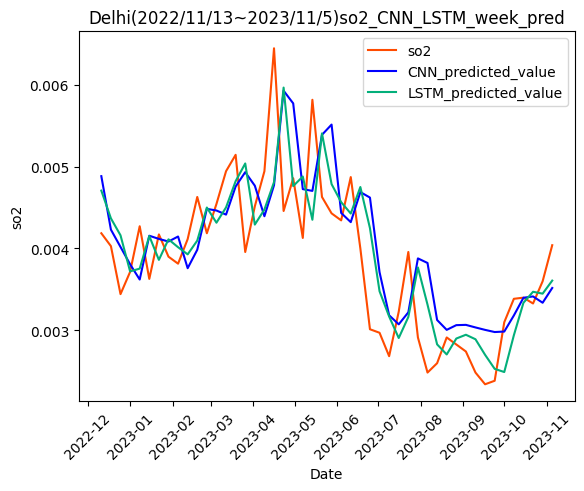

[I 2024-04-07 14:29:53,384] A new study created in memory with name: no-name-1af54bd8-04ef-4a33-97b7-c459d769e9d2
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:29:55,202] Trial 0 finished with value: 0.014700162273173015 and parameters: {'num_conv_layers': 1, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.056106148896608754}. Best is trial 0 with value: 0.014700162273173015.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:29:56,917] Trial 1 finished with value: 0.015433660603700834 and parameters: {'num_conv_layers': 1, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 68, 'dropout_rate': 0.4415755935872763}. Best is trial 0 with value: 0.014700162273173015.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:29:58,571] Trial 2 finished with value: 0.013517083262358587 and parameters: {'num_conv_layers': 1, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 97, 'dropout_rate': 0.18137396088682822}. Best is trial 2 with value: 0.013517083262358587.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:30:00,566] Trial 3 finished with value: 0.01304785927076219 and parameters: {'num_conv_layers': 1, 'conv_filters': 38, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 87, 'dropout_rate': 0.029925664473515246}. Best is trial 3 with value: 0.01304785927076219.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:03,177] Trial 4 finished with value: 0.013761452690832092 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 64, 'dropout_rate': 0.11357964447423485}. Best is trial 3 with value: 0.01304785927076219.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:30:10,148] Trial 5 finished with value: 0.009806652016831034 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 97, 'dropout_rate': 0.06276910756401427}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-07 14:30:12,918] Trial 6 finished with value: 0.014097891908532091 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.37980578628951345}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:16,874] Trial 7 finished with value: 0.012506169203366823 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.30012686836203795}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:30:19,893] Trial 8 finished with value: 0.013815590699530955 and parameters: {'num_conv_layers': 1, 'conv_filters': 37, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 54, 'dropout_rate': 0.41407866171069924}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:22,636] Trial 9 finished with value: 0.010069467650331796 and parameters: {'num_conv_layers': 1, 'conv_filters': 61, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 39, 'dropout_rate': 0.45532442121342903}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:30:25,272] Trial 10 finished with value: 0.013930356562025981 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 32, 'dropout_rate': 0.22583692776617664}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:30:30,331] Trial 11 finished with value: 0.010446200834719739 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 41, 'dropout_rate': 0.30513204149818896}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-07 14:30:32,898] Trial 12 finished with value: 0.014767195958608315 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 49, 'dropout_rate': 0.4965798521078121}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:30:35,281] Trial 13 finished with value: 0.011839770755213941 and parameters: {'num_conv_layers': 1, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.12501086152383334}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-07 14:30:37,076] Trial 14 finished with value: 0.014887853998663469 and parameters: {'num_conv_layers': 1, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 96, 'dropout_rate': 0.32763412499747957}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:39,403] Trial 15 finished with value: 0.014305953463846036 and parameters: {'num_conv_layers': 2, 'conv_filters': 45, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 57, 'dropout_rate': 0.20781563052219976}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:42,691] Trial 16 finished with value: 0.015593187583663412 and parameters: {'num_conv_layers': 1, 'conv_filters': 57, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 35, 'dropout_rate': 0.13687407739644167}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:44,775] Trial 17 finished with value: 0.012243875235579049 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 44, 'dropout_rate': 0.010632776582995968}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:49,727] Trial 18 finished with value: 0.012133435879324505 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.271681684851236}. Best is trial 5 with value: 0.009806652016831034.
<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-07 14:30:52,627] Trial 19 finished with value: 0.012983311407693642 and parameters: {'num_conv_layers': 1, 'conv_filters': 31, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 63, 'dropout_rate': 0.3597688993441187}. Best is trial 5 with value: 0.009806652016831034.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 97, 'dropout_rate': 0.06276910756401427}


<ipython-input-12-9809969e7cf4>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 10s - loss: 0.1849 - mae: 0.3732

5/5 [==============================] - 3s 13ms/step - loss: 0.1325 - mae: 0.2996
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0822 - mae: 0.2416

5/5 [==============================] - 0s 10ms/step - loss: 0.0722 - mae: 0.2066
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0328 - mae: 0.1335

5/5 [==============================] - 0s 10ms/step - loss: 0.0286 - mae: 0.1206
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0222 - mae: 0.1195

5/5 [==============================] - 0s 8ms/step - loss: 0.0247 - mae: 0.1319
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216 - mae: 0.1261

5/5 [==============================] - 0s 10ms/step - loss: 0.0249 - mae: 0.1335
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0265 - mae: 0.1352

5/5 [==============================] - 0s 9ms/step - loss: 0.0184 - mae: 0.1083
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0303 - mae: 0.1257

5/5 [==============================] - 0s 10ms/step - loss: 0.0200 - mae: 0.1049
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0170 - mae: 0.1029

5/5 [==============================] - 0s 10ms/step - loss: 0.0181 - mae: 0.1025
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0134 - mae: 0.0899

5/5 [==============================] - 0s 9ms/step - loss: 0.0146 - mae: 0.0951
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0158 - mae: 0.0981

5/5 [==============================] - 0s 10ms/step - loss: 0.0157 - mae: 0.0982
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0990

5/5 [==============================] - 0s 9ms/step - loss: 0.0141 - mae: 0.0904
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183 - mae: 0.1009

5/5 [==============================] - 0s 10ms/step - loss: 0.0144 - mae: 0.0883
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0199 - mae: 0.1087

5/5 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.0908
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0129 - mae: 0.0896

5/5 [==============================] - 0s 12ms/step - loss: 0.0135 - mae: 0.0858
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0110 - mae: 0.0769

5/5 [==============================] - 0s 11ms/step - loss: 0.0136 - mae: 0.0858
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0067 - mae: 0.0616

5/5 [==============================] - 0s 14ms/step - loss: 0.0119 - mae: 0.0795
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0103 - mae: 0.0781

5/5 [==============================] - 0s 13ms/step - loss: 0.0117 - mae: 0.0797
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0065 - mae: 0.0584

5/5 [==============================] - 0s 13ms/step - loss: 0.0116 - mae: 0.0763
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121 - mae: 0.0850

5/5 [==============================] - 0s 10ms/step - loss: 0.0125 - mae: 0.0809
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0887

5/5 [==============================] - 0s 8ms/step - loss: 0.0119 - mae: 0.0804
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0105 - mae: 0.0753

5/5 [==============================] - 0s 9ms/step - loss: 0.0116 - mae: 0.0791
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0130 - mae: 0.0838

5/5 [==============================] - 0s 8ms/step - loss: 0.0121 - mae: 0.0814
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0119 - mae: 0.0761

5/5 [==============================] - 0s 9ms/step - loss: 0.0122 - mae: 0.0813
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0085 - mae: 0.0703

5/5 [==============================] - 0s 8ms/step - loss: 0.0114 - mae: 0.0788
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0083 - mae: 0.0681

5/5 [==============================] - 0s 8ms/step - loss: 0.0116 - mae: 0.0787
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0081 - mae: 0.0673

5/5 [==============================] - 0s 8ms/step - loss: 0.0108 - mae: 0.0767
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0116 - mae: 0.0792

5/5 [==============================] - 0s 7ms/step - loss: 0.0125 - mae: 0.0799
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0174 - mae: 0.1012

5/5 [==============================] - 0s 8ms/step - loss: 0.0118 - mae: 0.0789
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0086 - mae: 0.0660

5/5 [==============================] - 0s 8ms/step - loss: 0.0109 - mae: 0.0766
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0070 - mae: 0.0604

5/5 [==============================] - 0s 8ms/step - loss: 0.0107 - mae: 0.0775
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0061 - mae: 0.0608

5/5 [==============================] - 0s 8ms/step - loss: 0.0110 - mae: 0.0785
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0712

5/5 [==============================] - 0s 8ms/step - loss: 0.0116 - mae: 0.0775
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - mae: 0.0575

5/5 [==============================] - 0s 7ms/step - loss: 0.0111 - mae: 0.0781
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - mae: 0.0727

5/5 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0781
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0082 - mae: 0.0748

5/5 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.0740
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0087 - mae: 0.0616

5/5 [==============================] - 0s 7ms/step - loss: 0.0107 - mae: 0.0748
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0130 - mae: 0.0851

5/5 [==============================] - 0s 8ms/step - loss: 0.0110 - mae: 0.0791
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0104 - mae: 0.0820

5/5 [==============================] - 0s 8ms/step - loss: 0.0119 - mae: 0.0791
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - mae: 0.0742

5/5 [==============================] - 0s 9ms/step - loss: 0.0113 - mae: 0.0778
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0093 - mae: 0.0757

5/5 [==============================] - 0s 8ms/step - loss: 0.0115 - mae: 0.0788
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0114 - mae: 0.0812

5/5 [==============================] - 0s 10ms/step - loss: 0.0108 - mae: 0.0750
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0059 - mae: 0.0609

5/5 [==============================] - 0s 7ms/step - loss: 0.0111 - mae: 0.0790
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0085 - mae: 0.0659

5/5 [==============================] - 0s 9ms/step - loss: 0.0112 - mae: 0.0777
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0851

5/5 [==============================] - 0s 9ms/step - loss: 0.0109 - mae: 0.0769
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0126 - mae: 0.0841

5/5 [==============================] - 0s 8ms/step - loss: 0.0112 - mae: 0.0769
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0153 - mae: 0.0925

5/5 [==============================] - 0s 8ms/step - loss: 0.0103 - mae: 0.0749
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - mae: 0.0780

5/5 [==============================] - 0s 8ms/step - loss: 0.0107 - mae: 0.0757
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0165 - mae: 0.1038

5/5 [==============================] - 0s 8ms/step - loss: 0.0110 - mae: 0.0764
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0854

5/5 [==============================] - 0s 8ms/step - loss: 0.0114 - mae: 0.0764
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0096 - mae: 0.0641

2/2 [==============================] - 0s 7ms/step


[I 2024-04-07 14:31:00,888] A new study created in memory with name: no-name-b4aa01d4-9615-436c-9390-f169ca858052
<ipython-input-12-9809969e7cf4>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-12-9809969e7cf4>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 11ms/step - loss: 0.0719


[I 2024-04-07 14:31:09,961] Trial 0 finished with value: 0.07190970331430435 and parameters: {'n_lstm_layers': 1, 'units_0': 83, 'dropout_rate': 0.2951606039512207, 'learning_rate': 1.5300996390078087e-05}. Best is trial 0 with value: 0.07190970331430435.


2/2 [==============================] - 0s 17ms/step - loss: 0.0151


[I 2024-04-07 14:31:20,483] Trial 1 finished with value: 0.01505797728896141 and parameters: {'n_lstm_layers': 3, 'units_0': 58, 'units_1': 54, 'units_2': 26, 'dropout_rate': 0.03820464451819844, 'learning_rate': 0.003988262170283063}. Best is trial 1 with value: 0.01505797728896141.


2/2 [==============================] - 0s 10ms/step - loss: 0.0429


[I 2024-04-07 14:31:37,889] Trial 2 finished with value: 0.04289444908499718 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 64, 'dropout_rate': 0.42713519668622885, 'learning_rate': 1.6520461969187908e-05}. Best is trial 1 with value: 0.01505797728896141.


2/2 [==============================] - 0s 15ms/step - loss: 0.0381


[I 2024-04-07 14:31:54,324] Trial 3 finished with value: 0.03805217519402504 and parameters: {'n_lstm_layers': 3, 'units_0': 81, 'units_1': 50, 'units_2': 87, 'dropout_rate': 0.1025251805454862, 'learning_rate': 2.1484944539757236e-05}. Best is trial 1 with value: 0.01505797728896141.


2/2 [==============================] - 0s 15ms/step - loss: 0.0596


[I 2024-04-07 14:32:08,872] Trial 4 finished with value: 0.05956786870956421 and parameters: {'n_lstm_layers': 2, 'units_0': 69, 'units_1': 76, 'dropout_rate': 0.25018241181983375, 'learning_rate': 1.0423912746027607e-05}. Best is trial 1 with value: 0.01505797728896141.


2/2 [==============================] - 0s 11ms/step - loss: 0.0153


[I 2024-04-07 14:32:21,931] Trial 5 finished with value: 0.015294093638658524 and parameters: {'n_lstm_layers': 2, 'units_0': 50, 'units_1': 44, 'dropout_rate': 0.4805520455678361, 'learning_rate': 0.00014337061447278134}. Best is trial 1 with value: 0.01505797728896141.


2/2 [==============================] - 0s 12ms/step - loss: 0.0149


[I 2024-04-07 14:32:31,640] Trial 6 finished with value: 0.014936034567654133 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 50, 'dropout_rate': 0.311364292040518, 'learning_rate': 0.00013700894840122137}. Best is trial 6 with value: 0.014936034567654133.


2/2 [==============================] - 0s 11ms/step - loss: 0.0153


[I 2024-04-07 14:32:38,065] Trial 7 finished with value: 0.015344043262302876 and parameters: {'n_lstm_layers': 2, 'units_0': 32, 'units_1': 36, 'dropout_rate': 0.44132733679635855, 'learning_rate': 0.000954866223918916}. Best is trial 6 with value: 0.014936034567654133.


2/2 [==============================] - 0s 13ms/step - loss: 0.0221


[I 2024-04-07 14:32:58,449] Trial 8 finished with value: 0.02208072878420353 and parameters: {'n_lstm_layers': 3, 'units_0': 54, 'units_1': 45, 'units_2': 63, 'dropout_rate': 0.1210879660743655, 'learning_rate': 3.726519523089166e-05}. Best is trial 6 with value: 0.014936034567654133.


2/2 [==============================] - 0s 10ms/step - loss: 0.0176


[I 2024-04-07 14:33:03,781] Trial 9 finished with value: 0.01755557768046856 and parameters: {'n_lstm_layers': 1, 'units_0': 38, 'dropout_rate': 0.09503849677057802, 'learning_rate': 0.0034540004591001113}. Best is trial 6 with value: 0.014936034567654133.


2/2 [==============================] - 0s 10ms/step - loss: 0.0209


[I 2024-04-07 14:33:12,228] Trial 10 finished with value: 0.020883409306406975 and parameters: {'n_lstm_layers': 1, 'units_0': 99, 'dropout_rate': 0.33449793428826796, 'learning_rate': 0.0002195629236215079}. Best is trial 6 with value: 0.014936034567654133.


2/2 [==============================] - 0s 16ms/step - loss: 0.0081


[I 2024-04-07 14:33:30,875] Trial 11 finished with value: 0.008144955150783062 and parameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 99, 'units_2': 22, 'dropout_rate': 0.032055933604601655, 'learning_rate': 0.008346571213990715}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 10ms/step - loss: 0.0123


[I 2024-04-07 14:33:43,778] Trial 12 finished with value: 0.01234196126461029 and parameters: {'n_lstm_layers': 3, 'units_0': 68, 'units_1': 97, 'units_2': 20, 'dropout_rate': 0.19775826597512053, 'learning_rate': 0.009837568694869467}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 13ms/step - loss: 0.0168


[I 2024-04-07 14:33:59,106] Trial 13 finished with value: 0.01684344932436943 and parameters: {'n_lstm_layers': 3, 'units_0': 46, 'units_1': 100, 'units_2': 21, 'dropout_rate': 0.16899725863341997, 'learning_rate': 0.009375981592542545}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 14ms/step - loss: 0.0161


[I 2024-04-07 14:34:12,111] Trial 14 finished with value: 0.01609060727059841 and parameters: {'n_lstm_layers': 3, 'units_0': 69, 'units_1': 100, 'units_2': 42, 'dropout_rate': 0.009913844122273748, 'learning_rate': 0.0011000490514123653}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 13ms/step - loss: 0.0129


[I 2024-04-07 14:34:23,101] Trial 15 finished with value: 0.012878348119556904 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 84, 'units_2': 42, 'dropout_rate': 0.19317380698208364, 'learning_rate': 0.009904928812199502}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 10ms/step - loss: 0.0178


[I 2024-04-07 14:34:38,665] Trial 16 finished with value: 0.017788225784897804 and parameters: {'n_lstm_layers': 3, 'units_0': 20, 'units_1': 86, 'units_2': 20, 'dropout_rate': 0.19424292749465474, 'learning_rate': 0.0009566977175872567}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 11ms/step - loss: 0.0109


[I 2024-04-07 14:34:56,321] Trial 17 finished with value: 0.010947078466415405 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 21, 'units_2': 43, 'dropout_rate': 0.06022361977856386, 'learning_rate': 0.004550345247685525}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 13ms/step - loss: 0.0137


[I 2024-04-07 14:35:06,652] Trial 18 finished with value: 0.013747732155025005 and parameters: {'n_lstm_layers': 2, 'units_0': 42, 'units_1': 20, 'dropout_rate': 0.07089454389661899, 'learning_rate': 0.002725134926854728}. Best is trial 11 with value: 0.008144955150783062.


2/2 [==============================] - 0s 11ms/step - loss: 0.0155


[I 2024-04-07 14:35:19,115] Trial 19 finished with value: 0.015536394901573658 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 20, 'units_2': 49, 'dropout_rate': 0.025105149544831278, 'learning_rate': 0.001738482598146177}. Best is trial 11 with value: 0.008144955150783062.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 99, 'units_2': 22, 'dropout_rate': 0.032055933604601655, 'learning_rate': 0.008346571213990715}
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0872 

5/5 [==============================] - 11s 23ms/step - loss: 0.0808
Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.0370

5/5 [==============================] - 0s 26ms/step - loss: 0.0489
Epoch 3/50
3/5 [=================>............] - ETA: 0s - loss: 0.0391

5/5 [==============================] - 0s 27ms/step - loss: 0.0365
Epoch 4/50
3/5 [=================>............] - ETA: 0s - loss: 0.0340

5/5 [==============================] - 0s 27ms/step - loss: 0.0306
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0307

5/5 [==============================] - 0s 30ms/step - loss: 0.0307
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 26ms/step - loss: 0.0218
Epoch 7/50
3/5 [=================>............] - ETA: 0s - loss: 0.0217

5/5 [==============================] - 0s 26ms/step - loss: 0.0211
Epoch 8/50
3/5 [=================>............] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 25ms/step - loss: 0.0211
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0189

5/5 [==============================] - 0s 25ms/step - loss: 0.0192
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0185

5/5 [==============================] - 0s 31ms/step - loss: 0.0185
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0200

5/5 [==============================] - 0s 26ms/step - loss: 0.0185
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0174

5/5 [==============================] - 0s 27ms/step - loss: 0.0174
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 28ms/step - loss: 0.0186
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0168

5/5 [==============================] - 0s 28ms/step - loss: 0.0168
Epoch 15/50
3/5 [=================>............] - ETA: 0s - loss: 0.0157

5/5 [==============================] - 0s 28ms/step - loss: 0.0172
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0166

5/5 [==============================] - 0s 28ms/step - loss: 0.0166
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0171

5/5 [==============================] - 0s 32ms/step - loss: 0.0171
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0179

5/5 [==============================] - 0s 35ms/step - loss: 0.0179
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0170

5/5 [==============================] - 0s 31ms/step - loss: 0.0170
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0135

5/5 [==============================] - 0s 33ms/step - loss: 0.0135
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0135

5/5 [==============================] - 0s 33ms/step - loss: 0.0135
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0136

5/5 [==============================] - 0s 31ms/step - loss: 0.0136
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0140

5/5 [==============================] - 0s 32ms/step - loss: 0.0140
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0118

5/5 [==============================] - 0s 37ms/step - loss: 0.0118
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0118

5/5 [==============================] - 0s 37ms/step - loss: 0.0118
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0117

5/5 [==============================] - 0s 34ms/step - loss: 0.0117
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0133

5/5 [==============================] - 0s 33ms/step - loss: 0.0133
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0127

5/5 [==============================] - 0s 35ms/step - loss: 0.0127
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0144

5/5 [==============================] - 0s 34ms/step - loss: 0.0144
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0133

5/5 [==============================] - 0s 33ms/step - loss: 0.0133
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0130

5/5 [==============================] - 0s 31ms/step - loss: 0.0130
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0131

5/5 [==============================] - 0s 34ms/step - loss: 0.0131
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0131

5/5 [==============================] - 0s 36ms/step - loss: 0.0131
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.0131

5/5 [==============================] - 0s 31ms/step - loss: 0.0131
Epoch 35/50
3/5 [=================>............] - ETA: 0s - loss: 0.0140

5/5 [==============================] - 0s 29ms/step - loss: 0.0135
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0125

5/5 [==============================] - 0s 31ms/step - loss: 0.0125
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 35ms/step - loss: 0.0141
Epoch 38/50
3/5 [=================>............] - ETA: 0s - loss: 0.0168

5/5 [==============================] - 0s 29ms/step - loss: 0.0157
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 32ms/step - loss: 0.0160
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 32ms/step - loss: 0.0160
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0125

5/5 [==============================] - 0s 39ms/step - loss: 0.0125
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 37ms/step - loss: 0.0141
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 35ms/step - loss: 0.0141
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0125

5/5 [==============================] - 0s 33ms/step - loss: 0.0125
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0118

5/5 [==============================] - 0s 34ms/step - loss: 0.0118
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0134

5/5 [==============================] - 0s 32ms/step - loss: 0.0134
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0131

5/5 [==============================] - 0s 33ms/step - loss: 0.0131
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 0.0126

5/5 [==============================] - 0s 41ms/step - loss: 0.0126
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0141

5/5 [==============================] - 0s 39ms/step - loss: 0.0141
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0131

2/2 [==============================] - 3s 13ms/step


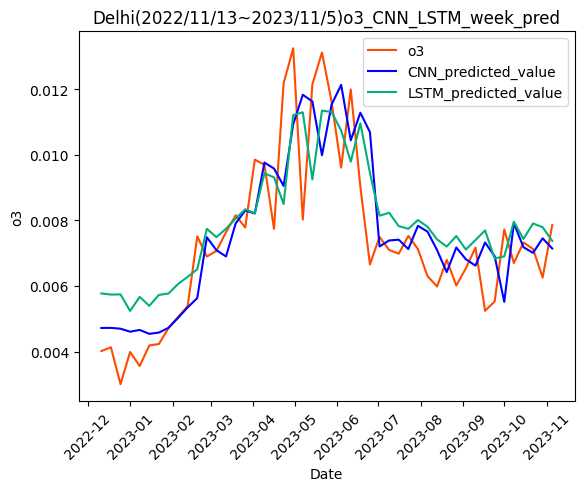

CPU times: user 35min 30s, sys: 28.1 s, total: 35min 58s
Wall time: 38min 33s


,temperature,precipitation,humidity,pressure,co,so2,pm25,pm10,o3,no2,AQI_total,target,o3_pred_original_cnn,o3_pred_original
Date,,,,,,,,,,,,,,
2022-12-11,16.785714,0.000000,66.771429,994.257143,1.080000,0.004186,208.571429,156.714286,0.004014,0.019043,258.571429,0.051301,0.004719,0.005774
2022-12-18,15.885714,0.000000,60.457143,993.828571,0.934286,0.004029,184.571429,131.142857,0.004129,0.018314,234.571429,0.057081,0.004722,0.005738
2022-12-25,12.857143,0.000000,82.728571,993.414286,1.152857,0.003443,239.571429,181.571429,0.003000,0.017657,289.571429,0.000000,0.004696,0.005744
2023-01-01,13.485714,0.000000,77.642857,996.771429,1.070000,0.003714,213.428571,150.428571,0.003986,0.014929,263.428571,0.049855,0.004605,0.005239
2023-01-08,10.328571,0.000000,86.014286,994.871429,1.071429,0.004271,260.142857,202.142857,0.003557,0.014500,310.142857,0.028179,0.004659,0.005669
2023-01-15,12.700000,14.142857,79.771429,985.957143,1.165714,0.003629,240.142857,187.714286,0.004186,0.013529,288.142857,0.059971,0.004539,0.005394
2023-01-22,13.900000,0.000000,64.571429,987.114286,1.004286,0.004171,210.714286,161.142857,0.004229,0.017986,260.714286,0.062139,0.004579,0.005728
2023-01-29,15.000000,2.857143,74.628571,985.985714,0.905714,0.003900,186.714286,122.571429,0.004714,0.015200,236.714286,0.086705,0.004723,0.005771
2023-02-05,16.400000,0.000000,72.100000,986.442857,0.755714,0.003814,161.285714,96.857143,0.005057,0.013629,212.000000,0.104046,0.005025,0.006061


In [ ]:
#(試験回数20,エポック50)
%%time
create_week_model(Delhi,"Delhi")

In [ ]:
#(試験回数20,エポック50)
df_results

,cnn_week_mape,lstm_week_mape
Tokyo_AQI_total,14.42%,17.1%
Tokyo_pm25,19.73%,22.59%
Tokyo_pm10,23.23%,23.98%
Tokyo_co,9.7%,9.7%
Tokyo_no2,21.22%,18.56%
Tokyo_so2,16.03%,15.76%
Tokyo_o3,18.97%,23.76%
Delhi_AQI_total,6.76%,9.64%
Delhi_pm25,12.73%,18.5%
Delhi_pm10,22.95%,24.88%


[I 2024-04-08 12:31:47,012] A new study created in memory with name: no-name-1822edeb-fef1-4b80-b3ff-39165edac83a
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 12ms/step


[I 2024-04-08 12:31:52,374] Trial 0 finished with value: 0.02024692211748821 and parameters: {'num_conv_layers': 1, 'conv_filters': 35, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.3543852427115235}. Best is trial 0 with value: 0.02024692211748821.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-08 12:31:55,485] Trial 1 finished with value: 0.019060512312360722 and parameters: {'num_conv_layers': 1, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 50, 'dropout_rate': 0.21846512701979087}. Best is trial 1 with value: 0.019060512312360722.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:01,134] Trial 2 finished with value: 0.015919582571534394 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.19297695393827546}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 12:32:04,711] Trial 3 finished with value: 0.01958820385343291 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.3911948496921015}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 12:32:10,440] Trial 4 finished with value: 0.01705710989273568 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 62, 'dropout_rate': 0.08849353095635704}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:14,086] Trial 5 finished with value: 0.018637573840826923 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 55, 'dropout_rate': 0.334345342894858}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-08 12:32:17,587] Trial 6 finished with value: 0.019802084848930396 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.17503549191547052}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:22,554] Trial 7 finished with value: 0.017263017541124446 and parameters: {'num_conv_layers': 2, 'conv_filters': 45, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 88, 'dropout_rate': 0.15026129846348463}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:24,710] Trial 8 finished with value: 0.018828000939742465 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 54, 'dropout_rate': 0.2315119411747098}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:32:26,346] Trial 9 finished with value: 0.017334830025359987 and parameters: {'num_conv_layers': 1, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.11452831679872527}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:28,889] Trial 10 finished with value: 0.019689704756295428 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 35, 'dropout_rate': 0.010237940660263178}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:32,177] Trial 11 finished with value: 0.018508347361154875 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.02769661299106496}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:34,835] Trial 12 finished with value: 0.02067782076596264 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.49434686951441037}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:38,859] Trial 13 finished with value: 0.01654171682081106 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 74, 'dropout_rate': 0.0828902455633879}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:41,942] Trial 14 finished with value: 0.01688701547574925 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.07085590022077307}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:44,761] Trial 15 finished with value: 0.01797356675756476 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.296624617592634}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:47,511] Trial 16 finished with value: 0.01780702558197062 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.18606910064675544}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:32:49,418] Trial 17 finished with value: 0.02036056815693241 and parameters: {'num_conv_layers': 1, 'conv_filters': 33, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 98, 'dropout_rate': 0.27972956878577565}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:32:52,801] Trial 18 finished with value: 0.016596914010098277 and parameters: {'num_conv_layers': 2, 'conv_filters': 20, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.1064570119652844}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:32:55,181] Trial 19 finished with value: 0.018306309842991222 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.0485120244523734}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:32:57,778] Trial 20 finished with value: 0.0185737776261428 and parameters: {'num_conv_layers': 1, 'conv_filters': 28, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 32, 'dropout_rate': 0.15386072295661435}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:02,360] Trial 21 finished with value: 0.019150007065962395 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.11541811566858784}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:05,120] Trial 22 finished with value: 0.017437713950103493 and parameters: {'num_conv_layers': 2, 'conv_filters': 20, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 72, 'dropout_rate': 0.1175526428542075}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:07,212] Trial 23 finished with value: 0.017031716292674793 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 83, 'dropout_rate': 0.20468061663442555}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:09,986] Trial 24 finished with value: 0.016742804002021786 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 68, 'dropout_rate': 0.08167543435584257}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:13,285] Trial 25 finished with value: 0.020011806333413516 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 82, 'dropout_rate': 0.262467976231832}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:33:16,104] Trial 26 finished with value: 0.01658579307924336 and parameters: {'num_conv_layers': 2, 'conv_filters': 24, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 81, 'dropout_rate': 0.1360338725322584}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:33:19,211] Trial 27 finished with value: 0.016348882118145985 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.14965644952834128}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:21,123] Trial 28 finished with value: 0.019411457687985717 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 98, 'dropout_rate': 0.04071665812674977}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:22,625] Trial 29 finished with value: 0.0207099999598364 and parameters: {'num_conv_layers': 1, 'conv_filters': 44, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 93, 'dropout_rate': 0.17170494043907103}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:33:25,696] Trial 30 finished with value: 0.018040737461291145 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.3929184827619143}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:29,355] Trial 31 finished with value: 0.0175259232061659 and parameters: {'num_conv_layers': 2, 'conv_filters': 32, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 82, 'dropout_rate': 0.1384133759446481}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-08 12:33:32,120] Trial 32 finished with value: 0.016652987063141906 and parameters: {'num_conv_layers': 2, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.20972131928272728}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:35,332] Trial 33 finished with value: 0.01636980025828604 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 94, 'dropout_rate': 0.25105205952647475}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:33:39,891] Trial 34 finished with value: 0.016654577595599487 and parameters: {'num_conv_layers': 2, 'conv_filters': 45, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 94, 'dropout_rate': 0.24619751231775558}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:43,854] Trial 35 finished with value: 0.016794314817774308 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 100, 'dropout_rate': 0.32302611844021234}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:33:45,959] Trial 36 finished with value: 0.017681364329546718 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 91, 'dropout_rate': 0.38129421877669334}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:33:49,205] Trial 37 finished with value: 0.016547575150768077 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 87, 'dropout_rate': 0.18964819673757666}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:53,114] Trial 38 finished with value: 0.01751529134604761 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 95, 'dropout_rate': 0.22254541410651388}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:54,994] Trial 39 finished with value: 0.019800224500757593 and parameters: {'num_conv_layers': 1, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 60, 'dropout_rate': 0.06190626776065715}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:33:57,310] Trial 40 finished with value: 0.016830344653521487 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 89, 'dropout_rate': 0.2628621024607542}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:33:59,443] Trial 41 finished with value: 0.01669884098514613 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.16981523980115754}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:34:01,616] Trial 42 finished with value: 0.018939891047913975 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.1933260942535753}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:34:05,113] Trial 43 finished with value: 0.016501854095536783 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.23901382642232927}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:34:09,506] Trial 44 finished with value: 0.016200619056016604 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.24096324576933154}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:34:11,521] Trial 45 finished with value: 0.02146917983467177 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.2999971567929333}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:34:13,621] Trial 46 finished with value: 0.018549709031312533 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.2357090602907865}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:34:17,723] Trial 47 finished with value: 0.01713512361328182 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.3501053427132693}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:34:21,998] Trial 48 finished with value: 0.017135231435701326 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 96, 'dropout_rate': 0.29559544491368905}. Best is trial 2 with value: 0.015919582571534394.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:34:25,635] Trial 49 finished with value: 0.017530261592362584 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 55, 'dropout_rate': 0.2648599111938973}. Best is trial 2 with value: 0.015919582571534394.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.19297695393827546}


<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 4s - loss: 0.3676 - mae: 0.5938

5/5 [==============================] - 1s 5ms/step - loss: 0.3397 - mae: 0.5569
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2569 - mae: 0.4710

5/5 [==============================] - 0s 5ms/step - loss: 0.2124 - mae: 0.4325
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1192 - mae: 0.3182

5/5 [==============================] - 0s 4ms/step - loss: 0.1055 - mae: 0.2845
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0513 - mae: 0.1730

5/5 [==============================] - 0s 5ms/step - loss: 0.0521 - mae: 0.1821
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0827 - mae: 0.2236

5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - mae: 0.2095
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0760 - mae: 0.2220

5/5 [==============================] - 0s 5ms/step - loss: 0.0525 - mae: 0.1840
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0556 - mae: 0.1763

5/5 [==============================] - 0s 4ms/step - loss: 0.0481 - mae: 0.1736
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1137

5/5 [==============================] - 0s 4ms/step - loss: 0.0381 - mae: 0.1466
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0412 - mae: 0.1624

5/5 [==============================] - 0s 6ms/step - loss: 0.0443 - mae: 0.1669
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0228 - mae: 0.1250

5/5 [==============================] - 0s 5ms/step - loss: 0.0354 - mae: 0.1450
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0432 - mae: 0.1585

5/5 [==============================] - 0s 4ms/step - loss: 0.0353 - mae: 0.1465
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0283 - mae: 0.1358

5/5 [==============================] - 0s 5ms/step - loss: 0.0338 - mae: 0.1441
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0430 - mae: 0.1698

5/5 [==============================] - 0s 5ms/step - loss: 0.0422 - mae: 0.1643
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0328 - mae: 0.1445

5/5 [==============================] - 0s 4ms/step - loss: 0.0375 - mae: 0.1517
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0507 - mae: 0.1809

5/5 [==============================] - 0s 5ms/step - loss: 0.0353 - mae: 0.1496
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0318 - mae: 0.1358

5/5 [==============================] - 0s 6ms/step - loss: 0.0372 - mae: 0.1533
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0374 - mae: 0.1485

5/5 [==============================] - 0s 5ms/step - loss: 0.0405 - mae: 0.1540
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0397 - mae: 0.1519

5/5 [==============================] - 0s 5ms/step - loss: 0.0394 - mae: 0.1506
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0363 - mae: 0.1498

5/5 [==============================] - 0s 5ms/step - loss: 0.0347 - mae: 0.1493
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0575 - mae: 0.1924

5/5 [==============================] - 0s 5ms/step - loss: 0.0371 - mae: 0.1542
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0414 - mae: 0.1656

5/5 [==============================] - 0s 5ms/step - loss: 0.0364 - mae: 0.1505
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0238 - mae: 0.1234

5/5 [==============================] - 0s 5ms/step - loss: 0.0307 - mae: 0.1370
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0503 - mae: 0.1742

5/5 [==============================] - 0s 5ms/step - loss: 0.0337 - mae: 0.1414
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281 - mae: 0.1304

5/5 [==============================] - 0s 5ms/step - loss: 0.0336 - mae: 0.1416
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263 - mae: 0.1278

5/5 [==============================] - 0s 6ms/step - loss: 0.0335 - mae: 0.1397
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0229 - mae: 0.1225

5/5 [==============================] - 0s 5ms/step - loss: 0.0305 - mae: 0.1340
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0395 - mae: 0.1540

5/5 [==============================] - 0s 7ms/step - loss: 0.0397 - mae: 0.1572
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0388 - mae: 0.1581

5/5 [==============================] - 0s 4ms/step - loss: 0.0301 - mae: 0.1342
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0292 - mae: 0.1392

5/5 [==============================] - 0s 5ms/step - loss: 0.0363 - mae: 0.1496
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0465 - mae: 0.1762

5/5 [==============================] - 0s 5ms/step - loss: 0.0352 - mae: 0.1476
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0419 - mae: 0.1508

5/5 [==============================] - 0s 5ms/step - loss: 0.0366 - mae: 0.1518
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0282 - mae: 0.1353

5/5 [==============================] - 0s 5ms/step - loss: 0.0339 - mae: 0.1473
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0421 - mae: 0.1517

5/5 [==============================] - 0s 5ms/step - loss: 0.0326 - mae: 0.1372
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0441 - mae: 0.1593

5/5 [==============================] - 0s 6ms/step - loss: 0.0285 - mae: 0.1314
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0399 - mae: 0.1701

5/5 [==============================] - 0s 5ms/step - loss: 0.0336 - mae: 0.1466
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0415 - mae: 0.1551

5/5 [==============================] - 0s 5ms/step - loss: 0.0314 - mae: 0.1400
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0337 - mae: 0.1603

5/5 [==============================] - 0s 5ms/step - loss: 0.0334 - mae: 0.1434
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0422 - mae: 0.1769

5/5 [==============================] - 0s 5ms/step - loss: 0.0332 - mae: 0.1468
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0188 - mae: 0.1092

5/5 [==============================] - 0s 5ms/step - loss: 0.0289 - mae: 0.1388
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0335 - mae: 0.1471

5/5 [==============================] - 0s 5ms/step - loss: 0.0353 - mae: 0.1464
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0320 - mae: 0.1491

5/5 [==============================] - 0s 6ms/step - loss: 0.0326 - mae: 0.1428
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0396 - mae: 0.1492

5/5 [==============================] - 0s 5ms/step - loss: 0.0328 - mae: 0.1404
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0273 - mae: 0.1374

5/5 [==============================] - 0s 6ms/step - loss: 0.0324 - mae: 0.1444
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0342 - mae: 0.1359

5/5 [==============================] - 0s 5ms/step - loss: 0.0321 - mae: 0.1407
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0339 - mae: 0.1349

5/5 [==============================] - 0s 4ms/step - loss: 0.0288 - mae: 0.1331
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0270 - mae: 0.1386

5/5 [==============================] - 0s 5ms/step - loss: 0.0289 - mae: 0.1345
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0300 - mae: 0.1346

5/5 [==============================] - 0s 5ms/step - loss: 0.0287 - mae: 0.1344
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0387 - mae: 0.1567

5/5 [==============================] - 0s 5ms/step - loss: 0.0290 - mae: 0.1377
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0346 - mae: 0.1405

5/5 [==============================] - 0s 5ms/step - loss: 0.0320 - mae: 0.1412
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0302 - mae: 0.1450

2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:34:29,790] A new study created in memory with name: no-name-4819b21f-5489-4db1-8796-92ca50347033
<ipython-input-10-648d2fa67f65>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-10-648d2fa67f65>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.0162


[I 2024-04-08 12:34:41,479] Trial 0 finished with value: 0.0161889735609293 and parameters: {'n_lstm_layers': 3, 'units_0': 45, 'units_1': 63, 'units_2': 64, 'dropout_rate': 0.12489653845203619, 'learning_rate': 0.00031324703639786384}. Best is trial 0 with value: 0.0161889735609293.


2/2 [==============================] - 0s 11ms/step - loss: 0.0637


[I 2024-04-08 12:34:51,646] Trial 1 finished with value: 0.06374629586935043 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 67, 'dropout_rate': 0.14603980006256773, 'learning_rate': 3.2146302592955114e-05}. Best is trial 0 with value: 0.0161889735609293.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-08 12:35:04,526] Trial 2 finished with value: 0.015460913069546223 and parameters: {'n_lstm_layers': 3, 'units_0': 56, 'units_1': 66, 'units_2': 46, 'dropout_rate': 0.47223972446716345, 'learning_rate': 0.005903889674295013}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 9ms/step - loss: 0.0200


[I 2024-04-08 12:35:18,820] Trial 3 finished with value: 0.019998351112008095 and parameters: {'n_lstm_layers': 2, 'units_0': 54, 'units_1': 65, 'dropout_rate': 0.07953621448346582, 'learning_rate': 5.710973876341011e-05}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 12ms/step - loss: 0.0190


[I 2024-04-08 12:35:25,416] Trial 4 finished with value: 0.019033482298254967 and parameters: {'n_lstm_layers': 1, 'units_0': 76, 'dropout_rate': 0.2234332747231358, 'learning_rate': 0.0008076999419982442}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 12ms/step - loss: 0.0159


[I 2024-04-08 12:35:32,154] Trial 5 finished with value: 0.01591898314654827 and parameters: {'n_lstm_layers': 2, 'units_0': 57, 'units_1': 81, 'dropout_rate': 0.19169312720278792, 'learning_rate': 0.00250775124033851}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 10ms/step - loss: 0.0164


[I 2024-04-08 12:35:39,000] Trial 6 finished with value: 0.01643557846546173 and parameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 20, 'dropout_rate': 0.3471646795124259, 'learning_rate': 0.001696387843432193}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 10ms/step - loss: 0.0990


[I 2024-04-08 12:35:56,091] Trial 7 finished with value: 0.09900367259979248 and parameters: {'n_lstm_layers': 3, 'units_0': 75, 'units_1': 72, 'units_2': 58, 'dropout_rate': 0.3235496134187763, 'learning_rate': 2.9945691473093948e-05}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 12ms/step - loss: 0.0168


[I 2024-04-08 12:36:02,188] Trial 8 finished with value: 0.01678413525223732 and parameters: {'n_lstm_layers': 2, 'units_0': 78, 'units_1': 50, 'dropout_rate': 0.3819162670509091, 'learning_rate': 0.00046390343365847983}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 9ms/step - loss: 0.0163


[I 2024-04-08 12:36:14,078] Trial 9 finished with value: 0.016293881461024284 and parameters: {'n_lstm_layers': 3, 'units_0': 75, 'units_1': 30, 'units_2': 57, 'dropout_rate': 0.1469368017363124, 'learning_rate': 0.00021316971411879936}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 8ms/step - loss: 0.0156


[I 2024-04-08 12:36:19,319] Trial 10 finished with value: 0.015599881298840046 and parameters: {'n_lstm_layers': 1, 'units_0': 25, 'dropout_rate': 0.48063240748663216, 'learning_rate': 0.009950202367789452}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 8ms/step - loss: 0.0161


[I 2024-04-08 12:36:23,745] Trial 11 finished with value: 0.016104472801089287 and parameters: {'n_lstm_layers': 1, 'units_0': 23, 'dropout_rate': 0.48736074496233295, 'learning_rate': 0.004871288514713026}. Best is trial 2 with value: 0.015460913069546223.


2/2 [==============================] - 0s 8ms/step - loss: 0.0154


[I 2024-04-08 12:36:28,645] Trial 12 finished with value: 0.015414386987686157 and parameters: {'n_lstm_layers': 1, 'units_0': 100, 'dropout_rate': 0.4942296315651564, 'learning_rate': 0.009416325726225774}. Best is trial 12 with value: 0.015414386987686157.


2/2 [==============================] - 0s 9ms/step - loss: 0.0153


[I 2024-04-08 12:36:38,299] Trial 13 finished with value: 0.015349055640399456 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 100, 'units_2': 25, 'dropout_rate': 0.4200015611629211, 'learning_rate': 0.009790588198202393}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0160


[I 2024-04-08 12:36:43,865] Trial 14 finished with value: 0.015999071300029755 and parameters: {'n_lstm_layers': 1, 'units_0': 100, 'dropout_rate': 0.396369172446398, 'learning_rate': 0.0018128393259256395}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 6ms/step - loss: 0.0734


[I 2024-04-08 12:36:50,507] Trial 15 finished with value: 0.07342700660228729 and parameters: {'n_lstm_layers': 1, 'units_0': 100, 'dropout_rate': 0.301576270135151, 'learning_rate': 0.00010518893234517425}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0156


[I 2024-04-08 12:37:01,871] Trial 16 finished with value: 0.015629447996616364 and parameters: {'n_lstm_layers': 3, 'units_0': 88, 'units_1': 100, 'units_2': 20, 'dropout_rate': 0.4209719898121629, 'learning_rate': 0.009784754476447293}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.1894


[I 2024-04-08 12:37:16,178] Trial 17 finished with value: 0.18938244879245758 and parameters: {'n_lstm_layers': 2, 'units_0': 90, 'units_1': 98, 'dropout_rate': 0.27936941706053076, 'learning_rate': 1.3015544888496775e-05}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0156


[I 2024-04-08 12:37:25,369] Trial 18 finished with value: 0.015558230690658092 and parameters: {'n_lstm_layers': 2, 'units_0': 90, 'units_1': 46, 'dropout_rate': 0.43931700382522465, 'learning_rate': 0.003745801521099891}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0160


[I 2024-04-08 12:37:34,247] Trial 19 finished with value: 0.015969468280673027 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 85, 'units_2': 97, 'dropout_rate': 0.005594889883066112, 'learning_rate': 0.0009855351562234797}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0205


[I 2024-04-08 12:37:42,356] Trial 20 finished with value: 0.02045033685863018 and parameters: {'n_lstm_layers': 1, 'units_0': 37, 'dropout_rate': 0.3826683805680458, 'learning_rate': 0.0008890716742499019}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-08 12:37:53,235] Trial 21 finished with value: 0.015394818037748337 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 87, 'units_2': 23, 'dropout_rate': 0.4992522250802992, 'learning_rate': 0.0052296612526678285}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0154


[I 2024-04-08 12:38:01,703] Trial 22 finished with value: 0.015378945507109165 and parameters: {'n_lstm_layers': 3, 'units_0': 96, 'units_1': 91, 'units_2': 21, 'dropout_rate': 0.49790468286520473, 'learning_rate': 0.0046800369744354805}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-08 12:38:10,998] Trial 23 finished with value: 0.01554572582244873 and parameters: {'n_lstm_layers': 3, 'units_0': 67, 'units_1': 89, 'units_2': 21, 'dropout_rate': 0.44792002355978294, 'learning_rate': 0.00362716284015633}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-08 12:38:22,247] Trial 24 finished with value: 0.015427676029503345 and parameters: {'n_lstm_layers': 3, 'units_0': 88, 'units_1': 93, 'units_2': 34, 'dropout_rate': 0.4281590090322633, 'learning_rate': 0.005404606532056167}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0155


[I 2024-04-08 12:38:33,212] Trial 25 finished with value: 0.015485431998968124 and parameters: {'n_lstm_layers': 3, 'units_0': 94, 'units_1': 78, 'units_2': 34, 'dropout_rate': 0.36912149726748744, 'learning_rate': 0.0023063388402236535}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 15ms/step - loss: 0.0155


[I 2024-04-08 12:38:44,251] Trial 26 finished with value: 0.015498795546591282 and parameters: {'n_lstm_layers': 3, 'units_0': 47, 'units_1': 89, 'units_2': 33, 'dropout_rate': 0.448314312671166, 'learning_rate': 0.001234318998142656}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0155


[I 2024-04-08 12:38:55,285] Trial 27 finished with value: 0.015490991063416004 and parameters: {'n_lstm_layers': 3, 'units_0': 83, 'units_1': 94, 'units_2': 20, 'dropout_rate': 0.41770646483653395, 'learning_rate': 0.00611707346056467}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0154


[I 2024-04-08 12:39:04,341] Trial 28 finished with value: 0.01540016382932663 and parameters: {'n_lstm_layers': 3, 'units_0': 67, 'units_1': 79, 'units_2': 31, 'dropout_rate': 0.49835068540230054, 'learning_rate': 0.002979806102090967}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0166


[I 2024-04-08 12:39:16,163] Trial 29 finished with value: 0.016564322635531425 and parameters: {'n_lstm_layers': 3, 'units_0': 37, 'units_1': 100, 'units_2': 41, 'dropout_rate': 0.33964827005441495, 'learning_rate': 0.0003535616639981475}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0166


[I 2024-04-08 12:39:27,929] Trial 30 finished with value: 0.01661798171699047 and parameters: {'n_lstm_layers': 3, 'units_0': 94, 'units_1': 55, 'units_2': 75, 'dropout_rate': 0.26245168862947726, 'learning_rate': 0.0001426285826026779}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0155


[I 2024-04-08 12:39:38,957] Trial 31 finished with value: 0.015541818924248219 and parameters: {'n_lstm_layers': 3, 'units_0': 67, 'units_1': 77, 'units_2': 28, 'dropout_rate': 0.4978609773545376, 'learning_rate': 0.0029070924799837147}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0164


[I 2024-04-08 12:39:47,053] Trial 32 finished with value: 0.016376979649066925 and parameters: {'n_lstm_layers': 3, 'units_0': 70, 'units_1': 85, 'units_2': 27, 'dropout_rate': 0.4571351772489227, 'learning_rate': 0.006904626605268213}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 13ms/step - loss: 0.0154


[I 2024-04-08 12:39:56,638] Trial 33 finished with value: 0.015429560095071793 and parameters: {'n_lstm_layers': 3, 'units_0': 82, 'units_1': 91, 'units_2': 44, 'dropout_rate': 0.4644035626173345, 'learning_rate': 0.003980816344272459}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0167


[I 2024-04-08 12:40:06,040] Trial 34 finished with value: 0.01672895811498165 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 84, 'units_2': 30, 'dropout_rate': 0.4117725981461181, 'learning_rate': 0.001670434674403673}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0162


[I 2024-04-08 12:40:17,135] Trial 35 finished with value: 0.016185810789465904 and parameters: {'n_lstm_layers': 3, 'units_0': 49, 'units_1': 73, 'units_2': 26, 'dropout_rate': 0.469825540338446, 'learning_rate': 0.0005018480370241994}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 8ms/step - loss: 0.0155


[I 2024-04-08 12:40:25,964] Trial 36 finished with value: 0.015456966124475002 and parameters: {'n_lstm_layers': 2, 'units_0': 39, 'units_1': 95, 'dropout_rate': 0.4951386600164309, 'learning_rate': 0.006815119847194334}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 13ms/step - loss: 0.0154


[I 2024-04-08 12:40:38,033] Trial 37 finished with value: 0.015428119339048862 and parameters: {'n_lstm_layers': 3, 'units_0': 60, 'units_1': 88, 'units_2': 39, 'dropout_rate': 0.45864965450827194, 'learning_rate': 0.0027165512996845356}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0160


[I 2024-04-08 12:40:45,639] Trial 38 finished with value: 0.015994880348443985 and parameters: {'n_lstm_layers': 2, 'units_0': 51, 'units_1': 74, 'dropout_rate': 0.230174429165918, 'learning_rate': 0.004723121835131594}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0157


[I 2024-04-08 12:40:56,706] Trial 39 finished with value: 0.01565142162144184 and parameters: {'n_lstm_layers': 3, 'units_0': 84, 'units_1': 80, 'units_2': 20, 'dropout_rate': 0.3560712638109814, 'learning_rate': 0.001312163817458449}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0155


[I 2024-04-08 12:41:03,441] Trial 40 finished with value: 0.01554257795214653 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 93, 'dropout_rate': 0.40237324279894926, 'learning_rate': 0.007217790221789269}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0154


[I 2024-04-08 12:41:15,522] Trial 41 finished with value: 0.015377427451312542 and parameters: {'n_lstm_layers': 3, 'units_0': 98, 'units_1': 71, 'units_2': 51, 'dropout_rate': 0.4961605458505975, 'learning_rate': 0.0070476643771090934}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 8ms/step - loss: 0.0155


[I 2024-04-08 12:41:25,386] Trial 42 finished with value: 0.015535630285739899 and parameters: {'n_lstm_layers': 3, 'units_0': 94, 'units_1': 70, 'units_2': 51, 'dropout_rate': 0.4993724087463791, 'learning_rate': 0.0030479008996913844}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 12ms/step - loss: 0.0154


[I 2024-04-08 12:41:36,425] Trial 43 finished with value: 0.01544196903705597 and parameters: {'n_lstm_layers': 3, 'units_0': 75, 'units_1': 63, 'units_2': 76, 'dropout_rate': 0.47006177271361355, 'learning_rate': 0.004738839132351575}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 12ms/step - loss: 0.0154


[I 2024-04-08 12:41:49,981] Trial 44 finished with value: 0.015368546359241009 and parameters: {'n_lstm_layers': 3, 'units_0': 79, 'units_1': 82, 'units_2': 37, 'dropout_rate': 0.47528728667761755, 'learning_rate': 0.007814577060329782}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 12ms/step - loss: 0.0154


[I 2024-04-08 12:41:58,414] Trial 45 finished with value: 0.015387986786663532 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 83, 'units_2': 38, 'dropout_rate': 0.43586067046811927, 'learning_rate': 0.00752973402163738}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-08 12:42:08,029] Trial 46 finished with value: 0.01546445768326521 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 69, 'units_2': 50, 'dropout_rate': 0.4314056333252692, 'learning_rate': 0.008232563128851436}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 9ms/step - loss: 0.0161


[I 2024-04-08 12:42:14,719] Trial 47 finished with value: 0.016108304262161255 and parameters: {'n_lstm_layers': 2, 'units_0': 91, 'units_1': 81, 'dropout_rate': 0.3923389289026969, 'learning_rate': 0.009968118219342006}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0165


[I 2024-04-08 12:42:23,219] Trial 48 finished with value: 0.016496693715453148 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 61, 'units_2': 38, 'dropout_rate': 0.17453167606218126, 'learning_rate': 0.001947358248054405}. Best is trial 13 with value: 0.015349055640399456.


2/2 [==============================] - 0s 11ms/step - loss: 0.0173


[I 2024-04-08 12:42:40,414] Trial 49 finished with value: 0.017289811745285988 and parameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 96, 'units_2': 68, 'dropout_rate': 0.3235521250581077, 'learning_rate': 4.835641486700606e-05}. Best is trial 13 with value: 0.015349055640399456.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 97, 'units_1': 100, 'units_2': 25, 'dropout_rate': 0.4200015611629211, 'learning_rate': 0.009790588198202393}
Epoch 1/50
1/5 [=====>........................] - ETA: 22s - loss: 0.3139

5/5 [==============================] - 6s 13ms/step - loss: 0.1285
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0615

5/5 [==============================] - 0s 13ms/step - loss: 0.0407
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0288

5/5 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0303

5/5 [==============================] - 0s 15ms/step - loss: 0.0303
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0362

5/5 [==============================] - 0s 13ms/step - loss: 0.0272
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0395

5/5 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0191

5/5 [==============================] - 0s 12ms/step - loss: 0.0264
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 13ms/step - loss: 0.0264
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0137

5/5 [==============================] - 0s 13ms/step - loss: 0.0251
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0307

5/5 [==============================] - 0s 13ms/step - loss: 0.0255
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 16ms/step - loss: 0.0255
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 13ms/step - loss: 0.0261
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 12ms/step - loss: 0.0257
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 15ms/step - loss: 0.0254
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 13ms/step - loss: 0.0255
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0282

5/5 [==============================] - 0s 13ms/step - loss: 0.0284
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 15ms/step - loss: 0.0266
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 16ms/step - loss: 0.0264
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0337

5/5 [==============================] - 0s 13ms/step - loss: 0.0261
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0321

5/5 [==============================] - 0s 12ms/step - loss: 0.0264
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0152

5/5 [==============================] - 0s 13ms/step - loss: 0.0251
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201

5/5 [==============================] - 0s 12ms/step - loss: 0.0253
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0358

5/5 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201

5/5 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0355

5/5 [==============================] - 0s 13ms/step - loss: 0.0249
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0296

5/5 [==============================] - 0s 13ms/step - loss: 0.0267
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 16ms/step - loss: 0.0261
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 13ms/step - loss: 0.0258
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0284

5/5 [==============================] - 0s 15ms/step - loss: 0.0284
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 13ms/step - loss: 0.0273
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0305

5/5 [==============================] - 0s 12ms/step - loss: 0.0261
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 13ms/step - loss: 0.0258
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0425

5/5 [==============================] - 0s 13ms/step - loss: 0.0263
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0298

5/5 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 15ms/step - loss: 0.0255
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 15ms/step - loss: 0.0256
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0278

5/5 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0160

5/5 [==============================] - 0s 13ms/step - loss: 0.0256
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0259

5/5 [==============================] - 0s 14ms/step - loss: 0.0259
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 19ms/step - loss: 0.0263
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0369

5/5 [==============================] - 0s 12ms/step - loss: 0.0260
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0258

5/5 [==============================] - 0s 15ms/step - loss: 0.0258
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 13ms/step - loss: 0.0255
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0284

5/5 [==============================] - 0s 13ms/step - loss: 0.0246
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 13ms/step - loss: 0.0257
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 16ms/step - loss: 0.0256
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 0.0252

5/5 [==============================] - 0s 15ms/step - loss: 0.0252
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 12ms/step - loss: 0.0251
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0283

2/2 [==============================] - 2s 7ms/step


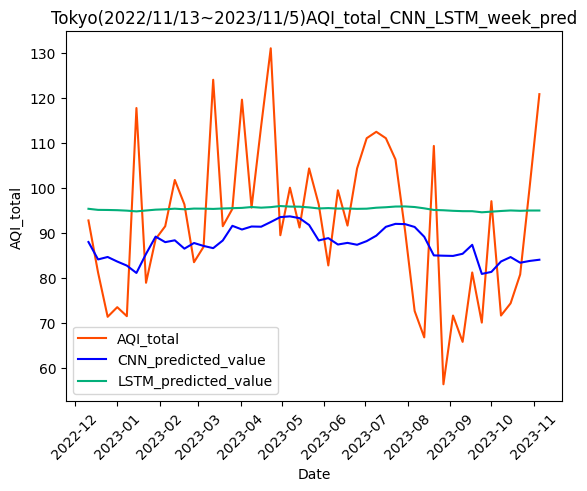

[I 2024-04-08 12:42:54,713] A new study created in memory with name: no-name-ee23dc77-7d23-498f-b5fa-77a48a7a88ed
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:42:56,629] Trial 0 finished with value: 0.016508495888985068 and parameters: {'num_conv_layers': 1, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 80, 'dropout_rate': 0.40380620394654665}. Best is trial 0 with value: 0.016508495888985068.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:42:58,528] Trial 1 finished with value: 0.01728318985107102 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 48, 'dropout_rate': 0.31489294884298297}. Best is trial 0 with value: 0.016508495888985068.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:00,879] Trial 2 finished with value: 0.017466917227281515 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.400103755008826}. Best is trial 0 with value: 0.016508495888985068.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:07,442] Trial 3 finished with value: 0.01449341815909864 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.17907646099097185}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:09,121] Trial 4 finished with value: 0.017739371093845 and parameters: {'num_conv_layers': 1, 'conv_filters': 47, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 36, 'dropout_rate': 0.43363671661464553}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:11,016] Trial 5 finished with value: 0.016142757916674976 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.04195798140885176}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:43:13,009] Trial 6 finished with value: 0.017139360626516793 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 57, 'dropout_rate': 0.3658593310114985}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:14,675] Trial 7 finished with value: 0.017234512051782395 and parameters: {'num_conv_layers': 1, 'conv_filters': 28, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 79, 'dropout_rate': 0.2812392734530681}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:43:18,758] Trial 8 finished with value: 0.015402060730994803 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.17716110950350444}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:21,799] Trial 9 finished with value: 0.01526347496922587 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 71, 'dropout_rate': 0.24657048439607943}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:24,554] Trial 10 finished with value: 0.016407489446917677 and parameters: {'num_conv_layers': 2, 'conv_filters': 18, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 35, 'dropout_rate': 0.10839869210199071}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:28,110] Trial 11 finished with value: 0.014716612039030796 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 49, 'dropout_rate': 0.19405839101810007}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:43:32,253] Trial 12 finished with value: 0.014721394839162941 and parameters: {'num_conv_layers': 2, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 47, 'dropout_rate': 0.17756397805835858}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:35,180] Trial 13 finished with value: 0.014959974104032298 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 47, 'dropout_rate': 0.18849472723786215}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:38,437] Trial 14 finished with value: 0.015121880474057875 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.07755852345324099}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:40,392] Trial 15 finished with value: 0.01644547564985307 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.13172127448405402}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:43:43,237] Trial 16 finished with value: 0.016322204160048755 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 55, 'dropout_rate': 0.005751505113440303}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:48,694] Trial 17 finished with value: 0.015855447448571414 and parameters: {'num_conv_layers': 1, 'conv_filters': 23, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 32, 'dropout_rate': 0.23096447039045215}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:43:51,041] Trial 18 finished with value: 0.015034172714035163 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 42, 'dropout_rate': 0.301059525240168}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:43:53,244] Trial 19 finished with value: 0.0166142944180095 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.4982017636167993}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:43:55,247] Trial 20 finished with value: 0.016839559907377937 and parameters: {'num_conv_layers': 1, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 43, 'dropout_rate': 0.2153095990924094}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:43:59,724] Trial 21 finished with value: 0.015088773258628216 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.14425924549269487}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:01,800] Trial 22 finished with value: 0.016597697293545127 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 52, 'dropout_rate': 0.17544579487234696}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:44:03,888] Trial 23 finished with value: 0.017641718579586695 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 43, 'dropout_rate': 0.09662729954905899}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:06,955] Trial 24 finished with value: 0.015046183513165166 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 61, 'dropout_rate': 0.14533567176289142}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:09,708] Trial 25 finished with value: 0.015627219509337504 and parameters: {'num_conv_layers': 2, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 70, 'dropout_rate': 0.26985484971573304}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-08 12:44:13,069] Trial 26 finished with value: 0.016508249889550877 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 46, 'dropout_rate': 0.20309500954375667}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 12:44:15,175] Trial 27 finished with value: 0.016398446964101674 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.33613262950990463}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:17,274] Trial 28 finished with value: 0.016822654328197358 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 60, 'dropout_rate': 0.07825109119641517}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:44:19,173] Trial 29 finished with value: 0.017495379893428083 and parameters: {'num_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 98, 'dropout_rate': 0.23812140460953635}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:44:21,118] Trial 30 finished with value: 0.01653101518527567 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 32, 'dropout_rate': 0.17118820686471675}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:24,060] Trial 31 finished with value: 0.015971420644850538 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 46, 'dropout_rate': 0.19433590310751983}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:27,252] Trial 32 finished with value: 0.015545920108350242 and parameters: {'num_conv_layers': 2, 'conv_filters': 41, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.13009035007376016}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:29,503] Trial 33 finished with value: 0.0161763311009724 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 47, 'dropout_rate': 0.2713911618813327}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:44:31,470] Trial 34 finished with value: 0.017066311559709686 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 39, 'dropout_rate': 0.1653184031613806}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 12:44:33,681] Trial 35 finished with value: 0.016194752545123828 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.21352263839055527}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-08 12:44:35,859] Trial 36 finished with value: 0.016461318262089904 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 37, 'dropout_rate': 0.0384892703999932}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:38,595] Trial 37 finished with value: 0.016751042466650438 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 43, 'dropout_rate': 0.1970341870314939}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:40,477] Trial 38 finished with value: 0.01551980243084595 and parameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 86, 'dropout_rate': 0.11447566018124947}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:44:42,654] Trial 39 finished with value: 0.01605091424124736 and parameters: {'num_conv_layers': 2, 'conv_filters': 29, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.3422880174231517}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:44,274] Trial 40 finished with value: 0.017925412042264787 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 49, 'dropout_rate': 0.1566654495682644}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:46,382] Trial 41 finished with value: 0.016380303200823426 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 42, 'dropout_rate': 0.30206787828951615}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:48,516] Trial 42 finished with value: 0.015812862289941967 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.4008552916276112}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:44:51,495] Trial 43 finished with value: 0.01606436067676591 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 34, 'dropout_rate': 0.290183018902746}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:54,477] Trial 44 finished with value: 0.01626334606621068 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 38, 'dropout_rate': 0.2506871914108374}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:44:56,644] Trial 45 finished with value: 0.01661360426533685 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 42, 'dropout_rate': 0.25962851726567737}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:44:58,816] Trial 46 finished with value: 0.017607147247156372 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 55, 'dropout_rate': 0.3684516438285647}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:45:00,985] Trial 47 finished with value: 0.01575304880368245 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 53, 'dropout_rate': 0.3199113774759508}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:45:03,601] Trial 48 finished with value: 0.017911678569429376 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 35, 'dropout_rate': 0.21898074800014722}. Best is trial 3 with value: 0.01449341815909864.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:45:06,198] Trial 49 finished with value: 0.016288884132935808 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 69, 'dropout_rate': 0.18623414476102645}. Best is trial 3 with value: 0.01449341815909864.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 39, 'dropout_rate': 0.17907646099097185}
Epoch 1/50


<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


1/5 [=====>........................] - ETA: 4s - loss: 0.4371 - mae: 0.6366

5/5 [==============================] - 1s 6ms/step - loss: 0.3978 - mae: 0.6093
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.3292 - mae: 0.5482

5/5 [==============================] - 0s 6ms/step - loss: 0.2921 - mae: 0.5185
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.2684 - mae: 0.4967

5/5 [==============================] - 0s 9ms/step - loss: 0.2379 - mae: 0.4620
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1875 - mae: 0.4108

5/5 [==============================] - 0s 6ms/step - loss: 0.1881 - mae: 0.4069
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1080 - mae: 0.3075

5/5 [==============================] - 0s 6ms/step - loss: 0.1461 - mae: 0.3539
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1163 - mae: 0.3008

5/5 [==============================] - 0s 7ms/step - loss: 0.1055 - mae: 0.2877
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1030 - mae: 0.2726

5/5 [==============================] - 0s 6ms/step - loss: 0.0650 - mae: 0.2099
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0350 - mae: 0.1480

5/5 [==============================] - 0s 6ms/step - loss: 0.0352 - mae: 0.1467
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0235 - mae: 0.1334

5/5 [==============================] - 0s 6ms/step - loss: 0.0364 - mae: 0.1512
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0355 - mae: 0.1594

5/5 [==============================] - 0s 6ms/step - loss: 0.0377 - mae: 0.1577
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0507 - mae: 0.1823

5/5 [==============================] - 0s 5ms/step - loss: 0.0372 - mae: 0.1517
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0431 - mae: 0.1675

5/5 [==============================] - 0s 6ms/step - loss: 0.0324 - mae: 0.1428
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0239 - mae: 0.1270

5/5 [==============================] - 0s 6ms/step - loss: 0.0353 - mae: 0.1466
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0314 - mae: 0.1465

5/5 [==============================] - 0s 7ms/step - loss: 0.0379 - mae: 0.1521
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0306 - mae: 0.1352

5/5 [==============================] - 0s 6ms/step - loss: 0.0337 - mae: 0.1431
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0274 - mae: 0.1290

5/5 [==============================] - 0s 6ms/step - loss: 0.0344 - mae: 0.1445
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0247 - mae: 0.1246

5/5 [==============================] - 0s 6ms/step - loss: 0.0301 - mae: 0.1388
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0457 - mae: 0.1605

5/5 [==============================] - 0s 6ms/step - loss: 0.0349 - mae: 0.1434
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0440 - mae: 0.1776

5/5 [==============================] - 0s 6ms/step - loss: 0.0331 - mae: 0.1476
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0310 - mae: 0.1402

5/5 [==============================] - 0s 6ms/step - loss: 0.0304 - mae: 0.1398
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0215 - mae: 0.1172

5/5 [==============================] - 0s 7ms/step - loss: 0.0317 - mae: 0.1415
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263 - mae: 0.1242

5/5 [==============================] - 0s 6ms/step - loss: 0.0340 - mae: 0.1466
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0340 - mae: 0.1468

5/5 [==============================] - 0s 6ms/step - loss: 0.0347 - mae: 0.1460
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0318 - mae: 0.1448

5/5 [==============================] - 0s 6ms/step - loss: 0.0296 - mae: 0.1385
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0386 - mae: 0.1391

5/5 [==============================] - 0s 6ms/step - loss: 0.0336 - mae: 0.1415
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0376 - mae: 0.1464

5/5 [==============================] - 0s 6ms/step - loss: 0.0359 - mae: 0.1456
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0261 - mae: 0.1306

5/5 [==============================] - 0s 6ms/step - loss: 0.0337 - mae: 0.1439
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0387 - mae: 0.1507

5/5 [==============================] - 0s 6ms/step - loss: 0.0311 - mae: 0.1391
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0365 - mae: 0.1494

5/5 [==============================] - 0s 7ms/step - loss: 0.0311 - mae: 0.1387
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0224 - mae: 0.1165

5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - mae: 0.1391
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - mae: 0.1135

5/5 [==============================] - 0s 6ms/step - loss: 0.0312 - mae: 0.1376
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0284 - mae: 0.1356

5/5 [==============================] - 0s 6ms/step - loss: 0.0298 - mae: 0.1381
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0398 - mae: 0.1517

5/5 [==============================] - 0s 10ms/step - loss: 0.0279 - mae: 0.1324
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0252 - mae: 0.1138

5/5 [==============================] - 0s 7ms/step - loss: 0.0328 - mae: 0.1407
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0300 - mae: 0.1320

5/5 [==============================] - 0s 6ms/step - loss: 0.0312 - mae: 0.1346
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1068

5/5 [==============================] - 0s 8ms/step - loss: 0.0280 - mae: 0.1302
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0458 - mae: 0.1626

5/5 [==============================] - 0s 5ms/step - loss: 0.0301 - mae: 0.1343
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0271 - mae: 0.1329

5/5 [==============================] - 0s 5ms/step - loss: 0.0275 - mae: 0.1261
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0294 - mae: 0.1331

5/5 [==============================] - 0s 6ms/step - loss: 0.0278 - mae: 0.1307
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184 - mae: 0.1067

5/5 [==============================] - 0s 6ms/step - loss: 0.0284 - mae: 0.1325
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0298 - mae: 0.1487

5/5 [==============================] - 0s 7ms/step - loss: 0.0249 - mae: 0.1261
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0275 - mae: 0.1345

5/5 [==============================] - 0s 6ms/step - loss: 0.0284 - mae: 0.1302
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0320 - mae: 0.1403

5/5 [==============================] - 0s 6ms/step - loss: 0.0283 - mae: 0.1360
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0181 - mae: 0.1061

5/5 [==============================] - 0s 6ms/step - loss: 0.0276 - mae: 0.1279
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - mae: 0.1242

5/5 [==============================] - 0s 6ms/step - loss: 0.0264 - mae: 0.1269
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0293 - mae: 0.1418

5/5 [==============================] - 0s 5ms/step - loss: 0.0314 - mae: 0.1435
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0294 - mae: 0.1342

5/5 [==============================] - 0s 6ms/step - loss: 0.0309 - mae: 0.1403
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0219 - mae: 0.1261

5/5 [==============================] - 0s 5ms/step - loss: 0.0289 - mae: 0.1346
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0222 - mae: 0.1199

5/5 [==============================] - 0s 5ms/step - loss: 0.0276 - mae: 0.1315
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0228 - mae: 0.1196

2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:45:09,544] A new study created in memory with name: no-name-a13c4c6c-e7ba-427e-b47f-75f035f8cb0a
<ipython-input-10-648d2fa67f65>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-10-648d2fa67f65>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 9ms/step - loss: 0.0153


[I 2024-04-08 12:45:20,879] Trial 0 finished with value: 0.015292428433895111 and parameters: {'n_lstm_layers': 3, 'units_0': 87, 'units_1': 32, 'units_2': 90, 'dropout_rate': 0.055230973944863704, 'learning_rate': 0.0003496885752002584}. Best is trial 0 with value: 0.015292428433895111.


2/2 [==============================] - 0s 14ms/step - loss: 0.0139


[I 2024-04-08 12:45:29,297] Trial 1 finished with value: 0.01392296701669693 and parameters: {'n_lstm_layers': 3, 'units_0': 35, 'units_1': 84, 'units_2': 45, 'dropout_rate': 0.46711557361033856, 'learning_rate': 0.008366534492494368}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 7ms/step - loss: 0.0742


[I 2024-04-08 12:45:36,059] Trial 2 finished with value: 0.07418245822191238 and parameters: {'n_lstm_layers': 1, 'units_0': 49, 'dropout_rate': 0.36513374889969885, 'learning_rate': 8.622476941288775e-05}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 11ms/step - loss: 0.0156


[I 2024-04-08 12:45:50,412] Trial 3 finished with value: 0.015574145130813122 and parameters: {'n_lstm_layers': 2, 'units_0': 48, 'units_1': 53, 'dropout_rate': 0.21384885677917037, 'learning_rate': 8.708378521862269e-05}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 7ms/step - loss: 0.1917


[I 2024-04-08 12:45:57,937] Trial 4 finished with value: 0.19165591895580292 and parameters: {'n_lstm_layers': 1, 'units_0': 48, 'dropout_rate': 0.23163140445303776, 'learning_rate': 1.9502968667577903e-05}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 9ms/step - loss: 0.0141


[I 2024-04-08 12:46:03,803] Trial 5 finished with value: 0.014118704944849014 and parameters: {'n_lstm_layers': 2, 'units_0': 58, 'units_1': 64, 'dropout_rate': 0.2796995729977587, 'learning_rate': 0.009641003791908081}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 10ms/step - loss: 0.0472


[I 2024-04-08 12:46:11,310] Trial 6 finished with value: 0.04722347855567932 and parameters: {'n_lstm_layers': 1, 'units_0': 46, 'dropout_rate': 0.3116521045293128, 'learning_rate': 0.00023706202545449766}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 15ms/step - loss: 0.0139


[I 2024-04-08 12:46:25,331] Trial 7 finished with value: 0.013935022056102753 and parameters: {'n_lstm_layers': 3, 'units_0': 54, 'units_1': 99, 'units_2': 79, 'dropout_rate': 0.3020180576130647, 'learning_rate': 0.007077664645484111}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 9ms/step - loss: 0.0214


[I 2024-04-08 12:46:31,353] Trial 8 finished with value: 0.02142861671745777 and parameters: {'n_lstm_layers': 1, 'units_0': 45, 'dropout_rate': 0.276729196628938, 'learning_rate': 0.0007298984099066679}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 10ms/step - loss: 0.1763


[I 2024-04-08 12:46:41,573] Trial 9 finished with value: 0.17631201446056366 and parameters: {'n_lstm_layers': 2, 'units_0': 72, 'units_1': 48, 'dropout_rate': 0.4974480105117152, 'learning_rate': 2.1133963842787506e-05}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 10ms/step - loss: 0.0140


[I 2024-04-08 12:46:52,710] Trial 10 finished with value: 0.013951272703707218 and parameters: {'n_lstm_layers': 3, 'units_0': 32, 'units_1': 89, 'units_2': 27, 'dropout_rate': 0.49992922322526884, 'learning_rate': 0.002013149122503154}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-08 12:47:03,890] Trial 11 finished with value: 0.013933633454144001 and parameters: {'n_lstm_layers': 3, 'units_0': 29, 'units_1': 100, 'units_2': 61, 'dropout_rate': 0.10846201401297989, 'learning_rate': 0.008630208086795406}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 9ms/step - loss: 0.0143


[I 2024-04-08 12:47:12,504] Trial 12 finished with value: 0.014257880859076977 and parameters: {'n_lstm_layers': 3, 'units_0': 23, 'units_1': 80, 'units_2': 45, 'dropout_rate': 0.0524432838644676, 'learning_rate': 0.0026040577488870564}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 11ms/step - loss: 0.0141


[I 2024-04-08 12:47:21,932] Trial 13 finished with value: 0.014099471271038055 and parameters: {'n_lstm_layers': 3, 'units_0': 29, 'units_1': 77, 'units_2': 57, 'dropout_rate': 0.15104004214377256, 'learning_rate': 0.0031265130692831916}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 9ms/step - loss: 0.0149


[I 2024-04-08 12:47:31,594] Trial 14 finished with value: 0.014869133941829205 and parameters: {'n_lstm_layers': 3, 'units_0': 32, 'units_1': 98, 'units_2': 44, 'dropout_rate': 0.13361893850389156, 'learning_rate': 0.0010849046221784652}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 11ms/step - loss: 0.0142


[I 2024-04-08 12:47:38,218] Trial 15 finished with value: 0.01418254617601633 and parameters: {'n_lstm_layers': 2, 'units_0': 70, 'units_1': 78, 'dropout_rate': 0.39218735510876246, 'learning_rate': 0.004968172298947007}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 10ms/step - loss: 0.0140


[I 2024-04-08 12:47:47,858] Trial 16 finished with value: 0.013991053216159344 and parameters: {'n_lstm_layers': 3, 'units_0': 21, 'units_1': 68, 'units_2': 68, 'dropout_rate': 0.005522074378579156, 'learning_rate': 0.009766030249076617}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 8ms/step - loss: 0.0154


[I 2024-04-08 12:47:54,556] Trial 17 finished with value: 0.015371225774288177 and parameters: {'n_lstm_layers': 2, 'units_0': 36, 'units_1': 89, 'dropout_rate': 0.42359582486809133, 'learning_rate': 0.0010457632985085266}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 12ms/step - loss: 0.0160


[I 2024-04-08 12:48:03,542] Trial 18 finished with value: 0.015979038551449776 and parameters: {'n_lstm_layers': 3, 'units_0': 38, 'units_1': 89, 'units_2': 50, 'dropout_rate': 0.16409690593756088, 'learning_rate': 0.0020065231920885565}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 9ms/step - loss: 0.0143


[I 2024-04-08 12:48:10,939] Trial 19 finished with value: 0.014305714517831802 and parameters: {'n_lstm_layers': 2, 'units_0': 98, 'units_1': 22, 'dropout_rate': 0.1921281017905275, 'learning_rate': 0.0042324370369930045}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 13ms/step - loss: 0.0154


[I 2024-04-08 12:48:26,656] Trial 20 finished with value: 0.015394571237266064 and parameters: {'n_lstm_layers': 3, 'units_0': 64, 'units_1': 98, 'units_2': 26, 'dropout_rate': 0.10467024040481476, 'learning_rate': 0.00045059652088495734}. Best is trial 1 with value: 0.01392296701669693.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-08 12:48:37,886] Trial 21 finished with value: 0.01391566265374422 and parameters: {'n_lstm_layers': 3, 'units_0': 57, 'units_1': 100, 'units_2': 76, 'dropout_rate': 0.4398304343865357, 'learning_rate': 0.006042136800227647}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 9ms/step - loss: 0.0140


[I 2024-04-08 12:48:46,701] Trial 22 finished with value: 0.01395193487405777 and parameters: {'n_lstm_layers': 3, 'units_0': 39, 'units_1': 89, 'units_2': 69, 'dropout_rate': 0.4396726446911382, 'learning_rate': 0.005757188614042339}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 9ms/step - loss: 0.0140


[I 2024-04-08 12:48:56,601] Trial 23 finished with value: 0.014022973366081715 and parameters: {'n_lstm_layers': 3, 'units_0': 25, 'units_1': 99, 'units_2': 98, 'dropout_rate': 0.36642468480003565, 'learning_rate': 0.004191410838701333}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 11ms/step - loss: 0.0140


[I 2024-04-08 12:49:08,769] Trial 24 finished with value: 0.014018465764820576 and parameters: {'n_lstm_layers': 3, 'units_0': 74, 'units_1': 82, 'units_2': 70, 'dropout_rate': 0.45648794858020103, 'learning_rate': 0.0018188745815185922}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 9ms/step - loss: 0.0140


[I 2024-04-08 12:49:18,308] Trial 25 finished with value: 0.01402068417519331 and parameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 70, 'units_2': 56, 'dropout_rate': 0.33987193260255705, 'learning_rate': 0.008836054514175677}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 8ms/step - loss: 0.0157


[I 2024-04-08 12:49:27,681] Trial 26 finished with value: 0.01565699651837349 and parameters: {'n_lstm_layers': 2, 'units_0': 83, 'units_1': 92, 'dropout_rate': 0.43846930159498426, 'learning_rate': 0.00015402353089097946}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 9ms/step - loss: 0.0147


[I 2024-04-08 12:49:37,036] Trial 27 finished with value: 0.014654719270765781 and parameters: {'n_lstm_layers': 3, 'units_0': 40, 'units_1': 93, 'units_2': 79, 'dropout_rate': 0.39999149254532557, 'learning_rate': 0.0011571682443616569}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 10ms/step - loss: 0.0143


[I 2024-04-08 12:49:46,545] Trial 28 finished with value: 0.014307630248367786 and parameters: {'n_lstm_layers': 3, 'units_0': 54, 'units_1': 82, 'units_2': 37, 'dropout_rate': 0.25254860883140984, 'learning_rate': 0.003463283925315718}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 9ms/step - loss: 0.2262


[I 2024-04-08 12:50:00,923] Trial 29 finished with value: 0.22618193924427032 and parameters: {'n_lstm_layers': 2, 'units_0': 28, 'units_1': 73, 'dropout_rate': 0.07514192464522759, 'learning_rate': 1.1634270199161606e-05}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 10ms/step - loss: 0.0139


[I 2024-04-08 12:50:10,570] Trial 30 finished with value: 0.013937640003859997 and parameters: {'n_lstm_layers': 3, 'units_0': 83, 'units_1': 46, 'units_2': 63, 'dropout_rate': 0.4692425425880011, 'learning_rate': 0.006079758389007476}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 12ms/step - loss: 0.0150


[I 2024-04-08 12:50:19,152] Trial 31 finished with value: 0.015035181306302547 and parameters: {'n_lstm_layers': 3, 'units_0': 56, 'units_1': 99, 'units_2': 81, 'dropout_rate': 0.32028891543498766, 'learning_rate': 0.006964589927784944}. Best is trial 21 with value: 0.01391566265374422.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-08 12:50:28,941] Trial 32 finished with value: 0.013909664005041122 and parameters: {'n_lstm_layers': 3, 'units_0': 52, 'units_1': 94, 'units_2': 79, 'dropout_rate': 0.39913574505500193, 'learning_rate': 0.007002546882487708}. Best is trial 32 with value: 0.013909664005041122.


2/2 [==============================] - 0s 13ms/step - loss: 0.0146


[I 2024-04-08 12:50:40,911] Trial 33 finished with value: 0.014615650288760662 and parameters: {'n_lstm_layers': 3, 'units_0': 43, 'units_1': 84, 'units_2': 86, 'dropout_rate': 0.4003088450375964, 'learning_rate': 0.0027580087125010115}. Best is trial 32 with value: 0.013909664005041122.


2/2 [==============================] - 0s 11ms/step - loss: 0.0139


[I 2024-04-08 12:50:55,338] Trial 34 finished with value: 0.0139448968693614 and parameters: {'n_lstm_layers': 3, 'units_0': 52, 'units_1': 94, 'units_2': 72, 'dropout_rate': 0.35129158040697994, 'learning_rate': 0.005133480653268866}. Best is trial 32 with value: 0.013909664005041122.


2/2 [==============================] - 0s 9ms/step - loss: 0.0163


[I 2024-04-08 12:51:09,348] Trial 35 finished with value: 0.01629377342760563 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 85, 'units_2': 37, 'dropout_rate': 0.47209358603096707, 'learning_rate': 5.622337013175106e-05}. Best is trial 32 with value: 0.013909664005041122.


2/2 [==============================] - 0s 9ms/step - loss: 0.0139


[I 2024-04-08 12:51:19,126] Trial 36 finished with value: 0.013899383135139942 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 56, 'units_2': 61, 'dropout_rate': 0.3766300936316551, 'learning_rate': 0.00821671195513341}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 13ms/step - loss: 0.0151


[I 2024-04-08 12:51:25,794] Trial 37 finished with value: 0.015112362802028656 and parameters: {'n_lstm_layers': 2, 'units_0': 50, 'units_1': 57, 'dropout_rate': 0.37964428971288583, 'learning_rate': 0.000557158270800524}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 8ms/step - loss: 0.0147


[I 2024-04-08 12:51:33,772] Trial 38 finished with value: 0.014710087329149246 and parameters: {'n_lstm_layers': 1, 'units_0': 59, 'dropout_rate': 0.4252148951249123, 'learning_rate': 0.001388733562646753}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 10ms/step - loss: 0.0144


[I 2024-04-08 12:51:44,742] Trial 39 finished with value: 0.014425844885408878 and parameters: {'n_lstm_layers': 3, 'units_0': 44, 'units_1': 36, 'units_2': 92, 'dropout_rate': 0.4101988194705231, 'learning_rate': 0.0036512876428546814}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 10ms/step - loss: 0.0150


[I 2024-04-08 12:51:51,683] Trial 40 finished with value: 0.014960333704948425 and parameters: {'n_lstm_layers': 2, 'units_0': 34, 'units_1': 61, 'dropout_rate': 0.4747041558559884, 'learning_rate': 0.00023477729617823654}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 10ms/step - loss: 0.0144


[I 2024-04-08 12:52:01,241] Trial 41 finished with value: 0.014445677399635315 and parameters: {'n_lstm_layers': 3, 'units_0': 49, 'units_1': 54, 'units_2': 60, 'dropout_rate': 0.333128414089943, 'learning_rate': 0.009176038944860562}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 9ms/step - loss: 0.0139


[I 2024-04-08 12:52:12,452] Trial 42 finished with value: 0.013935987837612629 and parameters: {'n_lstm_layers': 3, 'units_0': 30, 'units_1': 94, 'units_2': 75, 'dropout_rate': 0.2879659684726818, 'learning_rate': 0.00700392165931879}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 9ms/step - loss: 0.0143


[I 2024-04-08 12:52:20,621] Trial 43 finished with value: 0.01426224410533905 and parameters: {'n_lstm_layers': 3, 'units_0': 25, 'units_1': 45, 'units_2': 64, 'dropout_rate': 0.21356982522576054, 'learning_rate': 0.009525716021324224}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 14ms/step - loss: 0.0140


[I 2024-04-08 12:52:32,648] Trial 44 finished with value: 0.013968355022370815 and parameters: {'n_lstm_layers': 3, 'units_0': 20, 'units_1': 100, 'units_2': 53, 'dropout_rate': 0.36890724765727473, 'learning_rate': 0.005150468483443513}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 11ms/step - loss: 0.0140


[I 2024-04-08 12:52:44,719] Trial 45 finished with value: 0.013973948545753956 and parameters: {'n_lstm_layers': 3, 'units_0': 42, 'units_1': 63, 'units_2': 48, 'dropout_rate': 0.4438701485044405, 'learning_rate': 0.0025984287112655654}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 12ms/step - loss: 0.0141


[I 2024-04-08 12:52:54,116] Trial 46 finished with value: 0.014148305170238018 and parameters: {'n_lstm_layers': 3, 'units_0': 67, 'units_1': 50, 'units_2': 64, 'dropout_rate': 0.49802459111989494, 'learning_rate': 0.00710757922192179}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 12ms/step - loss: 0.0277


[I 2024-04-08 12:53:07,206] Trial 47 finished with value: 0.027730613946914673 and parameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 39, 'units_2': 84, 'dropout_rate': 0.24793818401808826, 'learning_rate': 4.706626294675031e-05}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 8ms/step - loss: 0.0142


[I 2024-04-08 12:53:16,596] Trial 48 finished with value: 0.014232710003852844 and parameters: {'n_lstm_layers': 3, 'units_0': 48, 'units_1': 75, 'units_2': 75, 'dropout_rate': 0.008308844978741625, 'learning_rate': 0.003923475592383582}. Best is trial 36 with value: 0.013899383135139942.


2/2 [==============================] - 0s 8ms/step - loss: 0.0162


[I 2024-04-08 12:53:21,701] Trial 49 finished with value: 0.016197964549064636 and parameters: {'n_lstm_layers': 1, 'units_0': 27, 'dropout_rate': 0.4167228551253502, 'learning_rate': 0.0023274480565595264}. Best is trial 36 with value: 0.013899383135139942.


Best Hyperparameters: {'n_lstm_layers': 3, 'units_0': 34, 'units_1': 56, 'units_2': 61, 'dropout_rate': 0.3766300936316551, 'learning_rate': 0.00821671195513341}
Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.1822 

5/5 [==============================] - 6s 19ms/step - loss: 0.1631
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0424

5/5 [==============================] - 0s 20ms/step - loss: 0.0433
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0264

5/5 [==============================] - 0s 21ms/step - loss: 0.0318
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 17ms/step - loss: 0.0267
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 17ms/step - loss: 0.0280
Epoch 6/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 7/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 19ms/step - loss: 0.0251
Epoch 8/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 19ms/step - loss: 0.0248
Epoch 9/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 18ms/step - loss: 0.0241
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 11/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 18ms/step - loss: 0.0243
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 15ms/step - loss: 0.0241
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 16ms/step - loss: 0.0243
Epoch 15/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 19ms/step - loss: 0.0247
Epoch 16/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 18ms/step - loss: 0.0242
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 16ms/step - loss: 0.0249
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0255

5/5 [==============================] - 0s 19ms/step - loss: 0.0239
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 18ms/step - loss: 0.0244
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0239

5/5 [==============================] - 0s 18ms/step - loss: 0.0239
Epoch 21/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 17ms/step - loss: 0.0245
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 17ms/step - loss: 0.0242
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 14ms/step - loss: 0.0241
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 13ms/step - loss: 0.0246
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 15ms/step - loss: 0.0241
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 17ms/step - loss: 0.0240
Epoch 27/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0253

5/5 [==============================] - 0s 18ms/step - loss: 0.0244
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 17ms/step - loss: 0.0244
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 17ms/step - loss: 0.0245
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0245

5/5 [==============================] - 0s 15ms/step - loss: 0.0245
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 19ms/step - loss: 0.0246
Epoch 32/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 20ms/step - loss: 0.0243
Epoch 33/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 19ms/step - loss: 0.0260
Epoch 34/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 15ms/step - loss: 0.0254
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 15ms/step - loss: 0.0254
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 15ms/step - loss: 0.0246
Epoch 37/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 17ms/step - loss: 0.0246
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 16ms/step - loss: 0.0251
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 15ms/step - loss: 0.0251
Epoch 40/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0241

5/5 [==============================] - 0s 19ms/step - loss: 0.0247
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0256

5/5 [==============================] - 0s 16ms/step - loss: 0.0256
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0242

5/5 [==============================] - 0s 16ms/step - loss: 0.0242
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 16ms/step - loss: 0.0250
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0260

5/5 [==============================] - 0s 16ms/step - loss: 0.0260
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 16ms/step - loss: 0.0280
Epoch 46/50
5/5 [==============================] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 17ms/step - loss: 0.0263
Epoch 47/50
5/5 [==============================] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 15ms/step - loss: 0.0257
Epoch 48/50
5/5 [==============================] - ETA: 0s - loss: 0.0250

5/5 [==============================] - 0s 14ms/step - loss: 0.0250
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 16ms/step - loss: 0.0246
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0264

2/2 [==============================] - 1s 9ms/step


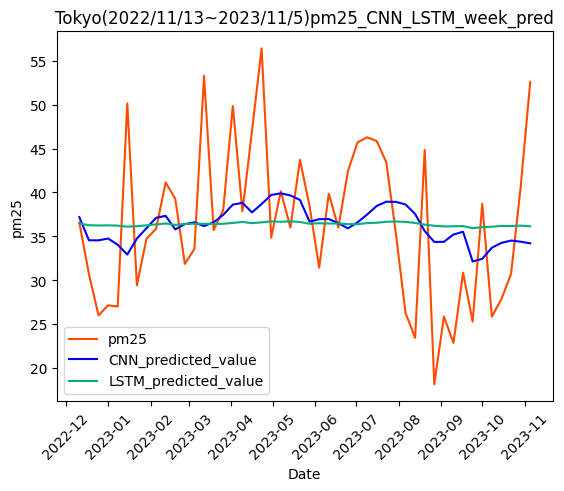

[I 2024-04-08 12:53:35,709] A new study created in memory with name: no-name-48b11ee5-a624-4713-8826-ad2b71b468a2
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:53:38,241] Trial 0 finished with value: 0.01475419723697924 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 71, 'dropout_rate': 0.43930683344726945}. Best is trial 0 with value: 0.01475419723697924.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:53:39,741] Trial 1 finished with value: 0.01605544496748383 and parameters: {'num_conv_layers': 1, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 52, 'dropout_rate': 0.06020694535352733}. Best is trial 0 with value: 0.01475419723697924.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:53:42,075] Trial 2 finished with value: 0.015227518262217563 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 78, 'dropout_rate': 0.2032470224219846}. Best is trial 0 with value: 0.01475419723697924.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 14ms/step


[I 2024-04-08 12:53:44,205] Trial 3 finished with value: 0.015077671613005633 and parameters: {'num_conv_layers': 1, 'conv_filters': 52, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 83, 'dropout_rate': 0.1311581425524762}. Best is trial 0 with value: 0.01475419723697924.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:53:46,252] Trial 4 finished with value: 0.01573026905317712 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 55, 'dropout_rate': 0.14706089807132006}. Best is trial 0 with value: 0.01475419723697924.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:53:54,188] Trial 5 finished with value: 0.0147046963773238 and parameters: {'num_conv_layers': 1, 'conv_filters': 39, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.05422552472652248}. Best is trial 5 with value: 0.0147046963773238.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:53:56,408] Trial 6 finished with value: 0.014599303338100736 and parameters: {'num_conv_layers': 1, 'conv_filters': 19, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 71, 'dropout_rate': 0.07433841922352691}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:53:59,792] Trial 7 finished with value: 0.014611141517660903 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 90, 'dropout_rate': 0.2730443271950797}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:02,386] Trial 8 finished with value: 0.01538446373594432 and parameters: {'num_conv_layers': 2, 'conv_filters': 20, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.4542007981028192}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:04,063] Trial 9 finished with value: 0.015121318338382839 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 35, 'dropout_rate': 0.49056310606490466}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:06,849] Trial 10 finished with value: 0.014786825954399641 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 40, 'dropout_rate': 0.3037901219234759}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:09,122] Trial 11 finished with value: 0.014725241346848349 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 94, 'dropout_rate': 0.30423713422948107}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:12,336] Trial 12 finished with value: 0.014670602155933308 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.34804216098773355}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:14,517] Trial 13 finished with value: 0.014666599473087594 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 68, 'dropout_rate': 0.0074454453601441595}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:16,373] Trial 14 finished with value: 0.015173078793711324 and parameters: {'num_conv_layers': 1, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 90, 'dropout_rate': 0.1800500937302574}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 12:54:18,462] Trial 15 finished with value: 0.014757607365953449 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 76, 'dropout_rate': 0.24997888792773554}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:54:20,320] Trial 16 finished with value: 0.014930254333264953 and parameters: {'num_conv_layers': 1, 'conv_filters': 18, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.34983344428904245}. Best is trial 6 with value: 0.014599303338100736.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:22,614] Trial 17 finished with value: 0.014492295353403578 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.08173374698639443}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:25,987] Trial 18 finished with value: 0.014882153281635146 and parameters: {'num_conv_layers': 2, 'conv_filters': 24, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 44, 'dropout_rate': 0.098320662090403}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:54:27,885] Trial 19 finished with value: 0.015789206976245425 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 98, 'dropout_rate': 0.022234790147586392}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:30,013] Trial 20 finished with value: 0.014884360026072773 and parameters: {'num_conv_layers': 2, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 49, 'dropout_rate': 0.09562443323522302}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:32,793] Trial 21 finished with value: 0.014733041799640736 and parameters: {'num_conv_layers': 2, 'conv_filters': 28, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 90, 'dropout_rate': 0.24028377550979216}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:54:35,595] Trial 22 finished with value: 0.014732661603012823 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 81, 'dropout_rate': 0.1682000630487081}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:54:38,946] Trial 23 finished with value: 0.01712538478803395 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 95, 'dropout_rate': 0.21864549371175562}. Best is trial 17 with value: 0.014492295353403578.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:54:41,155] Trial 24 finished with value: 0.014235995211935267 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 89, 'dropout_rate': 0.11307040937573953}. Best is trial 24 with value: 0.014235995211935267.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:43,285] Trial 25 finished with value: 0.013991191799135208 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 62, 'dropout_rate': 0.1030452181609866}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:45,415] Trial 26 finished with value: 0.014666316900309756 and parameters: {'num_conv_layers': 2, 'conv_filters': 32, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 63, 'dropout_rate': 0.12307124217788629}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:47,922] Trial 27 finished with value: 0.014517102865469297 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.033946818223829084}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:50,786] Trial 28 finished with value: 0.014849381259527594 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 77, 'dropout_rate': 0.10896516660866729}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:54:53,577] Trial 29 finished with value: 0.014744133078574098 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.15962511207694546}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:54:55,954] Trial 30 finished with value: 0.014741689318846686 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 71, 'dropout_rate': 0.19933795983746336}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:54:58,726] Trial 31 finished with value: 0.01476961000547452 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.04180928945961919}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:00,679] Trial 32 finished with value: 0.014420934669335464 and parameters: {'num_conv_layers': 2, 'conv_filters': 43, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 93, 'dropout_rate': 0.0768100659530334}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:03,477] Trial 33 finished with value: 0.014828064946530587 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.07159101189379974}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:05,902] Trial 34 finished with value: 0.014563457016091033 and parameters: {'num_conv_layers': 2, 'conv_filters': 56, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 94, 'dropout_rate': 0.08203714917024892}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 12:55:08,124] Trial 35 finished with value: 0.015000331662808652 and parameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 88, 'dropout_rate': 0.1333169319568968}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:55:10,684] Trial 36 finished with value: 0.01489552042117158 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.0071073356310326075}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:13,444] Trial 37 finished with value: 0.014828887192532421 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 52, 'dropout_rate': 0.05615275605193628}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:15,648] Trial 38 finished with value: 0.01499231148744303 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.12063972280315155}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:18,981] Trial 39 finished with value: 0.014786138197403235 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.1456160284310427}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:21,527] Trial 40 finished with value: 0.014660924223503713 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 100, 'dropout_rate': 0.18983650984955777}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:23,654] Trial 41 finished with value: 0.014576873391204994 and parameters: {'num_conv_layers': 2, 'conv_filters': 46, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 100, 'dropout_rate': 0.03444946214710372}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:55:26,038] Trial 42 finished with value: 0.01456636415613588 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 97, 'dropout_rate': 0.06609469017628421}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:28,156] Trial 43 finished with value: 0.014858371587455066 and parameters: {'num_conv_layers': 2, 'conv_filters': 50, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 92, 'dropout_rate': 0.042697546507937105}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 12:55:31,406] Trial 44 finished with value: 0.014487145091251477 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 86, 'dropout_rate': 0.0894826348493484}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:55:33,781] Trial 45 finished with value: 0.014863778823411963 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 73, 'dropout_rate': 0.09667157322882969}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:55:36,550] Trial 46 finished with value: 0.014569069731177331 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 84, 'dropout_rate': 0.1481970019937828}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:55:38,714] Trial 47 finished with value: 0.015029073173181702 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 88, 'dropout_rate': 0.07859658508535104}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 12:55:40,792] Trial 48 finished with value: 0.0146720625068782 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 81, 'dropout_rate': 0.11346051222929848}. Best is trial 25 with value: 0.013991191799135208.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 12:55:43,467] Trial 49 finished with value: 0.01518961502748955 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 68, 'dropout_rate': 0.3887974866952168}. Best is trial 25 with value: 0.013991191799135208.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 31, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 62, 'dropout_rate': 0.1030452181609866}


<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 6s - loss: 0.0963 - mae: 0.2737

5/5 [==============================] - 2s 6ms/step - loss: 0.0827 - mae: 0.2382
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0432 - mae: 0.1519

5/5 [==============================] - 0s 7ms/step - loss: 0.0487 - mae: 0.1617
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0304 - mae: 0.1189

5/5 [==============================] - 0s 5ms/step - loss: 0.0293 - mae: 0.1205
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0235 - mae: 0.1195

5/5 [==============================] - 0s 5ms/step - loss: 0.0304 - mae: 0.1397
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0368 - mae: 0.1549

5/5 [==============================] - 0s 6ms/step - loss: 0.0309 - mae: 0.1356
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0223 - mae: 0.1112

5/5 [==============================] - 0s 6ms/step - loss: 0.0283 - mae: 0.1230
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0252 - mae: 0.1170

5/5 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1160
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0126 - mae: 0.0898

5/5 [==============================] - 0s 6ms/step - loss: 0.0289 - mae: 0.1187
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154 - mae: 0.0934

5/5 [==============================] - 0s 6ms/step - loss: 0.0278 - mae: 0.1181
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0195 - mae: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0267 - mae: 0.1235
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0284 - mae: 0.1302

5/5 [==============================] - 0s 6ms/step - loss: 0.0271 - mae: 0.1269
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0198 - mae: 0.1100

5/5 [==============================] - 0s 6ms/step - loss: 0.0250 - mae: 0.1172
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0193 - mae: 0.1176

5/5 [==============================] - 0s 6ms/step - loss: 0.0298 - mae: 0.1244
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0294 - mae: 0.1230

5/5 [==============================] - 0s 6ms/step - loss: 0.0287 - mae: 0.1242
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1139

5/5 [==============================] - 0s 6ms/step - loss: 0.0275 - mae: 0.1221
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0312 - mae: 0.1305

5/5 [==============================] - 0s 6ms/step - loss: 0.0259 - mae: 0.1180
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204 - mae: 0.1059

5/5 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1233
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0216 - mae: 0.1151

5/5 [==============================] - 0s 6ms/step - loss: 0.0271 - mae: 0.1245
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0260 - mae: 0.1127

5/5 [==============================] - 0s 7ms/step - loss: 0.0266 - mae: 0.1198
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0428 - mae: 0.1554

5/5 [==============================] - 0s 6ms/step - loss: 0.0275 - mae: 0.1232
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0407 - mae: 0.1479

5/5 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1237
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0405 - mae: 0.1473

5/5 [==============================] - 0s 5ms/step - loss: 0.0277 - mae: 0.1236
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0225 - mae: 0.1083

5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.1210
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0270 - mae: 0.1182

5/5 [==============================] - 0s 6ms/step - loss: 0.0254 - mae: 0.1188
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0207 - mae: 0.1098

5/5 [==============================] - 0s 6ms/step - loss: 0.0252 - mae: 0.1156
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0397 - mae: 0.1424

5/5 [==============================] - 0s 6ms/step - loss: 0.0257 - mae: 0.1171
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0285 - mae: 0.1290

5/5 [==============================] - 0s 8ms/step - loss: 0.0261 - mae: 0.1202
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0370 - mae: 0.1215

5/5 [==============================] - 0s 6ms/step - loss: 0.0257 - mae: 0.1193
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1118

5/5 [==============================] - 0s 6ms/step - loss: 0.0263 - mae: 0.1220
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0213 - mae: 0.1126

5/5 [==============================] - 0s 7ms/step - loss: 0.0244 - mae: 0.1176
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0293 - mae: 0.1253

5/5 [==============================] - 0s 6ms/step - loss: 0.0253 - mae: 0.1173
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0084 - mae: 0.0778

5/5 [==============================] - 0s 5ms/step - loss: 0.0245 - mae: 0.1155
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210 - mae: 0.1213

5/5 [==============================] - 0s 6ms/step - loss: 0.0264 - mae: 0.1226
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1128

5/5 [==============================] - 0s 7ms/step - loss: 0.0273 - mae: 0.1212
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0251 - mae: 0.1180

5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - mae: 0.1148
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0239 - mae: 0.1160

5/5 [==============================] - 0s 6ms/step - loss: 0.0252 - mae: 0.1167
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0119 - mae: 0.0912

5/5 [==============================] - 0s 5ms/step - loss: 0.0250 - mae: 0.1170
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1268

5/5 [==============================] - 0s 6ms/step - loss: 0.0253 - mae: 0.1198
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0399 - mae: 0.1405

5/5 [==============================] - 0s 6ms/step - loss: 0.0266 - mae: 0.1230
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0191 - mae: 0.1068

5/5 [==============================] - 0s 6ms/step - loss: 0.0271 - mae: 0.1188
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0309 - mae: 0.1223

5/5 [==============================] - 0s 6ms/step - loss: 0.0251 - mae: 0.1179
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0146 - mae: 0.1040

5/5 [==============================] - 0s 6ms/step - loss: 0.0264 - mae: 0.1262
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0391 - mae: 0.1460

5/5 [==============================] - 0s 6ms/step - loss: 0.0248 - mae: 0.1190
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244 - mae: 0.1132

5/5 [==============================] - 0s 6ms/step - loss: 0.0272 - mae: 0.1192
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0515 - mae: 0.1687

5/5 [==============================] - 0s 6ms/step - loss: 0.0255 - mae: 0.1176
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0339 - mae: 0.1399

5/5 [==============================] - 0s 6ms/step - loss: 0.0244 - mae: 0.1197
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0215 - mae: 0.1254

5/5 [==============================] - 0s 7ms/step - loss: 0.0263 - mae: 0.1200
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0414 - mae: 0.1517

5/5 [==============================] - 0s 6ms/step - loss: 0.0263 - mae: 0.1161
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0398 - mae: 0.1430

5/5 [==============================] - 0s 6ms/step - loss: 0.0260 - mae: 0.1217
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0257 - mae: 0.1238

2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 12:55:47,304] A new study created in memory with name: no-name-2d61df1d-1bca-47cf-81de-47176e186e20
<ipython-input-10-648d2fa67f65>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-10-648d2fa67f65>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 13ms/step - loss: 0.0149


[I 2024-04-08 12:55:56,996] Trial 0 finished with value: 0.014913800172507763 and parameters: {'n_lstm_layers': 2, 'units_0': 47, 'units_1': 29, 'dropout_rate': 0.41794830669539984, 'learning_rate': 0.00023094374386307118}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 9ms/step - loss: 0.0248


[I 2024-04-08 12:56:03,056] Trial 1 finished with value: 0.02480877935886383 and parameters: {'n_lstm_layers': 1, 'units_0': 51, 'dropout_rate': 0.16588279473264483, 'learning_rate': 0.00011880142268897992}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 13ms/step - loss: 0.0370


[I 2024-04-08 12:56:09,856] Trial 2 finished with value: 0.03699628636240959 and parameters: {'n_lstm_layers': 1, 'units_0': 97, 'dropout_rate': 0.3839778393776453, 'learning_rate': 4.6901484512974965e-05}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 10ms/step - loss: 0.0155


[I 2024-04-08 12:56:21,217] Trial 3 finished with value: 0.015467219054698944 and parameters: {'n_lstm_layers': 3, 'units_0': 89, 'units_1': 96, 'units_2': 49, 'dropout_rate': 0.39314528834335966, 'learning_rate': 0.0004889324371386598}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 12ms/step - loss: 0.0163


[I 2024-04-08 12:56:27,644] Trial 4 finished with value: 0.01633303426206112 and parameters: {'n_lstm_layers': 2, 'units_0': 64, 'units_1': 82, 'dropout_rate': 0.40222405678292333, 'learning_rate': 0.006399094637128552}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 9ms/step - loss: 0.0157


[I 2024-04-08 12:56:43,855] Trial 5 finished with value: 0.015699027106165886 and parameters: {'n_lstm_layers': 3, 'units_0': 63, 'units_1': 24, 'units_2': 83, 'dropout_rate': 0.15083707087192372, 'learning_rate': 8.177734947098621e-05}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 12ms/step - loss: 0.0521


[I 2024-04-08 12:56:57,161] Trial 6 finished with value: 0.05211794376373291 and parameters: {'n_lstm_layers': 3, 'units_0': 47, 'units_1': 64, 'units_2': 77, 'dropout_rate': 0.295848757144257, 'learning_rate': 1.4507715103413134e-05}. Best is trial 0 with value: 0.014913800172507763.


2/2 [==============================] - 0s 10ms/step - loss: 0.0148


[I 2024-04-08 12:57:06,715] Trial 7 finished with value: 0.014842715114355087 and parameters: {'n_lstm_layers': 2, 'units_0': 49, 'units_1': 72, 'dropout_rate': 0.33081869393014646, 'learning_rate': 9.16781293095622e-05}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 8ms/step - loss: 0.0622


[I 2024-04-08 12:57:12,723] Trial 8 finished with value: 0.062228620052337646 and parameters: {'n_lstm_layers': 1, 'units_0': 90, 'dropout_rate': 0.38146738122573676, 'learning_rate': 1.4763598233273993e-05}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 8ms/step - loss: 0.0149


[I 2024-04-08 12:57:21,350] Trial 9 finished with value: 0.014917167834937572 and parameters: {'n_lstm_layers': 2, 'units_0': 32, 'units_1': 56, 'dropout_rate': 0.15895436050262873, 'learning_rate': 0.00011078349431622462}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 7ms/step - loss: 0.0152


[I 2024-04-08 12:57:28,081] Trial 10 finished with value: 0.015178479254245758 and parameters: {'n_lstm_layers': 2, 'units_0': 26, 'units_1': 56, 'dropout_rate': 0.018364641217081812, 'learning_rate': 0.0010075686367811043}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 8ms/step - loss: 0.0152


[I 2024-04-08 12:57:34,998] Trial 11 finished with value: 0.01517381053417921 and parameters: {'n_lstm_layers': 2, 'units_0': 41, 'units_1': 25, 'dropout_rate': 0.47332042530773716, 'learning_rate': 0.0011223289934561712}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 19ms/step - loss: 0.0150


[I 2024-04-08 12:57:41,557] Trial 12 finished with value: 0.01496807113289833 and parameters: {'n_lstm_layers': 2, 'units_0': 72, 'units_1': 41, 'dropout_rate': 0.281059035814552, 'learning_rate': 0.0002838513246502752}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 7ms/step - loss: 0.0151


[I 2024-04-08 12:57:48,967] Trial 13 finished with value: 0.015050824731588364 and parameters: {'n_lstm_layers': 2, 'units_0': 38, 'units_1': 76, 'dropout_rate': 0.49750120806802833, 'learning_rate': 0.0002925637049527958}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 9ms/step - loss: 0.0454


[I 2024-04-08 12:58:01,943] Trial 14 finished with value: 0.04536348208785057 and parameters: {'n_lstm_layers': 3, 'units_0': 21, 'units_1': 41, 'units_2': 20, 'dropout_rate': 0.3123623098317312, 'learning_rate': 3.0715021182545226e-05}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 9ms/step - loss: 0.0174


[I 2024-04-08 12:58:14,322] Trial 15 finished with value: 0.017437614500522614 and parameters: {'n_lstm_layers': 1, 'units_0': 53, 'dropout_rate': 0.22381294665353868, 'learning_rate': 0.0029015886874916457}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 10ms/step - loss: 0.0149


[I 2024-04-08 12:58:21,546] Trial 16 finished with value: 0.014925103634595871 and parameters: {'n_lstm_layers': 2, 'units_0': 76, 'units_1': 73, 'dropout_rate': 0.44936878546547704, 'learning_rate': 0.00018612089376711862}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 9ms/step - loss: 0.0158


[I 2024-04-08 12:58:33,526] Trial 17 finished with value: 0.015772005543112755 and parameters: {'n_lstm_layers': 3, 'units_0': 57, 'units_1': 41, 'units_2': 45, 'dropout_rate': 0.32497965664046335, 'learning_rate': 0.0006242138523106273}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 8ms/step - loss: 0.0358


[I 2024-04-08 12:58:40,689] Trial 18 finished with value: 0.035754889249801636 and parameters: {'n_lstm_layers': 1, 'units_0': 42, 'dropout_rate': 0.22735495974045733, 'learning_rate': 4.2336911028176674e-05}. Best is trial 7 with value: 0.014842715114355087.


2/2 [==============================] - 0s 15ms/step - loss: 0.0148


[I 2024-04-08 12:58:50,063] Trial 19 finished with value: 0.014791254885494709 and parameters: {'n_lstm_layers': 2, 'units_0': 71, 'units_1': 98, 'dropout_rate': 0.3463153859886263, 'learning_rate': 7.35164623407876e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 11ms/step - loss: 0.0244


[I 2024-04-08 12:59:04,578] Trial 20 finished with value: 0.024415181949734688 and parameters: {'n_lstm_layers': 2, 'units_0': 78, 'units_1': 100, 'dropout_rate': 0.34535896165486607, 'learning_rate': 2.5196317227495443e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 12ms/step - loss: 0.0148


[I 2024-04-08 12:59:13,116] Trial 21 finished with value: 0.014816469512879848 and parameters: {'n_lstm_layers': 2, 'units_0': 69, 'units_1': 85, 'dropout_rate': 0.4246641633053422, 'learning_rate': 6.819865280962352e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 13ms/step - loss: 0.0150


[I 2024-04-08 12:59:23,213] Trial 22 finished with value: 0.015002523548901081 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 90, 'dropout_rate': 0.35339715540352334, 'learning_rate': 6.462704940597771e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 8ms/step - loss: 0.0148


[I 2024-04-08 12:59:33,177] Trial 23 finished with value: 0.014818334020674229 and parameters: {'n_lstm_layers': 2, 'units_0': 83, 'units_1': 87, 'dropout_rate': 0.442896361661952, 'learning_rate': 0.0001420686373018086}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 8ms/step - loss: 0.0149


[I 2024-04-08 12:59:42,450] Trial 24 finished with value: 0.014878683723509312 and parameters: {'n_lstm_layers': 2, 'units_0': 83, 'units_1': 88, 'dropout_rate': 0.4385148891491841, 'learning_rate': 0.0001613342986754636}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 8ms/step - loss: 0.0177


[I 2024-04-08 12:59:58,592] Trial 25 finished with value: 0.017661651596426964 and parameters: {'n_lstm_layers': 3, 'units_0': 83, 'units_1': 91, 'units_2': 100, 'dropout_rate': 0.4723844243072729, 'learning_rate': 2.7325108403525848e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 12ms/step - loss: 0.0594


[I 2024-04-08 13:00:06,116] Trial 26 finished with value: 0.0593603253364563 and parameters: {'n_lstm_layers': 1, 'units_0': 72, 'dropout_rate': 0.2640756637553954, 'learning_rate': 1.0265340389062013e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 9ms/step - loss: 0.0148


[I 2024-04-08 13:00:15,471] Trial 27 finished with value: 0.014809598214924335 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 82, 'dropout_rate': 0.4313738141844454, 'learning_rate': 5.796122577003019e-05}. Best is trial 19 with value: 0.014791254885494709.


2/2 [==============================] - 0s 8ms/step - loss: 0.0148


[I 2024-04-08 13:00:25,416] Trial 28 finished with value: 0.0147827984765172 and parameters: {'n_lstm_layers': 2, 'units_0': 98, 'units_1': 80, 'dropout_rate': 0.36287514003212124, 'learning_rate': 5.7998119116710835e-05}. Best is trial 28 with value: 0.0147827984765172.


2/2 [==============================] - 0s 10ms/step - loss: 0.0170


[I 2024-04-08 13:00:39,070] Trial 29 finished with value: 0.01695127598941326 and parameters: {'n_lstm_layers': 3, 'units_0': 100, 'units_1': 79, 'units_2': 20, 'dropout_rate': 0.37023383743252336, 'learning_rate': 4.015096461361365e-05}. Best is trial 28 with value: 0.0147827984765172.


2/2 [==============================] - 0s 16ms/step - loss: 0.0570


[I 2024-04-08 13:00:45,394] Trial 30 finished with value: 0.05700503662228584 and parameters: {'n_lstm_layers': 1, 'units_0': 94, 'dropout_rate': 0.2381011977483206, 'learning_rate': 1.9364483700606183e-05}. Best is trial 28 with value: 0.0147827984765172.


2/2 [==============================] - 0s 9ms/step - loss: 0.0148


[I 2024-04-08 13:00:55,551] Trial 31 finished with value: 0.014773408882319927 and parameters: {'n_lstm_layers': 2, 'units_0': 90, 'units_1': 68, 'dropout_rate': 0.41960131406088874, 'learning_rate': 5.851230922928452e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 12ms/step - loss: 0.0148


[I 2024-04-08 13:01:10,663] Trial 32 finished with value: 0.014818758703768253 and parameters: {'n_lstm_layers': 2, 'units_0': 90, 'units_1': 66, 'dropout_rate': 0.40897671017146026, 'learning_rate': 5.660617237937453e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 9ms/step - loss: 0.0149


[I 2024-04-08 13:01:19,006] Trial 33 finished with value: 0.014891411177814007 and parameters: {'n_lstm_layers': 2, 'units_0': 96, 'units_1': 98, 'dropout_rate': 0.35950481985648747, 'learning_rate': 0.00010084934682512665}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 9ms/step - loss: 0.0148


[I 2024-04-08 13:01:29,186] Trial 34 finished with value: 0.01479633990675211 and parameters: {'n_lstm_layers': 2, 'units_0': 99, 'units_1': 68, 'dropout_rate': 0.40735698687590643, 'learning_rate': 4.9660754872873386e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 9ms/step - loss: 0.0202


[I 2024-04-08 13:01:38,341] Trial 35 finished with value: 0.02017109841108322 and parameters: {'n_lstm_layers': 2, 'units_0': 94, 'units_1': 68, 'dropout_rate': 0.4008668051887782, 'learning_rate': 3.1841198232657146e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 10ms/step - loss: 0.0149


[I 2024-04-08 13:01:45,369] Trial 36 finished with value: 0.014888855628669262 and parameters: {'n_lstm_layers': 2, 'units_0': 88, 'units_1': 60, 'dropout_rate': 0.49926260591950045, 'learning_rate': 0.0004759803551471111}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 13ms/step - loss: 0.0148


[I 2024-04-08 13:01:51,891] Trial 37 finished with value: 0.014849931001663208 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 57, 'dropout_rate': 0.18702949165129773, 'learning_rate': 0.000209405493444989}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 11ms/step - loss: 0.0148


[I 2024-04-08 13:02:02,175] Trial 38 finished with value: 0.014821876771748066 and parameters: {'n_lstm_layers': 2, 'units_0': 94, 'units_1': 71, 'dropout_rate': 0.2973447656988928, 'learning_rate': 4.284269021707075e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 12ms/step - loss: 0.0148


[I 2024-04-08 13:02:11,097] Trial 39 finished with value: 0.01479687262326479 and parameters: {'n_lstm_layers': 2, 'units_0': 79, 'units_1': 50, 'dropout_rate': 0.08062767363370632, 'learning_rate': 8.398978274589907e-05}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 9ms/step - loss: 0.0236


[I 2024-04-08 13:02:18,618] Trial 40 finished with value: 0.023559147492051125 and parameters: {'n_lstm_layers': 1, 'units_0': 90, 'dropout_rate': 0.39019050167308367, 'learning_rate': 0.00011607264191594684}. Best is trial 31 with value: 0.014773408882319927.


2/2 [==============================] - 0s 8ms/step - loss: 0.0147


[I 2024-04-08 13:02:27,188] Trial 41 finished with value: 0.014724615029990673 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 62, 'dropout_rate': 0.08620122480517944, 'learning_rate': 8.232568041713488e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 11ms/step - loss: 0.0311


[I 2024-04-08 13:02:37,358] Trial 42 finished with value: 0.031143823638558388 and parameters: {'n_lstm_layers': 2, 'units_0': 100, 'units_1': 63, 'dropout_rate': 0.05657656731552963, 'learning_rate': 1.9601808561936058e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 26ms/step - loss: 0.0150


[I 2024-04-08 13:02:45,545] Trial 43 finished with value: 0.01498472411185503 and parameters: {'n_lstm_layers': 2, 'units_0': 63, 'units_1': 50, 'dropout_rate': 0.11631486514270217, 'learning_rate': 7.968301219886757e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 10ms/step - loss: 0.0148


[I 2024-04-08 13:02:55,851] Trial 44 finished with value: 0.01479849498718977 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 76, 'dropout_rate': 0.1933529888957925, 'learning_rate': 5.0265660832868394e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 10ms/step - loss: 0.0153


[I 2024-04-08 13:03:15,107] Trial 45 finished with value: 0.015344352461397648 and parameters: {'n_lstm_layers': 3, 'units_0': 75, 'units_1': 93, 'units_2': 66, 'dropout_rate': 0.3755161791660652, 'learning_rate': 0.00012566009735791498}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 14ms/step - loss: 0.0296


[I 2024-04-08 13:03:29,731] Trial 46 finished with value: 0.029634440317749977 and parameters: {'n_lstm_layers': 2, 'units_0': 92, 'units_1': 69, 'dropout_rate': 0.009158735025699374, 'learning_rate': 2.2136061616444348e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 13ms/step - loss: 0.0201


[I 2024-04-08 13:03:44,174] Trial 47 finished with value: 0.020075349137187004 and parameters: {'n_lstm_layers': 2, 'units_0': 81, 'units_1': 62, 'dropout_rate': 0.46603892659846324, 'learning_rate': 3.6870683335503285e-05}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 14ms/step - loss: 0.0149


[I 2024-04-08 13:03:50,997] Trial 48 finished with value: 0.014883874915540218 and parameters: {'n_lstm_layers': 2, 'units_0': 97, 'units_1': 81, 'dropout_rate': 0.3298923897342863, 'learning_rate': 0.0002514712342265795}. Best is trial 41 with value: 0.014724615029990673.


2/2 [==============================] - 0s 10ms/step - loss: 0.0163


[I 2024-04-08 13:03:57,605] Trial 49 finished with value: 0.016283715143799782 and parameters: {'n_lstm_layers': 2, 'units_0': 59, 'units_1': 50, 'dropout_rate': 0.4079741520860829, 'learning_rate': 0.009365778333152488}. Best is trial 41 with value: 0.014724615029990673.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 62, 'dropout_rate': 0.08620122480517944, 'learning_rate': 8.232568041713488e-05}
Epoch 1/50
1/5 [=====>........................] - ETA: 15s - loss: 0.1176

5/5 [==============================] - 4s 12ms/step - loss: 0.1185
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.1136

5/5 [==============================] - 0s 14ms/step - loss: 0.1136
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.1089

5/5 [==============================] - 0s 15ms/step - loss: 0.1089
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.1041

5/5 [==============================] - 0s 16ms/step - loss: 0.1041
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.1001

5/5 [==============================] - 0s 16ms/step - loss: 0.1001
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0957

5/5 [==============================] - 0s 15ms/step - loss: 0.0957
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0913

5/5 [==============================] - 0s 16ms/step - loss: 0.0913
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0874

5/5 [==============================] - 0s 15ms/step - loss: 0.0874
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0836

5/5 [==============================] - 0s 16ms/step - loss: 0.0836
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0797

5/5 [==============================] - 0s 16ms/step - loss: 0.0797
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0753

5/5 [==============================] - 0s 15ms/step - loss: 0.0753
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0720

5/5 [==============================] - 0s 14ms/step - loss: 0.0720
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0681

5/5 [==============================] - 0s 15ms/step - loss: 0.0681
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0647

5/5 [==============================] - 0s 15ms/step - loss: 0.0647
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.0611

5/5 [==============================] - 0s 15ms/step - loss: 0.0611
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0576

5/5 [==============================] - 0s 16ms/step - loss: 0.0576
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0538

5/5 [==============================] - 0s 17ms/step - loss: 0.0538
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0510

5/5 [==============================] - 0s 15ms/step - loss: 0.0510
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0473

5/5 [==============================] - 0s 15ms/step - loss: 0.0473
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0441

5/5 [==============================] - 0s 16ms/step - loss: 0.0441
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0403

5/5 [==============================] - 0s 17ms/step - loss: 0.0403
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0378

5/5 [==============================] - 0s 15ms/step - loss: 0.0378
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0388

5/5 [==============================] - 0s 17ms/step - loss: 0.0388
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0344

5/5 [==============================] - 0s 15ms/step - loss: 0.0344
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0319

5/5 [==============================] - 0s 18ms/step - loss: 0.0319
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299

5/5 [==============================] - 0s 13ms/step - loss: 0.0312
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 0.0292

5/5 [==============================] - 0s 14ms/step - loss: 0.0292
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 0.0283

5/5 [==============================] - 0s 15ms/step - loss: 0.0283
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0278

5/5 [==============================] - 0s 15ms/step - loss: 0.0278
Epoch 30/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0279

5/5 [==============================] - 0s 18ms/step - loss: 0.0273
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 13ms/step - loss: 0.0290
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 0.0274

5/5 [==============================] - 0s 14ms/step - loss: 0.0274
Epoch 33/50
5/5 [==============================] - ETA: 0s - loss: 0.0273

5/5 [==============================] - 0s 14ms/step - loss: 0.0273
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 13ms/step - loss: 0.0264
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210

5/5 [==============================] - 0s 13ms/step - loss: 0.0261
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0154

5/5 [==============================] - 0s 13ms/step - loss: 0.0272
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0320

5/5 [==============================] - 0s 13ms/step - loss: 0.0271
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0121

5/5 [==============================] - 0s 13ms/step - loss: 0.0273
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0269

5/5 [==============================] - 0s 15ms/step - loss: 0.0269
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0266

5/5 [==============================] - 0s 16ms/step - loss: 0.0266
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0267

5/5 [==============================] - 0s 14ms/step - loss: 0.0267
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0273

5/5 [==============================] - 0s 16ms/step - loss: 0.0273
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0282

5/5 [==============================] - 0s 15ms/step - loss: 0.0282
Epoch 44/50
5/5 [==============================] - ETA: 0s - loss: 0.0261

5/5 [==============================] - 0s 16ms/step - loss: 0.0261
Epoch 45/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 19ms/step - loss: 0.0265
Epoch 46/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 22ms/step - loss: 0.0262
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0257

5/5 [==============================] - 0s 19ms/step - loss: 0.0262
Epoch 48/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 17ms/step - loss: 0.0269
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 18ms/step - loss: 0.0270
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0268

2/2 [==============================] - 1s 12ms/step


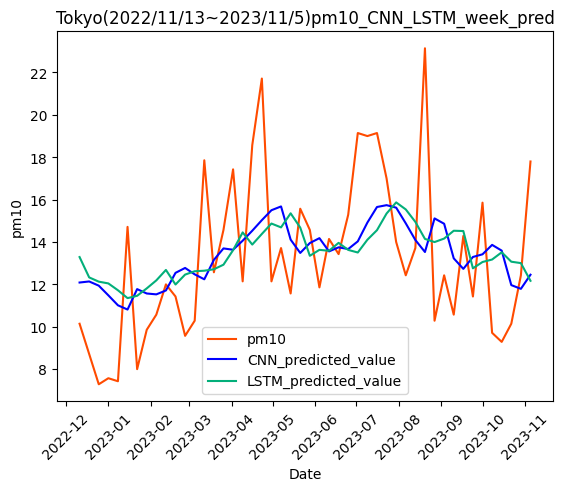

[I 2024-04-08 13:04:09,251] A new study created in memory with name: no-name-029df71d-1fc3-41d6-8f0e-058f5b4823f0
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:11,278] Trial 0 finished with value: 0.018242094728013445 and parameters: {'num_conv_layers': 1, 'conv_filters': 52, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 75, 'dropout_rate': 0.14842892267098268}. Best is trial 0 with value: 0.018242094728013445.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:04:13,178] Trial 1 finished with value: 0.02132747216648868 and parameters: {'num_conv_layers': 1, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 89, 'dropout_rate': 0.20250189173032473}. Best is trial 0 with value: 0.018242094728013445.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-08 13:04:16,995] Trial 2 finished with value: 0.01710802131852406 and parameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.16674399685671798}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:19,567] Trial 3 finished with value: 0.01789571105289085 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 75, 'dropout_rate': 0.021768097875555448}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 12ms/step


[I 2024-04-08 13:04:22,743] Trial 4 finished with value: 0.02320353261861391 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 90, 'dropout_rate': 0.20768557125358156}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:04:24,388] Trial 5 finished with value: 0.022239054794187765 and parameters: {'num_conv_layers': 1, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.08468405134311063}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:26,044] Trial 6 finished with value: 0.018394455718630364 and parameters: {'num_conv_layers': 1, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.4050345029375679}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 13:04:28,559] Trial 7 finished with value: 0.020342554153257572 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 44, 'dropout_rate': 0.13534916702247723}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:04:31,729] Trial 8 finished with value: 0.018743247951515468 and parameters: {'num_conv_layers': 2, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 98, 'dropout_rate': 0.08778605218980712}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:04:33,903] Trial 9 finished with value: 0.01911027453393307 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 59, 'dropout_rate': 0.38340145391446717}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:04:37,151] Trial 10 finished with value: 0.02344474832842607 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 35, 'dropout_rate': 0.3188817750339831}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-08 13:04:39,039] Trial 11 finished with value: 0.020869290521612117 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 50, 'dropout_rate': 0.004222184600004286}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:43,057] Trial 12 finished with value: 0.017589693808200427 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 72, 'dropout_rate': 0.0032083070947039882}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:04:45,031] Trial 13 finished with value: 0.019256881259096744 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 56, 'dropout_rate': 0.4833262274747404}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:04:49,811] Trial 14 finished with value: 0.017860554515523458 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.26867602517964684}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:52,401] Trial 15 finished with value: 0.02024776034444042 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 67, 'dropout_rate': 0.0692269218027417}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:56,293] Trial 16 finished with value: 0.017863538737524217 and parameters: {'num_conv_layers': 2, 'conv_filters': 24, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.16233412577258613}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:04:58,173] Trial 17 finished with value: 0.01861595025347142 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 48, 'dropout_rate': 0.27812268178873983}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:01,706] Trial 18 finished with value: 0.018735435270896487 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 82, 'dropout_rate': 0.04492762517026666}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:05,932] Trial 19 finished with value: 0.017902749845820885 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 54, 'dropout_rate': 0.11007141395904818}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:07,847] Trial 20 finished with value: 0.018464637680410286 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 64, 'dropout_rate': 0.3276062213503233}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:09,954] Trial 21 finished with value: 0.022874020941529613 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 68, 'dropout_rate': 0.24293462379011663}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:12,515] Trial 22 finished with value: 0.02041380013162365 and parameters: {'num_conv_layers': 2, 'conv_filters': 20, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.2637616323303995}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:05:16,302] Trial 23 finished with value: 0.01881096865034539 and parameters: {'num_conv_layers': 2, 'conv_filters': 26, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.18601065984288834}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:18,881] Trial 24 finished with value: 0.0211096247354613 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 60, 'dropout_rate': 0.3210400690676939}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:20,790] Trial 25 finished with value: 0.02258425427940629 and parameters: {'num_conv_layers': 2, 'conv_filters': 32, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 72, 'dropout_rate': 0.24565722175538957}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:05:24,630] Trial 26 finished with value: 0.01744819113434455 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 79, 'dropout_rate': 0.36378491890994774}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:05:27,271] Trial 27 finished with value: 0.021932634692913563 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 90, 'dropout_rate': 0.4879590412638202}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-08 13:05:30,361] Trial 28 finished with value: 0.019562593543137802 and parameters: {'num_conv_layers': 2, 'conv_filters': 39, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 78, 'dropout_rate': 0.38825311629304277}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:32,250] Trial 29 finished with value: 0.022109873371337494 and parameters: {'num_conv_layers': 1, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.43201611797481115}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:34,140] Trial 30 finished with value: 0.01884316678016927 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 86, 'dropout_rate': 0.3503158203886533}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:05:36,718] Trial 31 finished with value: 0.022838093295859816 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 71, 'dropout_rate': 0.28856834650539614}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:05:38,928] Trial 32 finished with value: 0.022509791676287205 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.2282893873659089}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:41,550] Trial 33 finished with value: 0.021156461916686093 and parameters: {'num_conv_layers': 2, 'conv_filters': 23, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.4422496087461304}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:45,808] Trial 34 finished with value: 0.018321896295798137 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.1659342652262007}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:49,195] Trial 35 finished with value: 0.018669639017931606 and parameters: {'num_conv_layers': 2, 'conv_filters': 19, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 66, 'dropout_rate': 0.20816312320482738}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:51,113] Trial 36 finished with value: 0.02181296781755133 and parameters: {'num_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 95, 'dropout_rate': 0.12106014956554248}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:55,045] Trial 37 finished with value: 0.018907589149349712 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 88, 'dropout_rate': 0.35472716416752104}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:05:57,815] Trial 38 finished with value: 0.020703829746711037 and parameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 76, 'dropout_rate': 0.2959793630621507}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:01,663] Trial 39 finished with value: 0.01797327479593094 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 61, 'dropout_rate': 0.03470616101027946}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:03,392] Trial 40 finished with value: 0.0187582584906951 and parameters: {'num_conv_layers': 1, 'conv_filters': 29, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 72, 'dropout_rate': 0.19698767717286117}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:06,053] Trial 41 finished with value: 0.020824847263351754 and parameters: {'num_conv_layers': 2, 'conv_filters': 25, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 82, 'dropout_rate': 0.1465862760173393}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:10,359] Trial 42 finished with value: 0.018046171548267483 and parameters: {'num_conv_layers': 2, 'conv_filters': 24, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 79, 'dropout_rate': 0.0626447071008559}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:06:14,224] Trial 43 finished with value: 0.018049041982086945 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.15991195758666463}. Best is trial 2 with value: 0.01710802131852406.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:18,155] Trial 44 finished with value: 0.01683148114246747 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.10235403832314183}. Best is trial 44 with value: 0.01683148114246747.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:06:22,226] Trial 45 finished with value: 0.024089122641869718 and parameters: {'num_conv_layers': 2, 'conv_filters': 18, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 57, 'dropout_rate': 0.11163471782679957}. Best is trial 44 with value: 0.01683148114246747.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:06:24,155] Trial 46 finished with value: 0.019341076150343504 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 70, 'dropout_rate': 0.07696501123192981}. Best is trial 44 with value: 0.01683148114246747.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:06:26,041] Trial 47 finished with value: 0.01881955038229727 and parameters: {'num_conv_layers': 2, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 65, 'dropout_rate': 0.09039324221321539}. Best is trial 44 with value: 0.01683148114246747.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:29,909] Trial 48 finished with value: 0.016764868175540792 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.2193156265304342}. Best is trial 48 with value: 0.016764868175540792.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:33,802] Trial 49 finished with value: 0.017691660496869765 and parameters: {'num_conv_layers': 2, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 94, 'dropout_rate': 0.022361223034377157}. Best is trial 48 with value: 0.016764868175540792.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 74, 'dropout_rate': 0.2193156265304342}


<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.1753 - mae: 0.3723

5/5 [==============================] - 1s 6ms/step - loss: 0.1370 - mae: 0.3256
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0751 - mae: 0.2324

5/5 [==============================] - 0s 6ms/step - loss: 0.0706 - mae: 0.2185
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0537 - mae: 0.1769

5/5 [==============================] - 0s 5ms/step - loss: 0.0366 - mae: 0.1470
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0374 - mae: 0.1481

5/5 [==============================] - 0s 7ms/step - loss: 0.0288 - mae: 0.1300
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0380 - mae: 0.1395

5/5 [==============================] - 0s 6ms/step - loss: 0.0357 - mae: 0.1463
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299 - mae: 0.1380

5/5 [==============================] - 0s 6ms/step - loss: 0.0289 - mae: 0.1318
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1079

5/5 [==============================] - 0s 7ms/step - loss: 0.0257 - mae: 0.1217
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0341 - mae: 0.1347

5/5 [==============================] - 0s 6ms/step - loss: 0.0245 - mae: 0.1171
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0140 - mae: 0.0919

5/5 [==============================] - 0s 7ms/step - loss: 0.0253 - mae: 0.1181
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0371 - mae: 0.1432

5/5 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.1202
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0307 - mae: 0.1283

5/5 [==============================] - 0s 6ms/step - loss: 0.0265 - mae: 0.1195
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0260 - mae: 0.1296

5/5 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.1187
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1112

5/5 [==============================] - 0s 6ms/step - loss: 0.0228 - mae: 0.1143
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210 - mae: 0.1144

5/5 [==============================] - 0s 6ms/step - loss: 0.0239 - mae: 0.1183
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0218 - mae: 0.1086

5/5 [==============================] - 0s 6ms/step - loss: 0.0237 - mae: 0.1177
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0337 - mae: 0.1485

5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - mae: 0.1206
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0279 - mae: 0.1233

5/5 [==============================] - 0s 6ms/step - loss: 0.0262 - mae: 0.1216
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0272 - mae: 0.1118

5/5 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.1195
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0220 - mae: 0.0953

5/5 [==============================] - 0s 6ms/step - loss: 0.0237 - mae: 0.1102
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0267 - mae: 0.1375

5/5 [==============================] - 0s 7ms/step - loss: 0.0229 - mae: 0.1147
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1381

5/5 [==============================] - 0s 6ms/step - loss: 0.0237 - mae: 0.1195
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0289 - mae: 0.1293

5/5 [==============================] - 0s 6ms/step - loss: 0.0241 - mae: 0.1150
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0235 - mae: 0.1133

5/5 [==============================] - 0s 6ms/step - loss: 0.0233 - mae: 0.1143
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0115 - mae: 0.0866

5/5 [==============================] - 0s 6ms/step - loss: 0.0225 - mae: 0.1141
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0232 - mae: 0.1048

5/5 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.1190
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0146 - mae: 0.0991

5/5 [==============================] - 0s 6ms/step - loss: 0.0226 - mae: 0.1179
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0257 - mae: 0.1155

5/5 [==============================] - 0s 6ms/step - loss: 0.0238 - mae: 0.1178
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0132 - mae: 0.0943

5/5 [==============================] - 0s 6ms/step - loss: 0.0230 - mae: 0.1104
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0295 - mae: 0.1358

5/5 [==============================] - 0s 6ms/step - loss: 0.0233 - mae: 0.1142
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0268 - mae: 0.1135

5/5 [==============================] - 0s 5ms/step - loss: 0.0222 - mae: 0.1139
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1061

5/5 [==============================] - 0s 6ms/step - loss: 0.0215 - mae: 0.1112
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0210 - mae: 0.1043

5/5 [==============================] - 0s 5ms/step - loss: 0.0213 - mae: 0.1103
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0407 - mae: 0.1485

5/5 [==============================] - 0s 6ms/step - loss: 0.0237 - mae: 0.1160
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0313 - mae: 0.1412

5/5 [==============================] - 0s 5ms/step - loss: 0.0224 - mae: 0.1135
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0337 - mae: 0.1342

5/5 [==============================] - 0s 7ms/step - loss: 0.0231 - mae: 0.1127
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0386 - mae: 0.1441

5/5 [==============================] - 0s 6ms/step - loss: 0.0245 - mae: 0.1154
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0145 - mae: 0.1013

5/5 [==============================] - 0s 5ms/step - loss: 0.0247 - mae: 0.1195
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0212 - mae: 0.1157

5/5 [==============================] - 0s 7ms/step - loss: 0.0236 - mae: 0.1146
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0172 - mae: 0.0987

5/5 [==============================] - 0s 5ms/step - loss: 0.0226 - mae: 0.1163
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0150 - mae: 0.0971

5/5 [==============================] - 0s 6ms/step - loss: 0.0243 - mae: 0.1127
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0301 - mae: 0.1348

5/5 [==============================] - 0s 5ms/step - loss: 0.0239 - mae: 0.1158
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0147 - mae: 0.0898

5/5 [==============================] - 0s 7ms/step - loss: 0.0223 - mae: 0.1120
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0222 - mae: 0.1121

5/5 [==============================] - 0s 7ms/step - loss: 0.0223 - mae: 0.1134
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0287 - mae: 0.1252

5/5 [==============================] - 0s 6ms/step - loss: 0.0219 - mae: 0.1110
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - mae: 0.0996

5/5 [==============================] - 0s 7ms/step - loss: 0.0211 - mae: 0.1071
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0181 - mae: 0.1005

5/5 [==============================] - 0s 6ms/step - loss: 0.0209 - mae: 0.1073
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0329 - mae: 0.1250

5/5 [==============================] - 0s 6ms/step - loss: 0.0228 - mae: 0.1118
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0297 - mae: 0.1405

5/5 [==============================] - 0s 6ms/step - loss: 0.0223 - mae: 0.1154
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0333 - mae: 0.1406

5/5 [==============================] - 0s 7ms/step - loss: 0.0222 - mae: 0.1126
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0306 - mae: 0.1204

2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:06:38,041] A new study created in memory with name: no-name-2159f15f-b082-4a88-b849-396684571473
<ipython-input-10-648d2fa67f65>:108: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-10-648d2fa67f65>:109: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 9ms/step - loss: 0.0236


[I 2024-04-08 13:06:49,550] Trial 0 finished with value: 0.023585766553878784 and parameters: {'n_lstm_layers': 3, 'units_0': 63, 'units_1': 89, 'units_2': 29, 'dropout_rate': 0.47626874973238065, 'learning_rate': 0.0033693842836916414}. Best is trial 0 with value: 0.023585766553878784.


2/2 [==============================] - 0s 9ms/step - loss: 0.1117


[I 2024-04-08 13:07:03,923] Trial 1 finished with value: 0.11167033761739731 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 22, 'dropout_rate': 0.2298976198835993, 'learning_rate': 2.4226410855208804e-05}. Best is trial 0 with value: 0.023585766553878784.


2/2 [==============================] - 0s 8ms/step - loss: 0.0207


[I 2024-04-08 13:07:10,274] Trial 2 finished with value: 0.020742133259773254 and parameters: {'n_lstm_layers': 2, 'units_0': 35, 'units_1': 64, 'dropout_rate': 0.1328063068187727, 'learning_rate': 0.0005823727662742279}. Best is trial 2 with value: 0.020742133259773254.


2/2 [==============================] - 0s 7ms/step - loss: 0.1150


[I 2024-04-08 13:07:18,673] Trial 3 finished with value: 0.11500490456819534 and parameters: {'n_lstm_layers': 1, 'units_0': 67, 'dropout_rate': 0.04549040875322785, 'learning_rate': 3.710305789285728e-05}. Best is trial 2 with value: 0.020742133259773254.


2/2 [==============================] - 0s 8ms/step - loss: 0.1345


[I 2024-04-08 13:07:32,285] Trial 4 finished with value: 0.13451232016086578 and parameters: {'n_lstm_layers': 3, 'units_0': 22, 'units_1': 66, 'units_2': 92, 'dropout_rate': 0.013000388904240767, 'learning_rate': 2.0343004801478573e-05}. Best is trial 2 with value: 0.020742133259773254.


2/2 [==============================] - 0s 17ms/step - loss: 0.0201


[I 2024-04-08 13:07:38,739] Trial 5 finished with value: 0.02013629674911499 and parameters: {'n_lstm_layers': 2, 'units_0': 26, 'units_1': 93, 'dropout_rate': 0.3665920268970564, 'learning_rate': 0.0006102813003073588}. Best is trial 5 with value: 0.02013629674911499.


2/2 [==============================] - 0s 8ms/step - loss: 0.0971


[I 2024-04-08 13:07:45,141] Trial 6 finished with value: 0.09711424261331558 and parameters: {'n_lstm_layers': 1, 'units_0': 67, 'dropout_rate': 0.031367709021734747, 'learning_rate': 7.482012005288046e-05}. Best is trial 5 with value: 0.02013629674911499.


2/2 [==============================] - 0s 9ms/step - loss: 0.0203


[I 2024-04-08 13:07:56,438] Trial 7 finished with value: 0.020255912095308304 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 81, 'units_2': 36, 'dropout_rate': 0.29314565918632923, 'learning_rate': 0.008441040181883006}. Best is trial 5 with value: 0.02013629674911499.


2/2 [==============================] - 0s 7ms/step - loss: 0.0193


[I 2024-04-08 13:08:03,152] Trial 8 finished with value: 0.01930738054215908 and parameters: {'n_lstm_layers': 2, 'units_0': 50, 'units_1': 52, 'dropout_rate': 0.20615821061496187, 'learning_rate': 0.0008052658716298169}. Best is trial 8 with value: 0.01930738054215908.


2/2 [==============================] - 0s 8ms/step - loss: 0.1661


[I 2024-04-08 13:08:11,177] Trial 9 finished with value: 0.16605894267559052 and parameters: {'n_lstm_layers': 1, 'units_0': 88, 'dropout_rate': 0.2259963189008523, 'learning_rate': 1.592196321869644e-05}. Best is trial 8 with value: 0.01930738054215908.


2/2 [==============================] - 0s 8ms/step - loss: 0.0189


[I 2024-04-08 13:08:18,861] Trial 10 finished with value: 0.018946342170238495 and parameters: {'n_lstm_layers': 2, 'units_0': 46, 'units_1': 34, 'dropout_rate': 0.14472333991468245, 'learning_rate': 0.00017943745621197644}. Best is trial 10 with value: 0.018946342170238495.


2/2 [==============================] - 0s 10ms/step - loss: 0.0194


[I 2024-04-08 13:08:26,884] Trial 11 finished with value: 0.01944211684167385 and parameters: {'n_lstm_layers': 2, 'units_0': 45, 'units_1': 34, 'dropout_rate': 0.15078385517182483, 'learning_rate': 0.00018814833766417943}. Best is trial 10 with value: 0.018946342170238495.


2/2 [==============================] - 0s 8ms/step - loss: 0.0183


[I 2024-04-08 13:08:35,235] Trial 12 finished with value: 0.018261810764670372 and parameters: {'n_lstm_layers': 2, 'units_0': 46, 'units_1': 43, 'dropout_rate': 0.13879589567504713, 'learning_rate': 0.002034011972748503}. Best is trial 12 with value: 0.018261810764670372.


2/2 [==============================] - 0s 16ms/step - loss: 0.0181


[I 2024-04-08 13:08:44,547] Trial 13 finished with value: 0.018079226836562157 and parameters: {'n_lstm_layers': 2, 'units_0': 48, 'units_1': 41, 'dropout_rate': 0.12471704209200454, 'learning_rate': 0.0024889217004121786}. Best is trial 13 with value: 0.018079226836562157.


2/2 [==============================] - 0s 9ms/step - loss: 0.0212


[I 2024-04-08 13:08:53,022] Trial 14 finished with value: 0.021214380860328674 and parameters: {'n_lstm_layers': 1, 'units_0': 36, 'dropout_rate': 0.09199651009684202, 'learning_rate': 0.0027160404854385304}. Best is trial 13 with value: 0.018079226836562157.


2/2 [==============================] - 0s 12ms/step - loss: 0.0209


[I 2024-04-08 13:09:04,141] Trial 15 finished with value: 0.020908931270241737 and parameters: {'n_lstm_layers': 3, 'units_0': 79, 'units_1': 47, 'units_2': 93, 'dropout_rate': 0.3015801605071964, 'learning_rate': 0.0018325029332246431}. Best is trial 13 with value: 0.018079226836562157.


2/2 [==============================] - 0s 7ms/step - loss: 0.0194


[I 2024-04-08 13:09:10,923] Trial 16 finished with value: 0.019359854981303215 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 43, 'dropout_rate': 0.0985024920467618, 'learning_rate': 0.009832378719766643}. Best is trial 13 with value: 0.018079226836562157.


2/2 [==============================] - 0s 10ms/step - loss: 0.0263


[I 2024-04-08 13:09:20,490] Trial 17 finished with value: 0.026256022974848747 and parameters: {'n_lstm_layers': 3, 'units_0': 33, 'units_1': 23, 'units_2': 54, 'dropout_rate': 0.18367927992996372, 'learning_rate': 0.0013723474072747347}. Best is trial 13 with value: 0.018079226836562157.


2/2 [==============================] - 0s 16ms/step - loss: 0.0174


[I 2024-04-08 13:09:39,232] Trial 18 finished with value: 0.017412027344107628 and parameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 56, 'dropout_rate': 0.07493114269625559, 'learning_rate': 0.005426238631064716}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0204


[I 2024-04-08 13:09:44,705] Trial 19 finished with value: 0.02038586512207985 and parameters: {'n_lstm_layers': 1, 'units_0': 76, 'dropout_rate': 0.08130472032861567, 'learning_rate': 0.004719591863283073}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 19ms/step - loss: 0.0195


[I 2024-04-08 13:09:51,088] Trial 20 finished with value: 0.019522130489349365 and parameters: {'n_lstm_layers': 2, 'units_0': 55, 'units_1': 76, 'dropout_rate': 0.0013199279455202717, 'learning_rate': 0.004732154843776496}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0203


[I 2024-04-08 13:09:57,873] Trial 21 finished with value: 0.020297260954976082 and parameters: {'n_lstm_layers': 2, 'units_0': 43, 'units_1': 54, 'dropout_rate': 0.08745594576728029, 'learning_rate': 0.0011781254209964297}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 13ms/step - loss: 0.0206


[I 2024-04-08 13:10:04,029] Trial 22 finished with value: 0.02061111479997635 and parameters: {'n_lstm_layers': 2, 'units_0': 41, 'units_1': 38, 'dropout_rate': 0.16444904337926758, 'learning_rate': 0.00239161764494157}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 15ms/step - loss: 0.0221


[I 2024-04-08 13:10:11,776] Trial 23 finished with value: 0.022121122106909752 and parameters: {'n_lstm_layers': 2, 'units_0': 57, 'units_1': 59, 'dropout_rate': 0.2805415757791063, 'learning_rate': 0.00575634855679221}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0184


[I 2024-04-08 13:10:19,307] Trial 24 finished with value: 0.01835675723850727 and parameters: {'n_lstm_layers': 2, 'units_0': 73, 'units_1': 44, 'dropout_rate': 0.061568236381873837, 'learning_rate': 0.00033415395003425695}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0198


[I 2024-04-08 13:10:25,795] Trial 25 finished with value: 0.019817765802145004 and parameters: {'n_lstm_layers': 2, 'units_0': 59, 'units_1': 29, 'dropout_rate': 0.12061762184894423, 'learning_rate': 0.0011762514334932544}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0234


[I 2024-04-08 13:10:37,739] Trial 26 finished with value: 0.02341284416615963 and parameters: {'n_lstm_layers': 3, 'units_0': 50, 'units_1': 71, 'units_2': 65, 'dropout_rate': 0.25972736627428666, 'learning_rate': 0.003097241054611301}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0248


[I 2024-04-08 13:10:42,688] Trial 27 finished with value: 0.024801122024655342 and parameters: {'n_lstm_layers': 1, 'units_0': 31, 'dropout_rate': 0.3444695271167524, 'learning_rate': 0.006470787677745141}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0200


[I 2024-04-08 13:10:50,441] Trial 28 finished with value: 0.01998388022184372 and parameters: {'n_lstm_layers': 2, 'units_0': 40, 'units_1': 53, 'dropout_rate': 0.17822746814268464, 'learning_rate': 0.0003266225405461947}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 14ms/step - loss: 0.0257


[I 2024-04-08 13:10:59,305] Trial 29 finished with value: 0.025705894455313683 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 41, 'units_2': 68, 'dropout_rate': 0.48211803322124497, 'learning_rate': 0.0037947022295901542}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0176


[I 2024-04-08 13:11:08,958] Trial 30 finished with value: 0.017565352842211723 and parameters: {'n_lstm_layers': 2, 'units_0': 50, 'units_1': 49, 'dropout_rate': 0.056146274898928455, 'learning_rate': 0.0018935769128061836}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0197


[I 2024-04-08 13:11:16,730] Trial 31 finished with value: 0.019674601033329964 and parameters: {'n_lstm_layers': 2, 'units_0': 47, 'units_1': 58, 'dropout_rate': 0.057769042880511684, 'learning_rate': 0.0018521177782542277}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0199


[I 2024-04-08 13:11:23,465] Trial 32 finished with value: 0.01994934119284153 and parameters: {'n_lstm_layers': 2, 'units_0': 54, 'units_1': 48, 'dropout_rate': 0.11258421747709262, 'learning_rate': 0.0008736917724163475}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0213


[I 2024-04-08 13:11:30,239] Trial 33 finished with value: 0.02130892314016819 and parameters: {'n_lstm_layers': 2, 'units_0': 39, 'units_1': 50, 'dropout_rate': 0.42232424749728975, 'learning_rate': 0.0021784115798289348}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0189


[I 2024-04-08 13:11:36,955] Trial 34 finished with value: 0.018917016685009003 and parameters: {'n_lstm_layers': 2, 'units_0': 62, 'units_1': 36, 'dropout_rate': 0.03627725989344542, 'learning_rate': 0.0034449050348155114}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0212


[I 2024-04-08 13:11:44,676] Trial 35 finished with value: 0.0212213397026062 and parameters: {'n_lstm_layers': 2, 'units_0': 50, 'units_1': 64, 'dropout_rate': 0.06519800658379965, 'learning_rate': 0.0004544706089081538}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0216


[I 2024-04-08 13:11:51,424] Trial 36 finished with value: 0.021603183820843697 and parameters: {'n_lstm_layers': 2, 'units_0': 28, 'units_1': 30, 'dropout_rate': 0.13018928291330745, 'learning_rate': 0.0015892887038854503}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0183


[I 2024-04-08 13:11:58,948] Trial 37 finished with value: 0.018342789262533188 and parameters: {'n_lstm_layers': 2, 'units_0': 58, 'units_1': 56, 'dropout_rate': 0.20243025681777313, 'learning_rate': 0.007745068473036352}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 7ms/step - loss: 0.0210


[I 2024-04-08 13:12:05,413] Trial 38 finished with value: 0.021014593541622162 and parameters: {'n_lstm_layers': 1, 'units_0': 97, 'dropout_rate': 0.031006516651809285, 'learning_rate': 0.0008261189360562889}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0236


[I 2024-04-08 13:12:15,024] Trial 39 finished with value: 0.02357732690870762 and parameters: {'n_lstm_layers': 3, 'units_0': 70, 'units_1': 45, 'units_2': 20, 'dropout_rate': 0.11658731869649536, 'learning_rate': 0.004018601804890668}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 8ms/step - loss: 0.0293


[I 2024-04-08 13:12:25,192] Trial 40 finished with value: 0.02929656021296978 and parameters: {'n_lstm_layers': 2, 'units_0': 23, 'units_1': 40, 'dropout_rate': 0.017618764055761876, 'learning_rate': 6.19331070640871e-05}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 17ms/step - loss: 0.0205


[I 2024-04-08 13:12:31,045] Trial 41 finished with value: 0.02047603949904442 and parameters: {'n_lstm_layers': 2, 'units_0': 59, 'units_1': 57, 'dropout_rate': 0.1978008523172631, 'learning_rate': 0.007094772724419373}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0185


[I 2024-04-08 13:12:38,576] Trial 42 finished with value: 0.018520735204219818 and parameters: {'n_lstm_layers': 2, 'units_0': 65, 'units_1': 100, 'dropout_rate': 0.21969860551159048, 'learning_rate': 0.008646633151452544}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 14ms/step - loss: 0.0182


[I 2024-04-08 13:12:45,366] Trial 43 finished with value: 0.018156854435801506 and parameters: {'n_lstm_layers': 2, 'units_0': 51, 'units_1': 63, 'dropout_rate': 0.155013806938246, 'learning_rate': 0.005650406930413022}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 13ms/step - loss: 0.0210


[I 2024-04-08 13:12:52,043] Trial 44 finished with value: 0.021043961867690086 and parameters: {'n_lstm_layers': 2, 'units_0': 48, 'units_1': 65, 'dropout_rate': 0.15139551960828215, 'learning_rate': 0.002706867873327574}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 11ms/step - loss: 0.0174


[I 2024-04-08 13:12:59,123] Trial 45 finished with value: 0.01744910329580307 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 62, 'dropout_rate': 0.08160697691796341, 'learning_rate': 0.004752607313025418}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0175


[I 2024-04-08 13:13:06,558] Trial 46 finished with value: 0.017505943775177002 and parameters: {'n_lstm_layers': 2, 'units_0': 52, 'units_1': 70, 'dropout_rate': 0.07419615952331496, 'learning_rate': 0.005412669886580565}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 9ms/step - loss: 0.0175


[I 2024-04-08 13:13:15,826] Trial 47 finished with value: 0.01747947931289673 and parameters: {'n_lstm_layers': 2, 'units_0': 54, 'units_1': 71, 'dropout_rate': 0.0501423104104035, 'learning_rate': 0.004798254736053337}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0175


[I 2024-04-08 13:13:22,612] Trial 48 finished with value: 0.01751519925892353 and parameters: {'n_lstm_layers': 2, 'units_0': 55, 'units_1': 71, 'dropout_rate': 0.049203263047663454, 'learning_rate': 0.004393294303743661}. Best is trial 18 with value: 0.017412027344107628.


2/2 [==============================] - 0s 10ms/step - loss: 0.0200


[I 2024-04-08 13:13:28,589] Trial 49 finished with value: 0.019964182749390602 and parameters: {'n_lstm_layers': 1, 'units_0': 68, 'dropout_rate': 0.019476374351088316, 'learning_rate': 0.004383321532789105}. Best is trial 18 with value: 0.017412027344107628.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 56, 'dropout_rate': 0.07493114269625559, 'learning_rate': 0.005426238631064716}
Epoch 1/50
1/5 [=====>........................] - ETA: 15s - loss: 0.2007

5/5 [==============================] - 4s 10ms/step - loss: 0.1121
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0532

5/5 [==============================] - 0s 12ms/step - loss: 0.0347
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0165

5/5 [==============================] - 0s 12ms/step - loss: 0.0397
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 13ms/step - loss: 0.0286
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0306

5/5 [==============================] - 0s 12ms/step - loss: 0.0281
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237

5/5 [==============================] - 0s 13ms/step - loss: 0.0266
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0228

5/5 [==============================] - 0s 12ms/step - loss: 0.0249
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0243

5/5 [==============================] - 0s 12ms/step - loss: 0.0255
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0144

5/5 [==============================] - 0s 12ms/step - loss: 0.0238
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0246

5/5 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0184

5/5 [==============================] - 0s 13ms/step - loss: 0.0251
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0230

5/5 [==============================] - 0s 13ms/step - loss: 0.0243
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 11ms/step - loss: 0.0254
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0198

5/5 [==============================] - 0s 11ms/step - loss: 0.0229
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0122

5/5 [==============================] - 0s 11ms/step - loss: 0.0230
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 11ms/step - loss: 0.0273
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0217

5/5 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0197

5/5 [==============================] - 0s 11ms/step - loss: 0.0238
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 13ms/step - loss: 0.0231
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0152

5/5 [==============================] - 0s 10ms/step - loss: 0.0239
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244

5/5 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 11ms/step - loss: 0.0241
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0188

5/5 [==============================] - 0s 10ms/step - loss: 0.0238
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0270

5/5 [==============================] - 0s 11ms/step - loss: 0.0215
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0164

5/5 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0187

5/5 [==============================] - 0s 11ms/step - loss: 0.0226
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0204

5/5 [==============================] - 0s 13ms/step - loss: 0.0227
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0195

5/5 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0203

5/5 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0308

5/5 [==============================] - 0s 11ms/step - loss: 0.0234
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0187

5/5 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0156

5/5 [==============================] - 0s 11ms/step - loss: 0.0226
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0186

5/5 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0217

5/5 [==============================] - 0s 11ms/step - loss: 0.0276
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0140

5/5 [==============================] - 0s 12ms/step - loss: 0.0239
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0281

5/5 [==============================] - 0s 13ms/step - loss: 0.0231
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0347

5/5 [==============================] - 0s 11ms/step - loss: 0.0244
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0206

5/5 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0215

5/5 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0311

5/5 [==============================] - 0s 11ms/step - loss: 0.0223
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0297

5/5 [==============================] - 0s 11ms/step - loss: 0.0240
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0126

5/5 [==============================] - 0s 11ms/step - loss: 0.0252
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0175

5/5 [==============================] - 0s 11ms/step - loss: 0.0243
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183

5/5 [==============================] - 0s 11ms/step - loss: 0.0205
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0303

5/5 [==============================] - 0s 11ms/step - loss: 0.0256
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0224

5/5 [==============================] - 0s 10ms/step - loss: 0.0247
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0201

5/5 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0274

5/5 [==============================] - 0s 11ms/step - loss: 0.0224
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0291

2/2 [==============================] - 1s 7ms/step


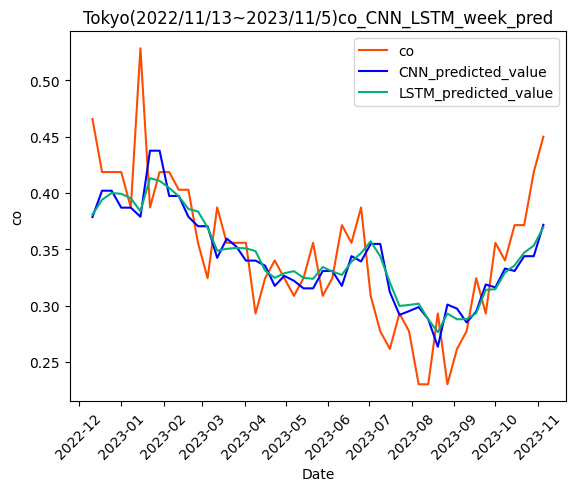

[I 2024-04-08 13:13:44,644] A new study created in memory with name: no-name-b05bd7f9-bffe-4fef-832b-039e8e49e0fc
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 13ms/step


[I 2024-04-08 13:13:47,229] Trial 0 finished with value: 0.011879731347200778 and parameters: {'num_conv_layers': 1, 'conv_filters': 55, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 52, 'dropout_rate': 0.08487675844014403}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:13:51,558] Trial 1 finished with value: 0.014042292484487205 and parameters: {'num_conv_layers': 1, 'conv_filters': 21, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 96, 'dropout_rate': 0.1347898986234698}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 13:13:54,310] Trial 2 finished with value: 0.014852723361072863 and parameters: {'num_conv_layers': 1, 'conv_filters': 36, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 86, 'dropout_rate': 0.24471257853490863}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:13:56,836] Trial 3 finished with value: 0.012910482525420675 and parameters: {'num_conv_layers': 2, 'conv_filters': 35, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 50, 'dropout_rate': 0.3198667148365042}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-08 13:13:59,254] Trial 4 finished with value: 0.012209572454571197 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 85, 'dropout_rate': 0.12468780079986169}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:01,478] Trial 5 finished with value: 0.013140450307054866 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 67, 'dropout_rate': 0.08142574102542255}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:03,153] Trial 6 finished with value: 0.01406589354438767 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 70, 'dropout_rate': 0.46214766413816094}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:14:07,454] Trial 7 finished with value: 0.012689787247381361 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 98, 'dropout_rate': 0.41149226731778826}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:09,384] Trial 8 finished with value: 0.013103412439231651 and parameters: {'num_conv_layers': 1, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 56, 'dropout_rate': 0.4741111715569656}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:14:11,508] Trial 9 finished with value: 0.014236741388439186 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 99, 'dropout_rate': 0.3494027102360906}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:13,239] Trial 10 finished with value: 0.01502532844689354 and parameters: {'num_conv_layers': 1, 'conv_filters': 46, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 33, 'dropout_rate': 0.006570629497275132}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 13:14:15,804] Trial 11 finished with value: 0.012506951024428142 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.11934653811291251}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 13:14:20,037] Trial 12 finished with value: 0.012141350953914882 and parameters: {'num_conv_layers': 2, 'conv_filters': 50, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 48, 'dropout_rate': 0.1981699177900162}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 4ms/step


[I 2024-04-08 13:14:21,644] Trial 13 finished with value: 0.013026043267339917 and parameters: {'num_conv_layers': 1, 'conv_filters': 45, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 43, 'dropout_rate': 0.2074180982840042}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:24,437] Trial 14 finished with value: 0.012937021121016794 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 58, 'dropout_rate': 0.004780167053809847}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:14:25,997] Trial 15 finished with value: 0.012203323875195626 and parameters: {'num_conv_layers': 1, 'conv_filters': 42, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 40, 'dropout_rate': 0.1959481718338528}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-08 13:14:28,012] Trial 16 finished with value: 0.016831728262382908 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 50, 'dropout_rate': 0.06727860336574293}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-08 13:14:29,739] Trial 17 finished with value: 0.013363727866939118 and parameters: {'num_conv_layers': 1, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 60, 'dropout_rate': 0.30760019702398333}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:14:31,921] Trial 18 finished with value: 0.013634093483623216 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 33, 'dropout_rate': 0.17732879943134566}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:14:34,429] Trial 19 finished with value: 0.013709333382751347 and parameters: {'num_conv_layers': 2, 'conv_filters': 40, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 45, 'dropout_rate': 0.2572079206732321}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-08 13:14:36,384] Trial 20 finished with value: 0.013809338003272685 and parameters: {'num_conv_layers': 2, 'conv_filters': 16, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 72, 'dropout_rate': 0.07326469207101116}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-08 13:14:37,919] Trial 21 finished with value: 0.014141638616722055 and parameters: {'num_conv_layers': 1, 'conv_filters': 43, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 43, 'dropout_rate': 0.18336652515239973}. Best is trial 0 with value: 0.011879731347200778.
<ipython-input-10-648d2fa67f65>:42: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


In [ ]:
#CNNの1週間単位の関数を回す(試験回数50,エポック50)
%%time
create_week_model(Tokyo,"Tokyo")
# create_week_model(Delhi,"Delhi")

In [ ]:
#CNNの1週間単位の関数を回す(試験回数50,エポック50)
create_week_model(Delhi,"Delhi")

In [ ]:
# #1週間単位の予測をcreate_week_model関数にて、cnn,lstmの両方を動かす
# def create_week_model(df,city_name):
#   #グラフを保存するpathを作成
#   path_img = f"{working_dir}/result/graph/深層学習"
#   #予測値の値を保存するデータフレームを作成
#   df_pred_data = pd.DataFrame(columns=[])
#   for element in elements:
#     df_w = df.resample("W").mean()
#     rh_min = df_w[element].min()
#     rh_max = df_w[element].max()
#     df_w["target"] = (df_w[element] - rh_min) / (rh_max - rh_min)
#     df_target = df_w[["target"]]
#     df_train = df_target[:-104]
#     df_val = df_target[-104:-52]
#     df_test = df_target[-52:]

#     #学習データの作成
#     dataset_train = df_train.dropna().values
#     dataset_val = df_val.dropna().values
#     dataset_test = df_test.dropna().values
#     #約一ヶ月(4つ)の値から1週間の値を出力
#     n_steps_in = 4
#     n_steps_out = 1
#     X_train,y_train = make_sequences(dataset_train,n_steps_in,n_steps_out)
#     X_val,y_val = make_sequences(dataset_val,n_steps_in,n_steps_out)
#     X_test,y_test = make_sequences(dataset_test,n_steps_in,n_steps_out)

#     n_features = X_train.shape[2]
#     n_timessteps = X_train.shape[1]
#     n_outputs = y_train.shape[1]


#     # #CNNの予測モデル
#     def create_cnn_week_model(trial):
#         model = Sequential()

#         num_conv_layers = trial.suggest_int('num_conv_layers', 1, 2)
#         conv_filters = trial.suggest_int('conv_filters', 16, 64)
#         kernel_size = trial.suggest_int('kernel_size', 1, 2)
#         num_dense_layers = trial.suggest_int('num_dense_layers', 1, 2)
#         dense_units = trial.suggest_int('dense_units', 32, 100)
#         dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

#         for i in range(num_conv_layers):
#             model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps_in, n_features)))

#         model.add(MaxPooling1D(pool_size=2))
#         model.add(Flatten())

#         for i in range(num_dense_layers):
#             model.add(Dense(units=dense_units, activation='relu'))
#             model.add(Dropout(dropout_rate))

#         model.add(Dense(units=1, activation='linear'))

#         model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#         return model



#     def objective_cnn(trial, X_train, y_train, X_val, y_val):
#         # input_shape = X_train.shape[1:]
#         model = create_cnn_week_model(trial)
#         early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#         history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32,callbacks=[early_stopping], verbose=0)

#         y_val_pred = model.predict(X_val)
#         val_mse = mean_squared_error(y_val, y_val_pred)

#         return val_mse

#     # Optunaでハイパーパラメータの最適化（訓練データと検証データを使用）
#     study = optuna.create_study(direction='minimize')
#     study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, X_val, y_val), n_trials=30)

#     # 最適なハイパーパラメータの取得
#     best_params = study.best_params
#     print("Best Hyperparameters:", best_params)

#     optimal_model = create_cnn_week_model(study.best_trial)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     optimal_model.fit(X_train, y_train, epochs=5, batch_size=32, callbacks=[early_stopping],verbose=1)

#     y_test_pred = optimal_model.predict(X_test)
#     pred_cnn_ = y_test_pred.ravel().tolist()


#     y_test_ = y_test.ravel().tolist()
#     result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_cnn_)], axis=1))
#     result_df.columns = [f"{element}_scaled_cnn", f"pred_scaled_{element}_cnn"]

#     #計算するときは正規化した状態で予測値を算出しているため、元の値に戻した列を作成する
#     result_df[f"{element}_original_cnn"] = result_df[f"{element}_scaled_cnn"] * (rh_max-rh_min) + rh_min
#     result_df[f"{element}_pred_original_cnn"] = result_df[f"pred_scaled_{element}_cnn"] * (rh_max-rh_min) + rh_min
#     mape_df = str(str(round(mape(result_df[f"{element}_pred_original_cnn"], result_df[f"{element}_original_cnn"])*100,2))+"%")
#     #MAPE値を保存するデータフレームに追加
#     df_results.at[f"{city_name}_{element}","cnn_week_mape"] = mape_df
#     df_tests = df_w[-len(result_df):]
#     df_tests = df_tests.reset_index()

#     df_pred_week[f"{city_name}_{element}_cnn"] = result_df[f"{element}_pred_original_cnn"].values
#     graph_df = pd.concat([df_tests, result_df[f"{element}_pred_original_cnn"]], axis=1)


#     #LSTMの1週間単位の予測モデル
#     def create_lstm_week_model(trial):
#       n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3)  # LSTM層の数
#       units_per_layer = [trial.suggest_int(f'units_{i}', 20, 100) for i in range(n_lstm_layers)]  # 各LSTM層のユニット数
#       dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
#       learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

#       model = Sequential()
#       for i in range(n_lstm_layers):
#           if i == 0:
#               model.add(LSTM(units=units_per_layer[i], input_shape=(n_steps_in,n_features), dropout=dropout_rate, return_sequences=True))
#           elif i == n_lstm_layers - 1:
#               model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate))
#           else:
#               model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate, return_sequences=True))

#       model.add(Dense(1))

#       optimizer = Adam(learning_rate=learning_rate)
#       model.compile(optimizer=optimizer, loss='mean_squared_error')

#       return model

#     def objective_lstm(trial):
#       model = create_lstm_week_model(trial)

#       early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#       model.fit(X_train,
#                 y_train,
#                 epochs=50,
#                 batch_size=32,
#                 validation_data=(X_val, y_val),
#                 callbacks=[early_stopping],
#                 verbose=0)

#       val_loss = model.evaluate(X_val, y_val, verbose=1)

#       return val_loss

#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective_lstm, n_trials=50)

#     best_params = study.best_params
#     print("Best Hyperparameters:", best_params)

#     # 最適なハイパーパラメータで最終的なモデルを構築
#     best_model = create_lstm_week_model(study.best_trial)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#     # モデルの訓練（全データを使用）
#     best_model.fit(X_train,
#                    y_train,
#                   epochs=50,
#                   batch_size=32,
#                   callbacks=[early_stopping],
#                   verbose=1)

#     pred_lstm = best_model.predict(X_test)
#     pred_lstm_ = pred_lstm.ravel().tolist()
#     y_test_ = y_test.ravel().tolist()
#     result_df_lstm = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_lstm_)], axis=1))
#     result_df_lstm.columns = [f"{element}_scaled", f"pred_scaled_{element}"]

#     result_df_lstm[f"{element}_original"] = result_df_lstm[f"{element}_scaled"] * (rh_max-rh_min) + rh_min
#     result_df_lstm[f"{element}_pred_original"] = result_df_lstm[f"pred_scaled_{element}"] * (rh_max-rh_min) + rh_min
#     mape_df = str(str(round(mape(result_df_lstm[f"{element}_pred_original"], result_df_lstm[f"{element}_original"])*100,2))+"%")
#     df_results.at[f"{city_name}_{element}","lstm_week_mape"] = mape_df


#     df_tests_lstm = df_w[-len(result_df_lstm):]
#     df_tests_lstm = df_tests_lstm.reset_index()

#     df_pred_week[f"{city_name}_{element}_lstm"] = result_df_lstm[f"{element}_pred_original"].values
#     graph_df_lstm = pd.concat([graph_df, result_df_lstm[f"{element}_pred_original"]], axis=1)
#     graph_df_lstm["Date"]= pd.to_datetime(graph_df_lstm['Date'])
#     graph_df_lstm.set_index('Date', inplace=True)




#     #グラフ作成

#     plt.plot(graph_df_lstm[f"{element}"], color="#FF4B00",label = element)
#     plt.plot(graph_df_lstm[f"{element}_pred_original_cnn"], color="blue",label = "CNN_predicted_value")
#     plt.plot(graph_df_lstm[f"{element}_pred_original"], color="#03AF7A",label = "LSTM_predicted_value")
#     plt.title(f'{city_name}(2022/11/13~2023/11/5){element}_CNN_LSTM_week_pred')
#     plt.xlabel("Date")
#     plt.ylabel(element)
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.savefig(f'{path_img}/{city_name}_{element}_cnn_lstm_week.png',bbox_inches='tight')
#     plt.show()



#   return graph_df_lstm



[I 2024-04-03 10:38:37,948] A new study created in memory with name: no-name-0a0e7573-10b7-450d-9e02-ee09ac861893
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-03 10:38:44,369] Trial 0 finished with value: 0.01731468002689464 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 48, 'dropout_rate': 0.0870592312415937}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:38:48,789] Trial 1 finished with value: 0.019719427427212447 and parameters: {'num_conv_layers': 2, 'conv_filters': 63, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 56, 'dropout_rate': 0.38331413146631227}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:38:53,053] Trial 2 finished with value: 0.019451308236171107 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 66, 'dropout_rate': 0.3781901470624627}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:38:56,821] Trial 3 finished with value: 0.018994321647655146 and parameters: {'num_conv_layers': 2, 'conv_filters': 52, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 46, 'dropout_rate': 0.10608630081299841}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-03 10:39:13,917] Trial 4 finished with value: 0.01752258530194348 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.10216100988676319}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-03 10:39:21,405] Trial 5 finished with value: 0.020470958241051 and parameters: {'num_conv_layers': 1, 'conv_filters': 26, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 69, 'dropout_rate': 0.11895648562370703}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-03 10:39:29,654] Trial 6 finished with value: 0.02289898795344669 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 79, 'dropout_rate': 0.040003589968793385}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:39:33,674] Trial 7 finished with value: 0.018589358799944115 and parameters: {'num_conv_layers': 2, 'conv_filters': 52, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 55, 'dropout_rate': 0.079512627947318}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:39:36,894] Trial 8 finished with value: 0.021759192011373496 and parameters: {'num_conv_layers': 1, 'conv_filters': 37, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 65, 'dropout_rate': 0.089316912761434}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-03 10:39:39,385] Trial 9 finished with value: 0.022142409161766196 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 84, 'dropout_rate': 0.2108165966074536}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:39:42,928] Trial 10 finished with value: 0.02300177322325606 and parameters: {'num_conv_layers': 1, 'conv_filters': 16, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 32, 'dropout_rate': 0.49364349872206}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:39:44,985] Trial 11 finished with value: 0.01963483641142767 and parameters: {'num_conv_layers': 2, 'conv_filters': 38, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 41, 'dropout_rate': 0.20370249928141365}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:39:48,309] Trial 12 finished with value: 0.018859742633257643 and parameters: {'num_conv_layers': 2, 'conv_filters': 33, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 94, 'dropout_rate': 0.022615821749054132}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:39:51,023] Trial 13 finished with value: 0.020901410842117638 and parameters: {'num_conv_layers': 2, 'conv_filters': 27, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 51, 'dropout_rate': 0.17999412886069113}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-03 10:39:53,777] Trial 14 finished with value: 0.020759444870269424 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 38, 'dropout_rate': 0.2672216483516429}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:39:56,642] Trial 15 finished with value: 0.02279681970914449 and parameters: {'num_conv_layers': 2, 'conv_filters': 17, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 60, 'dropout_rate': 0.2986242061596797}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:40:01,593] Trial 16 finished with value: 0.020328575002760595 and parameters: {'num_conv_layers': 2, 'conv_filters': 30, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 76, 'dropout_rate': 0.15262334819931164}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:40:04,680] Trial 17 finished with value: 0.01904397237407283 and parameters: {'num_conv_layers': 1, 'conv_filters': 64, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 48, 'dropout_rate': 0.014251472200084658}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-03 10:40:07,820] Trial 18 finished with value: 0.020512139294054894 and parameters: {'num_conv_layers': 2, 'conv_filters': 22, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 91, 'dropout_rate': 0.14088052748903052}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:40:12,917] Trial 19 finished with value: 0.017687363171787564 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 72, 'dropout_rate': 0.05441237391265053}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:40:15,305] Trial 20 finished with value: 0.020561800754795388 and parameters: {'num_conv_layers': 1, 'conv_filters': 34, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 60, 'dropout_rate': 0.3041219498145362}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:40:18,819] Trial 21 finished with value: 0.01772299959781391 and parameters: {'num_conv_layers': 2, 'conv_filters': 44, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 73, 'dropout_rate': 0.05486363542576134}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:40:23,424] Trial 22 finished with value: 0.018854075975198187 and parameters: {'num_conv_layers': 2, 'conv_filters': 42, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 70, 'dropout_rate': 0.06909817000239038}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:40:27,701] Trial 23 finished with value: 0.01759922518241176 and parameters: {'num_conv_layers': 2, 'conv_filters': 48, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 82, 'dropout_rate': 0.15699586126807505}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:40:30,412] Trial 24 finished with value: 0.020015294288652757 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 86, 'dropout_rate': 0.1781895513508281}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 10ms/step


[I 2024-04-03 10:40:32,981] Trial 25 finished with value: 0.02059546406453708 and parameters: {'num_conv_layers': 2, 'conv_filters': 57, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 100, 'dropout_rate': 0.22899379981911216}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:40:36,575] Trial 26 finished with value: 0.01885486224467963 and parameters: {'num_conv_layers': 2, 'conv_filters': 49, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 63, 'dropout_rate': 0.1356887257249629}. Best is trial 0 with value: 0.01731468002689464.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:40:44,619] Trial 27 finished with value: 0.016340227574744345 and parameters: {'num_conv_layers': 2, 'conv_filters': 59, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.004316622080416707}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:40:51,141] Trial 28 finished with value: 0.01773353144260863 and parameters: {'num_conv_layers': 2, 'conv_filters': 61, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 42, 'dropout_rate': 0.020092888840601397}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:40:54,675] Trial 29 finished with value: 0.018058093268897013 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 1, 'num_dense_layers': 1, 'dense_units': 55, 'dropout_rate': 0.0036470264917893847}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 1s 8ms/step


[I 2024-04-03 10:40:59,773] Trial 30 finished with value: 0.01798073116033111 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 51, 'dropout_rate': 0.09691089493258985}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:41:04,047] Trial 31 finished with value: 0.017793363275825026 and parameters: {'num_conv_layers': 2, 'conv_filters': 47, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.17149517957321964}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 8ms/step


[I 2024-04-03 10:41:08,730] Trial 32 finished with value: 0.017451982838034397 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 89, 'dropout_rate': 0.1207172984154751}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:41:13,122] Trial 33 finished with value: 0.017996029381484924 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 91, 'dropout_rate': 0.0980734602270747}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:41:20,254] Trial 34 finished with value: 0.01669113659490708 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 97, 'dropout_rate': 0.06438501328132865}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:41:23,290] Trial 35 finished with value: 0.019048592052981105 and parameters: {'num_conv_layers': 2, 'conv_filters': 59, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 98, 'dropout_rate': 0.04879319209563417}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:41:26,996] Trial 36 finished with value: 0.017332630309845196 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 87, 'dropout_rate': 0.11669117471818691}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 9ms/step


[I 2024-04-03 10:41:29,657] Trial 37 finished with value: 0.01897725461219307 and parameters: {'num_conv_layers': 2, 'conv_filters': 53, 'kernel_size': 1, 'num_dense_layers': 2, 'dense_units': 97, 'dropout_rate': 0.00013205519802197974}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:41:35,195] Trial 38 finished with value: 0.017898875134454883 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 77, 'dropout_rate': 0.43272944881241476}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:41:37,910] Trial 39 finished with value: 0.022533928947948104 and parameters: {'num_conv_layers': 1, 'conv_filters': 56, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 87, 'dropout_rate': 0.07400312511447608}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:41:45,521] Trial 40 finished with value: 0.017473590138280683 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 2, 'num_dense_layers': 2, 'dense_units': 94, 'dropout_rate': 0.12355378534423404}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:41:49,613] Trial 41 finished with value: 0.01816107219560172 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 88, 'dropout_rate': 0.036827019223496654}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:41:52,472] Trial 42 finished with value: 0.020755432893563477 and parameters: {'num_conv_layers': 2, 'conv_filters': 54, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 91, 'dropout_rate': 0.1133412439783834}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 7ms/step


[I 2024-04-03 10:41:57,723] Trial 43 finished with value: 0.017845334296912065 and parameters: {'num_conv_layers': 2, 'conv_filters': 60, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 94, 'dropout_rate': 0.07245499082440003}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:42:00,510] Trial 44 finished with value: 0.01811567073707743 and parameters: {'num_conv_layers': 2, 'conv_filters': 64, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.03575617157827113}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:42:04,530] Trial 45 finished with value: 0.017868962821903284 and parameters: {'num_conv_layers': 2, 'conv_filters': 55, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 80, 'dropout_rate': 0.10324013678113907}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 11ms/step


[I 2024-04-03 10:42:10,333] Trial 46 finished with value: 0.017721360049891537 and parameters: {'num_conv_layers': 2, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 89, 'dropout_rate': 0.08218818346476599}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 6ms/step


[I 2024-04-03 10:42:12,481] Trial 47 finished with value: 0.020641930277712703 and parameters: {'num_conv_layers': 2, 'conv_filters': 58, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 33, 'dropout_rate': 0.12092227374450021}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 5ms/step


[I 2024-04-03 10:42:14,531] Trial 48 finished with value: 0.022820965333510038 and parameters: {'num_conv_layers': 1, 'conv_filters': 51, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 84, 'dropout_rate': 0.3552447392730461}. Best is trial 27 with value: 0.016340227574744345.
<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


2/2 [==============================] - 0s 15ms/step


[I 2024-04-03 10:42:20,866] Trial 49 finished with value: 0.017768687394028905 and parameters: {'num_conv_layers': 2, 'conv_filters': 62, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 96, 'dropout_rate': 0.2063756261928334}. Best is trial 27 with value: 0.016340227574744345.


Best Hyperparameters: {'num_conv_layers': 2, 'conv_filters': 59, 'kernel_size': 2, 'num_dense_layers': 1, 'dense_units': 81, 'dropout_rate': 0.004316622080416707}


<ipython-input-17-2c369b1f76ee>:44: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/50
1/5 [=====>........................] - ETA: 5s - loss: 0.1988 - mae: 0.3938

5/5 [==============================] - 1s 6ms/step - loss: 0.1684 - mae: 0.3589
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0770 - mae: 0.2338

5/5 [==============================] - 0s 6ms/step - loss: 0.0600 - mae: 0.1984
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0199 - mae: 0.1157

5/5 [==============================] - 0s 6ms/step - loss: 0.0231 - mae: 0.1197
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0416 - mae: 0.1786

5/5 [==============================] - 0s 6ms/step - loss: 0.0320 - mae: 0.1457
Epoch 5/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0373 - mae: 0.1569

5/5 [==============================] - 0s 6ms/step - loss: 0.0254 - mae: 0.1230
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0282 - mae: 0.1165

5/5 [==============================] - 0s 7ms/step - loss: 0.0218 - mae: 0.1113
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0244 - mae: 0.1238

5/5 [==============================] - 0s 7ms/step - loss: 0.0231 - mae: 0.1132
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0227 - mae: 0.1156

5/5 [==============================] - 0s 7ms/step - loss: 0.0222 - mae: 0.1098
Epoch 9/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0259 - mae: 0.1173

5/5 [==============================] - 0s 6ms/step - loss: 0.0212 - mae: 0.1094
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0223 - mae: 0.1115

5/5 [==============================] - 0s 9ms/step - loss: 0.0214 - mae: 0.1109
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0179 - mae: 0.1002

5/5 [==============================] - 0s 6ms/step - loss: 0.0202 - mae: 0.1070
Epoch 12/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0273 - mae: 0.1204

5/5 [==============================] - 0s 7ms/step - loss: 0.0203 - mae: 0.1067
Epoch 13/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0130 - mae: 0.0820

5/5 [==============================] - 0s 6ms/step - loss: 0.0202 - mae: 0.1063
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0120 - mae: 0.0810

5/5 [==============================] - 0s 6ms/step - loss: 0.0197 - mae: 0.1049
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0235 - mae: 0.1085

5/5 [==============================] - 0s 6ms/step - loss: 0.0200 - mae: 0.1074
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0233 - mae: 0.1151

5/5 [==============================] - 0s 6ms/step - loss: 0.0195 - mae: 0.1064
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0136 - mae: 0.0905

5/5 [==============================] - 0s 6ms/step - loss: 0.0190 - mae: 0.1038
Epoch 18/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0115 - mae: 0.0830

5/5 [==============================] - 0s 8ms/step - loss: 0.0189 - mae: 0.1044
Epoch 19/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0237 - mae: 0.1083

5/5 [==============================] - 0s 6ms/step - loss: 0.0192 - mae: 0.1059
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0185 - mae: 0.1040

5/5 [==============================] - 0s 7ms/step - loss: 0.0188 - mae: 0.1042
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - mae: 0.1072

5/5 [==============================] - 0s 7ms/step - loss: 0.0184 - mae: 0.1032
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0127 - mae: 0.0935

5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - mae: 0.1029
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0226 - mae: 0.1101

5/5 [==============================] - 0s 6ms/step - loss: 0.0182 - mae: 0.1035
Epoch 24/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0131 - mae: 0.0940

5/5 [==============================] - 0s 7ms/step - loss: 0.0181 - mae: 0.1028
Epoch 25/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0269 - mae: 0.1265

5/5 [==============================] - 0s 7ms/step - loss: 0.0180 - mae: 0.1026
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0173 - mae: 0.1021

5/5 [==============================] - 0s 6ms/step - loss: 0.0175 - mae: 0.1008
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0148 - mae: 0.0974

5/5 [==============================] - 0s 6ms/step - loss: 0.0182 - mae: 0.1031
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0199 - mae: 0.1063

5/5 [==============================] - 0s 7ms/step - loss: 0.0178 - mae: 0.1007
Epoch 29/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0129 - mae: 0.0883

5/5 [==============================] - 0s 6ms/step - loss: 0.0175 - mae: 0.1008
Epoch 30/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0211 - mae: 0.1101

5/5 [==============================] - 0s 7ms/step - loss: 0.0175 - mae: 0.1021
Epoch 31/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0098 - mae: 0.0790

5/5 [==============================] - 0s 6ms/step - loss: 0.0173 - mae: 0.0996
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248 - mae: 0.1151

5/5 [==============================] - 0s 8ms/step - loss: 0.0170 - mae: 0.0983
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0149 - mae: 0.0986

5/5 [==============================] - 0s 7ms/step - loss: 0.0172 - mae: 0.0992
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0247 - mae: 0.1256

5/5 [==============================] - 0s 6ms/step - loss: 0.0169 - mae: 0.0983
Epoch 35/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0152 - mae: 0.0905

5/5 [==============================] - 0s 11ms/step - loss: 0.0170 - mae: 0.0985
Epoch 36/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0117 - mae: 0.0826

5/5 [==============================] - 0s 6ms/step - loss: 0.0169 - mae: 0.0989
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0173 - mae: 0.0981

5/5 [==============================] - 0s 7ms/step - loss: 0.0167 - mae: 0.0977
Epoch 38/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0182 - mae: 0.0970

5/5 [==============================] - 0s 6ms/step - loss: 0.0168 - mae: 0.0975
Epoch 39/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0878

5/5 [==============================] - 0s 7ms/step - loss: 0.0165 - mae: 0.0980
Epoch 40/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0159 - mae: 0.0973

5/5 [==============================] - 0s 7ms/step - loss: 0.0163 - mae: 0.0971
Epoch 41/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0194 - mae: 0.1045

5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - mae: 0.0956
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - mae: 0.0833

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0992
Epoch 43/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0120 - mae: 0.0829

5/5 [==============================] - 0s 7ms/step - loss: 0.0160 - mae: 0.0956
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0255 - mae: 0.1220

5/5 [==============================] - 0s 6ms/step - loss: 0.0164 - mae: 0.0972
Epoch 45/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0178 - mae: 0.1014

5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - mae: 0.0982
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0171 - mae: 0.0985

5/5 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.0964
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0178 - mae: 0.1062

5/5 [==============================] - 0s 7ms/step - loss: 0.0168 - mae: 0.0974
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0118 - mae: 0.0868

5/5 [==============================] - 0s 7ms/step - loss: 0.0162 - mae: 0.0971
Epoch 49/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0118 - mae: 0.0888

5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - mae: 0.0977
Epoch 50/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - mae: 0.0889

2/2 [==============================] - 0s 8ms/step


[I 2024-04-03 10:42:25,281] A new study created in memory with name: no-name-e6a0a285-700d-4398-9f96-edbaefbdd5b4
<ipython-input-17-2c369b1f76ee>:110: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-17-2c369b1f76ee>:111: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


2/2 [==============================] - 0s 10ms/step - loss: 0.1249


[I 2024-04-03 10:42:33,636] Trial 0 finished with value: 0.12492669373750687 and parameters: {'n_lstm_layers': 1, 'units_0': 50, 'dropout_rate': 0.47811076232042904, 'learning_rate': 4.564940118942862e-05}. Best is trial 0 with value: 0.12492669373750687.


2/2 [==============================] - 0s 8ms/step - loss: 0.0456


[I 2024-04-03 10:42:40,935] Trial 1 finished with value: 0.045593321323394775 and parameters: {'n_lstm_layers': 1, 'units_0': 77, 'dropout_rate': 0.21100180392452933, 'learning_rate': 0.00019000331503274382}. Best is trial 1 with value: 0.045593321323394775.


2/2 [==============================] - 0s 10ms/step - loss: 0.0203


[I 2024-04-03 10:42:52,560] Trial 2 finished with value: 0.02029927633702755 and parameters: {'n_lstm_layers': 2, 'units_0': 34, 'units_1': 77, 'dropout_rate': 0.21962185170974274, 'learning_rate': 7.921602133050578e-05}. Best is trial 2 with value: 0.02029927633702755.


2/2 [==============================] - 0s 12ms/step - loss: 0.0196


[I 2024-04-03 10:43:02,194] Trial 3 finished with value: 0.019589044153690338 and parameters: {'n_lstm_layers': 2, 'units_0': 53, 'units_1': 89, 'dropout_rate': 0.18926182653851886, 'learning_rate': 0.0006056036075974312}. Best is trial 3 with value: 0.019589044153690338.


2/2 [==============================] - 0s 14ms/step - loss: 0.0191


[I 2024-04-03 10:43:11,686] Trial 4 finished with value: 0.019122162833809853 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 88, 'dropout_rate': 0.257569899713232, 'learning_rate': 0.00021352041434063215}. Best is trial 4 with value: 0.019122162833809853.


2/2 [==============================] - 0s 11ms/step - loss: 0.0186


[I 2024-04-03 10:43:24,067] Trial 5 finished with value: 0.018642693758010864 and parameters: {'n_lstm_layers': 2, 'units_0': 94, 'units_1': 26, 'dropout_rate': 0.0216472274706071, 'learning_rate': 0.0001474993589974594}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 10ms/step - loss: 0.0213


[I 2024-04-03 10:43:32,028] Trial 6 finished with value: 0.02131473459303379 and parameters: {'n_lstm_layers': 2, 'units_0': 82, 'units_1': 58, 'dropout_rate': 0.2680653353082171, 'learning_rate': 0.002993891547642495}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 8ms/step - loss: 0.0272


[I 2024-04-03 10:43:39,656] Trial 7 finished with value: 0.027228958904743195 and parameters: {'n_lstm_layers': 1, 'units_0': 91, 'dropout_rate': 0.34833007413208267, 'learning_rate': 0.0006353678211863447}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 10ms/step - loss: 0.0203


[I 2024-04-03 10:43:48,098] Trial 8 finished with value: 0.020322995260357857 and parameters: {'n_lstm_layers': 2, 'units_0': 25, 'units_1': 59, 'dropout_rate': 0.060594745586895205, 'learning_rate': 0.005085677498933471}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 13ms/step - loss: 0.0206


[I 2024-04-03 10:43:59,348] Trial 9 finished with value: 0.020591875538229942 and parameters: {'n_lstm_layers': 2, 'units_0': 24, 'units_1': 74, 'dropout_rate': 0.26130240740646155, 'learning_rate': 0.00012446556271158328}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 10ms/step - loss: 0.1806


[I 2024-04-03 10:44:16,906] Trial 10 finished with value: 0.18059484660625458 and parameters: {'n_lstm_layers': 3, 'units_0': 100, 'units_1': 23, 'units_2': 37, 'dropout_rate': 0.05009207814105937, 'learning_rate': 1.645506309968612e-05}. Best is trial 5 with value: 0.018642693758010864.


2/2 [==============================] - 0s 13ms/step - loss: 0.0180


[I 2024-04-03 10:44:35,720] Trial 11 finished with value: 0.018038073554635048 and parameters: {'n_lstm_layers': 3, 'units_0': 69, 'units_1': 26, 'units_2': 93, 'dropout_rate': 0.005778092196470391, 'learning_rate': 0.0004486893898778663}. Best is trial 11 with value: 0.018038073554635048.


2/2 [==============================] - 0s 10ms/step - loss: 0.0179


[I 2024-04-03 10:44:49,818] Trial 12 finished with value: 0.01785174570977688 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 20, 'units_2': 92, 'dropout_rate': 0.010676167628530882, 'learning_rate': 0.0012294171089319798}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0187


[I 2024-04-03 10:45:08,513] Trial 13 finished with value: 0.01866312511265278 and parameters: {'n_lstm_layers': 3, 'units_0': 64, 'units_1': 39, 'units_2': 100, 'dropout_rate': 0.11512308441937763, 'learning_rate': 0.0014448762721747173}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0239


[I 2024-04-03 10:45:20,844] Trial 14 finished with value: 0.02390453778207302 and parameters: {'n_lstm_layers': 3, 'units_0': 66, 'units_1': 37, 'units_2': 94, 'dropout_rate': 0.12236639965245205, 'learning_rate': 0.001168806330833848}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 10ms/step - loss: 0.0271


[I 2024-04-03 10:45:33,876] Trial 15 finished with value: 0.027064865455031395 and parameters: {'n_lstm_layers': 3, 'units_0': 44, 'units_1': 38, 'units_2': 77, 'dropout_rate': 0.010681655261581768, 'learning_rate': 0.008177078981495162}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 9ms/step - loss: 0.0191


[I 2024-04-03 10:45:51,541] Trial 16 finished with value: 0.01905500702559948 and parameters: {'n_lstm_layers': 3, 'units_0': 70, 'units_1': 22, 'units_2': 64, 'dropout_rate': 0.10678535405100548, 'learning_rate': 0.0004875643338770952}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 20ms/step - loss: 0.0251


[I 2024-04-03 10:46:04,395] Trial 17 finished with value: 0.02512708306312561 and parameters: {'n_lstm_layers': 3, 'units_0': 58, 'units_1': 47, 'units_2': 81, 'dropout_rate': 0.3536131722684608, 'learning_rate': 0.0015326236983781482}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0224


[I 2024-04-03 10:46:25,453] Trial 18 finished with value: 0.022355133667588234 and parameters: {'n_lstm_layers': 3, 'units_0': 72, 'units_1': 30, 'units_2': 42, 'dropout_rate': 0.15306218456570553, 'learning_rate': 0.0003688716126718248}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 11ms/step - loss: 0.0184


[I 2024-04-03 10:46:37,092] Trial 19 finished with value: 0.01835176907479763 and parameters: {'n_lstm_layers': 3, 'units_0': 41, 'units_1': 49, 'units_2': 84, 'dropout_rate': 0.07322443270356661, 'learning_rate': 0.002735711629881952}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 13ms/step - loss: 0.0738


[I 2024-04-03 10:46:56,900] Trial 20 finished with value: 0.07383858412504196 and parameters: {'n_lstm_layers': 3, 'units_0': 58, 'units_1': 99, 'units_2': 20, 'dropout_rate': 0.004628343054332955, 'learning_rate': 3.374617567912439e-05}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 9ms/step - loss: 0.0181


[I 2024-04-03 10:47:09,859] Trial 21 finished with value: 0.018067389726638794 and parameters: {'n_lstm_layers': 3, 'units_0': 43, 'units_1': 47, 'units_2': 84, 'dropout_rate': 0.070447747326918, 'learning_rate': 0.002153122338652778}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 15ms/step - loss: 0.0185


[I 2024-04-03 10:47:30,711] Trial 22 finished with value: 0.01845063827931881 and parameters: {'n_lstm_layers': 3, 'units_0': 36, 'units_1': 31, 'units_2': 90, 'dropout_rate': 0.07449029078384536, 'learning_rate': 0.0008861631869844585}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 9ms/step - loss: 0.0179


[I 2024-04-03 10:47:43,045] Trial 23 finished with value: 0.017920250073075294 and parameters: {'n_lstm_layers': 3, 'units_0': 51, 'units_1': 47, 'units_2': 69, 'dropout_rate': 9.303051424153566e-06, 'learning_rate': 0.0029956213854563122}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0186


[I 2024-04-03 10:47:57,901] Trial 24 finished with value: 0.018587810918688774 and parameters: {'n_lstm_layers': 3, 'units_0': 51, 'units_1': 20, 'units_2': 67, 'dropout_rate': 0.013243304412485075, 'learning_rate': 0.004769384699469931}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 11ms/step - loss: 0.0222


[I 2024-04-03 10:48:14,652] Trial 25 finished with value: 0.02221631444990635 and parameters: {'n_lstm_layers': 3, 'units_0': 62, 'units_1': 32, 'units_2': 52, 'dropout_rate': 0.1476924882193262, 'learning_rate': 0.00029620845927296363}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0180


[I 2024-04-03 10:48:30,171] Trial 26 finished with value: 0.017950333654880524 and parameters: {'n_lstm_layers': 3, 'units_0': 72, 'units_1': 67, 'units_2': 73, 'dropout_rate': 0.044237842078357986, 'learning_rate': 0.009357526078264742}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 11ms/step - loss: 0.0203


[I 2024-04-03 10:48:38,034] Trial 27 finished with value: 0.02031637541949749 and parameters: {'n_lstm_layers': 2, 'units_0': 76, 'units_1': 69, 'dropout_rate': 0.04201319972674121, 'learning_rate': 0.008347243169872662}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 13ms/step - loss: 0.0214


[I 2024-04-03 10:48:49,329] Trial 28 finished with value: 0.021356305107474327 and parameters: {'n_lstm_layers': 3, 'units_0': 85, 'units_1': 65, 'units_2': 73, 'dropout_rate': 0.3205881873035804, 'learning_rate': 0.004563384829173341}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 9ms/step - loss: 0.0279


[I 2024-04-03 10:48:55,668] Trial 29 finished with value: 0.02793705277144909 and parameters: {'n_lstm_layers': 1, 'units_0': 53, 'dropout_rate': 0.49139466737075993, 'learning_rate': 0.00954631955177222}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 10ms/step - loss: 0.0235


[I 2024-04-03 10:49:05,937] Trial 30 finished with value: 0.02346031926572323 and parameters: {'n_lstm_layers': 3, 'units_0': 58, 'units_1': 53, 'units_2': 55, 'dropout_rate': 0.09020248532144609, 'learning_rate': 0.0034327480407460188}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 11ms/step - loss: 0.0181


[I 2024-04-03 10:49:25,780] Trial 31 finished with value: 0.018063567578792572 and parameters: {'n_lstm_layers': 3, 'units_0': 72, 'units_1': 43, 'units_2': 93, 'dropout_rate': 0.03489690173776016, 'learning_rate': 0.0017386046121343915}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 16ms/step - loss: 0.0180


[I 2024-04-03 10:49:38,529] Trial 32 finished with value: 0.01802329532802105 and parameters: {'n_lstm_layers': 3, 'units_0': 68, 'units_1': 65, 'units_2': 71, 'dropout_rate': 0.003301413775166977, 'learning_rate': 0.0009032326187097568}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 18ms/step - loss: 0.0228


[I 2024-04-03 10:49:52,886] Trial 33 finished with value: 0.022765064612030983 and parameters: {'n_lstm_layers': 3, 'units_0': 76, 'units_1': 65, 'units_2': 71, 'dropout_rate': 0.040593352146775626, 'learning_rate': 0.0009074667822941614}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 14ms/step - loss: 0.0230


[I 2024-04-03 10:50:05,046] Trial 34 finished with value: 0.02295204997062683 and parameters: {'n_lstm_layers': 3, 'units_0': 65, 'units_1': 77, 'units_2': 59, 'dropout_rate': 0.4338114562813634, 'learning_rate': 0.0061061590697974455}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0194


[I 2024-04-03 10:50:14,677] Trial 35 finished with value: 0.019357331097126007 and parameters: {'n_lstm_layers': 2, 'units_0': 56, 'units_1': 82, 'dropout_rate': 0.17170532834081192, 'learning_rate': 0.0021106733561951506}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 12ms/step - loss: 0.0193


[I 2024-04-03 10:50:23,886] Trial 36 finished with value: 0.019320262596011162 and parameters: {'n_lstm_layers': 2, 'units_0': 46, 'units_1': 67, 'dropout_rate': 0.10173365936232762, 'learning_rate': 0.0009381323100031112}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 11ms/step - loss: 0.0197


[I 2024-04-03 10:50:35,581] Trial 37 finished with value: 0.019709909334778786 and parameters: {'n_lstm_layers': 3, 'units_0': 86, 'units_1': 52, 'units_2': 68, 'dropout_rate': 0.2047430425050818, 'learning_rate': 0.003617713501422137}. Best is trial 12 with value: 0.01785174570977688.


2/2 [==============================] - 0s 14ms/step - loss: 0.0176


[I 2024-04-03 10:50:48,322] Trial 38 finished with value: 0.01755189336836338 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 73, 'dropout_rate': 0.0013589539687889896, 'learning_rate': 0.0006852993870397978}. Best is trial 38 with value: 0.01755189336836338.


2/2 [==============================] - 0s 19ms/step - loss: 0.0192


[I 2024-04-03 10:50:58,080] Trial 39 finished with value: 0.01918504200875759 and parameters: {'n_lstm_layers': 2, 'units_0': 80, 'units_1': 85, 'dropout_rate': 0.13634504153328791, 'learning_rate': 0.0006220243017985835}. Best is trial 38 with value: 0.01755189336836338.


2/2 [==============================] - 0s 10ms/step - loss: 0.0201


[I 2024-04-03 10:51:04,263] Trial 40 finished with value: 0.020135866478085518 and parameters: {'n_lstm_layers': 1, 'units_0': 89, 'dropout_rate': 0.042418809540788346, 'learning_rate': 0.0024251287404242197}. Best is trial 38 with value: 0.01755189336836338.


2/2 [==============================] - 0s 9ms/step - loss: 0.0192


[I 2024-04-03 10:51:16,282] Trial 41 finished with value: 0.01923729106783867 and parameters: {'n_lstm_layers': 2, 'units_0': 77, 'units_1': 70, 'dropout_rate': 0.00043689924517190115, 'learning_rate': 0.000219500246130559}. Best is trial 38 with value: 0.01755189336836338.


2/2 [==============================] - 0s 10ms/step - loss: 0.0174


[I 2024-04-03 10:51:26,709] Trial 42 finished with value: 0.017411937937140465 and parameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 61, 'dropout_rate': 0.030148006113279023, 'learning_rate': 0.001218204955202062}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 12ms/step - loss: 0.0174


[I 2024-04-03 10:51:33,592] Trial 43 finished with value: 0.01742602325975895 and parameters: {'n_lstm_layers': 2, 'units_0': 73, 'units_1': 57, 'dropout_rate': 0.031606286168854095, 'learning_rate': 0.006194606925951114}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 11ms/step - loss: 0.0178


[I 2024-04-03 10:51:45,115] Trial 44 finished with value: 0.017844436690211296 and parameters: {'n_lstm_layers': 2, 'units_0': 94, 'units_1': 56, 'dropout_rate': 0.08417502756630732, 'learning_rate': 0.0014263507551619582}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 10ms/step - loss: 0.0194


[I 2024-04-03 10:51:55,028] Trial 45 finished with value: 0.019412485882639885 and parameters: {'n_lstm_layers': 2, 'units_0': 98, 'units_1': 57, 'dropout_rate': 0.08704046461674844, 'learning_rate': 0.001239716932905422}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 18ms/step - loss: 0.0178


[I 2024-04-03 10:52:03,517] Trial 46 finished with value: 0.01776464469730854 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 59, 'dropout_rate': 0.02897153621810296, 'learning_rate': 0.000672384210800302}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 11ms/step - loss: 0.0189


[I 2024-04-03 10:52:20,728] Trial 47 finished with value: 0.018883295357227325 and parameters: {'n_lstm_layers': 2, 'units_0': 95, 'units_1': 59, 'dropout_rate': 0.05977624830537939, 'learning_rate': 9.635282988131601e-05}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 16ms/step - loss: 0.0189


[I 2024-04-03 10:52:28,846] Trial 48 finished with value: 0.01888616941869259 and parameters: {'n_lstm_layers': 2, 'units_0': 92, 'units_1': 61, 'dropout_rate': 0.026972118592426937, 'learning_rate': 0.0002498322589599899}. Best is trial 42 with value: 0.017411937937140465.


2/2 [==============================] - 0s 11ms/step - loss: 0.0190


[I 2024-04-03 10:52:36,604] Trial 49 finished with value: 0.018977250903844833 and parameters: {'n_lstm_layers': 2, 'units_0': 86, 'units_1': 61, 'dropout_rate': 0.22856402171892953, 'learning_rate': 0.00048143066180752976}. Best is trial 42 with value: 0.017411937937140465.


Best Hyperparameters: {'n_lstm_layers': 2, 'units_0': 68, 'units_1': 61, 'dropout_rate': 0.030148006113279023, 'learning_rate': 0.001218204955202062}
Epoch 1/50
1/5 [=====>........................] - ETA: 29s - loss: 0.2147

5/5 [==============================] - 8s 13ms/step - loss: 0.1725
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1310

5/5 [==============================] - 0s 13ms/step - loss: 0.0820
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0299

5/5 [==============================] - 0s 16ms/step - loss: 0.0299
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0429

5/5 [==============================] - 0s 13ms/step - loss: 0.0405
Epoch 5/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0327

5/5 [==============================] - 0s 18ms/step - loss: 0.0317
Epoch 6/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0109

5/5 [==============================] - 0s 13ms/step - loss: 0.0256
Epoch 7/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0183

5/5 [==============================] - 0s 13ms/step - loss: 0.0269
Epoch 8/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0123

5/5 [==============================] - 0s 14ms/step - loss: 0.0244
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0240

5/5 [==============================] - 0s 16ms/step - loss: 0.0240
Epoch 10/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0238

5/5 [==============================] - 0s 13ms/step - loss: 0.0250
Epoch 11/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0318

5/5 [==============================] - 0s 13ms/step - loss: 0.0242
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 16ms/step - loss: 0.0248
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0254

5/5 [==============================] - 0s 16ms/step - loss: 0.0254
Epoch 14/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0277

5/5 [==============================] - 0s 13ms/step - loss: 0.0240
Epoch 15/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0263

5/5 [==============================] - 0s 13ms/step - loss: 0.0237
Epoch 16/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0268

5/5 [==============================] - 0s 13ms/step - loss: 0.0236
Epoch 17/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0156

5/5 [==============================] - 0s 13ms/step - loss: 0.0229
Epoch 18/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 18ms/step - loss: 0.0230
Epoch 19/50
5/5 [==============================] - ETA: 0s - loss: 0.0225

5/5 [==============================] - 0s 16ms/step - loss: 0.0225
Epoch 20/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0278

5/5 [==============================] - 0s 13ms/step - loss: 0.0246
Epoch 21/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0191

5/5 [==============================] - 0s 13ms/step - loss: 0.0231
Epoch 22/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0248

5/5 [==============================] - 0s 12ms/step - loss: 0.0242
Epoch 23/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0262

5/5 [==============================] - 0s 13ms/step - loss: 0.0226
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 15ms/step - loss: 0.0232
Epoch 25/50
5/5 [==============================] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 16ms/step - loss: 0.0232
Epoch 26/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 13ms/step - loss: 0.0238
Epoch 27/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0233

5/5 [==============================] - 0s 13ms/step - loss: 0.0229
Epoch 28/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0231

5/5 [==============================] - 0s 16ms/step - loss: 0.0233
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 0.0222

5/5 [==============================] - 0s 15ms/step - loss: 0.0222
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 0.0236

5/5 [==============================] - 0s 16ms/step - loss: 0.0236
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 0.0234

5/5 [==============================] - 0s 16ms/step - loss: 0.0234
Epoch 32/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0368

5/5 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 33/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0212

5/5 [==============================] - 0s 13ms/step - loss: 0.0230
Epoch 34/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0139

5/5 [==============================] - 0s 13ms/step - loss: 0.0235
Epoch 35/50
5/5 [==============================] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 16ms/step - loss: 0.0226
Epoch 36/50
5/5 [==============================] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 15ms/step - loss: 0.0226
Epoch 37/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0143

5/5 [==============================] - 0s 13ms/step - loss: 0.0225
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0225

5/5 [==============================] - 0s 15ms/step - loss: 0.0225
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0232

5/5 [==============================] - 0s 14ms/step - loss: 0.0232
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0249

5/5 [==============================] - 0s 16ms/step - loss: 0.0249
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0212

5/5 [==============================] - 0s 15ms/step - loss: 0.0212
Epoch 42/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0088

5/5 [==============================] - 0s 12ms/step - loss: 0.0227
Epoch 43/50
5/5 [==============================] - ETA: 0s - loss: 0.0225

5/5 [==============================] - 0s 16ms/step - loss: 0.0225
Epoch 44/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0174

5/5 [==============================] - 0s 13ms/step - loss: 0.0224
Epoch 45/50
5/5 [==============================] - ETA: 0s - loss: 0.0212

5/5 [==============================] - 0s 15ms/step - loss: 0.0212
Epoch 46/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0458

5/5 [==============================] - 0s 13ms/step - loss: 0.0249
Epoch 47/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0299

5/5 [==============================] - 0s 13ms/step - loss: 0.0243
Epoch 48/50
1/5 [=====>........................] - ETA: 0s - loss: 0.0202

5/5 [==============================] - 0s 13ms/step - loss: 0.0219
Epoch 49/50
5/5 [==============================] - ETA: 0s - loss: 0.0219

5/5 [==============================] - 0s 16ms/step - loss: 0.0219
Epoch 50/50
5/5 [==============================] - ETA: 0s - loss: 0.0221

2/2 [==============================] - 1s 9ms/step


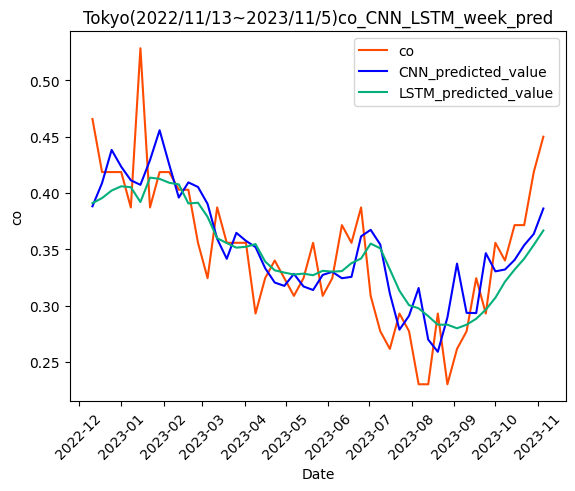

,precipitation,temperature,wind-speed,pressure,humidity,co,so2,pm25,pm10,o3,no2,AQI_total,target,co_pred_original_cnn,co_pred_original
Date,,,,,,,,,,,,,,,
2022-12-11,4.142857,8.671429,1.871429,1013.957143,72.571429,0.465714,0.00150,36.571429,10.142857,0.009514,0.020957,92.714286,0.789474,0.388150,0.390984
2022-12-18,1.357143,7.571429,2.185714,1010.571429,59.571429,0.418571,0.00150,30.714286,8.714286,0.016029,0.018557,81.142857,0.631579,0.408817,0.395442
2022-12-25,2.500000,6.071429,2.757143,1003.842857,50.285714,0.418571,0.00170,26.000000,7.285714,0.015800,0.018443,71.285714,0.631579,0.438270,0.402160
2023-01-01,0.000000,6.657143,2.128571,1016.671429,54.142857,0.418571,0.00150,27.142857,7.571429,0.017529,0.016057,73.428571,0.631579,0.423324,0.405920
2023-01-08,0.000000,5.971429,2.185714,1015.428571,48.571429,0.387143,0.00150,27.000000,7.428571,0.019800,0.013429,71.428571,0.526316,0.411285,0.405129
2023-01-15,0.642857,7.757143,2.257143,1014.371429,61.714286,0.528571,0.00190,50.142857,14.714286,0.012914,0.022943,117.714286,1.000000,0.407221,0.391933
2023-01-22,1.428571,6.100000,2.300000,1015.700000,61.571429,0.387143,0.00170,29.428571,8.000000,0.018429,0.014857,78.857143,0.526316,0.429227,0.413627
2023-01-29,0.142857,3.257143,2.857143,1008.385714,51.142857,0.418571,0.00150,34.714286,9.857143,0.017514,0.017114,88.571429,0.631579,0.455747,0.412559
2023-02-05,0.000000,5.728571,2.714286,1013.614286,47.714286,0.418571,0.00170,35.857143,10.571429,0.020929,0.015414,91.428571,0.631579,0.425283,0.409055


In [ ]:
create_week_model(Tokyo,"Tokyo")

In [ ]:
df_results

,cnn_week_mape,lstm_week_mape
Delhi_AQI_total,6.76%,7.56%
Tokyo_AQI_total,14.88%,16.68%
Tokyo_co,10.29%,9.4%


# CNNとLSTMの1日単位の予測

In [ ]:
#1日単位の予測をcreate_day_model関数にて、cnn,lstmの両方を動かす
def create_day_model(df,city_name):
  #グラフを保存するpathを作成
  path_img = f"{working_dir}/result/graph/深層学習"
  #予測値の値を保存するデータフレームを作成
  df_pred_data = pd.DataFrame(columns=[])
  for element in elements:
    rh_min = df[element].min()
    rh_max = df[element].max()
    df["target"] = (df[element] - rh_min) / (rh_max - rh_min)
    df_target = df[["target"]]
    df_train = df_target[:-730]
    df_val = df_target[-730:-365]
    df_test = df_target[-365:]

    #学習データの作成
    dataset_train = df_train.dropna().values
    dataset_val = df_val.dropna().values
    dataset_test = df_test.dropna().values
    n_steps_in = 30
    n_steps_out = 1
    X_train, y_train = make_sequences(dataset_train, n_steps_in, n_steps_out)
    X_val, y_val = make_sequences(dataset_val, n_steps_in, n_steps_out)
    X_test, y_test = make_sequences(dataset_test, n_steps_in, n_steps_out)
    n_features = X_train.shape[2]
    n_timessteps = X_train.shape[1]
    n_outputs = y_train.shape[1]


    # #CNNの予測モデル
    def create_cnn_day_model(trial):
        model = Sequential()

        num_conv_layers = trial.suggest_int('num_conv_layers', 1, 2)
        conv_filters = trial.suggest_int('conv_filters', 16, 64)
        kernel_size = trial.suggest_int('kernel_size', 1, 2)
        num_dense_layers = trial.suggest_int('num_dense_layers', 1, 2)
        dense_units = trial.suggest_int('dense_units', 32, 100)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)

        for i in range(num_conv_layers):
            model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=(n_steps_in, n_features)))

        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())

        for i in range(num_dense_layers):
            model.add(Dense(units=dense_units, activation='relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(units=1, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model



    def objective_cnn(trial, X_train, y_train, X_val, y_val):
        # input_shape = X_train.shape[1:]
        model = create_cnn_week_model(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32,callbacks=[early_stopping], verbose=0)

        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)

        return val_mse

    # Optunaでハイパーパラメータの最適化（訓練データと検証データを使用）
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_cnn(trial, X_train, y_train, X_val, y_val), n_trials=30)

    # 最適なハイパーパラメータの取得
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    optimal_model = create_cnn_week_model(study.best_trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    optimal_model.fit(X_train, y_train, epochs=5, batch_size=32, callbacks=[early_stopping],verbose=1)

    y_test_pred = optimal_model.predict(X_test)
    pred_cnn_ = y_test_pred.ravel().tolist()


    y_test_ = y_test.ravel().tolist()
    result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_cnn_)], axis=1))
    result_df.columns = [f"{element}_scaled_cnn", f"pred_scaled_{element}_cnn"]

    #計算するときは正規化した状態で予測値を算出しているため、元の値に戻した列を作成する
    result_df[f"{element}_original_cnn"] = result_df[f"{element}_scaled_cnn"] * (rh_max-rh_min) + rh_min
    result_df[f"{element}_pred_original_cnn"] = result_df[f"pred_scaled_{element}_cnn"] * (rh_max-rh_min) + rh_min
    mape_df = str(str(round(mape(result_df[f"{element}_pred_original_cnn"], result_df[f"{element}_original_cnn"])*100,2))+"%")
    #MAPE値を保存するデータフレームに追加
    df_results.at[f"{city_name}_{element}","cnn_week_mape"] = mape_df
    df_tests = df[-len(result_df):]
    df_tests = df_tests.reset_index()

    # df_pred_week[f"{city_name}_{element}_cnn"] = result_df[f"{element}_pred_original_cnn"].values
    graph_df = pd.concat([df_tests, result_df[f"{element}_pred_original_cnn"]], axis=1)


    #LSTMの1週間単位の予測モデル
    def create_lstm_day_model(trial):
      n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3)  # LSTM層の数
      units_per_layer = [trial.suggest_int(f'units_{i}', 20, 100) for i in range(n_lstm_layers)]  # 各LSTM層のユニット数
      dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
      learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

      model = Sequential()
      for i in range(n_lstm_layers):
          if i == 0:
              model.add(LSTM(units=units_per_layer[i], input_shape=(n_steps_in,n_features), dropout=dropout_rate, return_sequences=True))
          elif i == n_lstm_layers - 1:
              model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate))
          else:
              model.add(LSTM(units=units_per_layer[i], dropout=dropout_rate, return_sequences=True))

      model.add(Dense(1))

      optimizer = Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mean_squared_error')

      return model

    def objective_lstm(trial):
      model = create_lstm_week_model(trial)

      early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

      model.fit(X_train,
                y_train,
                epochs=10,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                verbose=0)

      val_loss = model.evaluate(X_val, y_val, verbose=1)

      return val_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lstm, n_trials=10)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    # 最適なハイパーパラメータで最終的なモデルを構築
    best_model = create_lstm_week_model(study.best_trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # モデルの訓練（全データを使用）
    best_model.fit(X_train,
                   y_train,
                  epochs=10,
                  batch_size=32,
                  callbacks=[early_stopping],
                  verbose=1)

    pred_lstm = best_model.predict(X_test)
    pred_lstm_ = pred_lstm.ravel().tolist()
    y_test_ = y_test.ravel().tolist()
    result_df_lstm = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_lstm_)], axis=1))
    result_df_lstm.columns = [f"{element}_scaled", f"pred_scaled_{element}"]

    result_df_lstm[f"{element}_original"] = result_df_lstm[f"{element}_scaled"] * (rh_max-rh_min) + rh_min
    result_df_lstm[f"{element}_pred_original"] = result_df_lstm[f"pred_scaled_{element}"] * (rh_max-rh_min) + rh_min
    mape_df = str(str(round(mape(result_df_lstm[f"{element}_pred_original"], result_df_lstm[f"{element}_original"])*100,2))+"%")
    df_results.at[f"{city_name}_{element}","lstm_week_mape"] = mape_df


    df_tests_lstm = df_w[-len(result_df_lstm):]
    df_tests_lstm = df_tests_lstm.reset_index()

    df_pred_week[f"{city_name}_{element}_lstm"] = result_df_lstm[f"{element}_pred_original"].values
    graph_df_lstm = pd.concat([graph_df, result_df_lstm[f"{element}_pred_original"]], axis=1)
    graph_df_lstm["Date"]= pd.to_datetime(graph_df_lstm['Date'])
    graph_df_lstm.set_index('Date', inplace=True)




    #グラフ作成

    plt.plot(graph_df_lstm[f"{element}"], color="#FF4B00",label = element)
    plt.plot(graph_df_lstm[f"{element}_pred_original_cnn"], color="blue",label = "CNN_predicted_value")
    plt.plot(graph_df_lstm[f"{element}_pred_original"], color="#03AF7A",label = "LSTM_predicted_value")
    plt.title(f'{city_name}(2022/11/13~2023/11/5){element}_CNN_LSTM_week_pred')
    plt.xlabel("Date")
    plt.ylabel(element)
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f'{path_img}/{city_name}_{element}_cnn_lstm_week.png',bbox_inches='tight')
    plt.show()



  return graph_df_lstm

